# EMA Project Notebook
__Name:__ Daniel Smith

__PI:__ A7603242

_Please note:_

This notebook records all the steps I took in the investigation.  It requires that the provided KS2 & KS4 data has been unzipped and is located in the `data/2015-2016/` folder to run.  When run it will clean the required csv files and store them in a MongoDB.

To carry out all steps may take a little time.

In [1]:
# import the required libraries
import pandas as pd
import scipy.stats
import numpy as np
import pymongo
import bson
import collections
import matplotlib.pyplot as plt
import seaborn as sns

# import the needed machine learning libraries
from sklearn import cluster
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples


In [2]:
# make a folder for storing my working files as I go along.
# make a folder for plot image png's generated
!mkdir -p plot_images

In [3]:
!ls

data				   dcs283_TMA02_Question2b-pd_final.ipynb
dcs283_ema_project_notebook.ipynb  plot_images


In [4]:
# set up basic plot styles
sns.set_style('ticks')
sns.set_palette(palette='Paired', n_colors=12)

# set up plots for nice exporting
#https://matplotlib.org/users/customizing.html
plt.rcParams.update({'axes.titlesize': 35,
                     'axes.labelsize': 30,
                     'lines.linewidth': 5,
                     'lines.markersize': 12,
                     'legend.loc': 'best',
                     'legend.fontsize': 20,
                     'xtick.labelsize': 20,
                     'ytick.labelsize': 20,
                     'figure.figsize': [20, 16]})

# Contents
Use these links to jump to a section.

[Initial look at the ks4 dataset](#initial_look)

[Choosing MongoDB](#mongo)

---
[Data preparation](#preparation)
   - [Importing the KS2 data](#importing_ks2)
   - [Importing the KS4 data](#importing_ks4)
      - [Importing the abbreviations file](#abbr)
      - [Importing the ks4 meta file](#meta)
      - [Importing the data](#data)
---
[Q1, KS4 Investigation](#q1)
   - [Choosing performance measures](#measures)
   - [Additional cleaning](#add_clean)
   - [Does the type of school impact the results students acheive at keystage 4?](#Q1_a)
      - [summary stats](#ks4_summary_stats)
      - [Grouped school type plots](#school_type_plots)
      - [Whole dataset kMeans cluster analysis](#machine_learning)
      - [Grouped data kMeans cluster analysis](#grouped_cluster)
      - [Silhouette plots](#silhouette)
      - [School Scatter](#school_scatter)
      - [Findings](#q1_findings)
---
[Q2, KS2 - KS4 Investigation](#q2)
   - [Do schools that perform well at KS2 deliver as good or better results at KS4.](#q2)
   - [Joining the datasets](#joining)
   - [Summary stats](#stats)
   - [Plotting](#plotting)
   - [Pearson R^2](#pearson)
   - [Findings](#q2_findings)


[Cleanup - remove the database](#cleanup)

<a name="initial_look"></a>

# Initial look at the KS4 results dataset
Let's have a quick look at the data we will be looking at for the EMA.

In [5]:
!head -5 'data/2015-2016/england_ks4final.csv'

In [6]:
!wc -l 'data/2015-2016/england_ks4final.csv'

5489 data/2015-2016/england_ks4final.csv


The dataset has 5489 rows of data, there appears to be a large number of columns and a lot of codes that I'll need to look up.  There are a also a number of `NA` and `NP` values that could be missing data.  As well as this results data I will need to find and import the relevent metadata file.

Before importing the dataset I will need to decide which storage method to use.

<a name="mongo"></a>

# Choosing MongoDB

With so many columns to investigate I am leaning towards using a DBMS to make the querying of the data more efficient than in a pandas dataframe.  Therefore, I will import the data into MongoDB.  I chose a document database system as they are far more flexible than a relational database.  In this investigation it may become necessary to add fields to certain documents for example.  

In [7]:
# set up a connection to mongodb server
client = pymongo.MongoClient('mongodb://localhost:27351')

In [8]:
# uncomment to remove the database if needed
# client.drop_database('schools_db')
# client.database_names()

In [9]:
# setup a schools_db database on mongo
db = client.schools_db

<a name="preparation"></a>

# Data preparation

Before we can investigate the data we will need to have a quick look at it, determine what cleaning, if any, is needed.  Carry out the cleaning and store it for access in tn appropriate form.  

However before doing anything I will import the KS2 data in the same way as was done in `dcs283_TMA02_Question2b-pd`  I will then store the resultant dataframe into mongo for analysis later on.

<a name="importing_ks2"></a>

# Importing the KS2 data


All of this section is the same as in the `TMA02_Question2b-pd` notebook.

***
__ ----------- Beginning of TMA02 code -----------  __

### Import the LEA data

In [10]:
leas_df = pd.read_csv('data/2015-2016/la_and_region_codes_meta.csv')
leas_df.head()

LEA               LA Name  REGION   REGION NAME
0  841            Darlington       1  North East A
1  840         County Durham       1  North East A
2  805            Hartlepool       1  North East A
3  806         Middlesbrough       1  North East A
4  807  Redcar and Cleveland       1  North East A

### Import the KS2 data
Most of the field names are given in the `ks2_meta` file, so we'll use that to keep track of the types of various columns.

In [11]:
ks2cols = pd.read_csv('data/2015-2016/ks2_meta.csv')
ks2cols['Field Name'] = ks2cols['Field Name'].apply(lambda r: r.strip(),)
ks2cols

Column                  Field Name  \
0         1                     RECTYPE   
1         2                    ALPHAIND   
2         3                         LEA   
3         4                       ESTAB   
4         5                         URN   
5         6                     SCHNAME   
6         7                    ADDRESS1   
7         8                    ADDRESS2   
8         9                    ADDRESS3   
9        10                        TOWN   
10       11                       PCODE   
11       12                      TELNUM   
12       13                      URN_AC   
13       14                  SCHNAME_AC   
14       15                     OPEN_AC   
15       16                      NFTYPE   
16       17                      ICLOSE   
17       18                    RELDENOM   
18       19                    AGERANGE   
19       20                    CONFEXAM   
20       21                       TAB15   
21       22                     TAB1618   
22       23                     TOTPUPS   
23       24                    TPUPYEAR   
24       25                       TELIG   
25       26                       BELIG   
26       27                       GELIG   
27       28                      PBELIG   
28       29                      PGELIG   
29       30                 TKS1AVERAGE   
..      ...                         ...   
229     230                PTGPS_HIGH_M   
230     231                PTGPS_HIGH_H   
231     232        PTGPS_HIGH_FSM6CLA1A   
232     233     PTGPS_HIGH_NotFSM6CLA1A   
233     234                PTMAT_HIGH_L   
234     235                PTMAT_HIGH_M   
235     236                PTMAT_HIGH_H   
236     237        PTMAT_HIGH_FSM6CLA1A   
237     238     PTMAT_HIGH_NotFSM6CLA1A   
238     239             PTWRITTA_HIGH_L   
239     240             PTWRITTA_HIGH_M   
240     241             PTWRITTA_HIGH_H   
241     242     PTWRITTA_HIGH_FSM6CLA1A   
242     243  PTWRITTA_HIGH_NotFSM6CLA1A   
243     244                    TEALGRP1   
244     245                   PTEALGRP1   
245     246                    TEALGRP3   
246     247                   PTEALGRP3   
247     248                   TSENELAPK   
248     249                  PSENELSAPK   
249     250                     TSENELE   
250     251                     PSENELE   
251     252                     TSENELK   
252     253                     PSENELK   
253     254                    TSENELST   
254     255                    PSENELST   
255     256                   TSENELSAP   
256     257                   PSENELSAP   
257     258                      SENELN   
258     259                     PSENELN   

                                     Label/Description  
0    Record type (1=mainstream school; 2=special sc...  
1                                     Alphabetic index  
2                               Local authority number  
3                                 Establishment number  
4                       School unique reference number  
5                          School/Local authority name  
6                                   School address (1)  
7                                   School address (2)  
8                                   School address (3)  
9                                          School town  
10                                     School postcode  
11                            School telephone number   
12                             Converter academy: URN   
13                             Converter academy: name  
14                        Converter academy: open date  
15                                         School type  
16                                         Closed Flag  
17                              Religious denomination  
18                                           Age range  
19   Confirmation flag that core performance inform...  
20   School published in secondary school (key stag...  
21   School published in school and college (key st...  
22   Total number of pupils

Some columns contain integers, but _**pandas**_ will treat any numeric column with `na` values as `float64`, due to NumPy's number type hierarchy. 

In [12]:
int_cols = [c for c in ks2cols['Field Name'] 
            if c.startswith('T')
            if c not in ['TOWN', 'TELNUM', 'TKS1AVERAGE']]
int_cols += ['RECTYPE', 'ALPHAIND', 'LEA', 'ESTAB', 'URN', 'URN_AC', 'ICLOSE']
int_cols += ['READ_AVERAGE', 'GPS_AVERAGE', 'MAT_AVERAGE']

Some columns contain percentages. We'll convert these to floating point numbers on import.

Note that we also need to handle the case of `SUPP` and `NEW` in the data.

In [13]:
def p2f(x):
    if x.strip('%').isnumeric():
        return float(x.strip('%'))/100
    elif x in ['SUPP', 'NEW', 'LOWCOV', 'NA', '']:
        return 0.0
    else:
        return x

These are the columns to try to convert from percentages. Note that we can be generous here, as columns like PCODE (postcode) will return the original value if the conversion fails.

In [14]:
percent_cols = [f for f in ks2cols['Field Name'] if f.startswith('P')]
percent_cols += ['WRITCOV', 'MATCOV', 'READCOV'] 
percent_cols += ['PTMAT_HIGH', 'PTREAD_HIGH', 'PSENELSAPK', 'PSENELK', 'PTGPS_HIGH']
percent_converters = {c: p2f for c in percent_cols}

In [15]:
ks2_df = pd.read_csv('data/2015-2016/england_ks2final.csv', 
                   na_values=['SUPP', 'NEW', 'LOWCOV', 'NA', '', ' '],
                   converters=percent_converters)

Drop the summary rows, keeping just the rows for mainstream and special schools.

In [16]:
ks2_df = ks2_df[(ks2_df['RECTYPE'] == 1) | (ks2_df['RECTYPE'] == 2)]

Convert everything to numbers, if possible.

In [17]:
ks2_df = ks2_df.apply(pd.to_numeric, errors='ignore')

Merge the LEA data into the school data

In [18]:
ks2_df = pd.merge(ks2_df, leas_df, on=['LEA'])
ks2_df.head().T

0  \
RECTYPE                                                             1   
ALPHAIND                                                        53372   
LEA                                                               201   
ESTAB                                                            3614   
URN                                                            100000   
SCHNAME                     Sir John Cass's Foundation Primary School   
ADDRESS1                                           St James's Passage   
ADDRESS2                                                 Duke's Place   
ADDRESS3                                                          NaN   
TOWN                                                           London   
PCODE                                                        EC3A 5DE   
TELNUM                                                   0207 2831147   
URN_AC                                                              0   
SCHNAME_AC                                                        NaN   
OPEN_AC                                                           NaN   
NFTYPE                                                             VA   
ICLOSE                                                              0   
RELDENOM                                            Church of England   
AGERANGE                                                         3-11   
CONFEXAM                                                          NaN   
TAB15                                                               0   
TAB1618                                                             0   
TOTPUPS                                                           250   
TPUPYEAR                                                           28   
TELIG                                                              28   
BELIG                                                              16   
GELIG                                                              12   
PBELIG                                                           0.57   
PGELIG                                                           0.43   
TKS1AVERAGE                                                        16   
...                                                               ...   
PTGPS_HIGH_NotFSM6CLA1A                                          0.31   
PTMAT_HIGH_L                                                        0   
PTMAT_HIGH_M                                                     0.15   
PTMAT_HIGH_H                                                     0.33   
PTMAT_HIGH_FSM6CLA1A                                             0.08   
PTMAT_HIGH_NotFSM6CLA1A                                          0.25   
PTWRITTA_HIGH_L                                                     0   
PTWRITTA_HIGH_M                                                  0.05   
PTWRITTA_HIGH_H                                                   0.5   
PTWRITTA_HIGH_FSM6CLA1A                                             0   
PTWRITTA_HIGH_NotFSM6CLA1A                                       0.25   
TEALGRP1                                                           10   
PTEALGRP1                                                        0.36   
TEALGRP3                                                            0   
PTEALGRP3                                                           0   
TSENELAPK                                                           5   
PSENELSAPK                                                       0.18   
TSENELE                                                             0   
PSENELE                                                             0   
TSENELK                                                             5   
PSENELK                                                          0.18   
TSENELST                                                            0   
PSENELST                                                            0   
TSENELSAP                                            

__ ----------- END of TMA02 code -----------  __
***

# Convert and store the KS2 dataframe into Mongo for use later

In [19]:
# set up a collection on the database for the ks2 results data
ks2 = db.ks2

In [20]:
# convert the dataframe into a list of dicts and store in Mongo

# the 'results' argument is needed to get a list of dicts
ks2.insert_many(ks2_df.to_dict('records'))

# snippet reference is from:
# https://stackoverflow.com/questions/33979983/insert-rows-from-pandas-dataframe-into-mongodb-collection-as-individual-document

In [21]:
# check we got them all
ks2.find().count(), len(ks2_df)

(64648, 16162)

Great all present and correct.  Let's look at one.

In [22]:
ks2.find_one()

{'ADDRESS1': "St James's Passage",
 'ADDRESS2': "Duke's Place",
 'ADDRESS3': nan,
 'AGERANGE': '3-11',
 'ALPHAIND': 53372.0,
 'BELIG': 16.0,
 'CONFEXAM': nan,
 'DIFFN_MATPROG': 2.7,
 'DIFFN_READPROG': 0.6,
 'DIFFN_RWM_EXP': 23.0,
 'DIFFN_RWM_HIGH': -7.0,
 'DIFFN_WRITPROG': 0.2,
 'ESTAB': 3614.0,
 'GELIG': 12.0,
 'GPS_AVERAGE': 106.0,
 'GPS_AVERAGE_FSM6CLA1A': 105.0,
 'GPS_AVERAGE_H': 110.0,
 'GPS_AVERAGE_L': nan,
 'GPS_AVERAGE_M': 105.0,
 'GPS_AVERAGE_NotFSM6CLA1A': 107.0,
 'ICLOSE': 0.0,
 'LA Name': 'City of London',
 'LEA': 201.0,
 'MATCOV': 1.0,
 'MATPROG': 3.0,
 'MATPROG_B': 2.9,
 'MATPROG_B_LOWER': 0.3,
 'MATPROG_B_UPPER': 5.5,
 'MATPROG_EAL': 3.1,
 'MATPROG_EAL_LOWER': 0.6,
 'MATPROG_EAL_UPPER': 5.6,
 'MATPROG_FSM6CLA1A': 2.9,
 'MATPROG_FSM6CLA1A_LOWER': -0.1,
 'MATPROG_FSM6CLA1A_UPPER': 5.9,
 'MATPROG_G': 3.1,
 'MATPROG_G_LOWER': 0.1,
 'MATPROG_G_UPPER': 6.1,
 'MATPROG_H': 0.4,
 'MATPROG_H_LOWER': -3.9,
 'MATPROG_H_UPPER': 4.7,
 'MATPROG_L': nan,
 'MATPROG_LOWER': 1.0,
 'MATPROG

In [23]:
ks2.find_one()['GPS_AVERAGE_L']

nan

In [24]:
ks2.find({'GPS_AVERAGE_L': np.nan}).count()

47760

Looks like everything is set up.  We will need to bear the NaN values and missing values that the `p2f` function made into `0.0` in mind throughout the analysis.

In [25]:
ks2.find_one()

{'ADDRESS1': "St James's Passage",
 'ADDRESS2': "Duke's Place",
 'ADDRESS3': nan,
 'AGERANGE': '3-11',
 'ALPHAIND': 53372.0,
 'BELIG': 16.0,
 'CONFEXAM': nan,
 'DIFFN_MATPROG': 2.7,
 'DIFFN_READPROG': 0.6,
 'DIFFN_RWM_EXP': 23.0,
 'DIFFN_RWM_HIGH': -7.0,
 'DIFFN_WRITPROG': 0.2,
 'ESTAB': 3614.0,
 'GELIG': 12.0,
 'GPS_AVERAGE': 106.0,
 'GPS_AVERAGE_FSM6CLA1A': 105.0,
 'GPS_AVERAGE_H': 110.0,
 'GPS_AVERAGE_L': nan,
 'GPS_AVERAGE_M': 105.0,
 'GPS_AVERAGE_NotFSM6CLA1A': 107.0,
 'ICLOSE': 0.0,
 'LA Name': 'City of London',
 'LEA': 201.0,
 'MATCOV': 1.0,
 'MATPROG': 3.0,
 'MATPROG_B': 2.9,
 'MATPROG_B_LOWER': 0.3,
 'MATPROG_B_UPPER': 5.5,
 'MATPROG_EAL': 3.1,
 'MATPROG_EAL_LOWER': 0.6,
 'MATPROG_EAL_UPPER': 5.6,
 'MATPROG_FSM6CLA1A': 2.9,
 'MATPROG_FSM6CLA1A_LOWER': -0.1,
 'MATPROG_FSM6CLA1A_UPPER': 5.9,
 'MATPROG_G': 3.1,
 'MATPROG_G_LOWER': 0.1,
 'MATPROG_G_UPPER': 6.1,
 'MATPROG_H': 0.4,
 'MATPROG_H_LOWER': -3.9,
 'MATPROG_H_UPPER': 4.7,
 'MATPROG_L': nan,
 'MATPROG_LOWER': 1.0,
 'MATPROG

Now we have finished with it we can get rid of the ks2 dataframe.

In [26]:
del ks2_df

<a name="importing_ks4"></a>

# Importing the KS4 results dataset

Before we can investigate the data we will need to have a look at it, determine what cleaning if any needs to be done, and store it for access in an appropriate form.

### Look at the KS4 results dataset
Let's have a quick look at the data we will be looking at for the EMA.

In [27]:
!head -5 'data/2015-2016/england_ks4final.csv'

In [28]:
!wc -l 'data/2015-2016/england_ks4final.csv'

5489 data/2015-2016/england_ks4final.csv


The dataset has 5489 rows of data, there appears to be a large number of columns and a lot of codes that I'll need to look up.  There are a also a number of `NA` and `NP` values that could be missing data.  As well as this results data I will need to find and import the relevent metadata file.

Looking through the data/2015-2016 folder there are a number of files that have information on these codes.

In [29]:
!ls data/2015-2016/

abbreviations.xlsx	    england_swf.csv
abs_meta.csv		    england_vaqual.csv
census_meta.csv		    england_vasubj.csv
england_abs.csv		    keto_setup.xlsx
england_census.csv	    ks2_meta.csv
england_cfrfull.xlsx	    ks4_meta.csv
england_ks2final.csv	    ks4_meta_methodology.csv
england_ks4final.csv	    ks4-pupdest_meta.csv
england_ks4-pupdest.csv     ks5_meta.csv
england_ks4underlying.xlsx  ks5-studest_meta.csv
england_ks5final.csv	    la_and_region_codes_meta.csv
england_ks5-studest.csv     sixth_form_centres_and_consortia_meta.xlsx
england_ks5underlying.xlsx  spine_meta.csv
england_spine.csv	    swf_meta.csv


There is an abbreviations file, stored as an xlsx file.  I'll have a quick glance at it in excel.  Having looked the abbreviation up in the abbreviations file we can see that they have the following meanings:

- _NA_: Not applicable
- _NP_: Not Published
- _NE_: No entries
- _SUPP_: Suppressed (5 or fewer in cohort)
- _LOWCOV_: Low coverage (less than 50% of the cohort
- _NEW_: New institution

The abbreviations file also has listings of all the school types (NFTYPE) that I will need.  I'll grab that for use later on.

<a name='abbr'></a>

## Importing the abbreviations file

In [30]:
# read in the abbreviations file
abbr_df = pd.read_excel('data/2015-2016/abbreviations.xlsx')
abbr_df

2016 KS4 and KS5/16-18 Performance Tables  \
0   Abbreviations used in the csv and excel Downlo...   
1                                                 NaN   
2                         Institution type (NFTYPE):    
3                                                  AC   
4                                                 ACC   
5                                              AC1619   
6                                             ACC1619   
7                                                ACCS   
8                                                 ACS   
9                                                 CTC   
10                                                 CY   
11                                                CYS   
12                                                  F   
13                                               FESI   
14                                                 FD   
15                                                FDS   
16                                                 FS   
17                                                FSS   
18                                               FUTC   
19                                              F1619   
20                                                IND   
21                                            INDSPEC   
22                                              MODFC   
23                                               NMSS   
24                                                 VA   
25                                                 VC   
26                                                NaN   
27      Types of further education (FE) institutions:   
28              Agriculture and horticultural college   
29            Art, design and performing arts college   
30                  General further education college   
31        General further education college (special)   
32                                 Sixth form college   
33                      Specialist designated college   
34                                   Tertiary college   
35                                                NaN   
36                       Admissions policy (ADMPOL):    
37                                               COMP   
38                                                MOD   
39                                                SEL   
40                                                NA    
41                                                 UK   
42                                            <blank>   
43                                                NaN   
44                             General abbreviations:   
45                                                NEW   
46                                                 NE   
47                                                NaN   
48                                               SUPP   
49                                                 NP   
50                                             LOWCOV   
51                                                NaN   
52                                            Notes:    
53  The 2016 secondary and 16-18 performance table...   
54  If a school converted to an academy during the...   
55  The KS4 and KS5 metadata files provide descrip...   

                                           Unnamed: 1  Unnamed: 2  
0                                                 NaN         NaN  
1                                                 NaN         NaN  
2                                                 NaN         NaN  
3                                 Sponsored academy           NaN  
4                      Academy converter - mainstream         NaN  
5                           Academy 16-19 sponsor led         NaN  
6                             Academy 16-19 converter         NaN  
7                  Academy converter - special school         NaN  
8                          Sponsored special academy          NaN  
9                             City technology college         NaN  
10            

We can see that the school types are rows 2-25, I'll store them as a dict for reference later on.

In [31]:
# relabel the columns
abbr_df.columns = ['label', 'expanded', 'not_needed']

In [32]:
# make a dictionary to easily look up the school types
nftypes = {}
for index, row in abbr_df[3:26].iterrows():
    nftypes[row['label'].strip()] = row['expanded'].strip()
    
nftypes

{'AC': 'Sponsored academy',
 'AC1619': 'Academy 16-19 sponsor led',
 'ACC': 'Academy converter - mainstream',
 'ACC1619': 'Academy 16-19 converter',
 'ACCS': 'Academy converter - special school',
 'ACS': 'Sponsored special academy',
 'CTC': 'City technology college',
 'CY': 'Community school',
 'CYS': 'Community special school',
 'F': 'Free school - mainstream',
 'F1619': 'Free school - 16-19',
 'FD': 'Foundation school',
 'FDS': 'Foundation special school',
 'FESI': 'Further Education Sector Institution',
 'FS': 'Free school - special',
 'FSS': 'Studio school',
 'FUTC': 'UTC (university technical college)',
 'IND': 'Independent school',
 'INDSPEC': 'Independent special school',
 'MODFC': 'College funded by Ministry of Defence',
 'NMSS': 'Non-maintained special school',
 'VA': 'Voluntary aided school',
 'VC': 'Voluntary controlled school'}

And, while we have the abbreviations available I'll store the missing value types for reference later on if needed.

In [33]:
# make a dictionary to refer to later of the missing types
missing_types = {}
for i, r in abbr_df[45:51].iterrows():
    missing_types[r['label']] = r['expanded']

missing_types

{nan: 'Not applicable: figures are either not available for the year in question, or the data field is not applicable to this school or college',
 'LOWCOV': 'Low coverage: indicates that a school’s Progress 8 or value added measures have been suppressed because coverage is less than 50% of the cohort',
 'NE': 'No entries',
 'NP': 'Not published - for example we do not publish Progress 8 data for independent schools and independent special schools, or breakdowns by disadvantaged and non-disadvantaged pupils for independent schools, independent special schools and non-maintained special schools.',
 'NEW': 'New institution',
 'SUPP': "Indicates that a school or college's figures have been suppressed because there are 5 or fewer pupils in the cohort"}

I can now delete the abbr_df as it won't be needed.

In [34]:
del abbr_df

<a name='meta'></a>

## Importing the KS4 Metadata file

In order to analyse the data we need to be able to reference the columns and the codes they represent.  I'll import the KS4_meta.csv file into the database and use it to help me understand the data in the KS4 results dataset.

In [35]:
!head -5 data/2015-2016/ks4_meta.csv

372,TAVENT_GNFSM6CLA1A_15_PTQ_EE,Average number of GCSE entries per non-disadvantaged pupil in 2015,,,,Yes,,,

In [36]:
!wc -l data/2015-2016/ks4_meta.csv

0 data/2015-2016/ks4_meta.csv


0 lines.. I'll try loading directly into Mongo

In [37]:
!/usr/bin/mongoimport --port 27351 --drop --db schools_db --collection ks4_meta \
    --type csv --headerline --ignoreBlanks \
    --file data/2015-2016/ks4_meta.csv

2018-06-04T15:40:13.942+0000	Failed: fields cannot be identical: '' and ''
2018-06-04T15:40:13.942+0000	imported 0 documents


Clearly there is an issue with the import.  I'll try importing it into a dataframe.

In [38]:
ks4_meta_df = pd.read_csv('data/2015-2016/ks4_meta.csv')
ks4_meta_df.head()

Column Metafile heading                               Metafile description  \
0       1          RECTYPE  Record type (1=mainstream school; 2=special sc...   
1       2         ALPHAIND                           Alphabetic sorting index   
2       3              LEA  Local authority code (see separate list of loc...   
3       4            ESTAB                               Establishment number   
4       5              URN                     School Unique Reference Number   

  Methodology changes Null field for special schools  \
0                 NaN                            NaN   
1                 NaN                            NaN   
2                 NaN                            NaN   
3                 NaN                            NaN   
4                 NaN                            NaN   

  Null field for local authority records  \
0                                    NaN   
1                                    Yes   
2                                    NaN   
3                                    Yes   
4                                    Yes   

  Null field for National (all schools) records  \
0                                           NaN   
1                                           Yes   
2                                           Yes   
3                                           Yes   
4                                           Yes   

  Null field for National (maintained schools) records  Unnamed: 8  Unnamed: 9  
0                                                NaN           NaN         NaN  
1                                                Yes           NaN         NaN  
2                                                Yes           NaN         NaN  
3                                                Yes           NaN         NaN  
4                                                Yes           NaN         NaN

That imported ok.  But there are a few extra columns for my needs (I only need it to look up the description for a given term)

In [39]:
# reduce the dataframe to the columns of interest
ks4_meta_df = ks4_meta_df[['Metafile heading', 'Metafile description']]
# relabel them to match my target format
ks4_meta_df.columns = ['label', 'expanded']


In [40]:
# check it looks ok
ks4_meta_df.head()

label                                           expanded
0   RECTYPE  Record type (1=mainstream school; 2=special sc...
1  ALPHAIND                           Alphabetic sorting index
2       LEA  Local authority code (see separate list of loc...
3     ESTAB                               Establishment number
4       URN                     School Unique Reference Number

In [41]:
# set up a reference to the db.collection 
ks4_meta = db.ks4_meta

In [42]:
ks4_meta.insert_many(ks4_meta_df.to_dict('records'))
# snippet reference is from:
# https://stackoverflow.com/questions/33979983/insert-rows-from-pandas-dataframe-into-mongodb-collection-as-individual-document

In [43]:
ks4_meta.find_one({'label': 'NFTYPE'})

{'_id': ObjectId('5b154d7a0fd01f26cc5546b0'),
 'codes': {'AC': 'Sponsored academy',
  'AC1619': 'Academy 16-19 sponsor led',
  'ACC': 'Academy converter - mainstream',
  'ACC1619': 'Academy 16-19 converter',
  'ACCS': 'Academy converter - special school',
  'ACS': 'Sponsored special academy',
  'CTC': 'City technology college',
  'CY': 'Community school',
  'CYS': 'Community special school',
  'F': 'Free school - mainstream',
  'F1619': 'Free school - 16-19',
  'FD': 'Foundation school',
  'FDS': 'Foundation special school',
  'FESI': 'Further Education Sector Institution',
  'FS': 'Free school - special',
  'FSS': 'Studio school',
  'FUTC': 'UTC (university technical college)',
  'IND': 'Independent school',
  'INDSPEC': 'Independent special school',
  'MODFC': 'College funded by Ministry of Defence',
  'NMSS': 'Non-maintained special school',
  'VA': 'Voluntary aided school',
  'VC': 'Voluntary controlled school'},
 'expanded': 'School type (see separate list of abbreviations used in

I want to add the codes from the abbreviations dictionary to this document since it is one of the backbones to my investigation.

In [44]:
ks4_meta.update_one({'label': 'NFTYPE'}, 
                    {'$set': {'codes': nftypes}})

ks4_meta.find_one({'label': 'NFTYPE'})

{'_id': ObjectId('5b154d7a0fd01f26cc5546b0'),
 'codes': {'AC': 'Sponsored academy',
  'AC1619': 'Academy 16-19 sponsor led',
  'ACC': 'Academy converter - mainstream',
  'ACC1619': 'Academy 16-19 converter',
  'ACCS': 'Academy converter - special school',
  'ACS': 'Sponsored special academy',
  'CTC': 'City technology college',
  'CY': 'Community school',
  'CYS': 'Community special school',
  'F': 'Free school - mainstream',
  'F1619': 'Free school - 16-19',
  'FD': 'Foundation school',
  'FDS': 'Foundation special school',
  'FESI': 'Further Education Sector Institution',
  'FS': 'Free school - special',
  'FSS': 'Studio school',
  'FUTC': 'UTC (university technical college)',
  'IND': 'Independent school',
  'INDSPEC': 'Independent special school',
  'MODFC': 'College funded by Ministry of Defence',
  'NMSS': 'Non-maintained special school',
  'VA': 'Voluntary aided school',
  'VC': 'Voluntary controlled school'},
 'expanded': 'School type (see separate list of abbreviations used in

I'll do the same for the `RECTYPE` label by splitting the description.

In [45]:
# select the correct document
r = ks4_meta.find_one({'label': 'RECTYPE'})

# checks that we haven't already updated the document
# then if not splits the description string, adding a code key
# to reference each school type
if 'codes' not in r.keys():
    expanded = r['expanded']
    e = expanded[:11]
    codelist = expanded[13:-1].split('; ')
    keys = [c[:1] for c in codelist]
    values = [c[2:] for c in codelist]
    codes = (dict(list(zip(keys, values))))
    ks4_meta.update_one({'_id': r['_id']},
                        {'$set': {'expanded': e,
                                  'codes': codes}})

# check that it was processed correctly
ks4_meta.find_one({'label': 'RECTYPE'})

{'_id': ObjectId('5b154d7a0fd01f26cc5546a1'),
 'codes': {'1': 'mainstream school',
  '2': 'special school',
  '4': 'local authority',
  '5': 'National (all schools)',
  '7': 'National (maintained schools)'},
 'expanded': 'Record type',
 'label': 'RECTYPE'}

Great.  That is most of the cleaning I need to do for the ks4_meta file.  If I were to be doing a different investigation I would consider merging in the LEA data here, but for the investigations I plan to do I don't think we need it and we already have it stored from earlier on (importing ks2) as the `LEA` dataframe which we can reference if needed.

Great.  Now in the tm351 module materials we had some handy collections provided by the module team that enabled us to quickly look up the labels and codes of a given accident.  I'll borrow that idea here for my purposes.  Because, I will need to do the same for the KS2 dataset, I'll wrap them in a function.

In [46]:
# code adapted from the p14 accidents dataset notebooks

def expanded_label(meta):
    # Load the expanded names of keys and human-readable codes into memory
    expanded_name = collections.defaultdict(str)
    for e in meta.find({'expanded': {"$exists": True}}):
        expanded_name[e['label']] = e['expanded']

    label_of = collections.defaultdict(str)
    for l in meta.find({'codes': {"$exists": True}}):
        for c in l['codes']:
            try:
                label_of[l['label'], int(c)] = l['codes'][c]
            except ValueError: 
                label_of[l['label'], c] = l['codes'][c]
    # return both as a tuple
    return (expanded_name, label_of)

In [47]:
# Set up the expanded_name and label_of for ks4_meta
ks4_expanded_name, ks4_label_of = expanded_label(ks4_meta)

In [48]:
# test it works
[(c, ks4_label_of['RECTYPE', c]) for k, c in ks4_label_of if k == 'RECTYPE']

[(5, 'National (all schools)'),
 (4, 'local authority'),
 (2, 'special school'),
 (7, 'National (maintained schools)'),
 (1, 'mainstream school')]

In [49]:
ks4_expanded_name['NFTYPE']

'School type (see separate list of abbreviations used in the tables)'

In [50]:
ks4_label_of['NFTYPE', 'AC']

'Sponsored academy'

Great that all is working, I can now delete the ks4_meta_df, as the information is stored.

In [51]:
del ks4_meta_df

I'll quickly repeat the same steps for KS2_meta data to include the codes.

In [52]:
# relabel the columns of ks2cols
ks2cols.columns = ['not_needed', 'label', 'expanded']

# create a collection in the database
ks2_meta = db.ks2_meta

In [53]:
# store them into the database
ks2_meta.insert_many(ks2cols[['label', 'expanded']].to_dict('records'))

In [54]:
ks2_meta.find_one()

{'_id': ObjectId('5b154d7a0fd01f26cc554815'),
 'codes': {'1': 'mainstream school',
  '2': 'special school',
  '3': 'Local Authority',
  '4': 'National (all schools)',
  '5': 'National (maintained schools)'},
 'expanded': 'Record type',
 'label': 'RECTYPE'}

In [55]:
# repeat the splitting of the `RECTYPE`
# select the correct document
r = ks2_meta.find_one({'label': 'RECTYPE'})

# checks that we haven't already updated the document
# then if not splits the description string, adding a code key
# to reference each school type
if 'codes' not in r.keys():
    expanded = r['expanded']
    e = expanded[:11]
    codelist = expanded[13:-1].split('; ')
    keys = [c[:1] for c in codelist]
    values = [c[2:] for c in codelist]
    codes = (dict(list(zip(keys, values))))
    ks2_meta.update_one({'_id': r['_id']},
                        {'$set': {'expanded': e,
                                  'codes': codes}})

# check that it was processed correctly
ks2_meta.find_one({'label': 'RECTYPE'})

{'_id': ObjectId('5b154d7a0fd01f26cc554815'),
 'codes': {'1': 'mainstream school',
  '2': 'special school',
  '3': 'Local Authority',
  '4': 'National (all schools)',
  '5': 'National (maintained schools)'},
 'expanded': 'Record type',
 'label': 'RECTYPE'}

In [56]:
# And add the nftype to the meta collection
ks2_meta.update_one({'label': 'NFTYPE'}, 
                    {'$set': {'codes': nftypes}})

ks2_meta.find_one({'label': 'NFTYPE'})

{'_id': ObjectId('5b154d7a0fd01f26cc554824'),
 'codes': {'AC': 'Sponsored academy',
  'AC1619': 'Academy 16-19 sponsor led',
  'ACC': 'Academy converter - mainstream',
  'ACC1619': 'Academy 16-19 converter',
  'ACCS': 'Academy converter - special school',
  'ACS': 'Sponsored special academy',
  'CTC': 'City technology college',
  'CY': 'Community school',
  'CYS': 'Community special school',
  'F': 'Free school - mainstream',
  'F1619': 'Free school - 16-19',
  'FD': 'Foundation school',
  'FDS': 'Foundation special school',
  'FESI': 'Further Education Sector Institution',
  'FS': 'Free school - special',
  'FSS': 'Studio school',
  'FUTC': 'UTC (university technical college)',
  'IND': 'Independent school',
  'INDSPEC': 'Independent special school',
  'MODFC': 'College funded by Ministry of Defence',
  'NMSS': 'Non-maintained special school',
  'VA': 'Voluntary aided school',
  'VC': 'Voluntary controlled school'},
 'expanded': 'School type',
 'label': 'NFTYPE'}

In [57]:
# finally, set up the expanded_name and label_of for ks4_meta
ks2_expanded_name, ks2_label_of = expanded_label(ks2_meta)

check they work ok

In [58]:
# test it works
[(c, ks2_label_of['RECTYPE', c]) for k, c in ks2_label_of if k == 'RECTYPE']

[(5, 'National (maintained schools)'),
 (4, 'National (all schools)'),
 (2, 'special school'),
 (3, 'Local Authority'),
 (1, 'mainstream school')]

In [59]:
ks2_label_of['NFTYPE', 'IND']

'Independent school'

In [60]:
ks2_expanded_name['TELIG']

'Published eligible pupil number'

Great that is all the meta data handled, and we can now go about importing the KS4 data into the database and cleaning it.

In [61]:
# delete the ks2cols dataframe as we don't need it anymore
del ks2cols

<a name='data'></a>

## Importing the KS4 dataset

Before I import the data I will have another quick look at the file.

In [62]:
! head -5 'data/2015-2016/england_ks4final.csv'

To restate what was noted earlier there appears to be a great number of columns, and a large number of missing values.  How many rows are there?

In [63]:
!wc -l 'data/2015-2016/england_ks4final.csv'

5489 data/2015-2016/england_ks4final.csv


Let's carry out similar steps to those we carried out in importing the ks2 data.  Again this is going to be adapted from the TMA02-Q2

In [64]:
ks4_df = pd.read_csv('data/2015-2016/england_ks4final.csv')
ks4_df.head()

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


RECTYPE ALPHAIND  LEA ESTAB     URN                          SCHNAME  \
0        1    11828  201  6007  100003            City of London School   
1        1    11830  201  6005  100001  City of London School for Girls   
2        4           201                                                  
3        1      368  202  4285  100053           Acland Burghley School   
4        1     9318  202  4611  100054      The Camden School for Girls   

  SCHNAME_AC               ADDRESS1  ADDRESS2 ADDRESS3  \
0             Queen Victoria Street                      
1                 St Giles' Terrace  Barbican            
2                                                        
3                     Burghley Road                      
4                      Sandall Road                      

              ...              TAVENT_GAV_PTQ_EE TAVENT_GHI_PTQ_EE  \
0             ...                             NP                NP   
1             ...                             NP                NP   
2             ...                                                    
3             ...                            8.9               9.8   
4             ...                            8.2              10.2   

  TAVENT_GFSM6CLA1A_PTQ_EE TAVENT_GNFSM6CLA1A_PTQ_EE TAVENT_GFSM_13  \
0                       NP                        NP            NaN   
1                       NP                        NP            NaN   
2                                                                     
3                      8.4                       9.5            8.1   
4                      7.8                       9.8            8.6   

  TAVENT_GNFSM_13 TAVENT_GFSM_14_PTQ TAVENT_GNFSM_14_PTQ  \
0             NaN                NaN                 NaN   
1             NaN                NaN                 NaN   
2                                                          
3             9.8                  9                10.2   
4             9.3                7.3                 8.6   

  TAVENT_GFSM6CLA1A_15_PTQ_EE TAVENT_GNFSM6CLA1A_15_PTQ_EE  
0                         NaN                          NaN  
1                         NaN                          NaN  
2                                                           
3                         8.4                         10.6  
4                         7.5                          8.9  

[5 rows x 372 columns]

A straight import gives an error (`DtypeWarning`).  Let's look at the file using the tools learned in p2 of the tm351 materials.

In [65]:
# let's quickly look at the file using command line
!file 'data/2015-2016/england_ks4final.csv'

data/2015-2016/england_ks4final.csv: UTF-8 Unicode (with BOM) text, with very long lines, with CRLF line terminators


In [66]:
# and check it using chardet
import chardet

# open the file and read the contents in as a byte object
testfile = open('data/2015-2016/england_ks4final.csv', 'rb').read()

# detect the file encoding
chardet.detect(testfile)

{'confidence': 1.0, 'encoding': 'UTF-8-SIG'}

ks4_df = pd.read_csv('data/2015-2016/england_ks4final.csv', encoding='UTF-8-SIG')
ks4_df.head()

In [67]:
ks4_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5489 entries, 0 to 5488
Columns: 372 entries, RECTYPE to TAVENT_GNFSM6CLA1A_15_PTQ_EE
dtypes: int64(1), object(371)
memory usage: 15.6+ MB


In [68]:
ks4_df.dtypes

RECTYPE                            int64
ALPHAIND                          object
LEA                               object
ESTAB                             object
URN                               object
SCHNAME                           object
SCHNAME_AC                        object
ADDRESS1                          object
ADDRESS2                          object
ADDRESS3                          object
TOWN                              object
PCODE                             object
TELNUM                            object
CONTFLAG                          object
ICLOSE                            object
NFTYPE                            object
RELDENOM                          object
ADMPOL                            object
EGENDER                           object
FEEDER                            object
TABKS2                            object
TAB1618                           object
AGERANGE                          object
CONFEXAM                          object
TOTPUPS         

Most of the columns are mixed with an 'object' datatype.

In [69]:
ks4_dt_df = pd.DataFrame()
for col in ks4_df.columns:
    ks4_dt_df[col] = pd.to_numeric(ks4_df[col], errors='ignore')

ks4_dt_df.head()

RECTYPE ALPHAIND  LEA ESTAB     URN                          SCHNAME  \
0        1    11828  201  6007  100003            City of London School   
1        1    11830  201  6005  100001  City of London School for Girls   
2        4           201                                                  
3        1      368  202  4285  100053           Acland Burghley School   
4        1     9318  202  4611  100054      The Camden School for Girls   

  SCHNAME_AC               ADDRESS1  ADDRESS2 ADDRESS3  \
0             Queen Victoria Street                      
1                 St Giles' Terrace  Barbican            
2                                                        
3                     Burghley Road                      
4                      Sandall Road                      

              ...              TAVENT_GAV_PTQ_EE TAVENT_GHI_PTQ_EE  \
0             ...                             NP                NP   
1             ...                             NP                NP   
2             ...                                                    
3             ...                            8.9               9.8   
4             ...                            8.2              10.2   

  TAVENT_GFSM6CLA1A_PTQ_EE TAVENT_GNFSM6CLA1A_PTQ_EE TAVENT_GFSM_13  \
0                       NP                        NP            NaN   
1                       NP                        NP            NaN   
2                                                                     
3                      8.4                       9.5            8.1   
4                      7.8                       9.8            8.6   

  TAVENT_GNFSM_13 TAVENT_GFSM_14_PTQ TAVENT_GNFSM_14_PTQ  \
0             NaN                NaN                 NaN   
1             NaN                NaN                 NaN   
2                                                          
3             9.8                  9                10.2   
4             9.3                7.3                 8.6   

  TAVENT_GFSM6CLA1A_15_PTQ_EE TAVENT_GNFSM6CLA1A_15_PTQ_EE  
0                         NaN                          NaN  
1                         NaN                          NaN  
2                                                           
3                         8.4                         10.6  
4                         7.5                          8.9  

[5 rows x 372 columns]

In [70]:
ks4_dt_df.dtypes

RECTYPE                            int64
ALPHAIND                          object
LEA                               object
ESTAB                             object
URN                               object
SCHNAME                           object
SCHNAME_AC                        object
ADDRESS1                          object
ADDRESS2                          object
ADDRESS3                          object
TOWN                              object
PCODE                             object
TELNUM                            object
CONTFLAG                          object
ICLOSE                            object
NFTYPE                            object
RELDENOM                          object
ADMPOL                            object
EGENDER                           object
FEEDER                            object
TABKS2                            object
TAB1618                           object
AGERANGE                          object
CONFEXAM                          object
TOTPUPS         

I'm not getting very far here.  I'll try and follow the steps from Q2. If after that I have still made no progress I think that the most efficient way to get to the bottom of it will be to take a look at the file in OpenRefine to clean the mixed datatypes and determine what to do with the missing data.

__--- steps adapted from tma02 cleaning ---__

I'll find out which columns have percentages in them.

In [71]:
# Look through the meta file and get the columns that are percentages.
percent_cols_list = [(l, ks4_expanded_name[l]) 
                     for l in ks4_expanded_name 
                     if 'percent' in ks4_expanded_name[l].lower()]
percent_cols_list

[('PTL2BASICS_LL_EAL_PTQ_EE',
  'Percentage of pupils for whom English is an additional language achieving grades A*-C in both English and mathematics GCSEs'),
 ('PTNOTFSM6CLA1ABASICS_15_PTQ_EE',
  'Percentage of non-disadvantaged pupils achieving grades A*-C in both English and mathematics GCSEs in 2015'),
 ('PSENSE4',
  'Percentage of pupils at the end of key stage 4 with special educational needs (SEN) with a statement or Education, health and care (EHC) plan'),
 ('PTEBACC_FSM_13',
  'Percentage of disadvantaged pupils achieving the English Baccalaureate in 2013'),
 ('PGEBACC_PTQ_EE', 'Percentage of girls achieving the English Baccalaureate'),
 ('PTL2BASICS_LL_PTQ_EE',
  'Percentage of pupils achieving grades A*-C in both English and mathematics GCSEs'),
 ('PTEBACC_E_PTQ_EE',
  'Percentage of key stage 4 pupils with entries in all English Baccalaureate subject areas'),
 ('PTEBACMATAG_PTQ_EE',
  'Percentage of pupils achieving the English Baccalaureate Maths subject area at grade A*-

In [72]:
# Save the column headings to a list
percent_cols = [p[0] for p in percent_cols_list]
percent_cols

['PTL2BASICS_LL_EAL_PTQ_EE',
 'PTNOTFSM6CLA1ABASICS_15_PTQ_EE',
 'PSENSE4',
 'PTEBACC_FSM_13',
 'PGEBACC_PTQ_EE',
 'PTL2BASICS_LL_PTQ_EE',
 'PTEBACC_E_PTQ_EE',
 'PTEBACMATAG_PTQ_EE',
 'AC5EM15_PTQ_EE',
 'PTEBACC_EAV_PTQ_EE',
 'PTNOTFSM6CLA1A',
 'PTEALGRP1',
 'PTEBACC_E_13',
 'AC5EM13',
 'PTEBACC_ENFSM_14_PTQ',
 'PGEBACC_E_PTQ_EE',
 'PTL2BASICS_15_PTQ_EE',
 'PTNOTFSMCLA_14',
 'PTEBACENG_LL_PTQ_EE',
 'PTEBACC_EHI_PTQ_EE',
 'PTFSMCLA_14',
 'PTEBACC_EFSM6CLA1A_15_PTQ_EE',
 'PBL2BASICS_LL_PTQ_EE',
 'PTEBACC_ENFSM_13',
 'PTEBACC_13',
 'PTEBACC_14_PTQ',
 'PTEBAC2SCI_PTQ_EE',
 'PTFSM6CLA1ABASICS_15_PTQ_EE',
 'P8MEACOV',
 'PTNMOB',
 'PTEBACC_EFSM6CLA1A_PTQ_EE',
 'PTEBACCAV_PTQ_EE',
 'PTBASICS_LL_AV_PTQ_EE',
 'PTEBACMAT_PTQ_EE',
 'PTEBACMAT_E_PTQ_EE',
 'PBEBACC_E_PTQ_EE',
 'PTAC5EM_PTQ_EE',
 'PTFSMCLA_13',
 'PTEBACC_EFSM_13',
 'PGL2BASICS_LL_PTQ_EE',
 'PTFSM6CLA1A_15',
 'PTEBACLANAG_PTQ_EE',
 'PTBASICS_LL_LO_PTQ_EE',
 'PTEBACCNMOB_PTQ_EE',
 'PTEBACC_NFSM_14_PTQ',
 'PTL2BASICS_3YR_PTQ_EE',
 'PTEB

In [73]:
# int columns
int_col_list = [(l, ks4_expanded_name[l])
                for l in ks4_expanded_name 
                if 'number' in ks4_expanded_name[l].lower()]
int_col_list

[('TEBACLANAG_PTQ_EE',
  'Number of pupils achieving the English Baccalaureate Language subject area at grade A*-G'),
 ('TNMOB', 'Number of pupils at the end of key stage 4 who are non-mobile'),
 ('TEBACC_EHI_PTQ_EE',
  'Number of pupils with high prior attainment with entries in all English Baccalaureate subject areas'),
 ('TPRIORAV',
  'Number of pupils at the end of key stage 4 with middle prior attainment at the end of key stage 2'),
 ('TNOTFSM6CLA1A_15',
  'Number of non-disadvantaged pupils at the end of key stage 4 in 2015'),
 ('TEBACC_E_PTQ_EE',
  'Number of key stage 4 pupils with entries in all English Baccalaureate subject areas'),
 ('TAVENT_GFSM6CLA1A_PTQ_EE',
  'Average number of GCSE entries per disadvantaged pupil'),
 ('TEBACENG_LL_PTQ_EE',
  'Number of pupils achieving EBacc English subject area'),
 ('TEBACLAN_E_PTQ_EE',
  'Number of pupils entering the English Baccalaureate Language subject area'),
 ('TEALGRP3',
  'Number of pupils at the end of key stage 4 whose first

In [74]:
# again, save out just the column labels
# Save just the column headings
int_cols = [i[0] for i in int_col_list]
int_cols

['TEBACLANAG_PTQ_EE',
 'TNMOB',
 'TEBACC_EHI_PTQ_EE',
 'TPRIORAV',
 'TNOTFSM6CLA1A_15',
 'TEBACC_E_PTQ_EE',
 'TAVENT_GFSM6CLA1A_PTQ_EE',
 'TEBACENG_LL_PTQ_EE',
 'TEBACLAN_E_PTQ_EE',
 'TEALGRP3',
 'P8PUP_LO',
 'P8PUP_GIRLS',
 'TPUP',
 'TAVENT_E_3NG_HI_PTQ_EE',
 'TOTPUPS',
 'TELNUM',
 'TEBACCAG_PTQ_EE',
 'TAVENT_E_3NG_FSM6CLA1A_PTQ_EE',
 'TEBACC_ELO_PTQ_EE',
 'TAVENT_ENFSM_13',
 'TAVENT_E_3NG_AV_PTQ_EE',
 'P8PUP_EAL',
 'TEBACC_EAV_PTQ_EE',
 'TAVENT_E_3NG_NFSM6CLA1A_PTQ_EE',
 'BPUP',
 'TEBACHUM_E_PTQ_EE',
 'GPUP',
 'TAVENT_GNFSM_13',
 'TEBACMAT_PTQ_EE',
 'TAVENT_EFSM6CLA1A_15_PTQ_EE',
 'TAVENT_GFSM6CLA1A_15_PTQ_EE',
 'TEBACHUM_PTQ_EE',
 'TAVENT_E_3NG_LO_PTQ_EE',
 'TAVENT_GHI_PTQ_EE',
 'TAVENT_EFSM_14_PTQ',
 'P8PUP_15',
 'P8PUP_NFSM6CLA1A',
 'P8PUP_HI',
 'TAVENT_GNFSM_14_PTQ',
 'TEBACHUMAG_PTQ_EE',
 'URN',
 'TEBACMATAG_PTQ_EE',
 'TAVENT_E_3NG_PTQ_EE',
 'TAVENT_GAV_PTQ_EE',
 'TEALGRP2',
 'TAVENT_ENFSM6CLA1A_15_PTQ_EE',
 'TBASICS_LL_AV_PTQ_EE',
 'TBASICS_LL_HI_PTQ_EE',
 'TNOTFSM6CLA1A',
 'TA

In [75]:
# remind myself of the missing type codes
missing_types


{nan: 'Not applicable: figures are either not available for the year in question, or the data field is not applicable to this school or college',
 'LOWCOV': 'Low coverage: indicates that a school’s Progress 8 or value added measures have been suppressed because coverage is less than 50% of the cohort',
 'NE': 'No entries',
 'NP': 'Not published - for example we do not publish Progress 8 data for independent schools and independent special schools, or breakdowns by disadvantaged and non-disadvantaged pupils for independent schools, independent special schools and non-maintained special schools.',
 'NEW': 'New institution',
 'SUPP': "Indicates that a school or college's figures have been suppressed because there are 5 or fewer pupils in the cohort"}

In [76]:
percent_converters = {c: p2f for c in percent_cols}

Read in the file to a dataframe

In [77]:
ks4_df = pd.read_csv('data/2015-2016/england_ks4final.csv',
                     na_values=['SUPP', 'NEW', 'LOWCOV', 'NA', ''],
                     converters=percent_converters)

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (2,24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Still showing the error for the data types.  I will continue walking through the cleaning steps from tma02-q2.  For our questions will focus on only mainstream schools we can drop those that are not of `RECTYPE` == 1

In [78]:
ks4_df = ks4_df[ks4_df['RECTYPE'] == 1]

Convert everything to numbers, if possible.


In [79]:
ks4_df = ks4_df.apply(pd.to_numeric, errors='ignore')

Merge the LEA data into the school data.

In [80]:
ks4_df = pd.merge(ks4_df, leas_df, on=['LEA'])
ks4_df.head().T

0  \
RECTYPE                                             1   
ALPHAIND                                        11828   
LEA                                               201   
ESTAB                                            6007   
URN                                            100003   
SCHNAME                         City of London School   
SCHNAME_AC                                              
ADDRESS1                        Queen Victoria Street   
ADDRESS2                                                
ADDRESS3                                                
TOWN                                           London   
PCODE                                        EC4V 3AL   
TELNUM                                   0207 4890291   
CONTFLAG                                            0   
ICLOSE                                              0   
NFTYPE                                            IND   
RELDENOM                                         None   
ADMPOL                                                  
EGENDER                                          BOYS   
FEEDER                                              0   
TABKS2                                              0   
TAB1618                                             1   
AGERANGE                                        10-18   
CONFEXAM                                                
TOTPUPS                                           918   
NUMBOYS                                           918   
NUMGIRLS                                          NaN   
TPUP                                              139   
BPUP                                              139   
PBPUP                                               1   
...                                               ...   
PTFSM6CLA1A_15                                      0   
TNOTFSM6CLA1A_15                                  NaN   
PTNOTFSM6CLA1A_15                                   0   
TAVENT_E_3NG_PTQ_EE                               5.6   
TAVENT_E_3NG_LO_PTQ_EE                             NP   
TAVENT_E_3NG_AV_PTQ_EE                             NP   
TAVENT_E_3NG_HI_PTQ_EE                             NP   
TAVENT_E_3NG_FSM6CLA1A_PTQ_EE                      NP   
TAVENT_E_3NG_NFSM6CLA1A_PTQ_EE                     NP   
TAVENT_EFSM_13                                    NaN   
TAVENT_ENFSM_13                                   NaN   
TAVENT_EFSM_14_PTQ                                NaN   
TAVENT_ENFSM_14_PTQ                               NaN   
TAVENT_EFSM6CLA1A_15_PTQ_EE                       NaN   
TAVENT_ENFSM6CLA1A_15_PTQ_EE                      NaN   
TAVENT_G_PTQ_EE                                   5.3   
TAVENT_GLO_PTQ_EE                                  NP   
TAVENT_GAV_PTQ_EE                                  NP   
TAVENT_GHI_PTQ_EE                                  NP   
TAVENT_GFSM6CLA1A_PTQ_EE                           NP   
TAVENT_GNFSM6CLA1A_PTQ_EE                          NP   
TAVENT_GFSM_13                                    NaN   
TAVENT_GNFSM_13                                   NaN   
TAVENT_GFSM_14_PTQ                                NaN   
TAVENT_GNFSM_14_PTQ                               NaN   
TAVENT_GFSM6CLA1A_15_PTQ_EE                       NaN   
TAVENT_GNFSM6CLA1A_15_PTQ_EE                      NaN   
LA Name                                City of London   
REGION                                             32   
REGION NAME                               London East   

                                                              1  \
RECTYPE                                                       1   
ALPHAIND                                                  11830   
LEA                                                         201   
ESTAB                                                      6005   
URN                                                      100001   
SCHNAME                         City of London School for Girls   
SCHNAME_AC                                      

That is looking better I'll now import these into mongodb

In [81]:
# create a collection in the database
ks4 = db.ks4

In [82]:
# insert the cleaned dataframe to the database
ks4.insert_many(ks4_df.to_dict('records'))

In [83]:
# check that the correct number of documents were included
len(ks4_df), ks4.find().count()

(4196, 16784)

In [84]:
ks4.find_one()

{'AC5EM13': 0.0,
 'AC5EM14_PTQ': 0.0,
 'AC5EM15_PTQ_EE': 0.0,
 'AC5EM16_PTQ_EE': 0.0,
 'ADDRESS1': 'Queen Victoria Street',
 'AGERANGE': '10-18',
 'ALPHAIND': 11828,
 'ATT8SCR': 42.1,
 'ATT8SCREBAC': '22.2',
 'ATT8SCREBAC_FSM6CLA1A': 'NP',
 'ATT8SCREBAC_NFSM6CLA1A': 'NP',
 'ATT8SCRENG': '7.3',
 'ATT8SCRENG_FSM6CLA1A': 'NP',
 'ATT8SCRENG_NFSM6CLA1A': 'NP',
 'ATT8SCRMAT': '0',
 'ATT8SCRMAT_FSM6CLA1A': 'NP',
 'ATT8SCRMAT_NFSM6CLA1A': 'NP',
 'ATT8SCROPEN': '12.6',
 'ATT8SCROPENG': '10.4',
 'ATT8SCROPENG_FSM6CLA1A': 'NP',
 'ATT8SCROPENG_NFSM6CLA1A': 'NP',
 'ATT8SCROPENNG': '2.2',
 'ATT8SCROPENNG_FSM6CLA1A': 'NP',
 'ATT8SCROPENNG_NFSM6CLA1A': 'NP',
 'ATT8SCROPEN_FSM6CLA1A': 'NP',
 'ATT8SCROPEN_NFSM6CLA1A': 'NP',
 'ATT8SCR_15': nan,
 'ATT8SCR_AV': 'NP',
 'ATT8SCR_BOYS': '42.1',
 'ATT8SCR_EAL': 'NP',
 'ATT8SCR_FSM6CLA1A': 'NP',
 'ATT8SCR_GIRLS': nan,
 'ATT8SCR_HI': 'NP',
 'ATT8SCR_LO': 'NP',
 'ATT8SCR_NFSM6CLA1A': 'NP',
 'ATT8SCR_NMOB': 'NP',
 'BPUP': '139',
 'CONTFLAG': 0,
 'DIFFN_ATT8': 'NP'

This is an independent school since they don't need to publish their data there are a lot of missing values.  This is something we will need to be mindful of when carrying out the analysis.  Although the percentages have been handled, there are still a number of other measures that are still showing 'NP'.  Since the majority of the measures I will be looking at will be percentages, instead of working through every single measure I will determine those I want to use in my investigation and then clean those as needed.

In [85]:
ks4_expanded_name['P8MEA_AV']

'Progress 8 measure - pupils with middle prior attainment'

In [86]:
# how many independent schools are in the dataset?
ks4.find({'NFTYPE': 'IND'}).count()

3528

In [87]:
# look at another school type and find out how many there are
nftypes

{'AC': 'Sponsored academy',
 'AC1619': 'Academy 16-19 sponsor led',
 'ACC': 'Academy converter - mainstream',
 'ACC1619': 'Academy 16-19 converter',
 'ACCS': 'Academy converter - special school',
 'ACS': 'Sponsored special academy',
 'CTC': 'City technology college',
 'CY': 'Community school',
 'CYS': 'Community special school',
 'F': 'Free school - mainstream',
 'F1619': 'Free school - 16-19',
 'FD': 'Foundation school',
 'FDS': 'Foundation special school',
 'FESI': 'Further Education Sector Institution',
 'FS': 'Free school - special',
 'FSS': 'Studio school',
 'FUTC': 'UTC (university technical college)',
 'IND': 'Independent school',
 'INDSPEC': 'Independent special school',
 'MODFC': 'College funded by Ministry of Defence',
 'NMSS': 'Non-maintained special school',
 'VA': 'Voluntary aided school',
 'VC': 'Voluntary controlled school'}

In [88]:
# how many Community schools are there?
ks4.find({'NFTYPE': 'CY'}).count()

2164

In [89]:
# delete the dataframes I don't need
del ks4_df, ks4_dt_df

Good things look they are clean enough to start working on the investigation.
<a name='q1'></a>

# Keystage 4 Investigation.  

## Q -  Does the type of school impact the results students acheive at keystage 4?

How big is the dataset?

In [90]:
ks4.find().count()

16784

So there are a large number of documents in the dataset (after taking out the non-mainstream schools)

<a name="measures"></a>

# Choosing performance measures

The first thing I need to decide before I can analyse the data is to decide what I mean by 'good performance' and once that is ascertained which of the many data points I will use as measures to base my comparison of school types on.

For a long time the standard measure of successful schools was the percentage of pupils achieving grades A*-C in Maths and English.  This has changed recently with the government introducing new metrics the 'Progress 8' and 'Achievement 8' and the introduction of the English Baccalaurette which includes English, Maths, Sciences (incl. computer science, history/geograghy a modern/ancient foreign language).  So, I will try to look at these as the success measure of a school, and if possible combine them.

So the first step I need to take is to identify the keys for the data I want to query.

In [91]:
# print all the keys and values of the meta data
# to help choose the columns I will use
for d in ks4_meta.find():
    print(d['label'], ':', d['expanded'], '\n')

RECTYPE : Record type 

ALPHAIND : Alphabetic sorting index 

LEA : Local authority code (see separate list of local authorities and their codes) 

ESTAB : Establishment number 

URN : School Unique Reference Number 

SCHNAME : School name 

SCHNAME_AC : School now known as (used if the school has converted to an academy on or after 12 Sept 2015) 

ADDRESS1 : School address (1) 

ADDRESS2 : School address (2) 

ADDRESS3 : School address (3) 

TOWN : School town 

PCODE : School postcode 

TELNUM : School telephone number 

CONTFLAG : Contingency flag - school results 'significantly affected'. This field is zero for all schools. 

ICLOSE : Closed school flag (0=open; 1=closed) 

NFTYPE : School type (see separate list of abbreviations used in the tables) 

RELDENOM : School religious character 

ADMPOL : School admissions policy (self-declared by schools on Edubase) 

EGENDER : School gender of entry 

FEEDER : Indicates whether school is a feeder school for sixth form centre/consortia 

PTEBACCNMOB_PTQ_EE : Percentage of non-mobile pupils achieving the English Baccalaureate 

PTEBACC_EEAL_PTQ_EE : Percentage of pupils for whom English is an additional language with entries in all English Baccalaureate subject areas 

PTEBACCEAL_PTQ_EE : Percentage of pupils for whom English is an additional language achieving the English Baccalaureate 

PTEBACC_EFSM_13 : Percentage of disadvantaged pupils with entries in all English Baccalaureate subject areas in 2013 

PTEBACC_FSM_13 : Percentage of disadvantaged pupils achieving the English Baccalaureate in 2013 

PTEBACC_ENFSM_13 : Percentage of non-disadvantaged pupils with entries in all English Baccalaureate subject areas in 2013 

PTEBACC_NFSM_13 : Percentage of non-disadvantaged pupils achieving the English Baccalaureate in 2013 

PTEBACC_EFSM_14_PTQ : Percentage of disadvantaged pupils entering all English Baccalaureate subject areas in 2014 

PTEBACC_FSM_14_PTQ : Percentage of disadvantaged pupils achieving the English Bacca

PTEBACCAV_PTQ_EE : Percentage of pupils with middle prior attainment achieving the English Baccalaureate 

TEBACC_EHI_PTQ_EE : Number of pupils with high prior attainment with entries in all English Baccalaureate subject areas 

PTEBACC_EHI_PTQ_EE : Percentage of pupils with high prior attainment with entries in all English Baccalaureate subject areas 

PTEBACCHI_PTQ_EE : Percentage of pupils with high prior attainment achieving the English Baccalaureate 

PTEBACC_EFSM6CLA1A_PTQ_EE : Percentage of disadvantaged pupils with entries in all English Baccalaureate subject areas 

PTEBACC_ENFSM6CLA1A_PTQ_EE : Percentage of non-disadvantaged pupils with entries in all English Baccalaureate subject areas 

PTEBACC_FSM6CLA1A_PTQ_EE : Percentage of disadvantaged pupils achieving the English Baccalaureate 

PTEBACC_NFSM6CLA1A_PTQ_EE : Percentage of non-disadvantaged pupils achieving the English Baccalaureate 

SCIVAMEA_LO_PTQ_EE : English Baccalaureate Science Value Added measure for pupils with 

Looking through these it is clear that I will need to be selective in choosing measures.  There are thousands of ways to subdivide this dataset and investigate it.  I will be focusing on the Average numbers for the whole school, for every student.  There will of course be cases where this skews the results.

For instance, at schools with many disadvantaged students the average scores could be affected and without looking including measures the results can not be fully comprehensive.  That said it is beyond the scope of this project to examine every single possible facet of the dataset.

In [92]:
# how many scores are there for the attainment 8 measure?
test_df = pd.DataFrame(list(ks4.find({}, {'ATT8SCR':1, '_id': 0})))
test_df.count()

ATT8SCR    15838
dtype: int64

In [93]:
# and how many for attainment 8 in 2015?
test_df = pd.DataFrame(list(ks4.find({}, {'ATT8SCR_15':1, '_id': 0})))
test_df.count()

ATT8SCR_15    1361
dtype: int64

In [94]:
del test_df

I will look at the following basic performance measures to compare KS4 schools types.

- `PTEBACC_PTQ_EE` : Percentage of key stage 4 pupils achieving the English Baccalaureate 
- `PTAC5EM_PTQ_EE` : Percentage of pupils achieving 5+ A*-C or equivalents including A*-C in both English and mathematics GCSEs 
- `ATT8SCR` : Average Attainment 8 score per pupil
- `P8MEA` : Progress 8 measure 
- `URN`: To keep track of which school we want

In [95]:
# Create a dataframe of just the measures I will be investigating.
ks4_results_df = pd.DataFrame(list(ks4.find({}, 
                                {'NFTYPE':1, 
                                'PTEBACC_PTQ_EE':1,
                                'PTAC5EM_PTQ_EE':1,
                                'ATT8SCR':1,
                                'P8MEA':1,
                                'URN': 1,
                                 '_id': 0
                               })))
ks4_results_df.head()

ATT8SCR NFTYPE P8MEA PTAC5EM_PTQ_EE PTEBACC_PTQ_EE     URN
0    42.1    IND   NaN              0              0  100003
1    32.2    IND   NaN              0              0  100001
2    50.1     CY -0.26           0.53            0.3  100053
3    60.1     VA  0.31           0.77            0.6  100054
4     3.4    IND   NaN              0              0  137333

It looks like there is still some cleaning to do.  In particular the `NP` values.  Also I will need to decide what to do with the independent schools.

<a name='add_clean'></a>

# Additional cleaning

In [96]:
# look at the missing types
missing_types

{nan: 'Not applicable: figures are either not available for the year in question, or the data field is not applicable to this school or college',
 'LOWCOV': 'Low coverage: indicates that a school’s Progress 8 or value added measures have been suppressed because coverage is less than 50% of the cohort',
 'NE': 'No entries',
 'NP': 'Not published - for example we do not publish Progress 8 data for independent schools and independent special schools, or breakdowns by disadvantaged and non-disadvantaged pupils for independent schools, independent special schools and non-maintained special schools.',
 'NEW': 'New institution',
 'SUPP': "Indicates that a school or college's figures have been suppressed because there are 5 or fewer pupils in the cohort"}

In [97]:
# function that clean values from string to number
def clean(value):
    if type(value) == str:
        if value.strip() in missing_types.keys():
            return np.nan
        else:
            return value
    else:
        return value


In [98]:
# make a list of the measures I'll use to clean on
measures = [c for c in ks4_results_df.columns if c != 'URN']

In [99]:
# update the database with cleaned values
for d in ks4.find():
    for k in d.keys():
        if k in measures:
            # update the value on the database
            ks4.update_one({'_id': d['_id']},
                           {'$set': {k: clean(d[k])}})

In [100]:
# recreate the dataframe
ks4_results_df = pd.DataFrame(list(ks4.find({}, 
                                {'NFTYPE':1,
                                 'PTEBACC_PTQ_EE':1,
                                 'PTAC5EM_PTQ_EE':1,
                                 'ATT8SCR':1,
                                 'P8MEA':1,
                                 'URN':1,
                                 '_id':0
                                })))
ks4_results_df.head()

ATT8SCR NFTYPE P8MEA PTAC5EM_PTQ_EE PTEBACC_PTQ_EE     URN
0    42.1    IND   NaN              0              0  100003
1    32.2    IND   NaN              0              0  100001
2    50.1     CY -0.26           0.53            0.3  100053
3    60.1     VA  0.31           0.77            0.6  100054
4     3.4    IND   NaN              0              0  137333

That is better.  Next I'll drop the missing values.

In [101]:
# preview what dropping the missing values will do
ks4_results_df.dropna()

ATT8SCR NFTYPE  P8MEA PTAC5EM_PTQ_EE PTEBACC_PTQ_EE     URN
2        50.1     CY  -0.26           0.53            0.3  100053
3        60.1     VA   0.31           0.77            0.6  100054
6          50     CY   0.09           0.52           0.33  100052
7          47     CY  -0.11           0.47           0.09  100049
8        57.6     VA   0.41           0.74           0.28  100059
9        50.1     VA   0.16           0.59           0.27  100055
11       55.6     CY   0.18           0.61           0.37  100050
12       43.8     CY  -0.15           0.46           0.12  100051
17       50.6     VA  -0.37           0.56           0.37  100056
21       44.7    ACC  -0.35           0.44           0.08  137473
22       51.8     CY   0.07           0.55           0.22  100182
25       52.7     AC   0.36           0.54           0.34  138449
27       43.2     VC   -0.7           0.29           0.15  100192
28       48.9     CY   0.03           0.56           0.29  100183
33       50.1     AC      0           0.62           0.23  105135
34       60.6    ACC   0.74           0.71            0.4  141716
35       59.3     VA   0.43           0.64           0.62  100193
37       50.5    ACC  -0.08           0.61           0.27  141309
39       49.9     CY  -0.05           0.58           0.26  100190
40       50.7      F  -0.11           0.58           0.03  139786
41       52.5    ACC   0.46           0.69           0.37  141163
47       51.8     AC   0.24           0.62           0.29  131609
48       48.9     VA   0.03           0.51           0.15  100285
49       59.1     AC   1.02           0.77           0.44  135835
50       53.2    ACC   0.25           0.71           0.34  137442
53       52.6     CY   0.33           0.64           0.15  100277
54         56     VA  -0.18           0.68           0.59  138143
55       59.5     AC   0.78           0.85           0.64  134693
57       53.6     VA   0.47           0.63           0.43  100282
59       51.3     AC   0.28            0.6           0.33  131062
...       ...    ...    ...            ...            ...     ...
16747      50    ACC   0.37           0.62           0.13  137766
16748    49.4    ACC  -0.19           0.53           0.23  136986
16749    53.5    ACC   0.37           0.64           0.23  137771
16751    47.5     AC  -0.21           0.56           0.35  137079
16752    43.1     AC  -0.52           0.36           0.09  140371
16753    44.5    ACC  -0.49           0.41           0.18  138644
16754    52.9    ACC   0.04           0.59           0.35  136991
16755    58.6    ACC   0.43           0.82           0.33  137767
16756    58.6     FD   0.32           0.79           0.43  125747
16757    52.4     CY   0.16           0.63           0.32  125734
16758    72.5    ACC   0.33              1           0.92  137302
16760      51     AC   0.09            0.5           0.05  141744
16762    71.3    ACC   0.37              1           0.94  141277
16763    26.1    FSS  -1.79           0.09              0  139667
16764    55.5    ACC   0.16            0.7           0.32  136907
16765    47.5     AC  -0.25           0.49           0.15  139936
16766    54.2     CY   0.14            0.7           0.27  125748
16768    37.1     AC  -0.82           0.27           0.01  136158
16769    51.9    ACC   0.19           0.56           0.35  136459
16771      50     AC   0.07           0.64           0.15  139937
16772              F                                       142881
16773    71.5    ACC   0.28           0.99           0.81  136595
16775    52.2     VA   0.05           0.61           0.35  125755
16776    55.6    ACC   0.12           0.66           0.26  141836
16777    56.1    ACC   0.45           0.78           0.24  138767
16778    58.4     CY   0.54           0.83            0.4  125738
16779    75.6    ACC    0.5              1            0.9  137235
16780    50.6    ACC  -0.12           0.62           0.21  137236
16781    50.6    ACC   0.09           0.53    

There will still be a few rows still with missing data particularly the `F NFTYPE`. What is that school type anyway?

In [102]:
ks4_label_of['NFTYPE','F']

'Free school - mainstream'

Let's have a quick look at one file to see if we can see what is going on.

In [103]:
ks4.find_one({'NFTYPE': 'F'})

{'ADDRESS1': '403 Shooters Hill Road',
 'ADMPOL': 'COMP',
 'AGERANGE': '11-18',
 'ALPHAIND': 21546,
 'ATT8SCR_15': nan,
 'CONFEXAM': 'R',
 'CONTFLAG': 0,
 'EGENDER': 'MIXED',
 'ESTAB': 4001,
 'FEEDER': 0,
 'ICLOSE': 0,
 'LA Name': 'Greenwich',
 'LEA': 203,
 'NFTYPE': 'F',
 'NUMBOYS': '243',
 'NUMGIRLS': '149',
 'P8CILOW_15': nan,
 'P8CIUPP_15': nan,
 'P8MEA_15': nan,
 'P8PUP_15': nan,
 'PCODE': 'SE18 4LH',
 'PTEBACC_13': 0.0,
 'PTEBACC_14_PTQ': 0.0,
 'PTEBACC_15_PTQ_EE': 0.0,
 'PTEBACC_EFSM6CLA1A_15_PTQ_EE': 0.0,
 'PTEBACC_EFSM_13': 0.0,
 'PTEBACC_EFSM_14_PTQ': 0.0,
 'PTEBACC_ENFSM6CLA1A_15_PTQ_EE': 0.0,
 'PTEBACC_ENFSM_13': 0.0,
 'PTEBACC_ENFSM_14_PTQ': 0.0,
 'PTEBACC_E_13': 0.0,
 'PTEBACC_E_14_PTQ': 0.0,
 'PTEBACC_E_15_PTQ_EE': 0.0,
 'PTEBACC_FSM6CLA1A_15_PTQ_EE': 0.0,
 'PTEBACC_FSM_13': 0.0,
 'PTEBACC_FSM_14_PTQ': 0.0,
 'PTEBACC_NFSM6CLA1A_15_PTQ_EE': 0.0,
 'PTEBACC_NFSM_13': 0.0,
 'PTEBACC_NFSM_14_PTQ': 0.0,
 'PTFSM6CLA1ABASICS_15_PTQ_EE': 0.0,
 'PTFSM6CLA1A_15': 0.0,
 'PTFSMBASICS

Ah a lot of blank space there `' '` I'll clean that up by removing them from the database completely.

In [104]:
# loop through the documents and remove keys that have ' ' as the value
# this step could take some time

for d in ks4.find({}):
    for k in d.keys():
        if d[k] == ' ':
            ks4.update_one({'_id': d['_id']},
                           {'$unset': {k: ''}})
        

In [105]:
# make the dataframe again
ks4_results_df = pd.DataFrame(list(ks4.find({}, 
                                {'NFTYPE':1, 
                                'PTEBACC_PTQ_EE':1,
                                'PTAC5EM_PTQ_EE':1,
                                'ATT8SCR':1,
                                'P8MEA':1,
                                'URN':1,
                                '_id':0
                               })))
ks4_results_df.head(10)            

ATT8SCR NFTYPE P8MEA  PTAC5EM_PTQ_EE  PTEBACC_PTQ_EE     URN
0    42.1    IND   NaN            0.00            0.00  100003
1    32.2    IND   NaN            0.00            0.00  100001
2    50.1     CY -0.26            0.53            0.30  100053
3    60.1     VA  0.31            0.77            0.60  100054
4     3.4    IND   NaN            0.00            0.00  137333
5    49.4    IND   NaN            0.42            0.00  100084
6      50     CY  0.09            0.52            0.33  100052
7      47     CY -0.11            0.47            0.09  100049
8    57.6     VA  0.41            0.74            0.28  100059
9    50.1     VA  0.16            0.59            0.27  100055

Since independent schools do not publish their data when I drop the missing data I will also lose these.  That is ok for the scope of this investigation but it should be noted.

Drop the missing data.

In [106]:
# drop the na. missing data
ks4_results_df.dropna(inplace=True)
# reset the index
ks4_results_df.reset_index(inplace=True, drop=True)
#preview the dataframe
ks4_results_df.head(10)


ATT8SCR NFTYPE P8MEA  PTAC5EM_PTQ_EE  PTEBACC_PTQ_EE     URN
0    50.1     CY -0.26            0.53            0.30  100053
1    60.1     VA  0.31            0.77            0.60  100054
2      50     CY  0.09            0.52            0.33  100052
3      47     CY -0.11            0.47            0.09  100049
4    57.6     VA  0.41            0.74            0.28  100059
5    50.1     VA  0.16            0.59            0.27  100055
6    55.6     CY  0.18            0.61            0.37  100050
7    43.8     CY -0.15            0.46            0.12  100051
8    50.6     VA -0.37            0.56            0.37  100056
9    44.7    ACC -0.35            0.44            0.08  137473

Great that is looking better.

In [107]:
ks4_results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12392 entries, 0 to 12391
Data columns (total 6 columns):
ATT8SCR           12392 non-null object
NFTYPE            12392 non-null object
P8MEA             12392 non-null object
PTAC5EM_PTQ_EE    12392 non-null float64
PTEBACC_PTQ_EE    12392 non-null float64
URN               12392 non-null int64
dtypes: float64(2), int64(1), object(3)
memory usage: 581.0+ KB


There are still two problem columns (`ATT8SCR` and `P8MEA`)

In [108]:
# let's peak at the values
ks4_results_df['ATT8SCR'].unique()[:15]

array([50.1, 60.1, 50.0, 47.0, 57.6, 55.6, 43.8, 50.6, 44.7, 51.8, 52.7,
       43.2, 48.9, 60.6, 59.3], dtype=object)

right so they are all strings.  Is it the same for P8MEA?

In [109]:
# let's peak at the values
ks4_results_df['P8MEA'].unique()[:15]

array([-0.26, 0.31, 0.09, -0.11, 0.41, 0.16, 0.18, -0.15, -0.37, -0.35,
       0.07, 0.36, -0.7, 0.03, 0.0], dtype=object)

ok so let's clean those up too!

In [110]:
# update the database documents
for d in ks4.find():
    for k in d.keys():
        if k in ['P8MEA', 'ATT8SCR']:
            ks4.update_one({'_id': d['_id']},
                           {'$set': {k: float(d[k])}}
                          )


In [111]:
# check the values have been updated
ks4.find_one({'NFTYPE':'CY'},{'P8MEA':1})

{'P8MEA': -0.26, '_id': ObjectId('5b154d7d0fd01f26cc55491a')}

Great, now I can recreate the dataframe.

In [112]:
# make the dataframe again
ks4_results_df = pd.DataFrame(list(ks4.find({}, 
                                {'NFTYPE':1, 
                                'PTEBACC_PTQ_EE':1,
                                'PTAC5EM_PTQ_EE':1,
                                'ATT8SCR':1,
                                'P8MEA':1,
                                'URN':1,
                                '_id':0
                               })))   

In [113]:
# drop the na. missing data
ks4_results_df.dropna(inplace=True)
# reset the index
ks4_results_df.reset_index(inplace=True, drop=True)
#preview the dataframe
ks4_results_df.head(10)

ATT8SCR NFTYPE  P8MEA  PTAC5EM_PTQ_EE  PTEBACC_PTQ_EE     URN
0     50.1     CY  -0.26            0.53            0.30  100053
1     60.1     VA   0.31            0.77            0.60  100054
2     50.0     CY   0.09            0.52            0.33  100052
3     47.0     CY  -0.11            0.47            0.09  100049
4     57.6     VA   0.41            0.74            0.28  100059
5     50.1     VA   0.16            0.59            0.27  100055
6     55.6     CY   0.18            0.61            0.37  100050
7     43.8     CY  -0.15            0.46            0.12  100051
8     50.6     VA  -0.37            0.56            0.37  100056
9     44.7    ACC  -0.35            0.44            0.08  137473

<a name="Q1_a"></a>

# Q: Does the type of school impact the results students acheive at keystage 4?

<a name="ks4_summary_stats"></a>

### Summary stats

In [114]:
## Cleaned data stats
ks4_results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12392 entries, 0 to 12391
Data columns (total 6 columns):
ATT8SCR           12392 non-null float64
NFTYPE            12392 non-null object
P8MEA             12392 non-null float64
PTAC5EM_PTQ_EE    12392 non-null float64
PTEBACC_PTQ_EE    12392 non-null float64
URN               12392 non-null int64
dtypes: float64(4), int64(1), object(1)
memory usage: 581.0+ KB


In [115]:
ks4_results_df.describe()

ATT8SCR         P8MEA  PTAC5EM_PTQ_EE  PTEBACC_PTQ_EE  \
count  12392.000000  12392.000000    12392.000000    12392.000000   
mean      50.420013     -0.025691        0.575068        0.244296   
std        7.481416      0.404465        0.173241        0.186310   
min        5.100000     -3.540000        0.000000        0.000000   
25%       46.000000     -0.230000        0.470000        0.110000   
50%       50.100000      0.005000        0.570000        0.205000   
75%       54.000000      0.240000        0.670000        0.330000   
max       78.500000      1.370000        1.000000        1.000000   

                 URN  
count   12392.000000  
mean   129167.107489  
std     12890.847362  
min    100049.000000  
25%    119707.000000  
50%    136528.000000  
75%    137937.000000  
max    142316.000000

How many values are 0.0 (some were possibly added by the p2f function)

In [116]:
# GCSE A*-C
ks4_results_df[ks4_results_df['PTAC5EM_PTQ_EE']==0]['PTAC5EM_PTQ_EE'].count()

36

In [117]:
# GCSE A*-C
ks4_results_df[ks4_results_df['PTEBACC_PTQ_EE']==0]['PTEBACC_PTQ_EE'].count()

296

Both are relatively small numbers.  But should still keep these in mind when calculating values.

<a name='school_type_plots'></a>

# School type grouped plots

In [118]:
# Group the mean results by school type
grouped_res = ks4_results_df[['NFTYPE', 'ATT8SCR', 'P8MEA', 'PTAC5EM_PTQ_EE', 'PTEBACC_PTQ_EE']].groupby(by='NFTYPE').mean()
grouped_df = pd.DataFrame(grouped_res)
grouped_df

ATT8SCR     P8MEA  PTAC5EM_PTQ_EE  PTEBACC_PTQ_EE
NFTYPE                                                     
AC      45.942857 -0.140321        0.471732        0.142161
ACC     53.642727  0.094447        0.649485        0.315144
CTC     58.433333  0.190000        0.793333        0.453333
CY      49.399257 -0.058141        0.550409        0.216617
F       48.285185 -0.193704        0.508519        0.217778
FD      47.893818 -0.126291        0.513418        0.185236
FESI    22.933333 -1.911667        0.115833        0.010833
FSS     35.743333 -0.957000        0.255667        0.025000
FUTC    41.357692 -0.737308        0.345000        0.026538
VA      52.288645  0.055092        0.617436        0.279048
VC      51.194118  0.022647        0.590000        0.257647

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe6e0a84b00>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7fe6e0af8a58>], dtype=object)

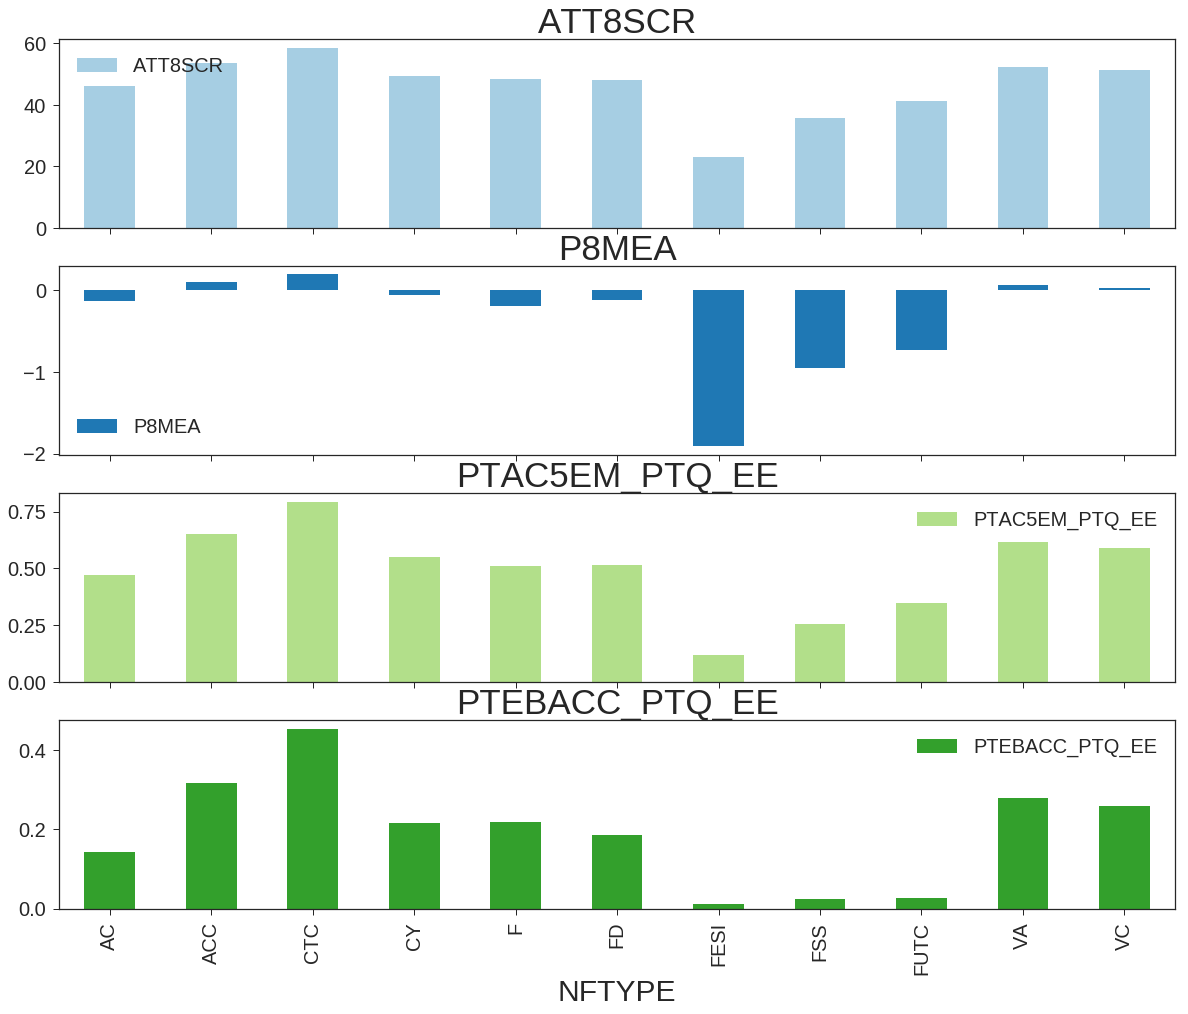

In [119]:
# visualise them quickly
grouped_df.plot(kind='bar', subplots=True)

Interesting there appears to be something of a pattern in these groupings.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe6e1114c88>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7fe6e207dcf8>], dtype=object)

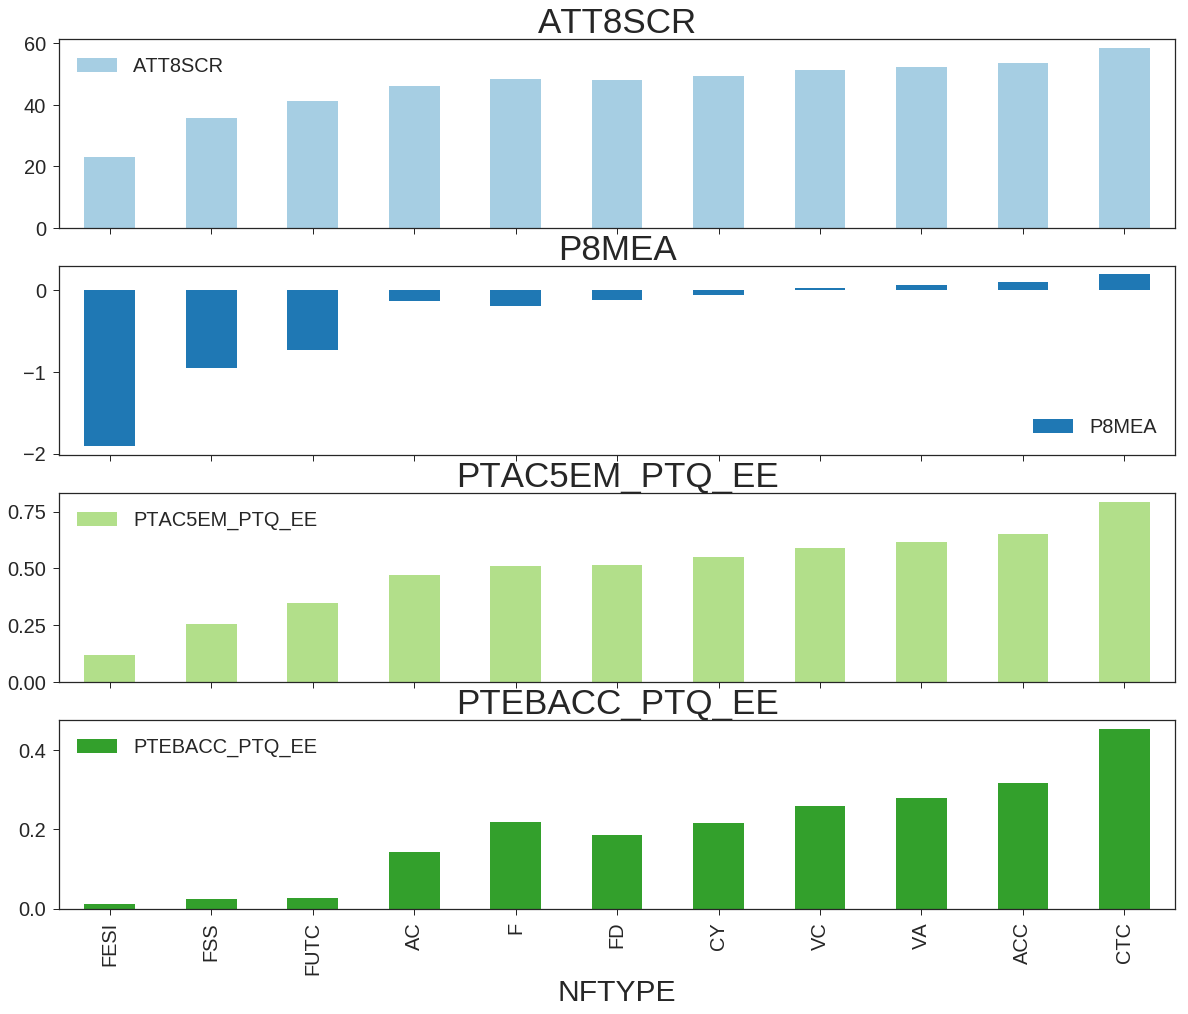

In [120]:
# sort the values to compare
grouped_df.sort_values('PTAC5EM_PTQ_EE').plot(kind='bar', subplots=True)

In [121]:
ks4_expanded_name['P8MEA']

'Progress 8 measure'

Let's tidy up these plots a little by adding human readable codes.  Changing percentages into 0-100 values.

In [122]:
# provide human readable codes
grouped_df.index = [nftypes[code] for code in grouped_df.index]

In [123]:
# make the percentages range from 0-100
grouped_df['PTAC5EM_PTQ_EE'] = grouped_df['PTAC5EM_PTQ_EE']*100
grouped_df['PTEBACC_PTQ_EE'] = grouped_df['PTEBACC_PTQ_EE']*100

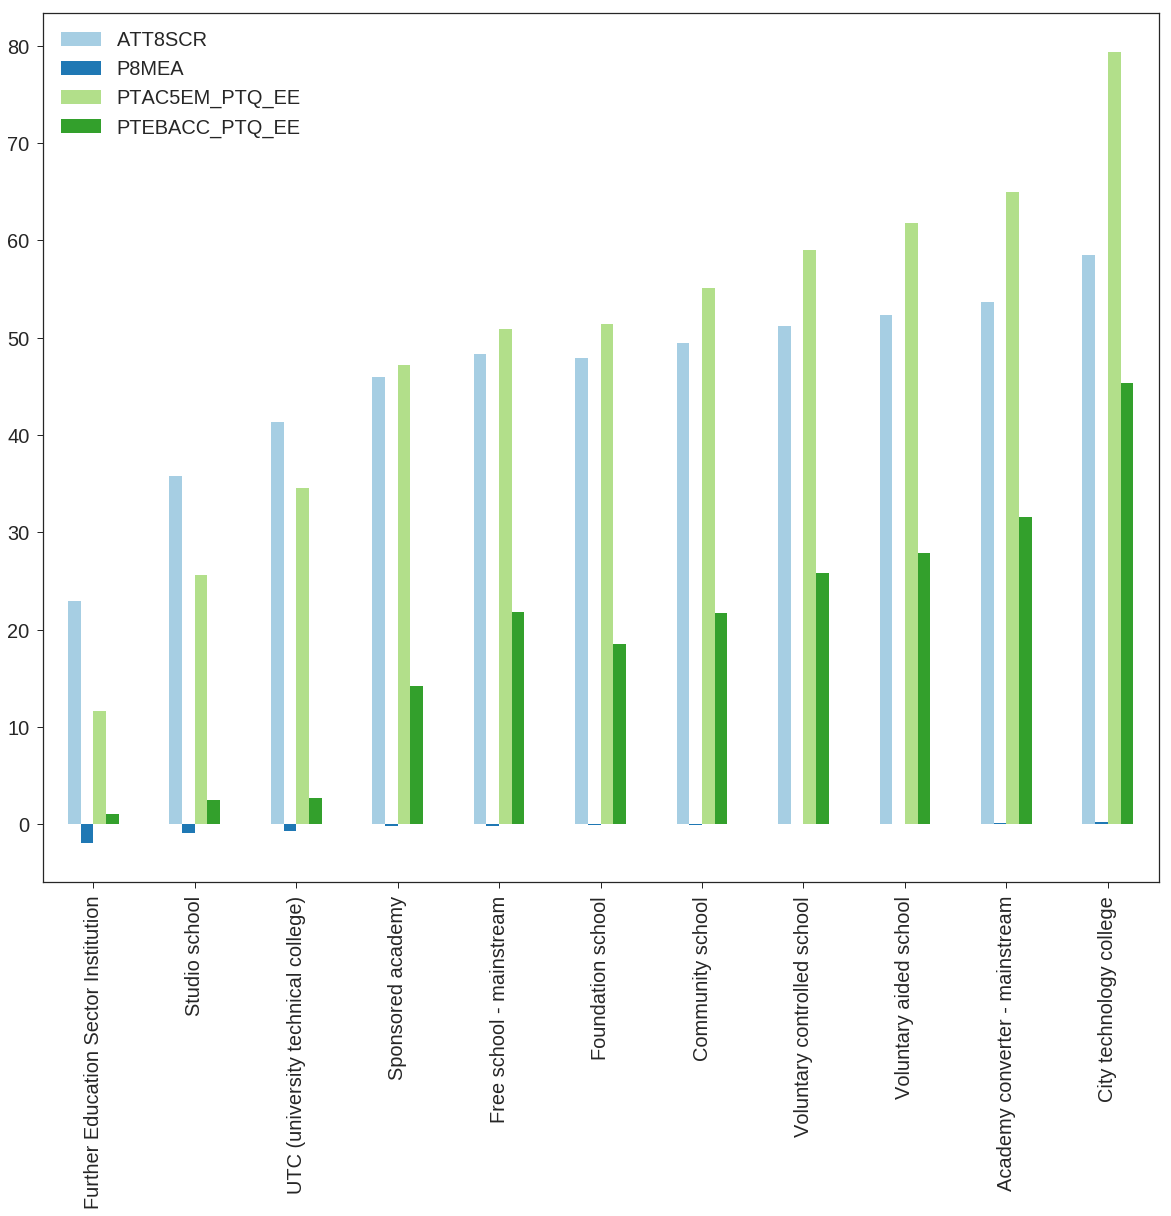

In [124]:
grouped_df.sort_values('PTAC5EM_PTQ_EE').plot(kind='bar')

There does appear to be a relationship between school type and the results acheived. using the three most common measures.  The mean values for the school type appears to relate to the other measures.

Lets see them in pairs to see how they compare.

## Plot of mean EBACC to GCSE performance by school type (%)

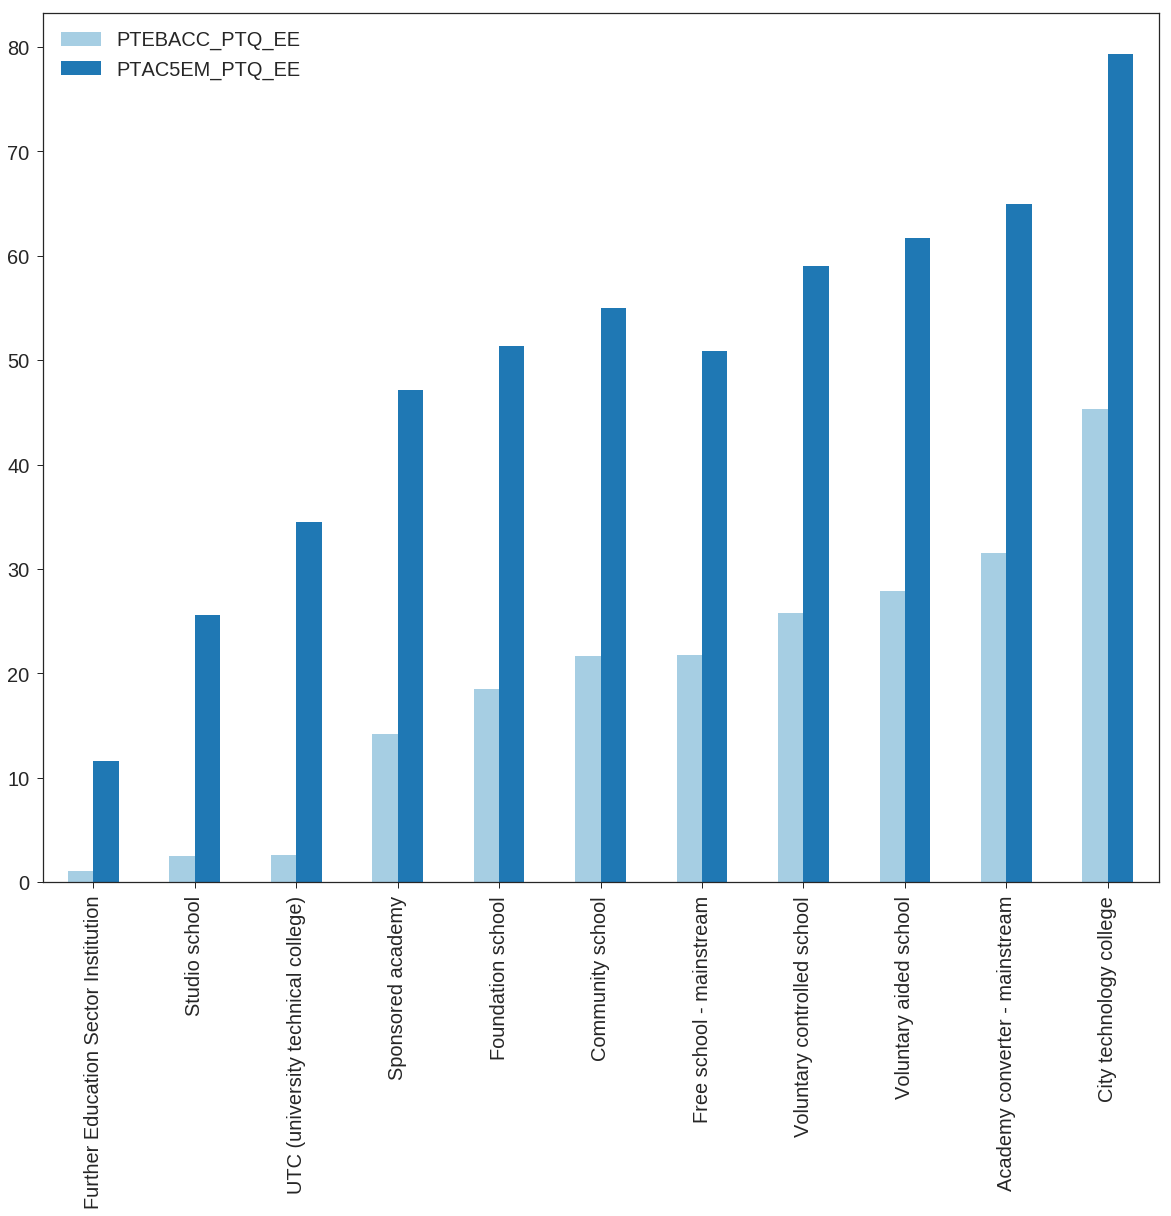

In [125]:
grouped_df[['PTEBACC_PTQ_EE', 'PTAC5EM_PTQ_EE']].sort_values('PTEBACC_PTQ_EE').plot(kind="bar")

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe6e0cb6978>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7fe6d9a775f8>], dtype=object)

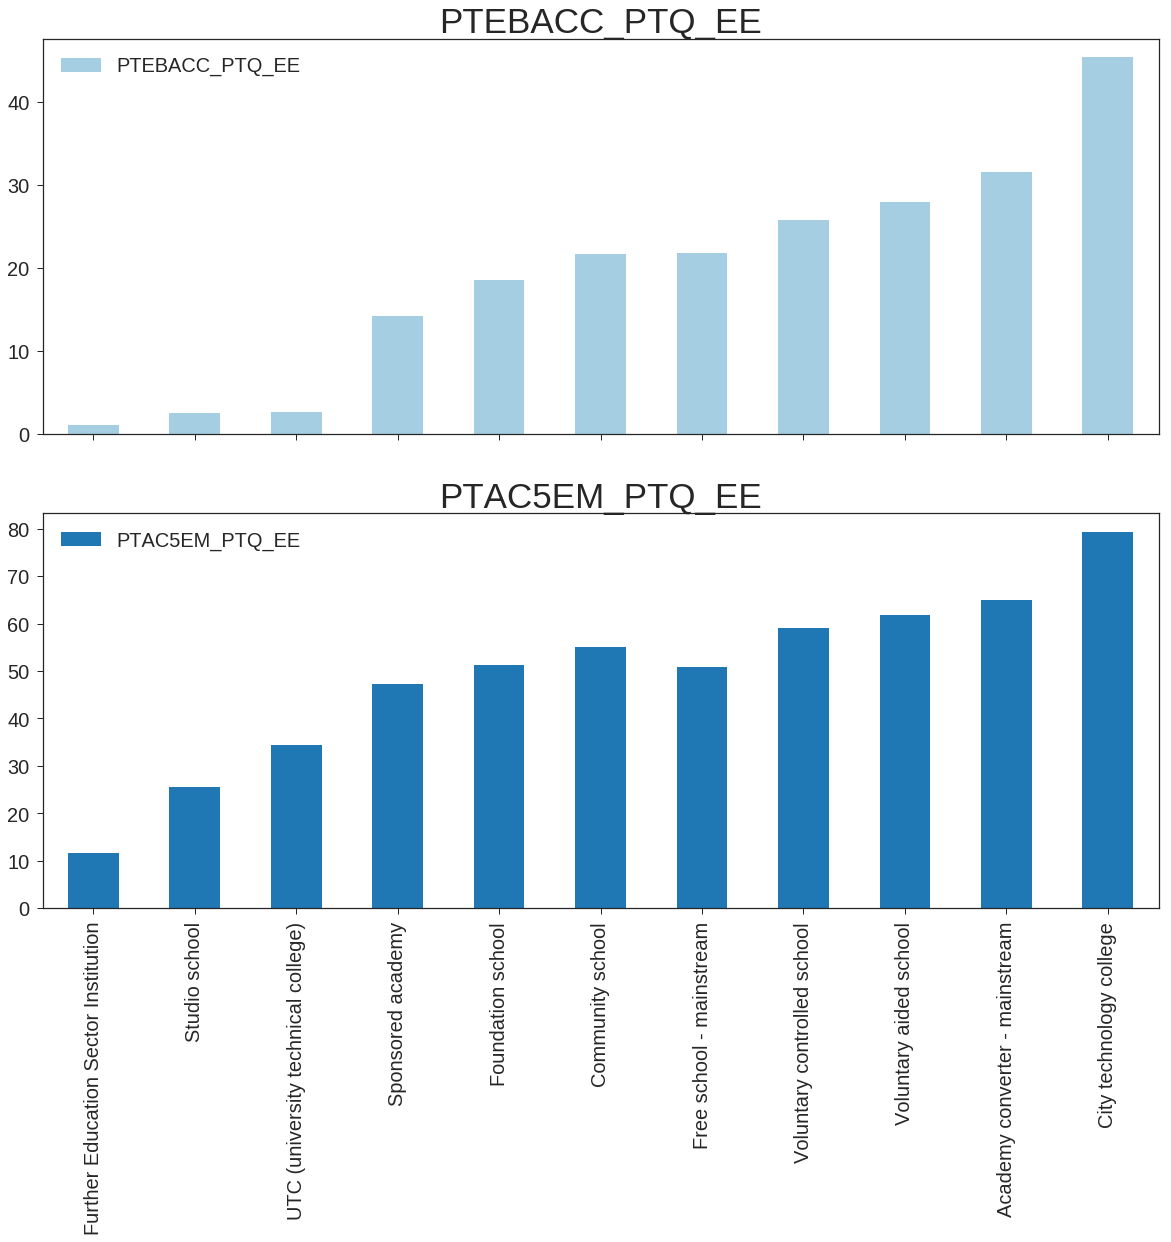

In [126]:
grouped_df[['PTEBACC_PTQ_EE', 'PTAC5EM_PTQ_EE']].sort_values('PTEBACC_PTQ_EE').plot(kind="bar", subplots=True)

There appears to be a link between EBacc and GCSE performance and the the school type.

## Plot of mean Attainment8 to Progress8 performance by school type

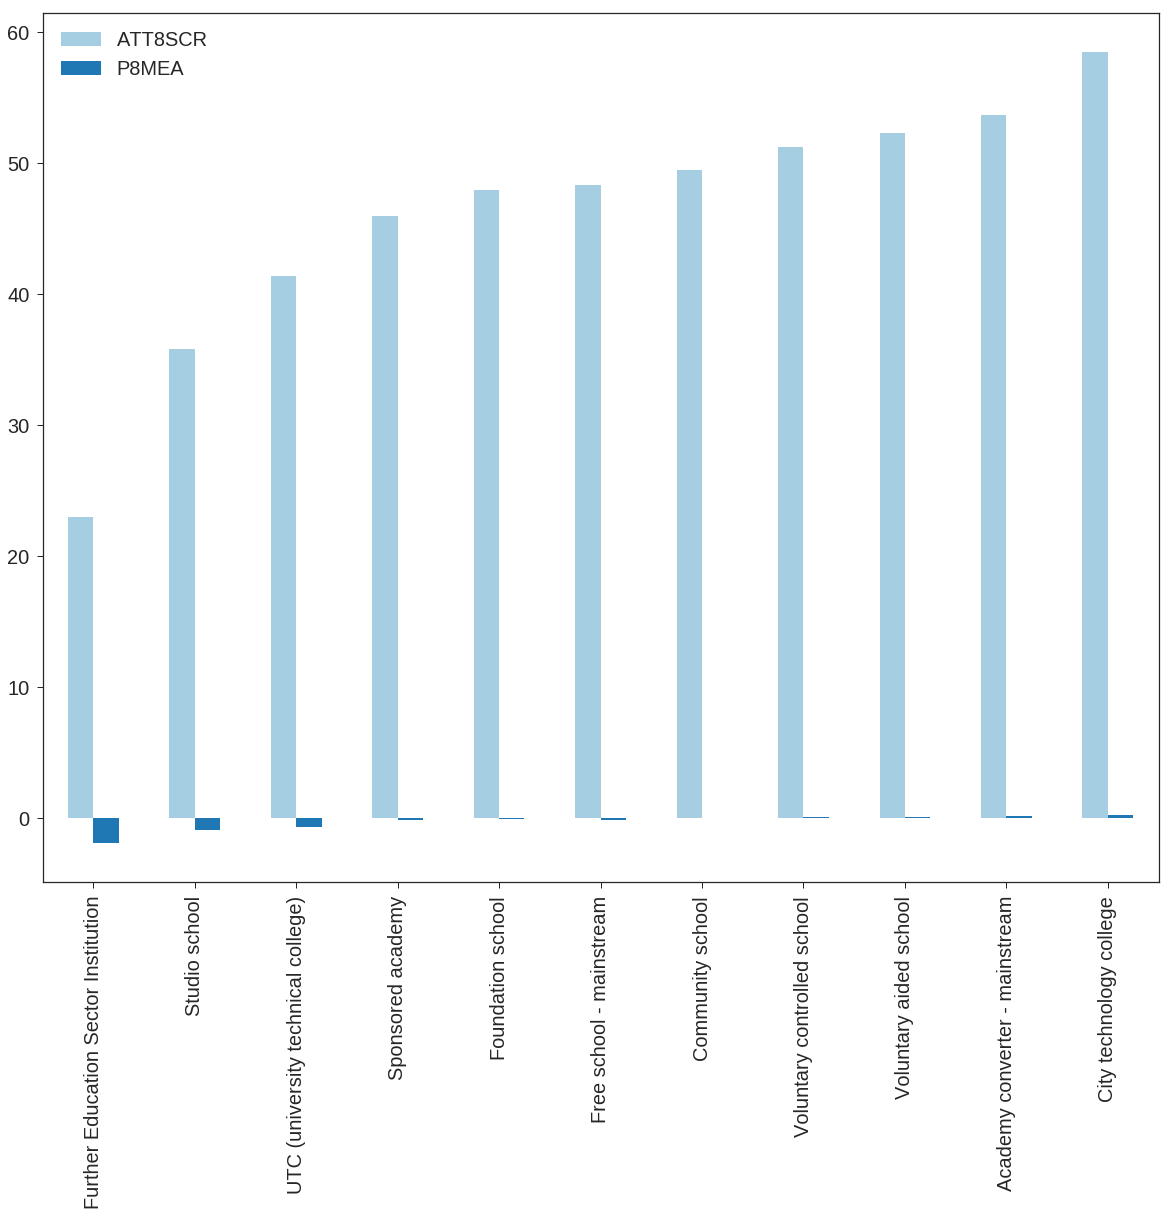

In [127]:
grouped_df[['ATT8SCR', 'P8MEA']].sort_values('ATT8SCR').plot(kind="bar")

this isn't that clear - I'll use subplots to show more clearly.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe6e1e0d5c0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7fe6d9c36160>], dtype=object)

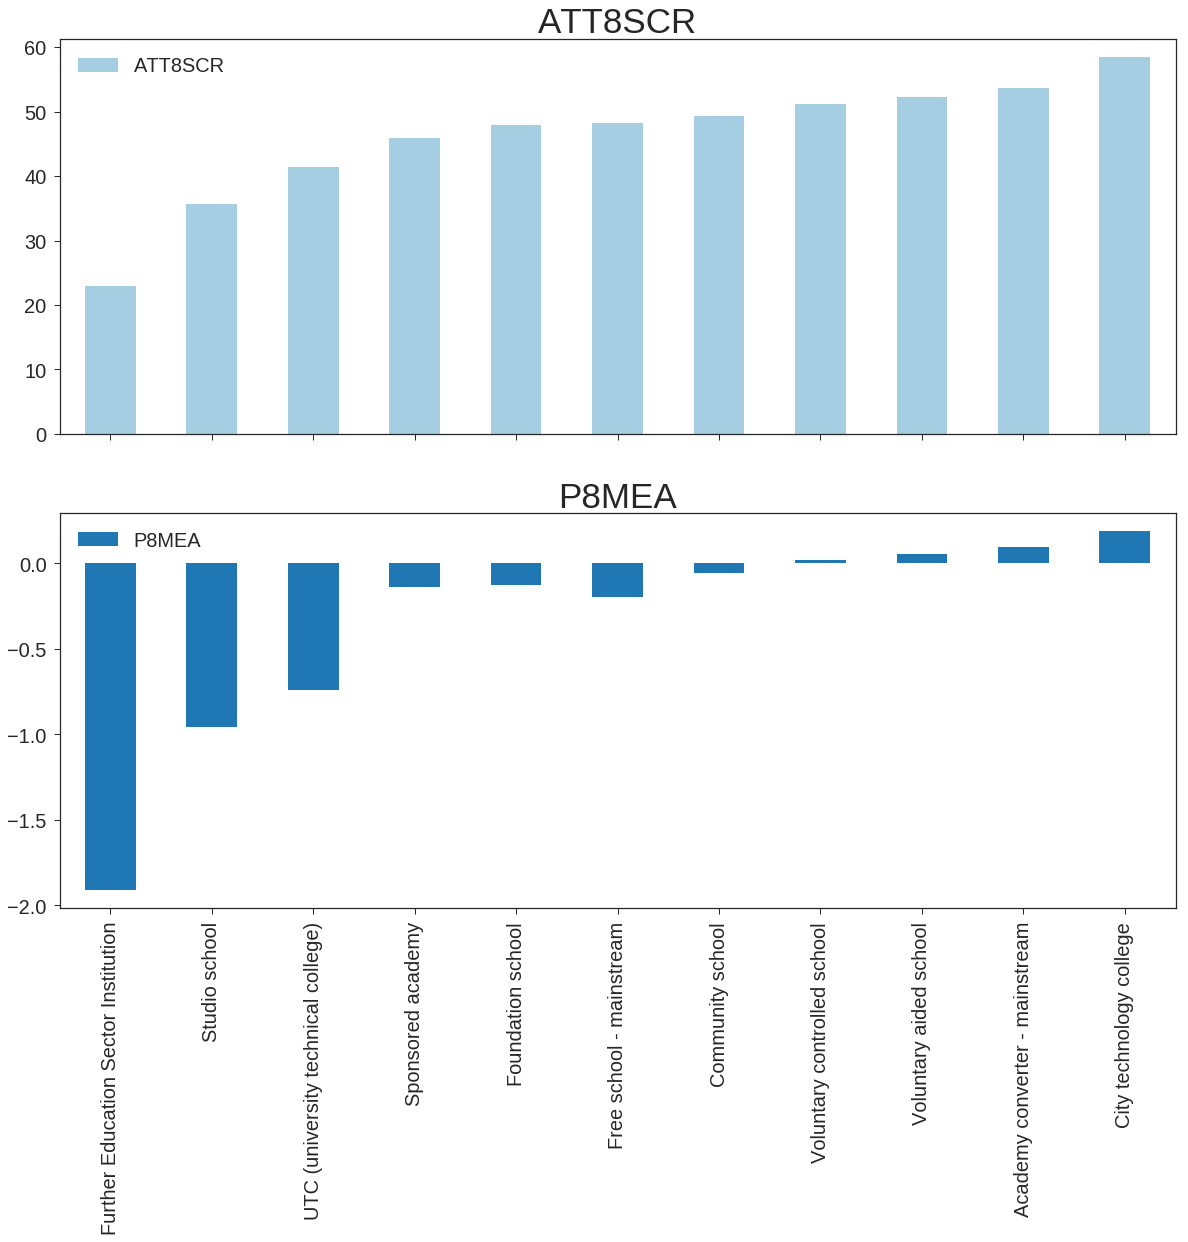

In [128]:
grouped_df[['ATT8SCR', 'P8MEA']].sort_values('ATT8SCR').plot(kind="bar", subplots=True)

In all of these cases there appears to be a pattern.  Let's get the top performers and low performers for each measure.

In [129]:
for c in grouped_df.columns:
    p = grouped_df[c].idxmax(), grouped_df[c].idxmin()
    print(c, ': ', ks4_expanded_name[c])
    print('Top school type: ', round(grouped_df.loc[p[0]][c], 2), p[0])
    print('Bottom school type', round(grouped_df.loc[p[1]][c], 2), p[1], '\n')

ATT8SCR :  Average Attainment 8 score per pupil
Top school type:  58.43 City technology college
Bottom school type 22.93 Further Education Sector Institution 

P8MEA :  Progress 8 measure
Top school type:  0.19 City technology college
Bottom school type -1.91 Further Education Sector Institution 

PTAC5EM_PTQ_EE :  Percentage of pupils achieving 5+ A*-C or equivalents including A*-C in both English and mathematics GCSEs
Top school type:  79.33 City technology college
Bottom school type 11.58 Further Education Sector Institution 

PTEBACC_PTQ_EE :  Percentage of key stage 4 pupils achieving the English Baccalaureate
Top school type:  45.33 City technology college
Bottom school type 1.08 Further Education Sector Institution 



Clearly by every measure considered _City Technology College_ are top and the _Further Education Sector Institutions_ are bottom.

## Double checking - accounting for the potential extra 0.0 values

In the data preparation phase we used the p2f function.  However, some of the values may have been set to 0 and could be skewing these analysis.  However, there are only a small number of values.  I will calculate the mean value of the column without them and replace the 0 with those and see whether it negatively impacts the results of the earlier findings.

I'll repeat the same steps without the 0.0 values that could be influenced by the import.  To compare.

In [130]:
# filter out the rows that could be effected
res = ks4_results_df[(ks4_results_df['PTAC5EM_PTQ_EE']!=0) & (ks4_results_df['PTEBACC_PTQ_EE']!=0)]

# group the data by school type
grouped_res = res[['NFTYPE', 'ATT8SCR', 'P8MEA', 'PTAC5EM_PTQ_EE', 'PTEBACC_PTQ_EE']].groupby(by='NFTYPE').mean()
grouped_gt0_df = pd.DataFrame(grouped_res)
grouped_gt0_df

ATT8SCR     P8MEA  PTAC5EM_PTQ_EE  PTEBACC_PTQ_EE
NFTYPE                                                     
AC      46.035101 -0.137733        0.473327        0.145539
ACC     53.682992  0.096454        0.650364        0.315862
CTC     58.433333  0.190000        0.793333        0.453333
CY      49.484398 -0.053722        0.552857        0.219060
F       49.862500 -0.105417        0.549583        0.245000
FD      48.011029 -0.118713        0.515515        0.187279
FESI    33.775000 -1.040000        0.255000        0.032500
FSS     46.150000 -0.282500        0.466250        0.093750
FUTC    45.891667 -0.551667        0.400000        0.057500
VA      52.285240  0.055424        0.617454        0.281107
VC      51.194118  0.022647        0.590000        0.257647

In [131]:
# make the percentages prettier (out of 100)
grouped_gt0_df['PTAC5EM_PTQ_EE'] = grouped_gt0_df['PTAC5EM_PTQ_EE']*100
grouped_gt0_df['PTEBACC_PTQ_EE'] = grouped_gt0_df['PTEBACC_PTQ_EE']*100

In [132]:
# provide human readable codes
grouped_gt0_df.index = [nftypes[code] for code in grouped_gt0_df.index]

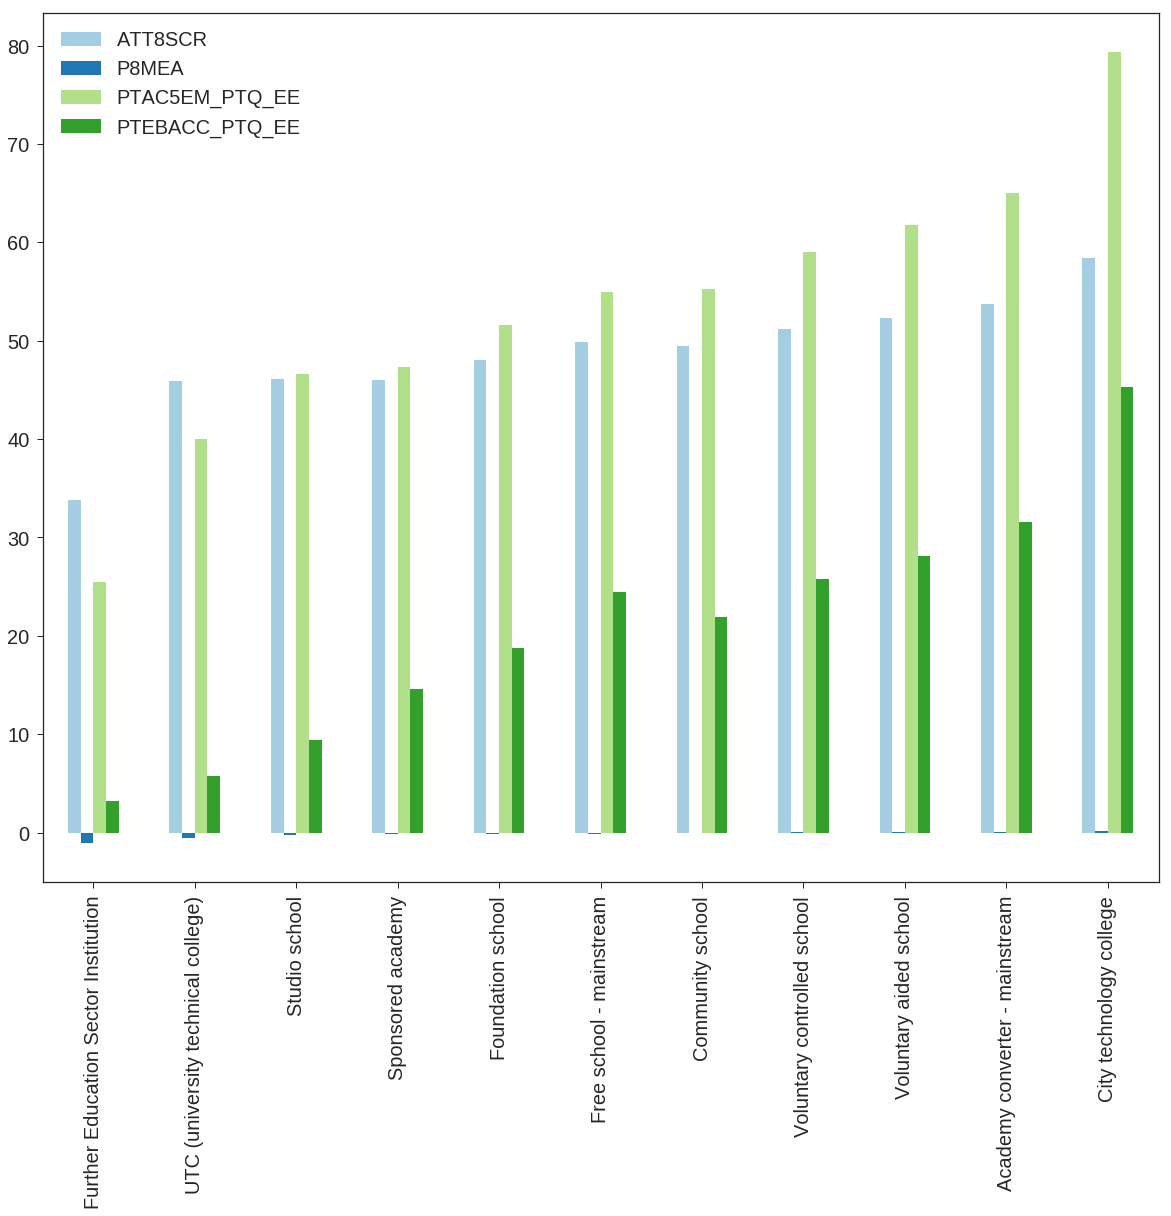

In [133]:
grouped_gt0_df.sort_values('P8MEA').plot(kind='bar')

## Plot of EBACC to GCSE performance by school type (%) non-0


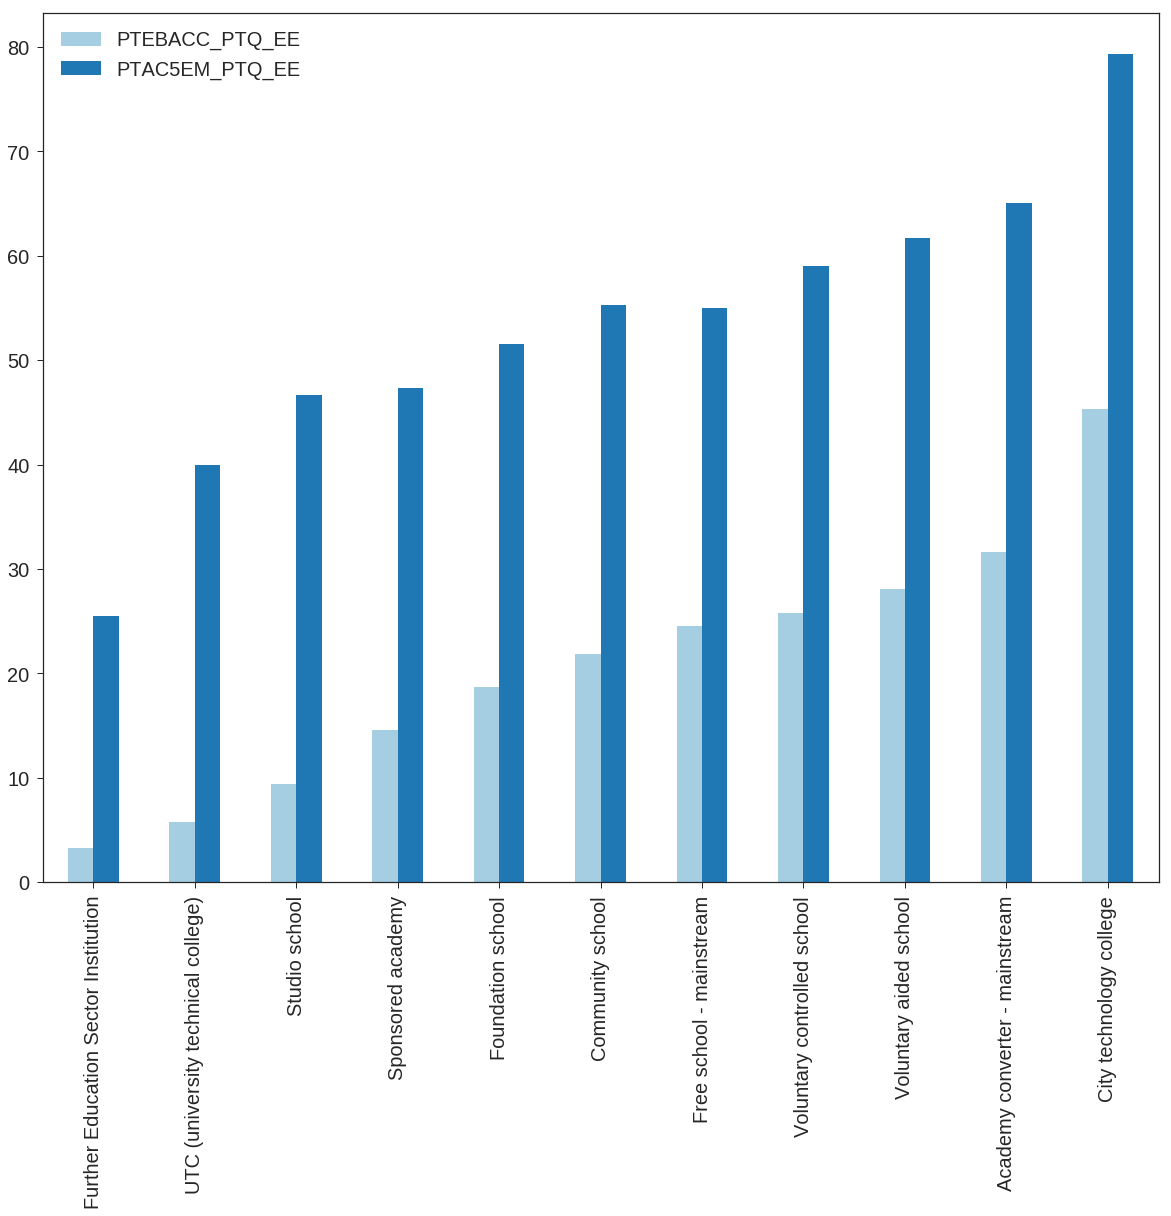

In [134]:
grouped_gt0_df[['PTEBACC_PTQ_EE', 'PTAC5EM_PTQ_EE']].sort_values('PTEBACC_PTQ_EE').plot(kind="bar")

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe6e19b94a8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7fe6e1e752b0>], dtype=object)

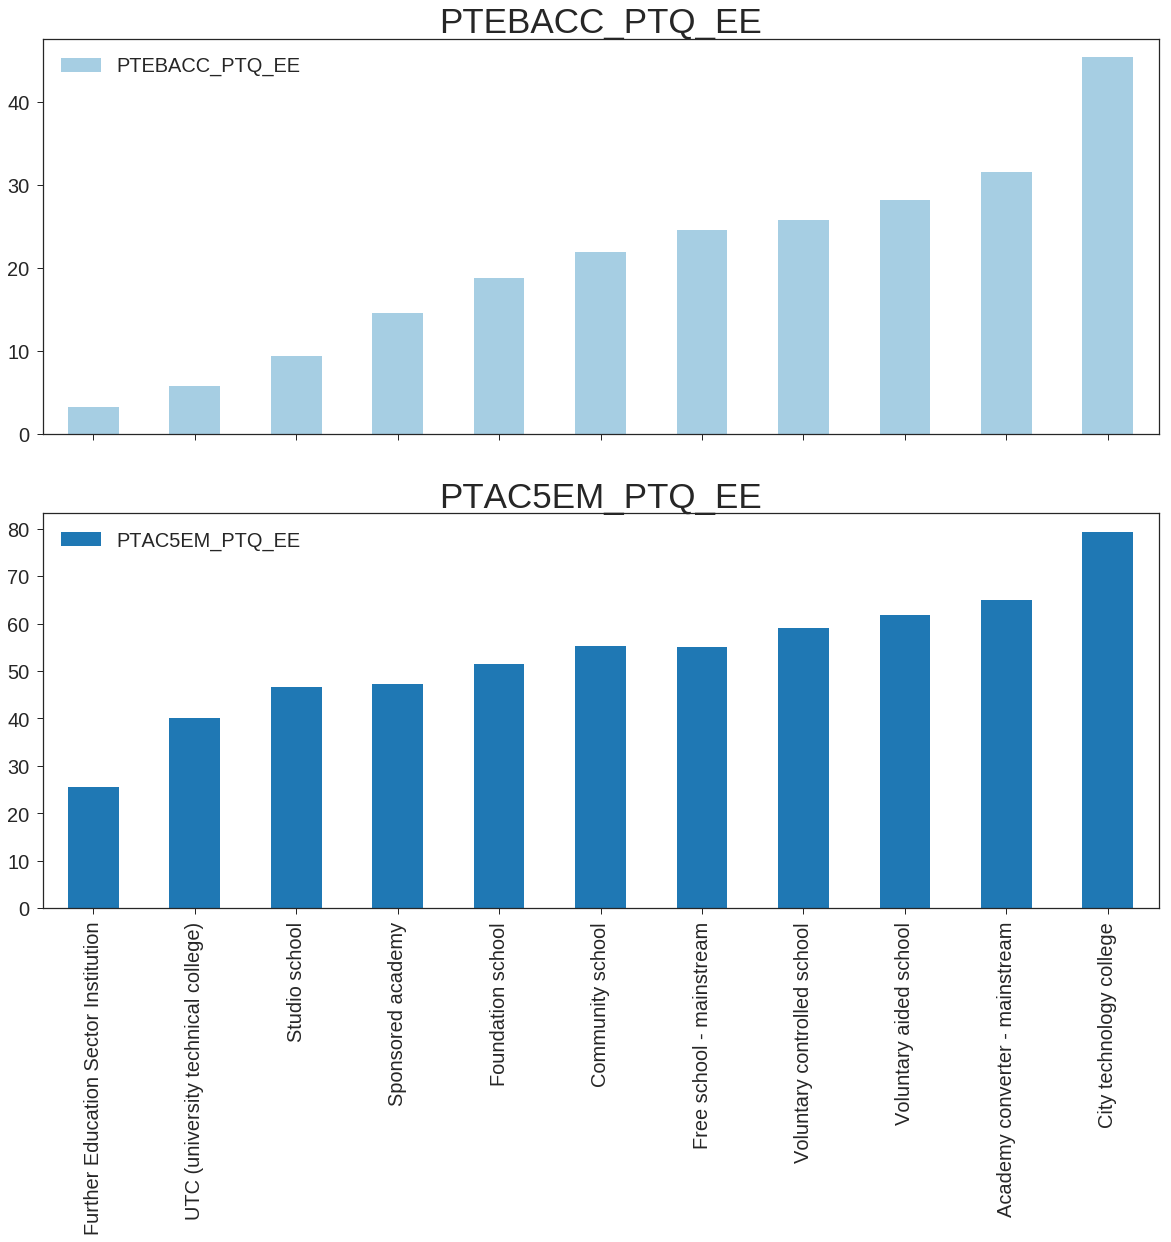

In [135]:
grouped_gt0_df[['PTEBACC_PTQ_EE', 'PTAC5EM_PTQ_EE']].sort_values('PTEBACC_PTQ_EE').plot(kind="bar", subplots=True)

There appears to be a link between EBacc and GCSE performance and the the school type.

## Plot of Attainment8 to Progress8 performance by school type ( non 0 )

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe6e1e9b0f0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7fe6e1e7d860>], dtype=object)

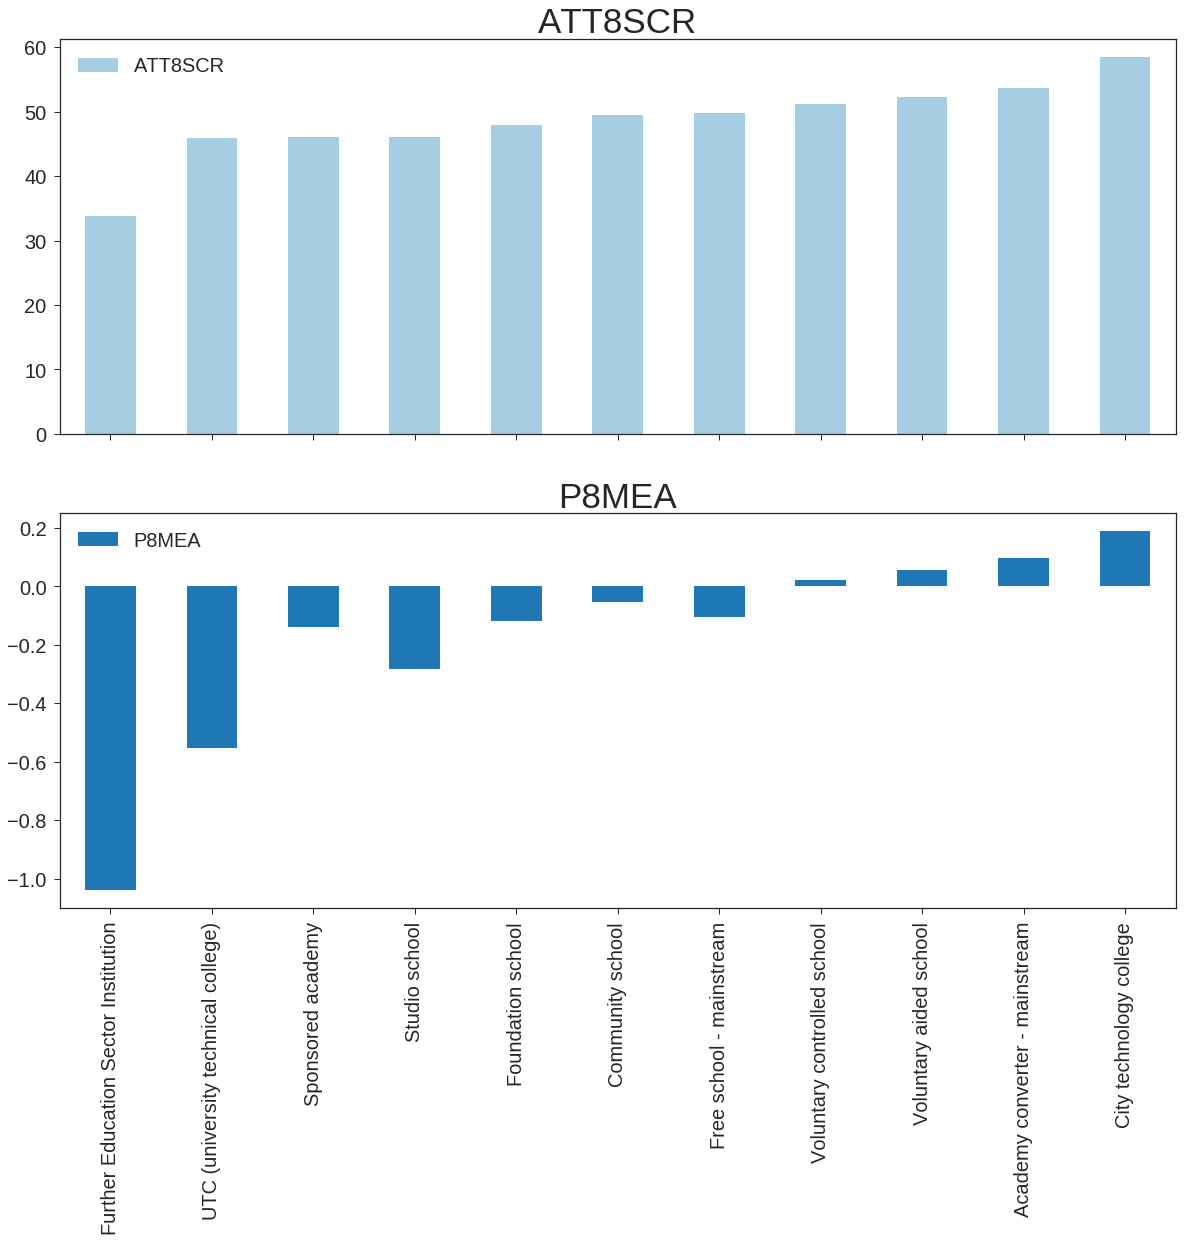

In [136]:
grouped_gt0_df[['ATT8SCR', 'P8MEA']].sort_values('ATT8SCR').plot(kind="bar", subplots=True)

In all of these cases there appears to be a pattern.  Let's get the top performers and low performers for each measure.

In [137]:
for c in grouped_gt0_df.columns:
    p = grouped_gt0_df[c].idxmax(), grouped_gt0_df[c].idxmin()
    print(c, ': ', ks4_expanded_name[c])
    print('Top school type: ', round(grouped_gt0_df.loc[p[0]][c], 2), p[0])
    print('Bottom school type', round(grouped_gt0_df.loc[p[1]][c], 2), p[1], '\n')

ATT8SCR :  Average Attainment 8 score per pupil
Top school type:  58.43 City technology college
Bottom school type 33.78 Further Education Sector Institution 

P8MEA :  Progress 8 measure
Top school type:  0.19 City technology college
Bottom school type -1.04 Further Education Sector Institution 

PTAC5EM_PTQ_EE :  Percentage of pupils achieving 5+ A*-C or equivalents including A*-C in both English and mathematics GCSEs
Top school type:  79.33 City technology college
Bottom school type 25.5 Further Education Sector Institution 

PTEBACC_PTQ_EE :  Percentage of key stage 4 pupils achieving the English Baccalaureate
Top school type:  45.33 City technology college
Bottom school type 3.25 Further Education Sector Institution 



So even after adjusting for those measures that aren't 0, for the small number that potentially got added.  The underlying results have not been effected.

However these findings are based on mean grouped values.  To get more clarity the next step is to use machine machine learning to cluster the ungrouped data and then look at each cluster group to see the distributions of school types in each group. 

There does appear to be a some kind of link between the type of school and the results of both English Baccalaurete and the older 5+A*-C GCSEs.

The correlation between 5+A*-C and the EBacc makes sense because to acheive an eBacc is across a variety of subjects including Maths, English, Sciences, language and history or geography.  Naturally, there will be a correlation between the two.

<a name='machine_learning'></a>

# Machine Learning

<a name="grouped_cluster"></a>

# Grouped data Cluster analysis

Let's start by looking at the scatter of some of these different measures.

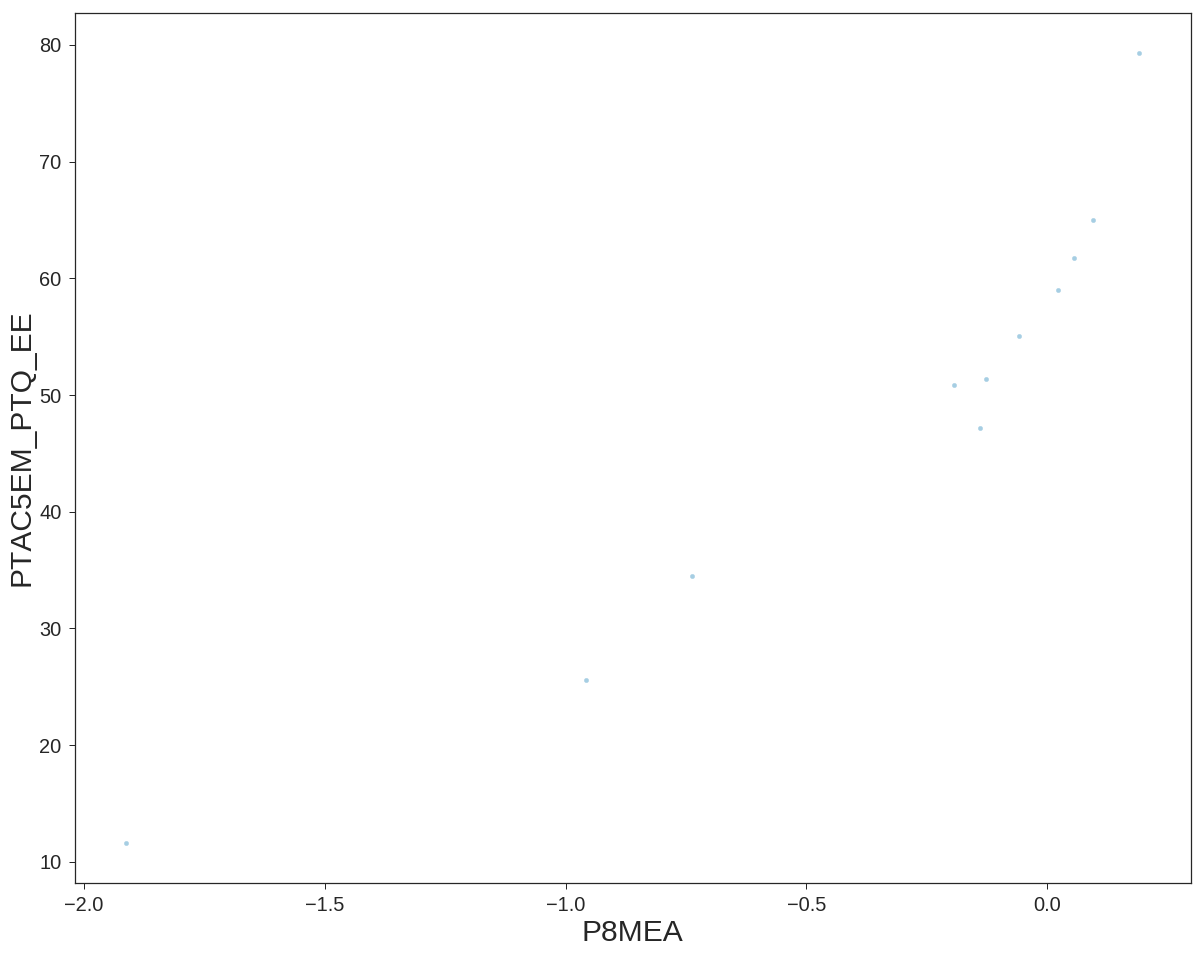

In [138]:
# Progress 8 and GCSE results (5+ A*-C)
grouped_df.plot(kind='scatter', x='P8MEA', y='PTAC5EM_PTQ_EE')

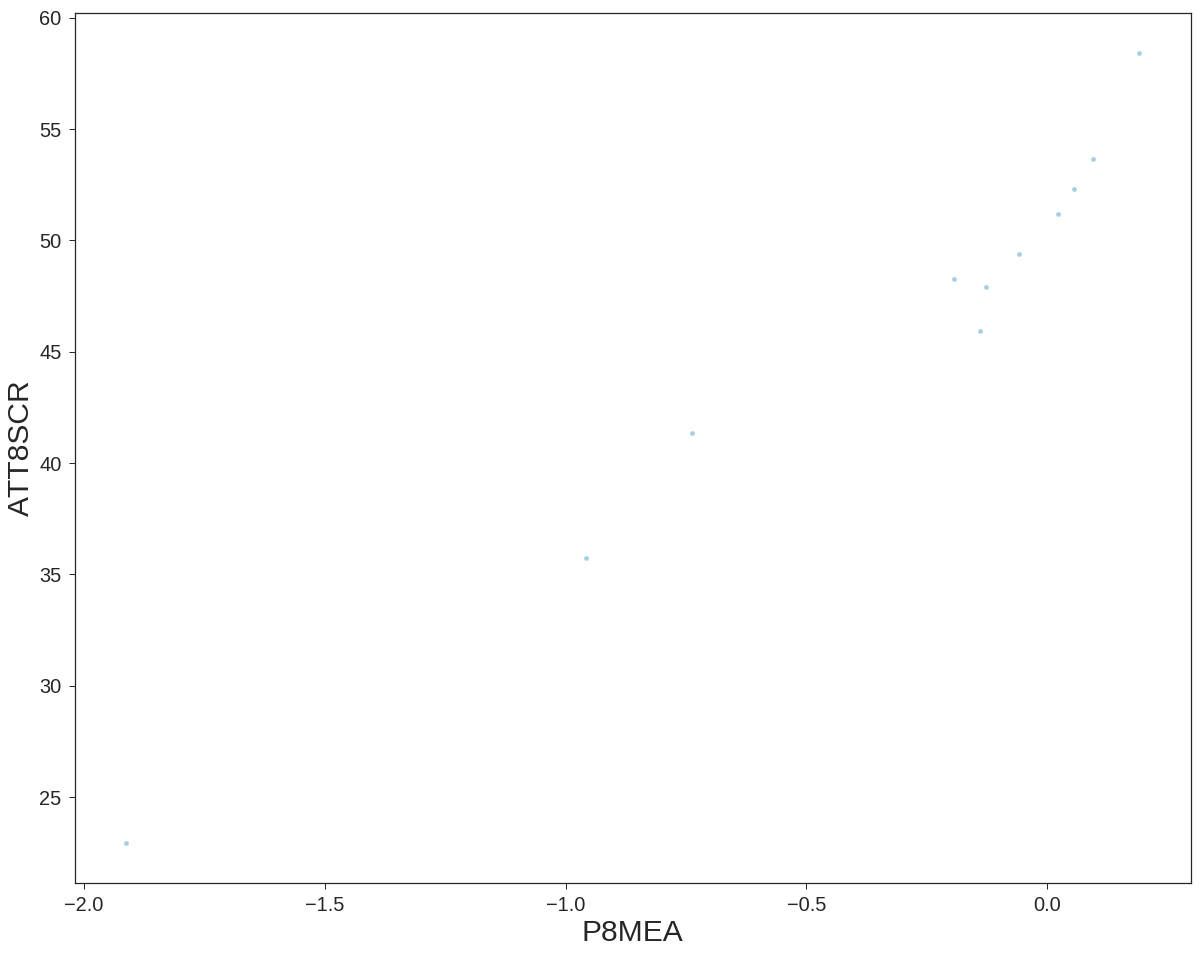

In [139]:
# Progress 8 and ATT8SCR
grouped_df.plot(kind='scatter', x='P8MEA', y='ATT8SCR')

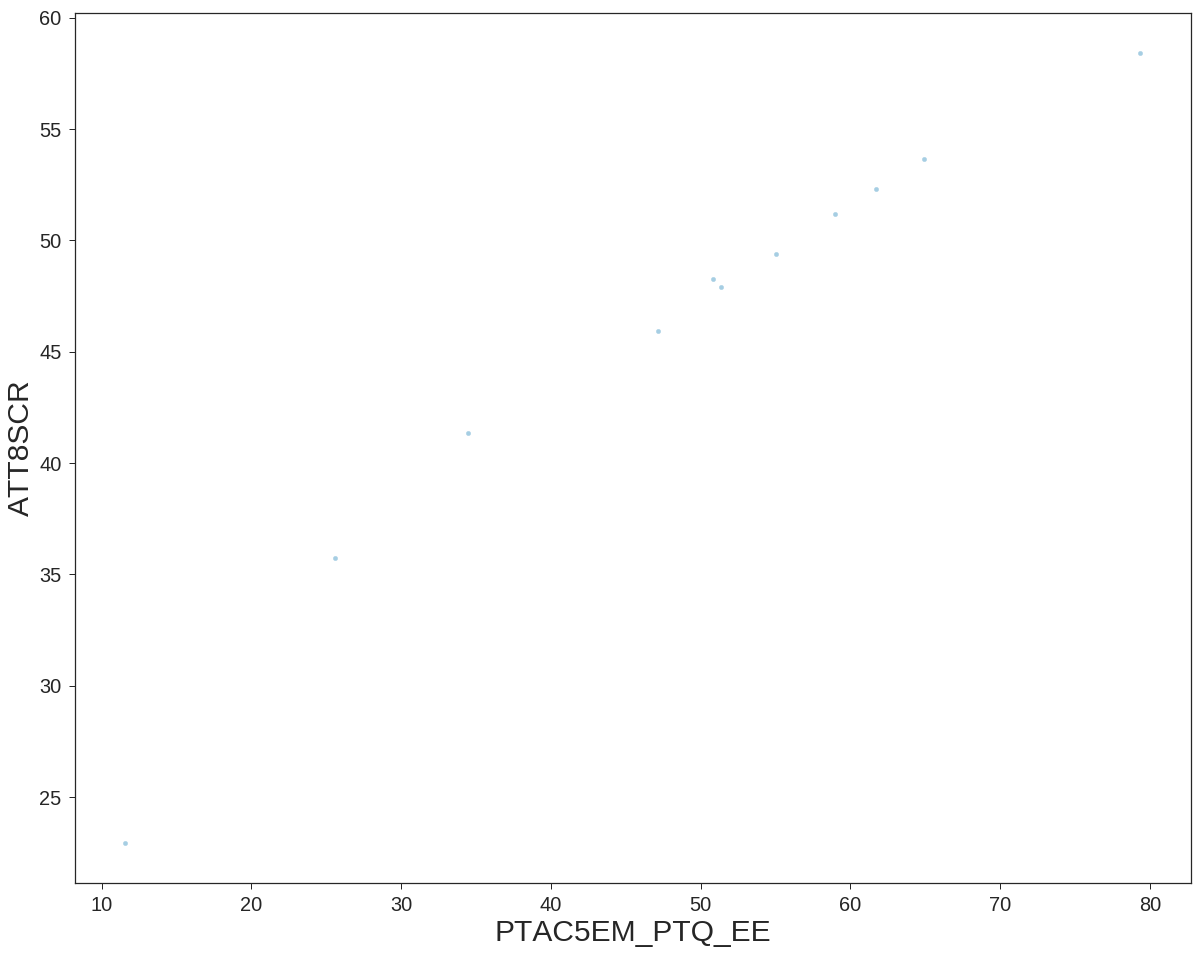

In [140]:
# GCSE and ATT8SCR
grouped_df.plot(kind='scatter', x='PTAC5EM_PTQ_EE', y='ATT8SCR')

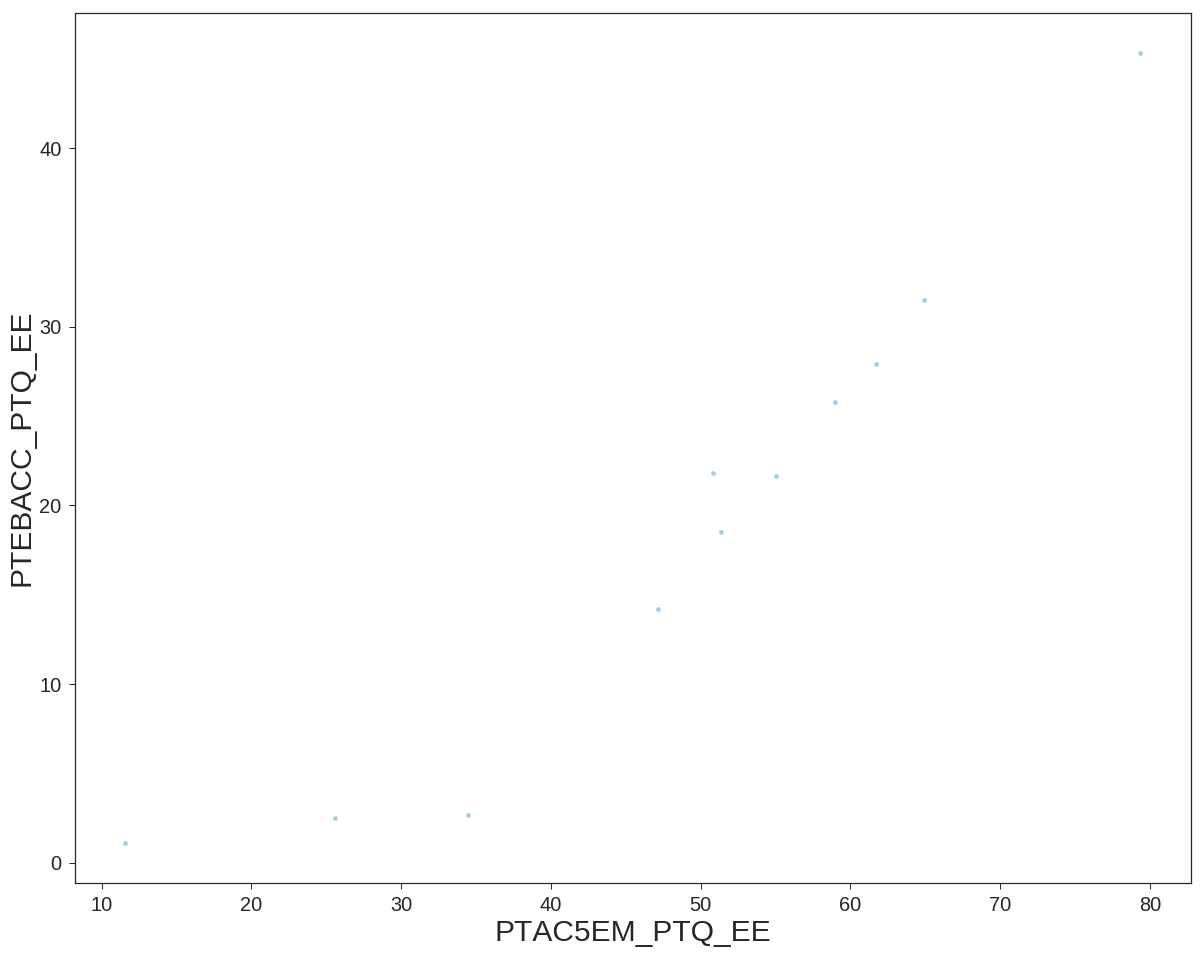

In [141]:
# GCSE and EBACC results
grouped_df.plot(kind='scatter', x='PTAC5EM_PTQ_EE', y='PTEBACC_PTQ_EE')

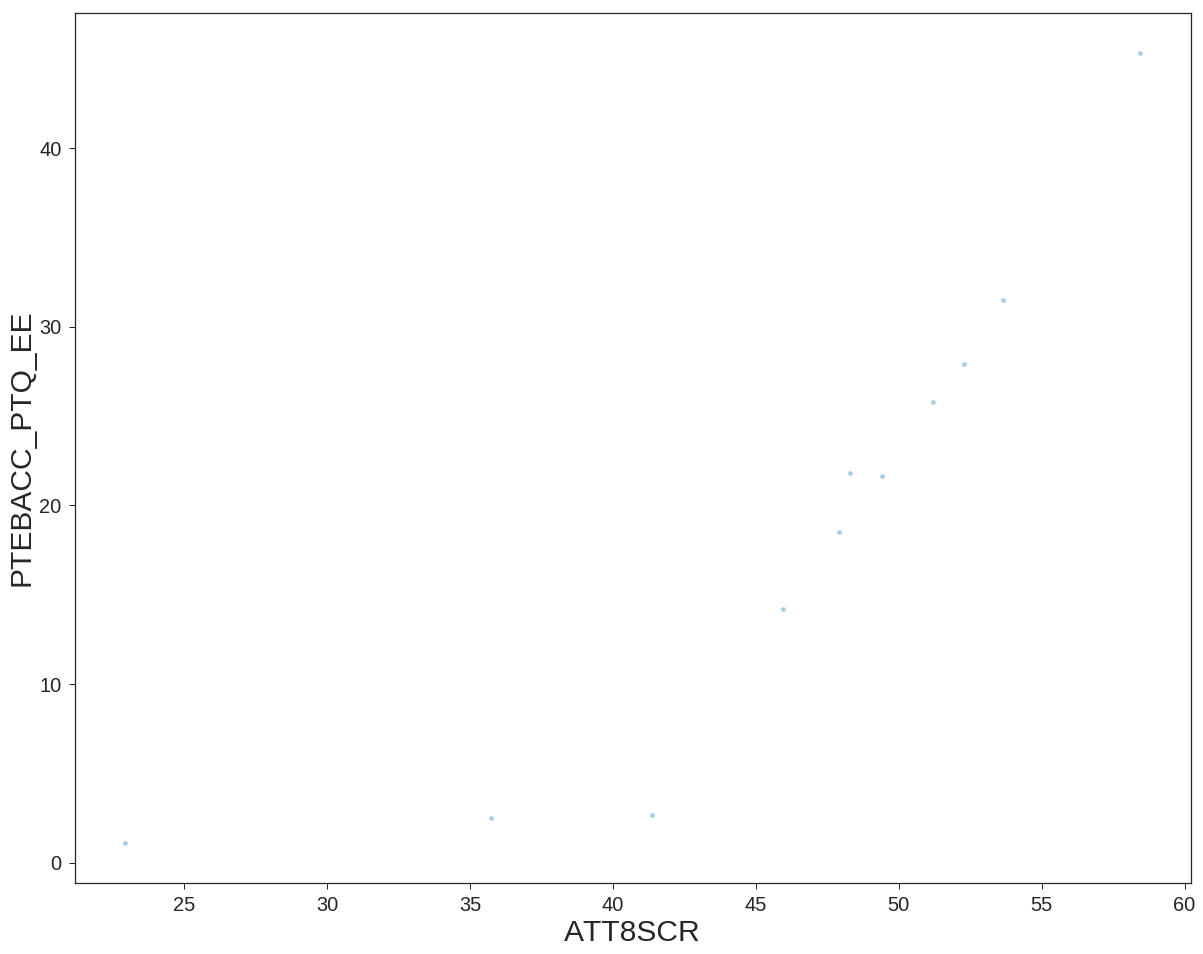

In [142]:
# Attainment 8 and EBACC results
grouped_df.plot(kind='scatter', x='ATT8SCR', y='PTEBACC_PTQ_EE')

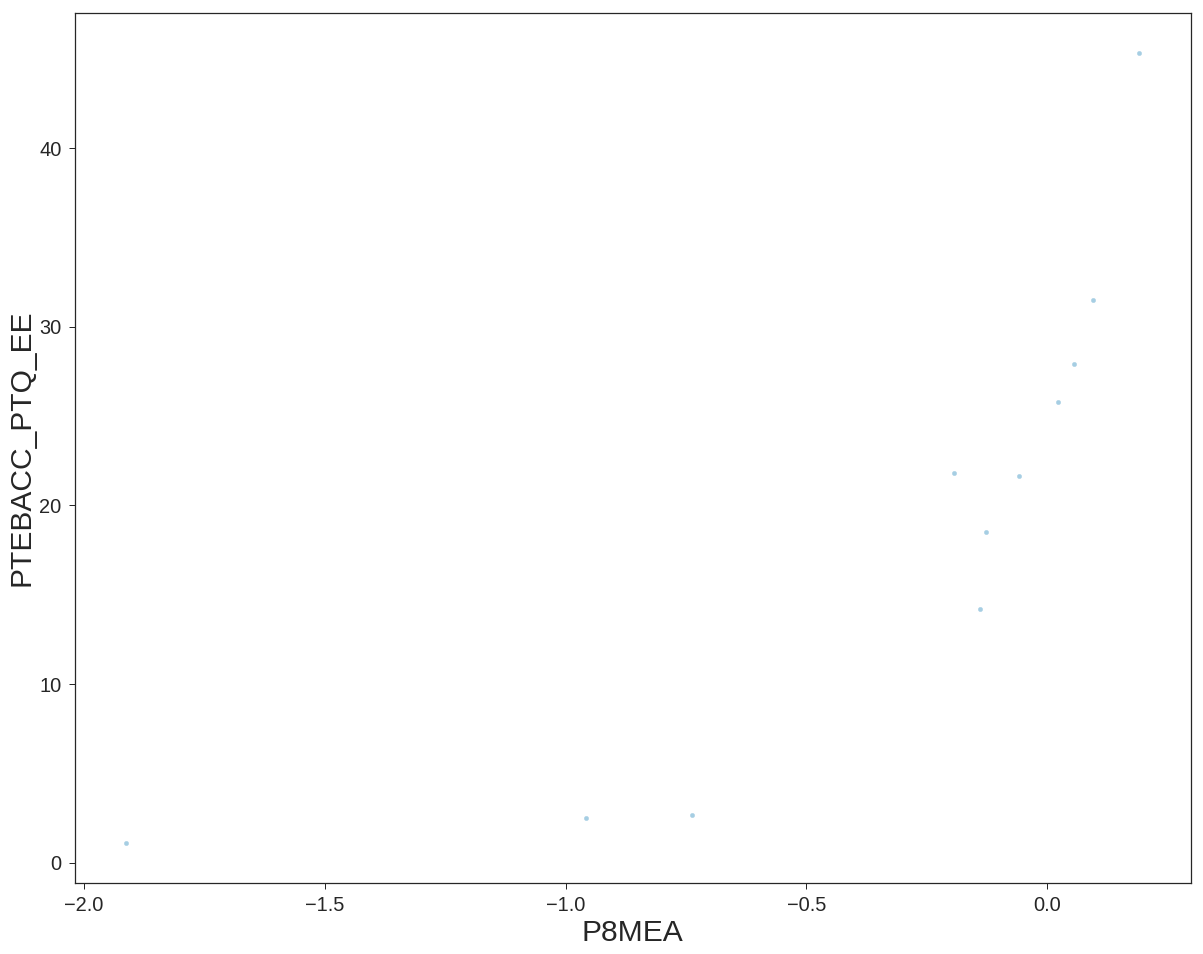

In [143]:
# Progress 8 and EBACC results
grouped_df.plot(kind='scatter', x='P8MEA', y='PTEBACC_PTQ_EE')

For the rest of this investigation I will narrow down the focus of performance measures to a combination of P8 measure and the GCSE.  I have chosen these two because:
 - Progress 8 - students progress is measured in comparison to other students across the country of similar starting ability, thus it is a good measure for comparing schools
 - 5+A*-C GCSE inc. Math&Eng - despite being an older measure it is still widely used and understood by everyone.

To start with I'll follow the steps in the module materials p21.1

### initial values for k = 2


In [144]:
initialCentroids_df = pd.DataFrame({'P8MEA': [-0.5, 0], 
                                    'PTAC5EM_PTQ_EE': [18, 30]}, 
                                   columns=['P8MEA', 'PTAC5EM_PTQ_EE'])

initialCentroids_df

P8MEA  PTAC5EM_PTQ_EE
0   -0.5              18
1    0.0              30

and plot these on a scatter plot with the data points:

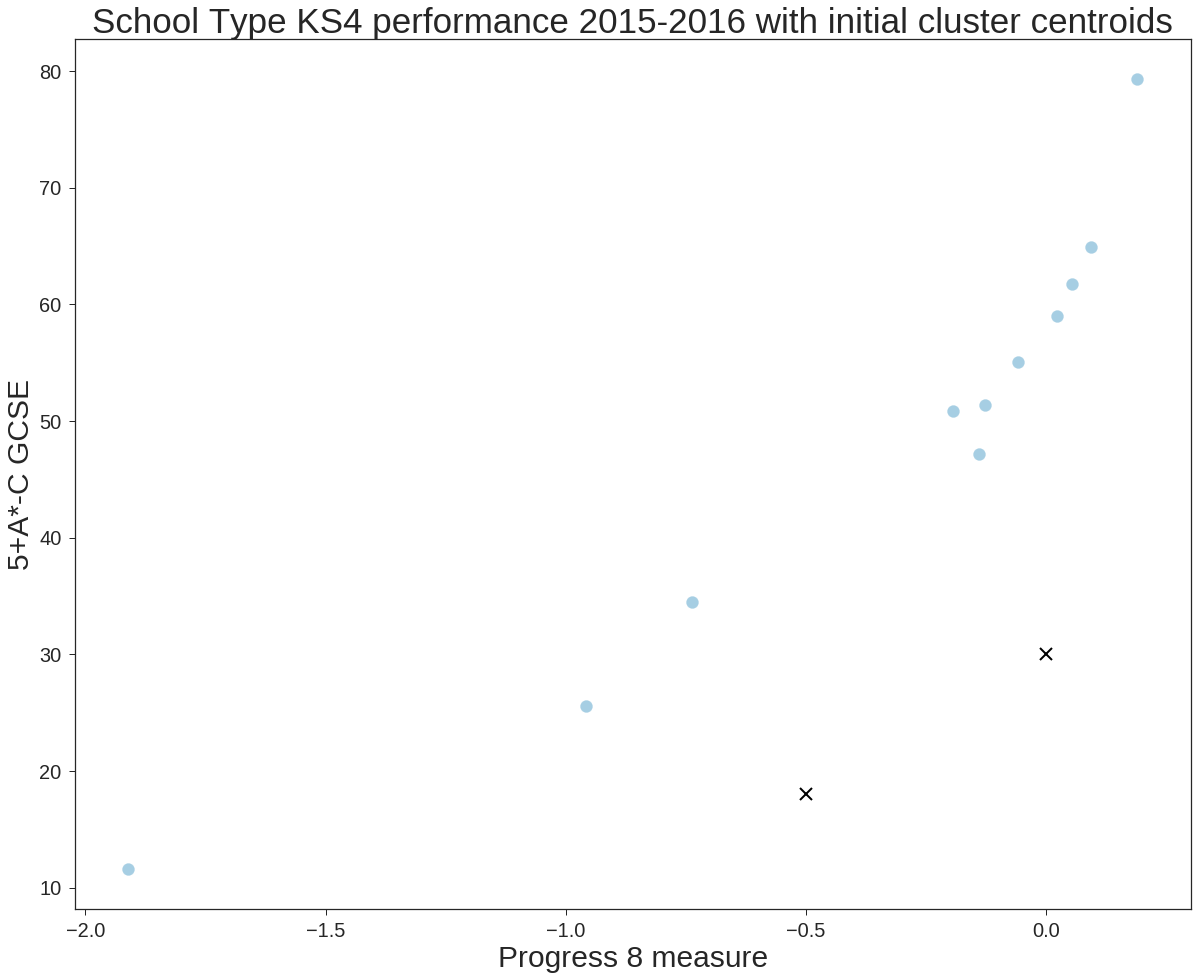

In [145]:
plt.scatter(grouped_df['P8MEA'], grouped_df['PTAC5EM_PTQ_EE'])

plt.xlabel('Progress 8 measure')
plt.ylabel('5+A*-C GCSE')

plt.title('School Type KS4 performance 2015-2016 with initial cluster centroids')

# Plot the initial centroids:
for i in initialCentroids_df.index:
    plt.plot(initialCentroids_df.iloc[i]['P8MEA'],
             initialCentroids_df.iloc[i]['PTAC5EM_PTQ_EE'],
             color='black', marker='x', mew=2)

In [146]:
# initialise the clustering object
kmeans2 = cluster.KMeans(n_clusters=2,
                         init=initialCentroids_df)

In [147]:
# fit the object to the data
assignedClusters_clust = kmeans2.fit(grouped_df[['P8MEA', 'PTAC5EM_PTQ_EE']])
assignedClusters_clust.labels_

/usr/local/lib/python3.5/dist-packages/sklearn/cluster/k_means_.py:889: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


array([1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1], dtype=int32)

... and plot the clustered data along with the final centroids:

[]

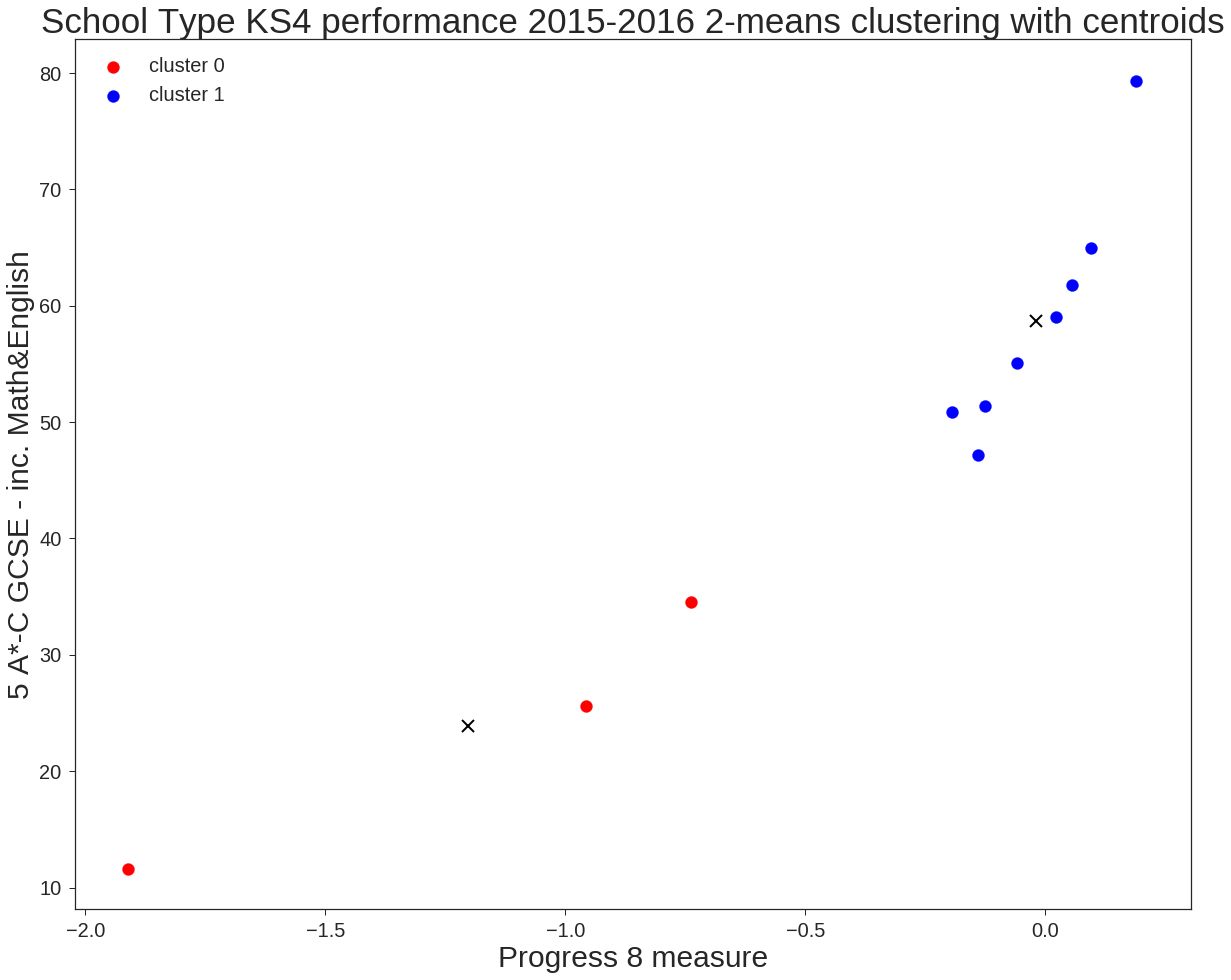

In [148]:
# Plot the data points which is in the cluster labelled '0'
plt.scatter(grouped_df['P8MEA'][assignedClusters_clust.labels_==0],
            grouped_df['PTAC5EM_PTQ_EE'][assignedClusters_clust.labels_==0],
            color='red', marker='o', label='cluster 0')

# Plot the data points which is in the cluster labelled '1'
plt.scatter(grouped_df['P8MEA'][assignedClusters_clust.labels_==1],
            grouped_df['PTAC5EM_PTQ_EE'][assignedClusters_clust.labels_==1],
            color='blue', marker='o', label='cluster 1')

# plot each of the centroids:
for (cx, cy) in assignedClusters_clust.cluster_centers_:
    plt.plot(cx, cy, color='black', marker='x', mew=2)
    
plt.legend()

plt.xlabel('Progress 8 measure')
plt.ylabel('5 A*-C GCSE - inc. Math&English')

plt.title('School Type KS4 performance 2015-2016 2-means clustering with centroids')

plt.plot()


## K-means = 4

To make generating centroids quicker I'll make a quick function to speed up the process for me

In [149]:
import random
# set the seed so that enterpretation of analysis is consitent on each run.
random.seed(283)

In [150]:
# helper function to quickly generate a dataframe 
# of a given number of random centroidsto speeg
def random_centroids(df, x_col, y_col, num_centroids):
    
    # determine the ranges of the data
    x_range = [min(df[x_col]), max(df[y_col])]
    y_range = [min(df[x_col]), max(df[y_col])]
    
    # generate make a collection to store
    centroids = collections.defaultdict(list)
    
    # generate the random values 
    for i in range(num_centroids):
        centroids['X'].append(random.uniform(min(x_range), max(x_range)))
        centroids['Y'].append(random.uniform(min(y_range), max(y_range)))
    
    # return as a dataframe
    return pd.DataFrame(centroids)

In [151]:
initial_centroids = random_centroids(grouped_df, 'P8MEA', 'PTAC5EM_PTQ_EE', 4)

In [152]:
initial_centroids

X          Y
0  56.981421   9.182774
1  41.030418  19.455012
2  66.645520  75.918501
3  49.010185  33.346565

In [153]:
# create a k-means 4 cluster
kmeans4 = cluster.KMeans(n_clusters=4, init=initial_centroids)

In [154]:
# fit the cluster object to the data
assigned_clust = kmeans4.fit(grouped_df[['P8MEA', 'PTAC5EM_PTQ_EE']])

/usr/local/lib/python3.5/dist-packages/sklearn/cluster/k_means_.py:889: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


In [155]:
# Helper function to plot clustering results, 
# colors do not need to be set unless num is greater than 6
def plot_cluster(data_x, data_y, assigned_clust, k, 
                 cluster_labels=None, plt_labels=None, 
                 plt_title=None, colors=None, save=False):
    # set default colors
    if colors==None:
        colors = sns.palettes.color_palette(n_colors=k)
    # set default labels
    if cluster_labels==None:
        cluster_labels = range(k)
    
    plt.figure()
    # plot the cluster group    
    for c in range(k):
        plt.scatter(data_x[assigned_clust.labels_==c],
                    data_y[assigned_clust.labels_==c],
                    color=colors[c], marker='o', label=cluster_labels[c]
                   )
        
    # plot the centroids
    for (cx, cy) in assigned_clust.cluster_centers_:
        plt.plot(cx, cy, color='black', marker='x', mew=1)
    
    # prettify it
    plt.legend()
    
    plt.xlabel(plt_labels[0])
    plt.ylabel(plt_labels[1])
        
    plt.title(plt_title)
    
    # save it out if wanted
    if save:
        plt.savefig('plot_images/cluster '+ plt_title + ' k='+str(k))

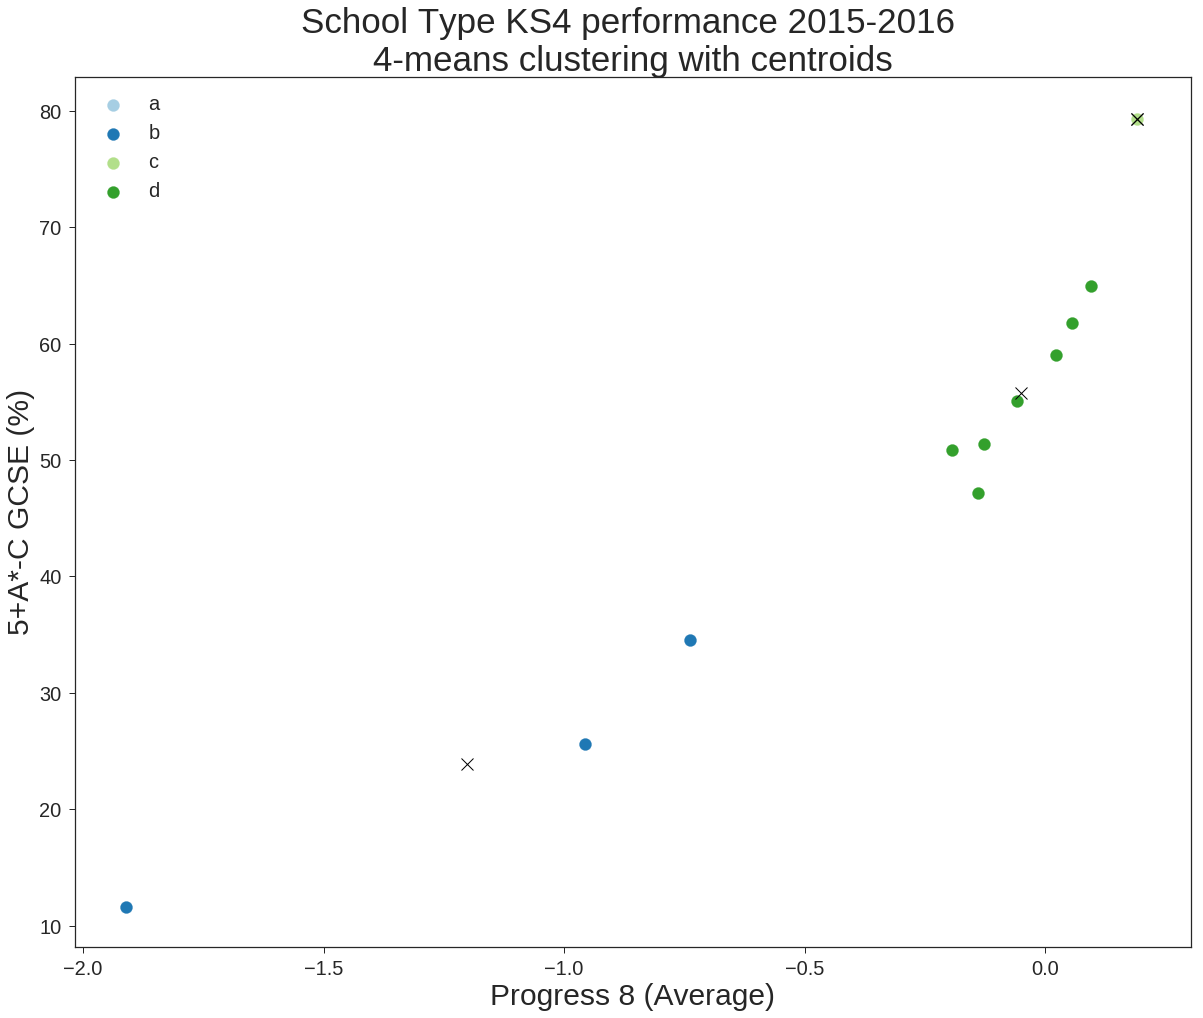

In [156]:
# plot the k-means 4
plot_cluster(grouped_df['P8MEA'], grouped_df['PTAC5EM_PTQ_EE'], assigned_clust, 4,
             cluster_labels=['a', 'b', 'c', 'd'],
             plt_labels=['Progress 8 (Average)', '5+A*-C GCSE (%)'],
             plt_title='School Type KS4 performance 2015-2016 \n4-means clustering with centroids', save=True)

## Run it again to check for variation in clusters

In [157]:
# make another run to see if the groupings vary 
initial_centroids = random_centroids(grouped_df, 'P8MEA', 'PTAC5EM_PTQ_EE', 4)

In [158]:
# create a k-means 4 cluster
kmeans4 = cluster.KMeans(n_clusters=4, init=initial_centroids)

In [159]:
# fit the cluster object to the data
assigned_clust = kmeans4.fit(grouped_df[['P8MEA', 'PTAC5EM_PTQ_EE']])

/usr/local/lib/python3.5/dist-packages/sklearn/cluster/k_means_.py:889: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


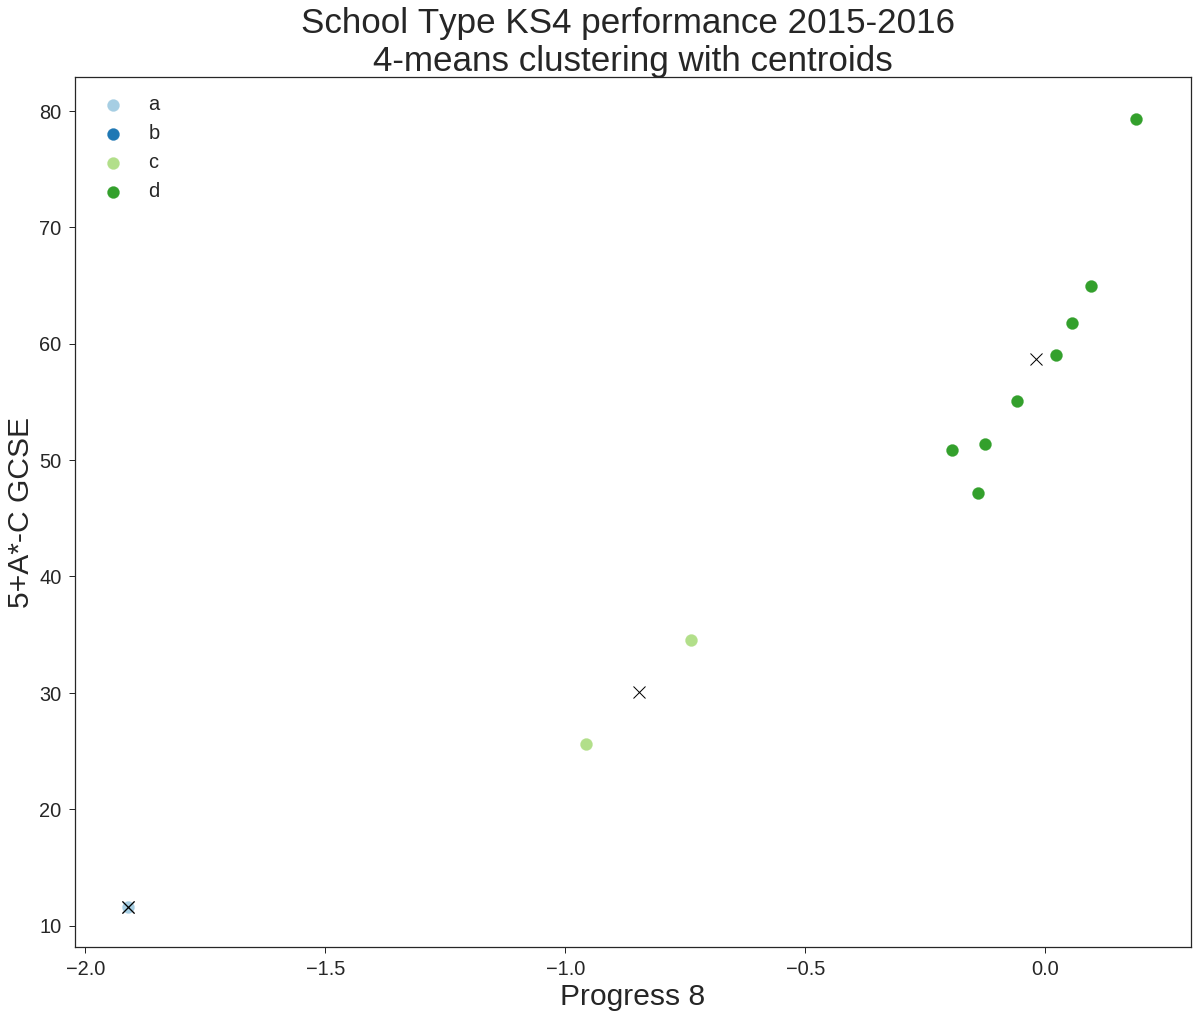

In [160]:
# plot the k-means 4
plot_cluster(grouped_df['P8MEA'], grouped_df['PTAC5EM_PTQ_EE'], assigned_clust, 4,
             cluster_labels=['a', 'b', 'c', 'd'],
             plt_labels=['Progress 8', '5+A*-C GCSE'],
             plt_title='School Type KS4 performance 2015-2016 \n4-means clustering with centroids')

Interesting, the error message is indicating that we don't need to declare the centroids.  A quick search online ([stack overflow link](https://stackoverflow.com/questions/28862334/k-means-with-selected-initial-centers)) also explains this.  If we don't pass initial_centroids in then the method will use the default of 10 random iterations.

## K-means 4, third trial.

In [161]:
# initialise the cluster object
kmeans4 = cluster.KMeans(n_clusters=4)

# fit the cluster object to the data
assigned_clust = kmeans4.fit(grouped_df[['P8MEA', 'PTAC5EM_PTQ_EE']])

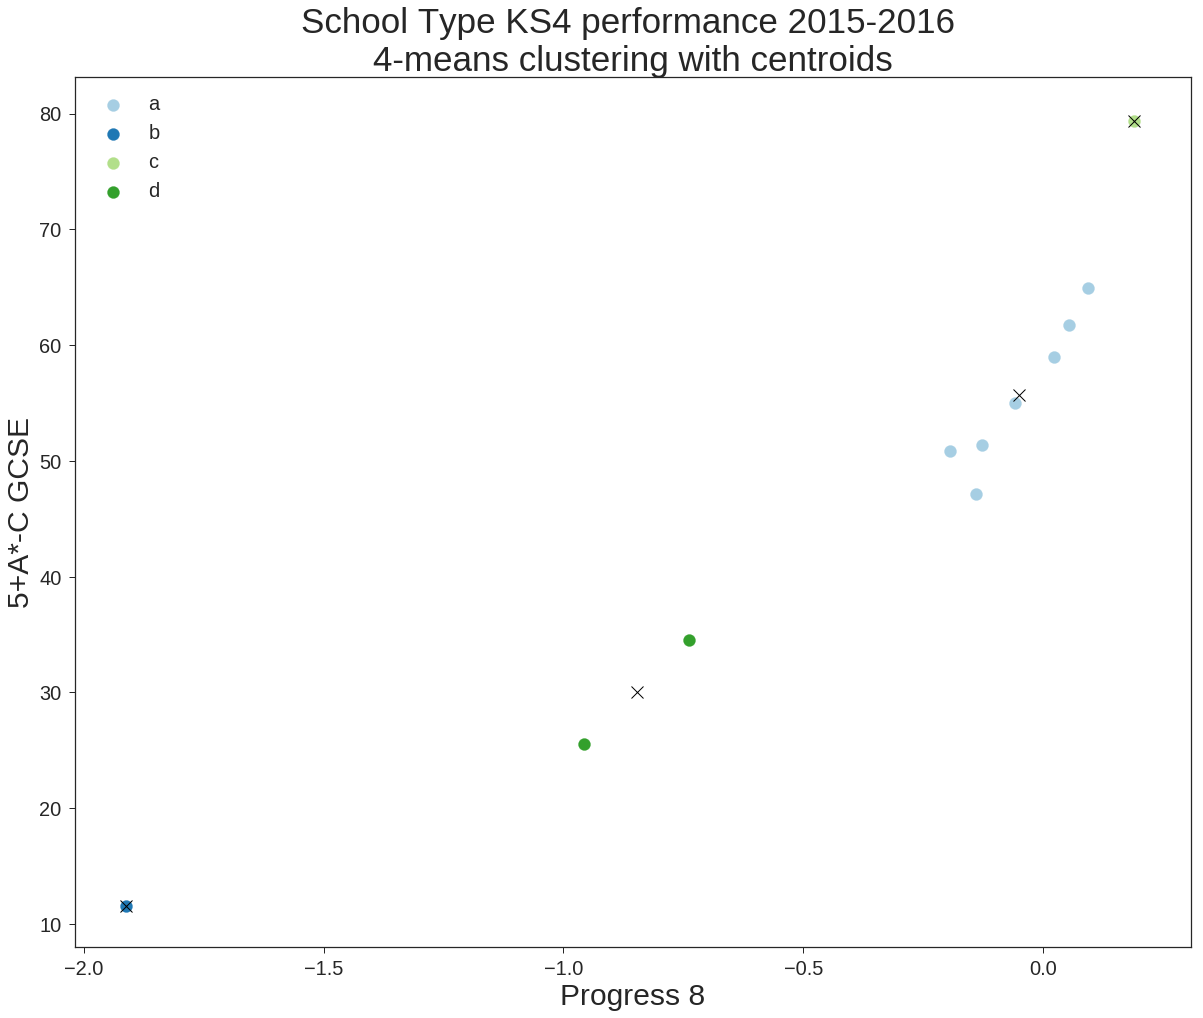

In [162]:
# plot the k-means 4
plot_cluster(grouped_df['P8MEA'], grouped_df['PTAC5EM_PTQ_EE'], assigned_clust, 4,
             cluster_labels=['a', 'b', 'c', 'd'],
             plt_labels=['Progress 8', '5+A*-C GCSE'],
             plt_title='School Type KS4 performance 2015-2016 \n4-means clustering with centroids')

The variety in the clusterings show that they are unstable I'll try a couple of higher k values to see how it performs.

## K-means 5

In [163]:
# initialise the cluster object
kmeans = cluster.KMeans(n_clusters=5)

# fit the cluster object to the data
assigned_clust = kmeans.fit(grouped_df[['P8MEA', 'PTAC5EM_PTQ_EE']])

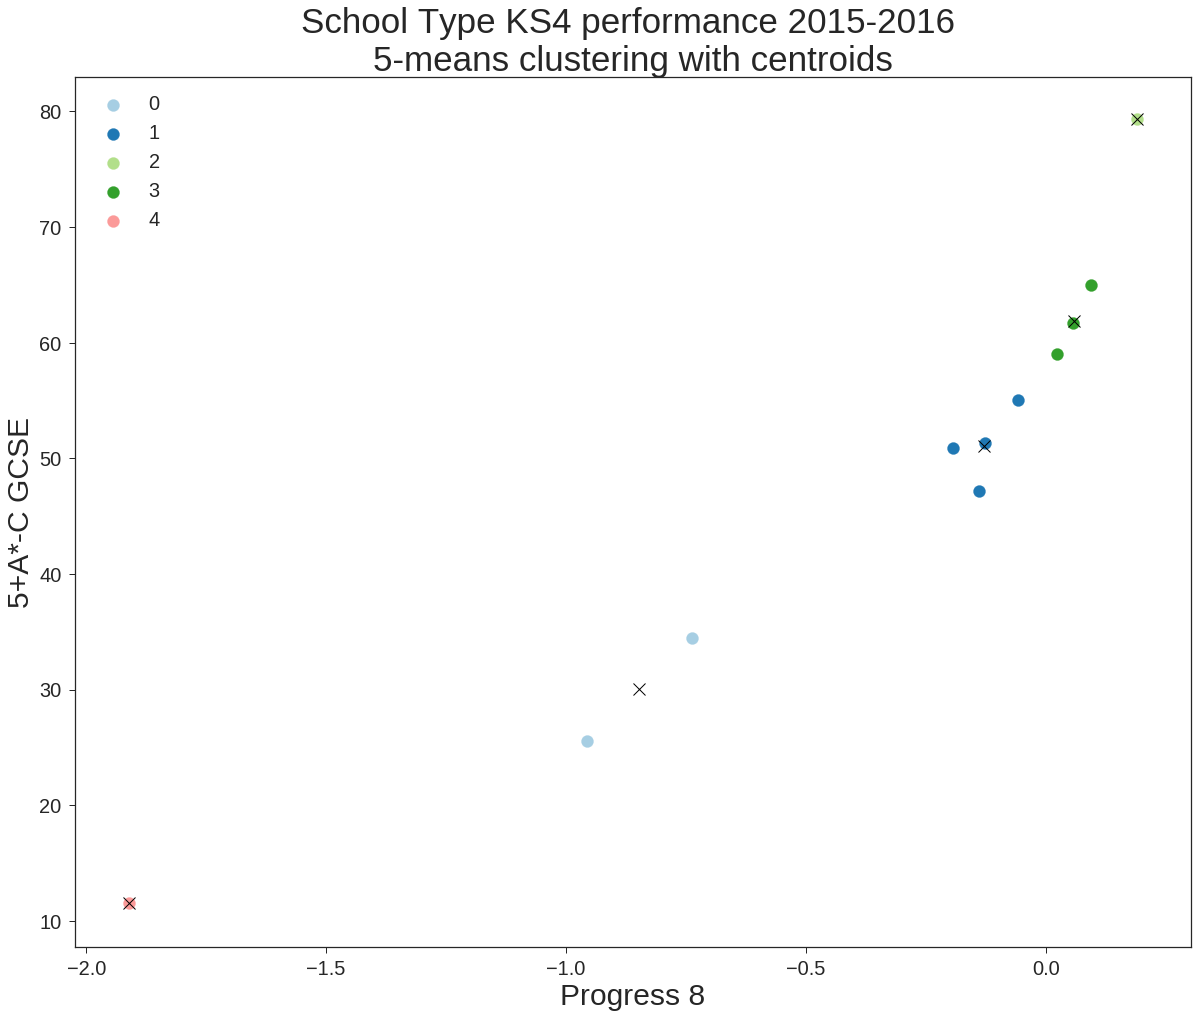

In [164]:
# plot the k-means 5
plot_cluster(grouped_df['P8MEA'], grouped_df['PTAC5EM_PTQ_EE'], assigned_clust, 5,
             plt_labels=['Progress 8', '5+A*-C GCSE'],
             plt_title='School Type KS4 performance 2015-2016 \n5-means clustering with centroids')

## K-means 6

In [165]:
# initialise the cluster object
kmeans = cluster.KMeans(n_clusters=6)

# fit the cluster object to the data
assigned_clust = kmeans.fit(grouped_df[['P8MEA', 'PTAC5EM_PTQ_EE']])

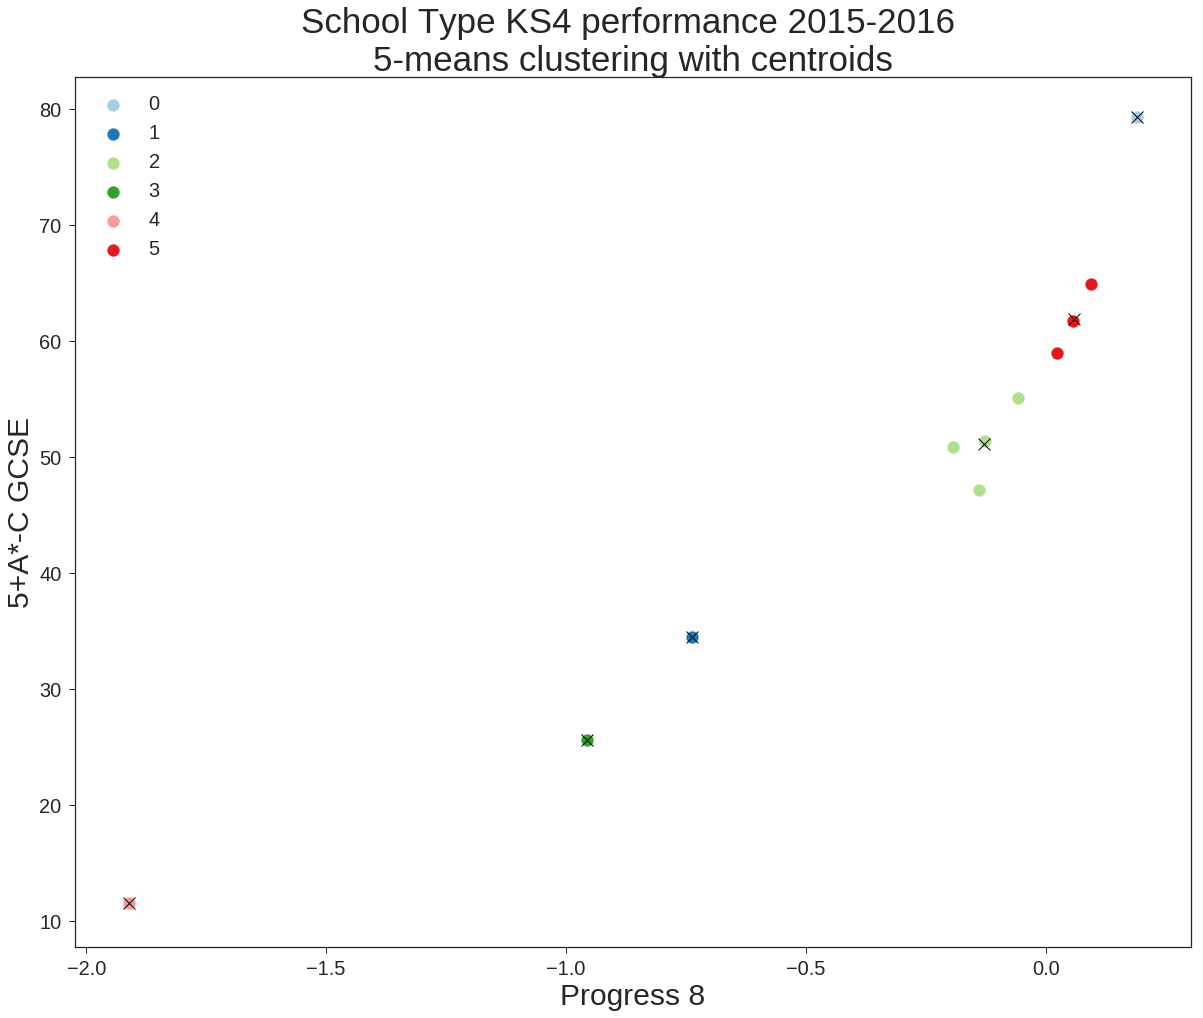

In [166]:
# plot the k-means 6
plot_cluster(grouped_df['P8MEA'], grouped_df['PTAC5EM_PTQ_EE'], assigned_clust, 6,
             plt_labels=['Progress 8', '5+A*-C GCSE'],
             plt_title='School Type KS4 performance 2015-2016 \n5-means clustering with centroids')

There are clearly a few ways that this dataset can be clustered.  It is perhaps worth noting that the most of the school types are around the national average measure for Progress8 (0), and above 50% for the GCSE measure.  Their are two clear outliers one at the top right (best score for both GCSE, and progress8) and one at the bottom (second worse GCSE and by far the worse progress8), let's identify which school types they are.

In [167]:
grouped_df['P8MEA'].idxmax()

'City technology college'

In [168]:
grouped_df['P8MEA'].idxmin()

'Further Education Sector Institution'

In [169]:
grouped_df['PTAC5EM_PTQ_EE'].idxmax()

'City technology college'

In [170]:
grouped_df['PTAC5EM_PTQ_EE'].idxmin()

'Further Education Sector Institution'

So in both cases the top school type is 'City technology college' and the bottom performer is 'Further Education Sector Institution' 

How many of each are there in the dataset?

In [171]:
ks4_results_df[ks4_results_df['NFTYPE']=='CTC']['NFTYPE'].count()

12

So there are only 3 schools of that type with results recorded in our cleaned dataset.  What about the 'Further Education Sector Institution'

In [172]:
ks4_results_df[ks4_results_df['NFTYPE']=='FESI']['NFTYPE'].count()

48

12 is a few more but still not that many.

In [173]:
(round(3/len(ks4_results_df)*100,4), round(12/len(ks4_results_df)*100, 4))

(0.0242, 0.0968)

Both are fractions of a 1 percent of the whole dataset.

<a name="machine_learning"></a>

# Machine Learning

## k-means cluster analysis of the ungrouped dataset.

To get a better understanding of the school type distribution in each cluster it will be I need to cluster accross the whole dataset on those performance measures.

In [174]:
ks4_results_df.head()

ATT8SCR NFTYPE  P8MEA  PTAC5EM_PTQ_EE  PTEBACC_PTQ_EE     URN
0     50.1     CY  -0.26            0.53            0.30  100053
1     60.1     VA   0.31            0.77            0.60  100054
2     50.0     CY   0.09            0.52            0.33  100052
3     47.0     CY  -0.11            0.47            0.09  100049
4     57.6     VA   0.41            0.74            0.28  100059

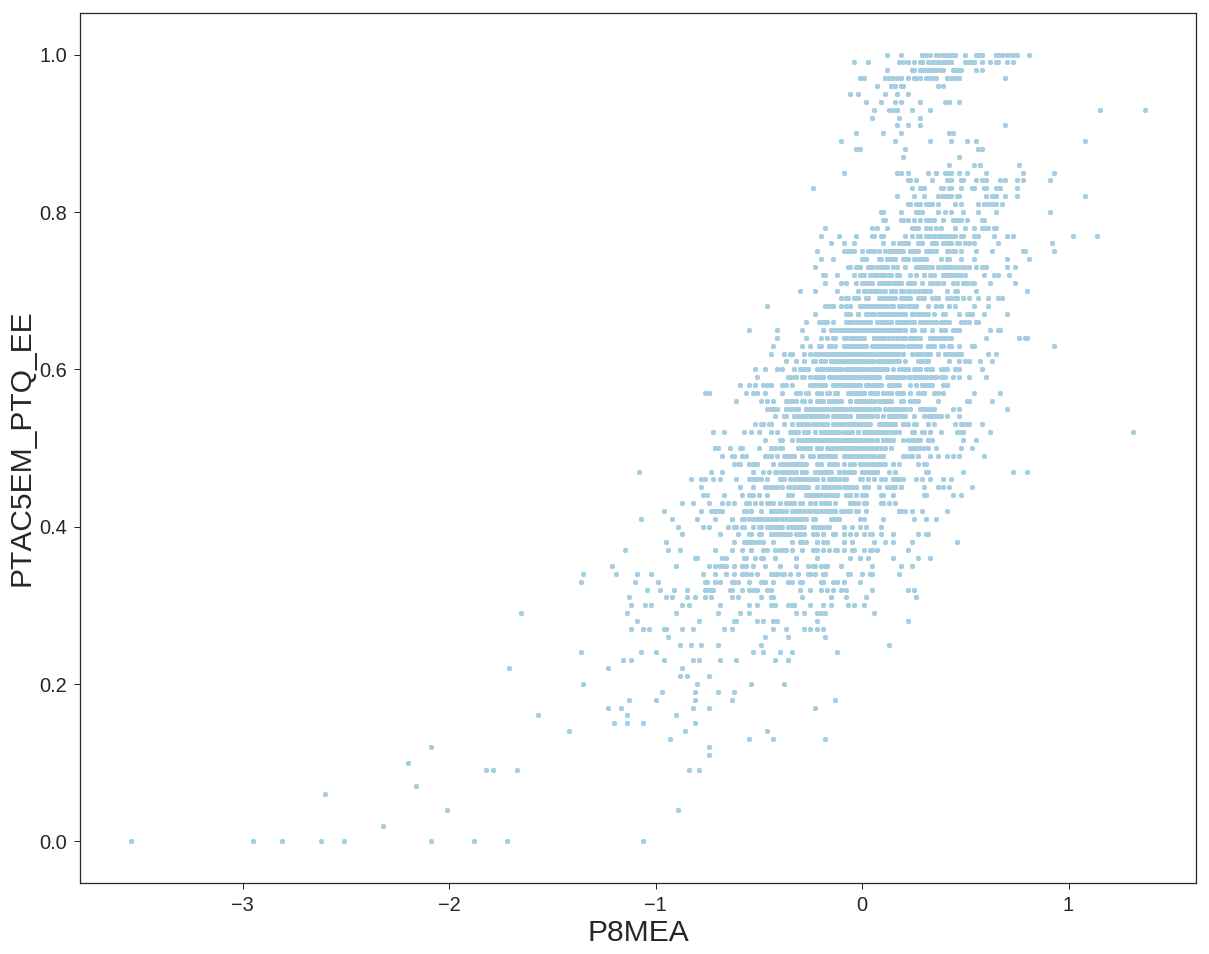

In [175]:
ks4_results_df.plot(kind='scatter', x='P8MEA', y='PTAC5EM_PTQ_EE')

With there being a range of different measures to look at in combination I will create another helper function to make the process more efficient.

In [176]:
# helper function to fill out boilerplate code
# initialises a kmeans cluster object and fits it to the data
# then plots it using the plot_cluster method defined earlier.
def kmeans_plot(df, x_column, y_column, k,
                cluster_labels=None, plt_labels=None, plt_title=None,
                colors=None, initial_centroids=None, save=False
                ):
    
    # create k-means cluster object
    if initial_centroids == None:
        kmeans_clust = cluster.KMeans(n_clusters=k)
    else:
        kmeans_clust = cluster.KMeans(n_clusters=k, init=initial_centroids)
    # fit the objest to the data
    assigned_clust = kmeans_clust.fit(df[[x_column, y_column]])

    # plot the kmeans cluster
    plot_cluster(df[x_column], df[y_column], assigned_clust, k,
                 cluster_labels=cluster_labels, plt_labels=plt_labels,
                 plt_title=plt_title, colors=colors, save=save
                 )

Now I have a handy function I can iterate through some different k-values and see which k value fits the data the best.

## Cluster Groups of Progress 8 and 5+A*-C measures

Remind myself of the column names so I can look them up

In [177]:
ks4_results_df.columns


Index(['ATT8SCR', 'NFTYPE', 'P8MEA', 'PTAC5EM_PTQ_EE', 'PTEBACC_PTQ_EE',
       'URN'],
      dtype='object')

Iterate with different k values (2 - 8) and plot each one.

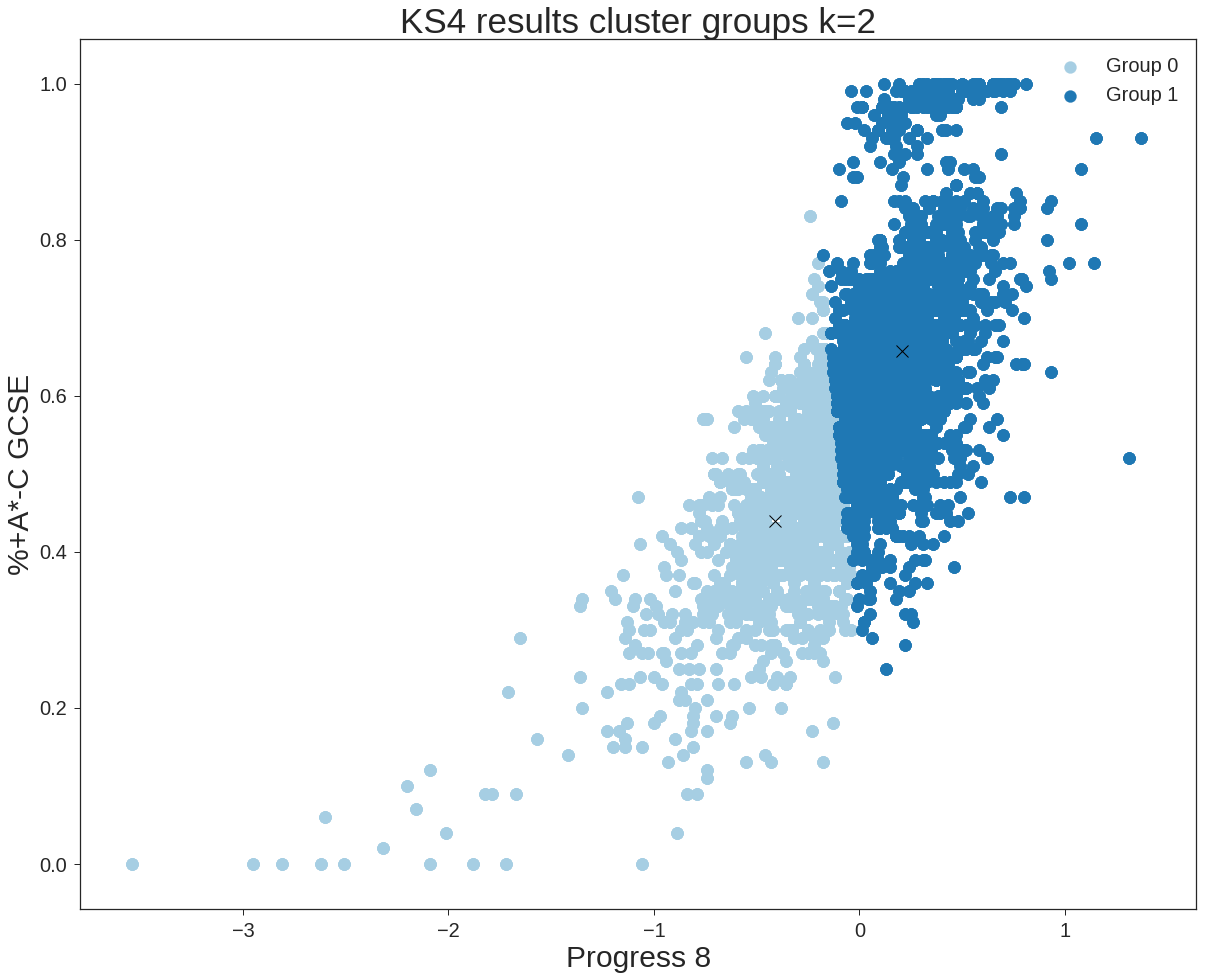

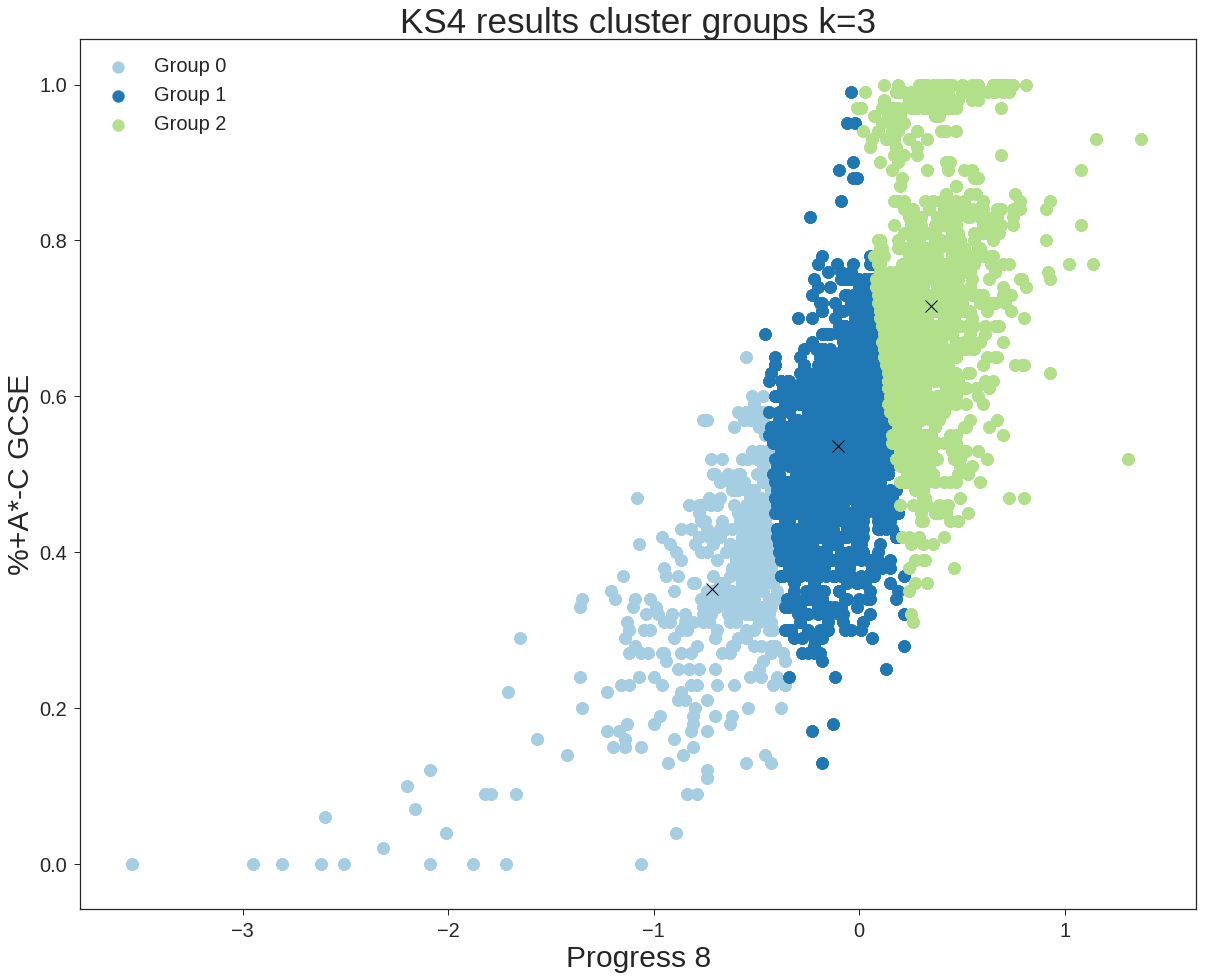

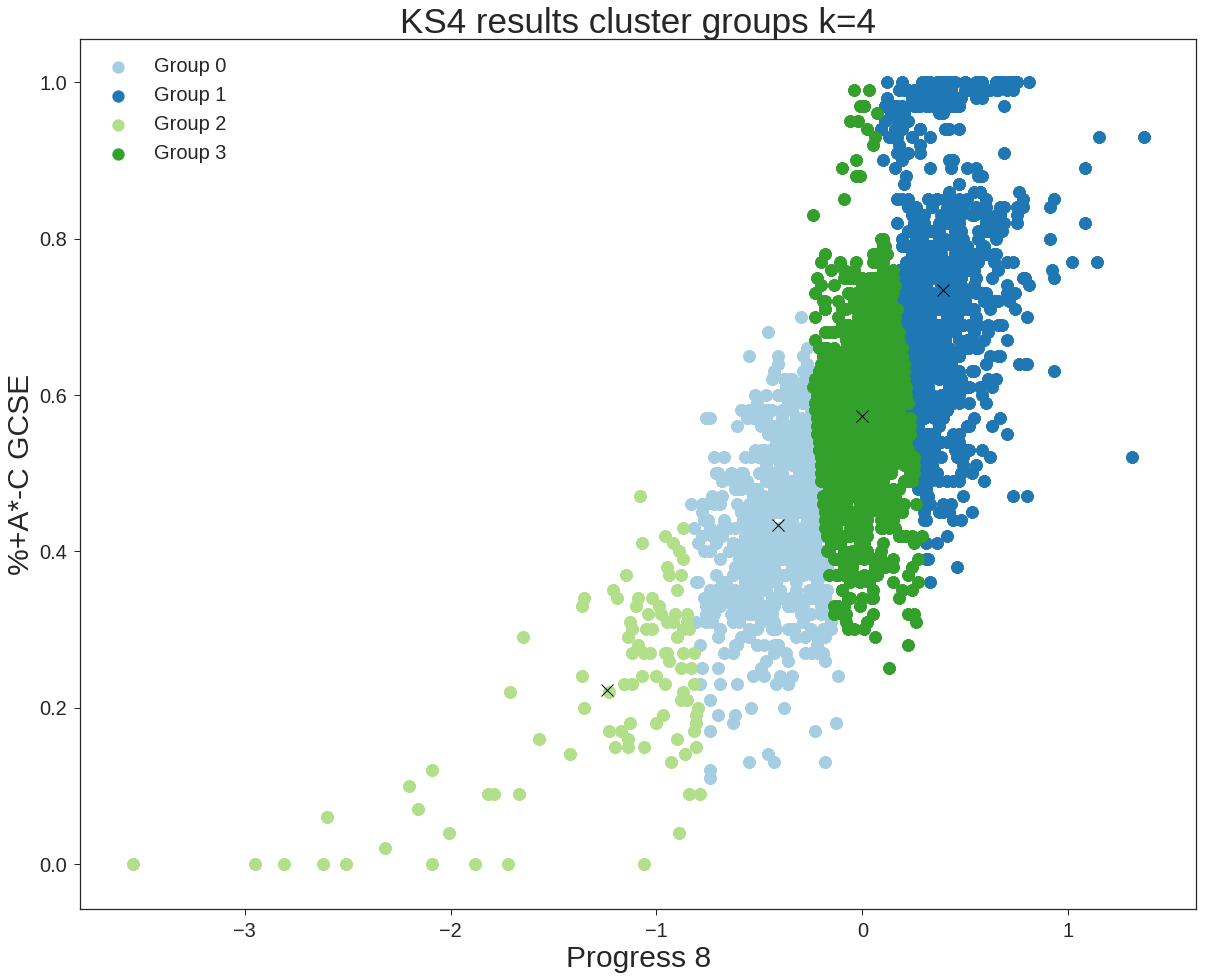

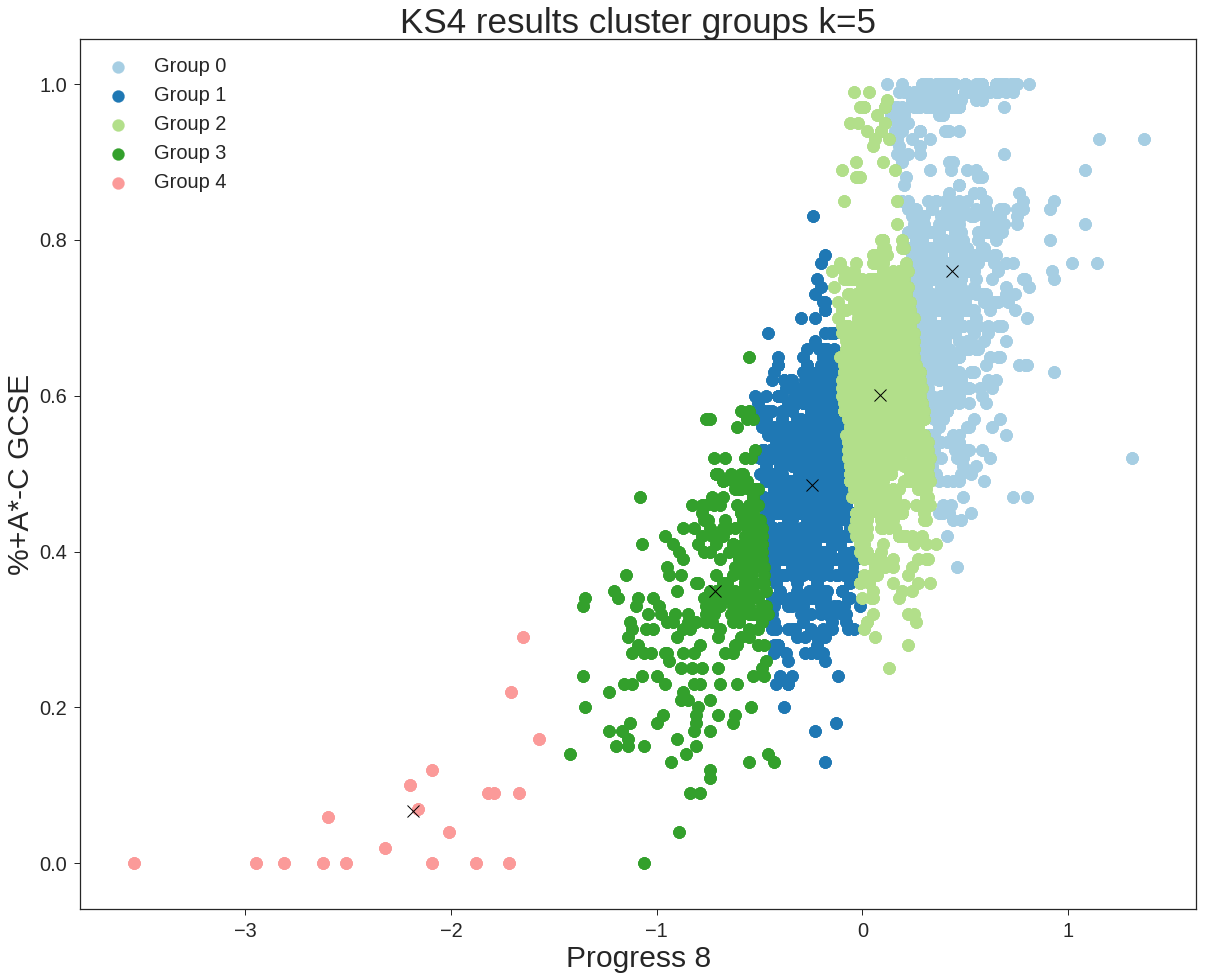

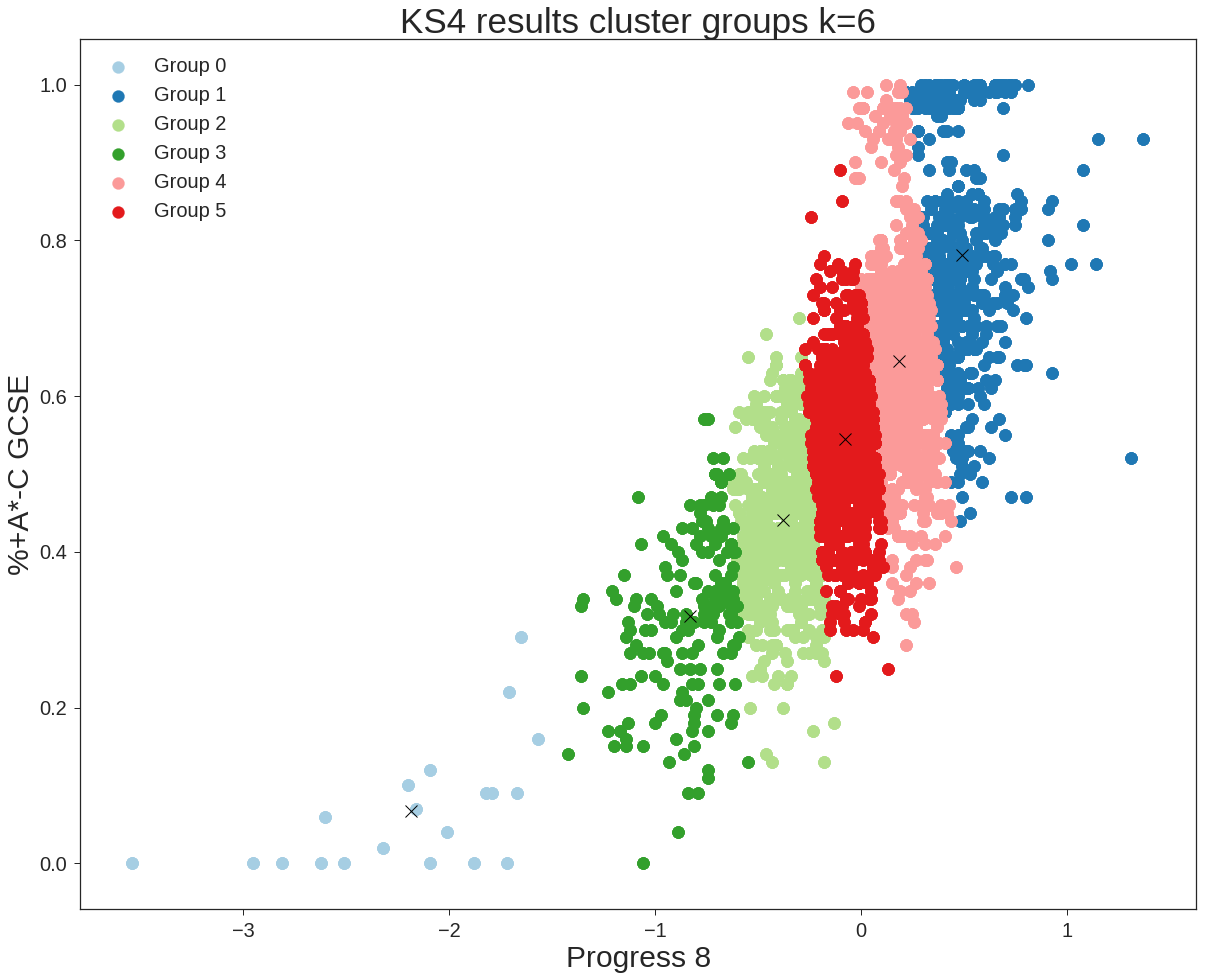

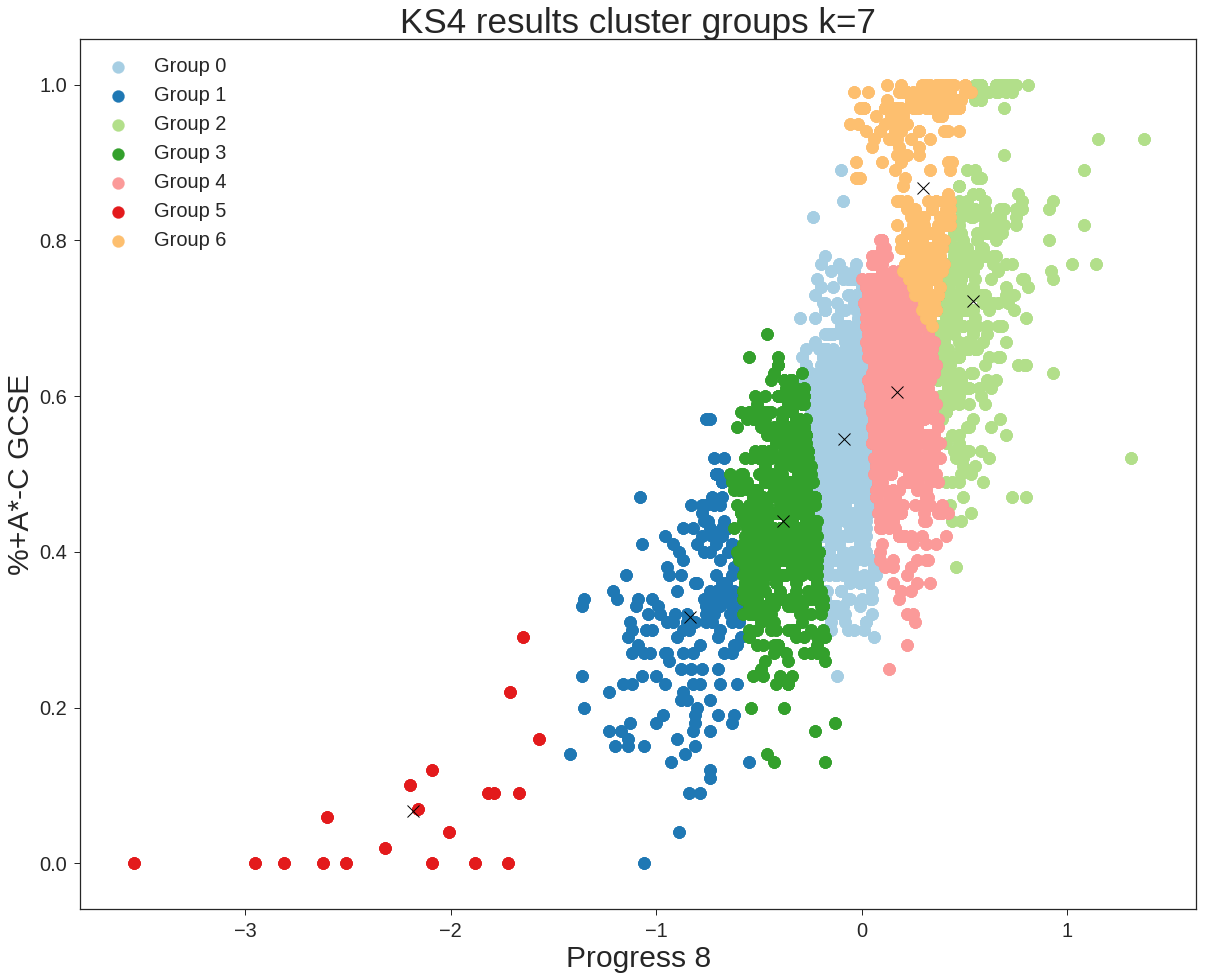

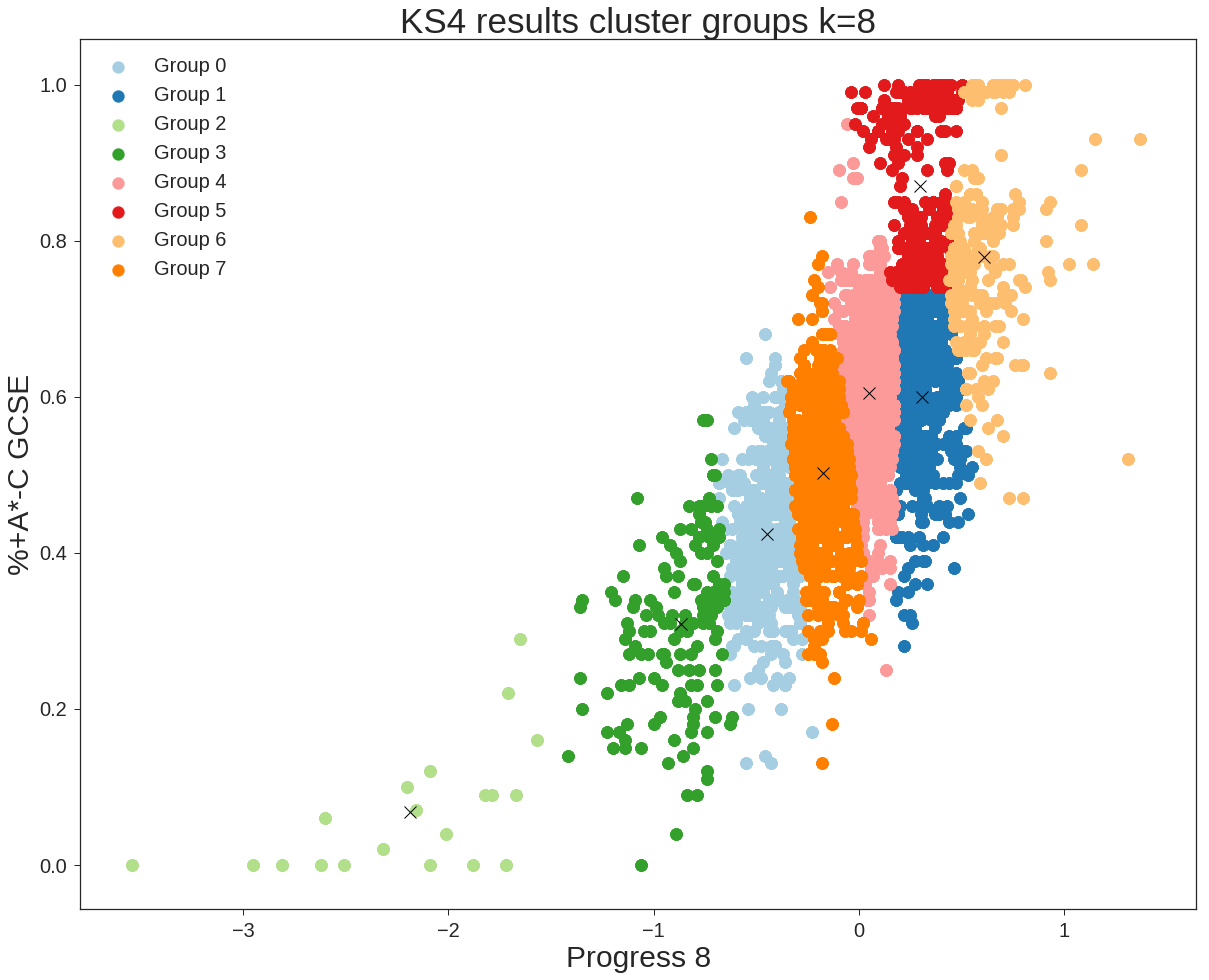

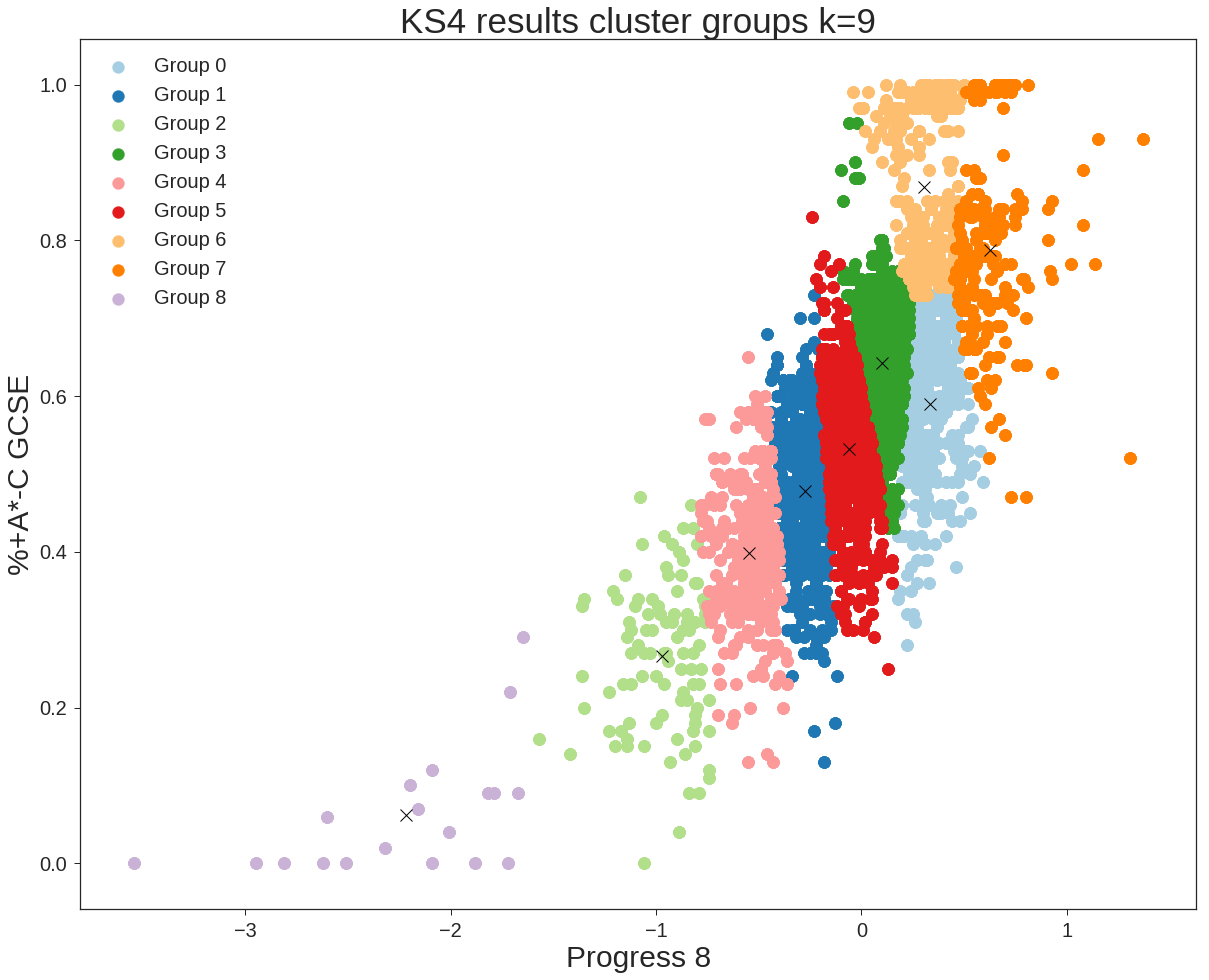

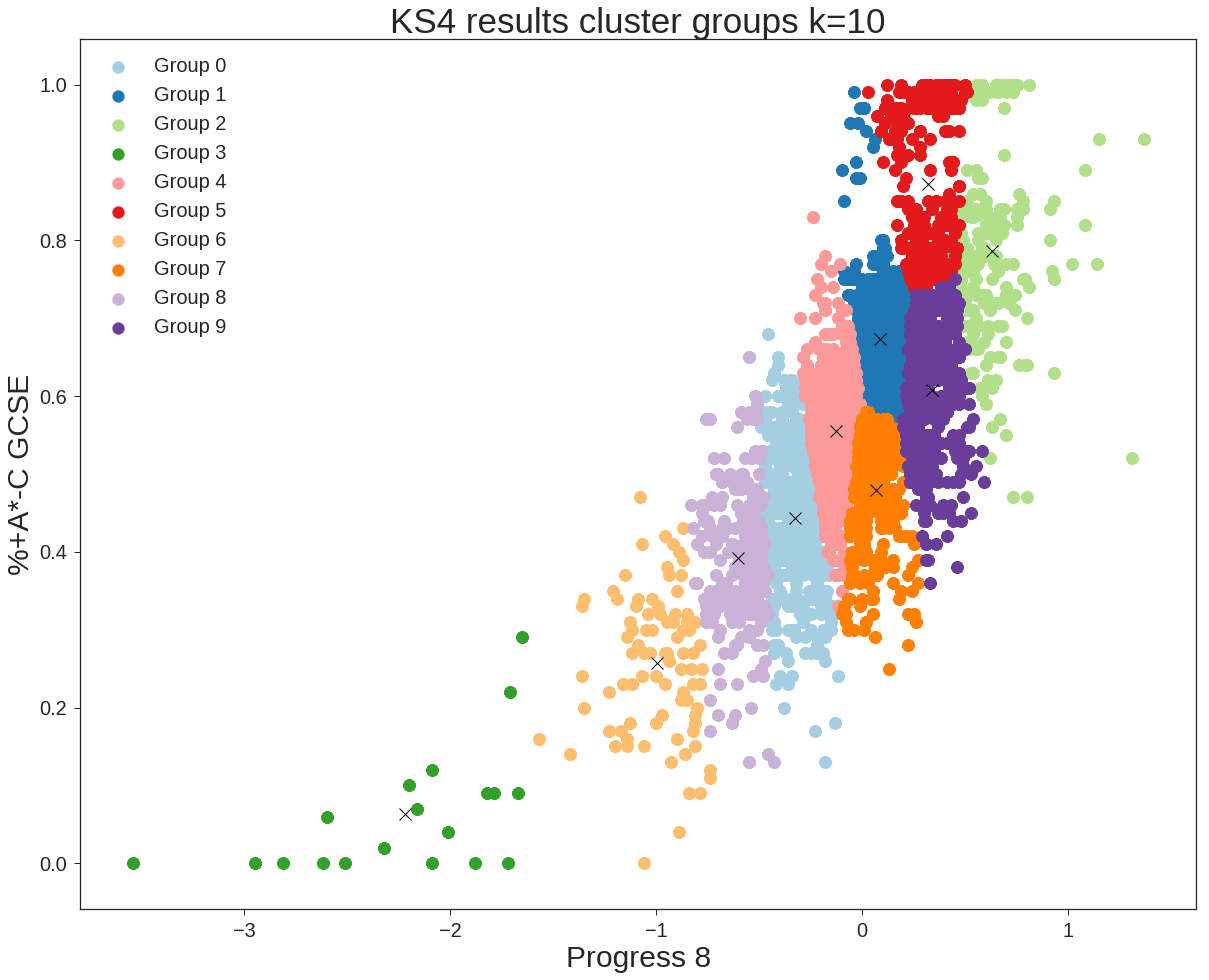

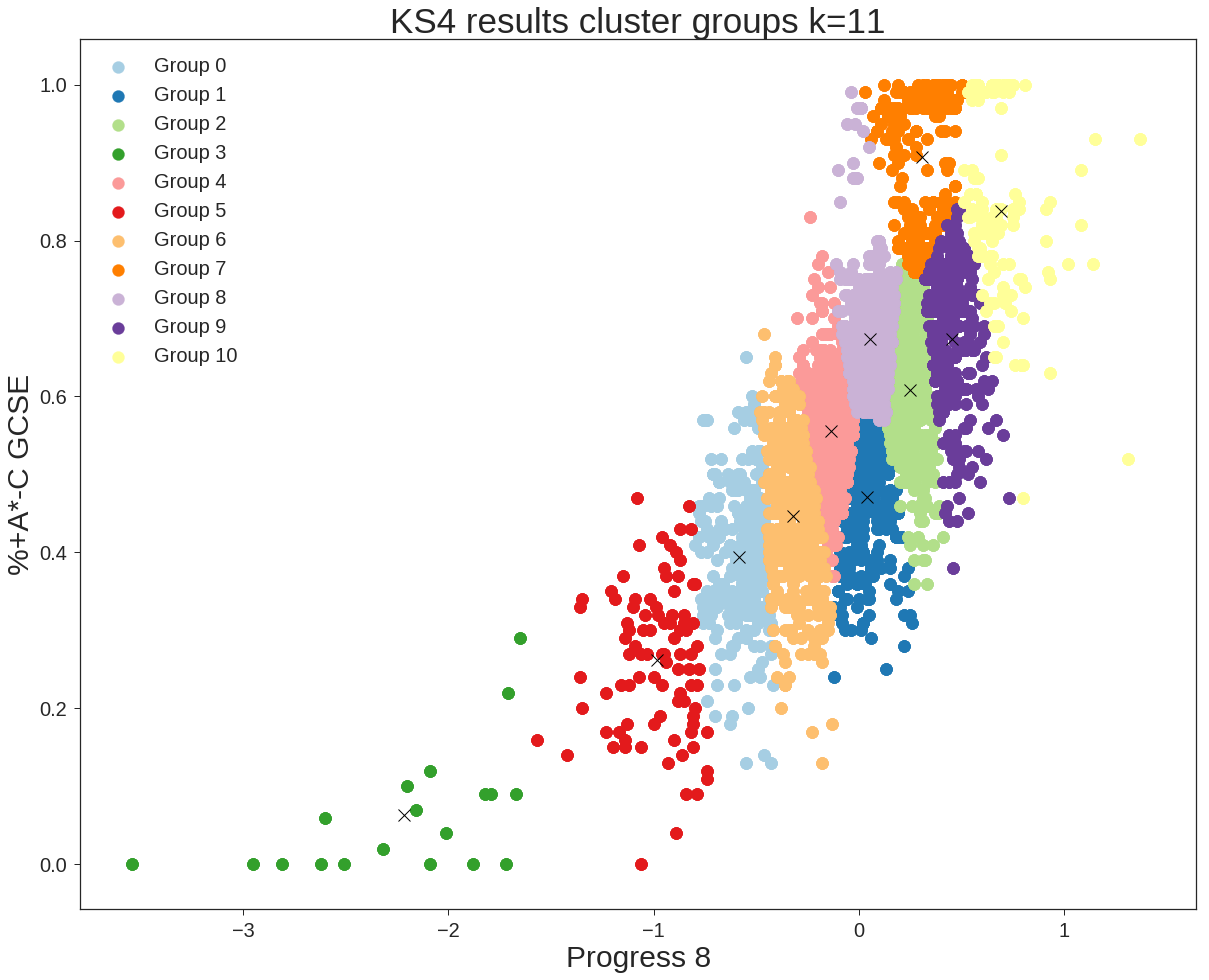

In [178]:
for k in range(2,12):
    title = 'KS4 results cluster groups k=' + str(k)
    cluster_labels = ['Group ' + str(i) for i in range(k)]
    kmeans_plot(ks4_results_df, 'P8MEA', 'PTAC5EM_PTQ_EE', k=k,
                plt_title=title, cluster_labels=cluster_labels,
                plt_labels=['Progress 8', '%+A*-C GCSE'], save=True)

The additional clusters seem to break the data into narrow and narrower segments.  But they do appear to be quite spread For our needs I think k=4 is good to look at in more detail.  As I am trying to identify groups that perform well.

## KS4 results data cluster group plot k=4

I need a little more control over the plotting so I can move the set the legend position if needed.

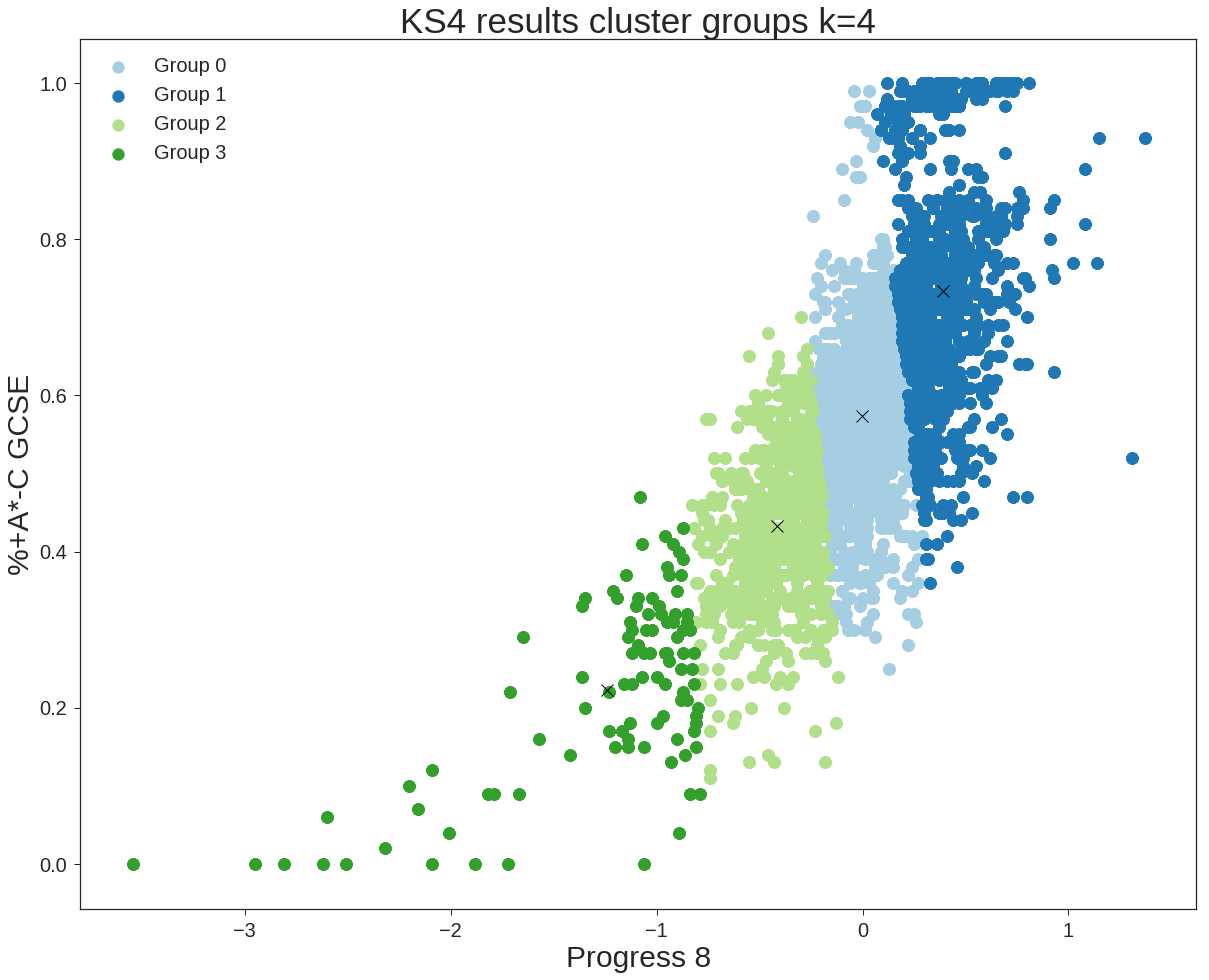

In [179]:
title = 'KS4 results cluster groups k=4'

kmeans_plot(ks4_results_df, 'P8MEA', 'PTAC5EM_PTQ_EE', k=4,
                plt_title=title, cluster_labels=cluster_labels,
                plt_labels=['Progress 8', '%+A*-C GCSE'])

Now to use the filter to separate the data I will need to have access to the cluster object, or supply supply it to the function to be plotted.

While editing I'll allow for a little more customisation of the plotting.

In [180]:
# Helper function to plot clustering results
# allows some plot visualisations to be specified
def plot_cluster_2(data_x, data_y, assigned_clust, k, 
                 cluster_labels=None, plt_labels=None, 
                 plt_title=None, colors=None, legend_loc=None,
                 opacity=1, save=False 
                ):
    # set default colors
    if colors==None:
        colors = sns.palettes.color_palette(n_colors=k)
    # set default labels
    if cluster_labels==None:
        cluster_labels = ['Group ' + str(i) for i in range(k)]
    
    plt.figure()
    # plot the cluster group    
    for c in range(k):
        plt.scatter(data_x[assigned_clust.labels_==c],
                    data_y[assigned_clust.labels_==c],
                    color=colors[c], marker='o', 
                    label=cluster_labels[c],
                    alpha=opacity
                   )
    # plot the centroids
    for (cx, cy) in assigned_clust.cluster_centers_:
        plt.plot(cx, cy, color='black', marker='x', mew=1)
    
    # add the legend
    plt.legend(loc=legend_loc)
        
    plt.xlabel(plt_labels[0])
    plt.ylabel(plt_labels[1])
        
    plt.title(plt_title)
    
    if save:
        plt.savefig('plot_images/cluster '+ plt_title + ' k='+str(k))


Now I can create a cluster group and then use it to plot the groups and then filter the dataframe.

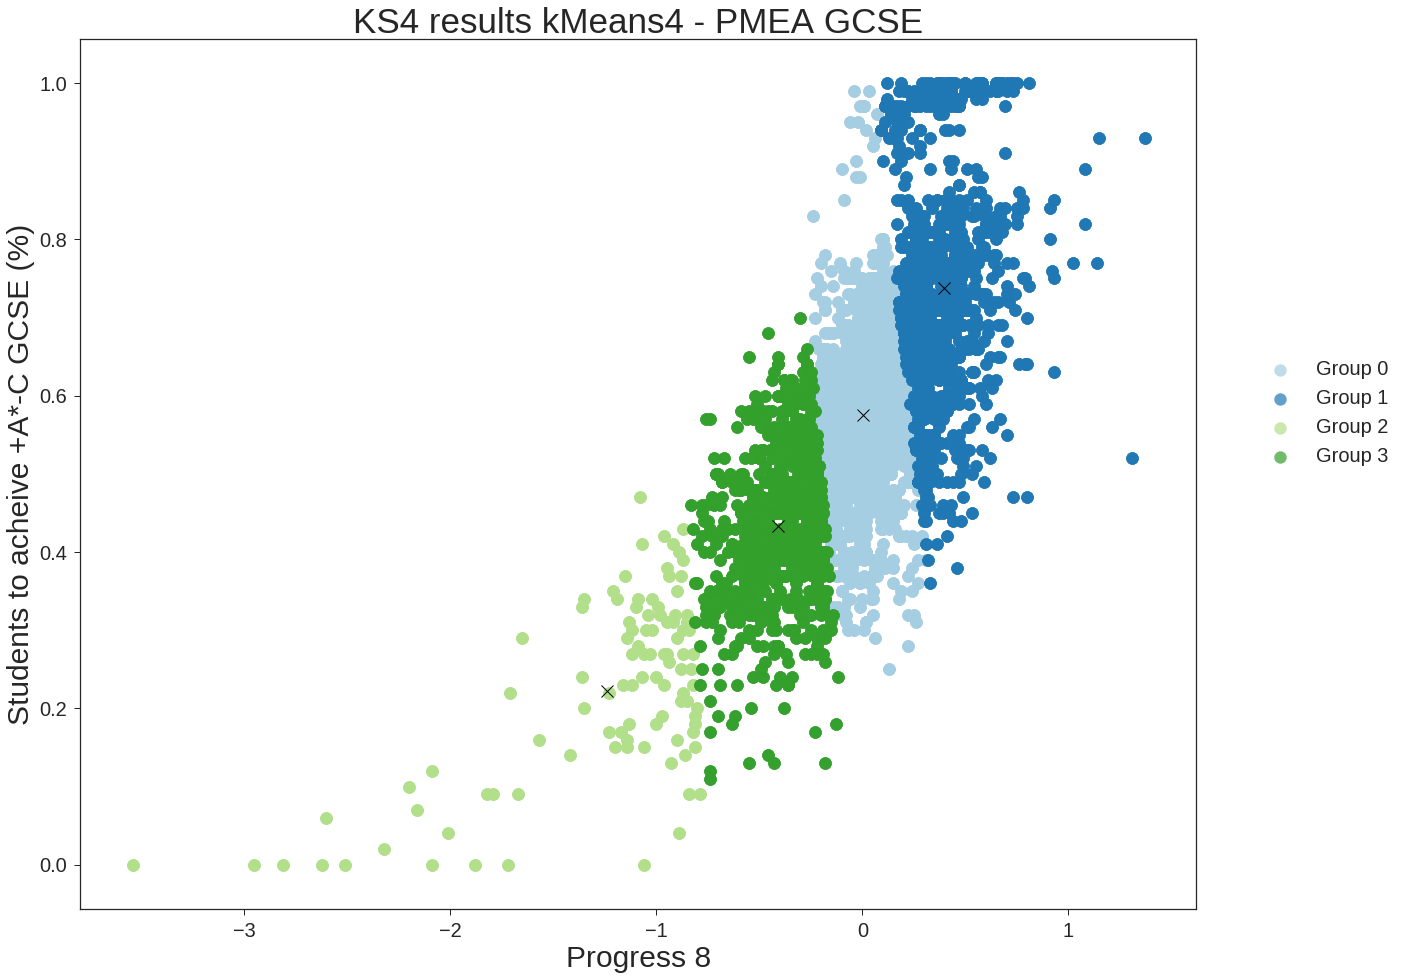

In [181]:
# set the title I want to use
title = 'KS4 results kMeans4 - PMEA GCSE'

# so that it always runs the same I need to initialise centroids in this case
init_centroids = pd.DataFrame({'PMEA': [-1.5, -0.5, 0, 0.75],
                                'PTAC5EM_PTQ_EE': [0.2, 0.4, 0.6, 0.8]},
                              columns=['PMEA', 'PTAC5EM_PTQ_EE'])

# initialise the kmeans cluster
kmeans_4 = cluster.KMeans(n_clusters=4, init=init_centroids)
# initialise the kmeans cluster

# fit it to the data
assigned_clusters = kmeans4.fit(ks4_results_df[['P8MEA', 'PTAC5EM_PTQ_EE']])

# plot the results
plot_cluster_2(ks4_results_df['P8MEA'], ks4_results_df['PTAC5EM_PTQ_EE'], 
               assigned_clust=assigned_clusters, k=4,
            plt_title=title,
            plt_labels=['Progress 8', 'Students to acheive +A*-C GCSE (%)'],
            legend_loc=(1.05, 0.5),
            opacity=0.7,
            save=True)

The clusters appear to be separated into groups around the result bands.  With the progress measure having a strong impact on the groupings.  However, they look quite wide ranging.  I'll run a silouette analysis on them to see whether they are suitable.

<a name='silhouette'></a>

# Silhouette coefficients analysis

## Kmeans=4 

In [182]:
# create a column on the results data for each value
ks4_results_df['cluster'] = pd.Series(assigned_clusters.labels_)

In [183]:
# check it looks ok.
ks4_results_df.head()

ATT8SCR NFTYPE  P8MEA  PTAC5EM_PTQ_EE  PTEBACC_PTQ_EE     URN  cluster
0     50.1     CY  -0.26            0.53            0.30  100053        3
1     60.1     VA   0.31            0.77            0.60  100054        1
2     50.0     CY   0.09            0.52            0.33  100052        0
3     47.0     CY  -0.11            0.47            0.09  100049        0
4     57.6     VA   0.41            0.74            0.28  100059        1

Calculate the silhouette coefficients

In [184]:
# from notebook 21.3
# Add the silhouette coefficients as a new column in the
# ks4_results_df:
ks4_results_df['silhouette'] = silhouette_samples(ks4_results_df[['P8MEA', 'PTAC5EM_PTQ_EE']],
                                                             np.array(ks4_results_df['cluster']))

ks4_results_df.head()

ATT8SCR NFTYPE  P8MEA  PTAC5EM_PTQ_EE  PTEBACC_PTQ_EE     URN  cluster  \
0     50.1     CY  -0.26            0.53            0.30  100053        3   
1     60.1     VA   0.31            0.77            0.60  100054        1   
2     50.0     CY   0.09            0.52            0.33  100052        0   
3     47.0     CY  -0.11            0.47            0.09  100049        0   
4     57.6     VA   0.41            0.74            0.28  100059        1   

   silhouette  
0    0.249894  
1    0.463844  
2    0.574399  
3    0.381953  
4    0.573333

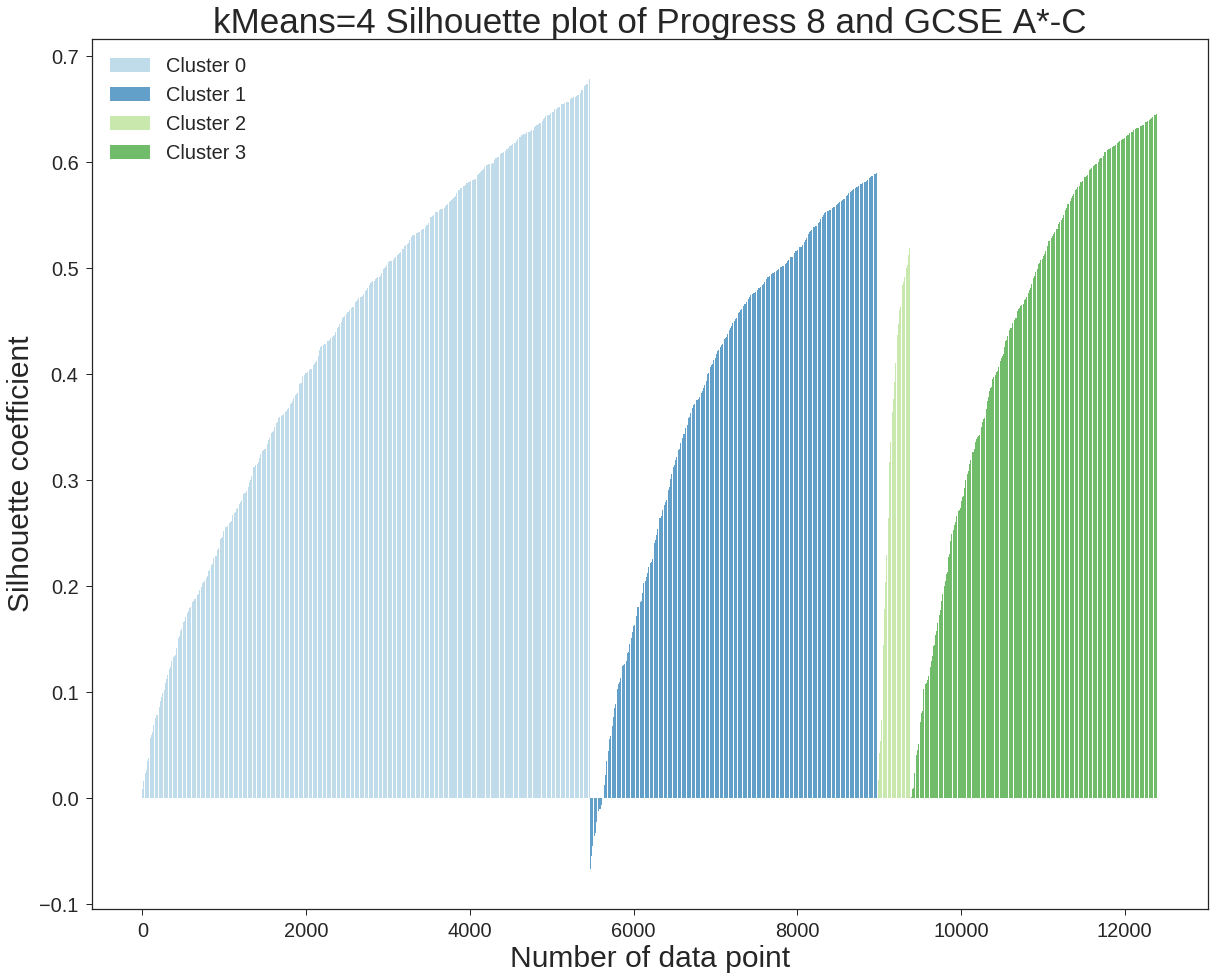

In [185]:
# sort the dataframe so we can see a curve
silhouette_plot_data_df = ks4_results_df.sort_values(['cluster', 'silhouette'])
silhouette_plot_data_df.index = list(range(len(silhouette_plot_data_df)))

# set the colours
colours = sns.palettes.color_palette(n_colors=len(set(ks4_results_df['cluster'])))

for clust in set(silhouette_plot_data_df['cluster']):
    plt.bar(silhouette_plot_data_df[silhouette_plot_data_df['cluster']==clust].index,
            silhouette_plot_data_df[silhouette_plot_data_df['cluster']==clust]['silhouette'],
            color=colours[clust], alpha=0.7, label='Cluster ' + str(clust))
    
plt.title('kMeans=4 Silhouette plot of Progress 8 and GCSE A*-C')
plt.legend()

plt.xlabel('Number of data point')
plt.ylabel('Silhouette coefficient')

plt.savefig('plot_images/silhouette_k4_P8_AC5.png')



This silhouette plot shows us clearly that the clusters are uneven in size, with a wide range of coefficiets.  there are ales a few overlapping points showing.

I'll repeat using a higher k-value the above steps using a higher k value.

## KS4 results data cluster group plot k=9

First I'll drop the extra columns created earlier.

In [186]:
# drop the added columns
if 'cluster' in ks4_results_df.columns:
    ks4_results_df.drop(['cluster', 'silhouette'], axis=1 , inplace=True)

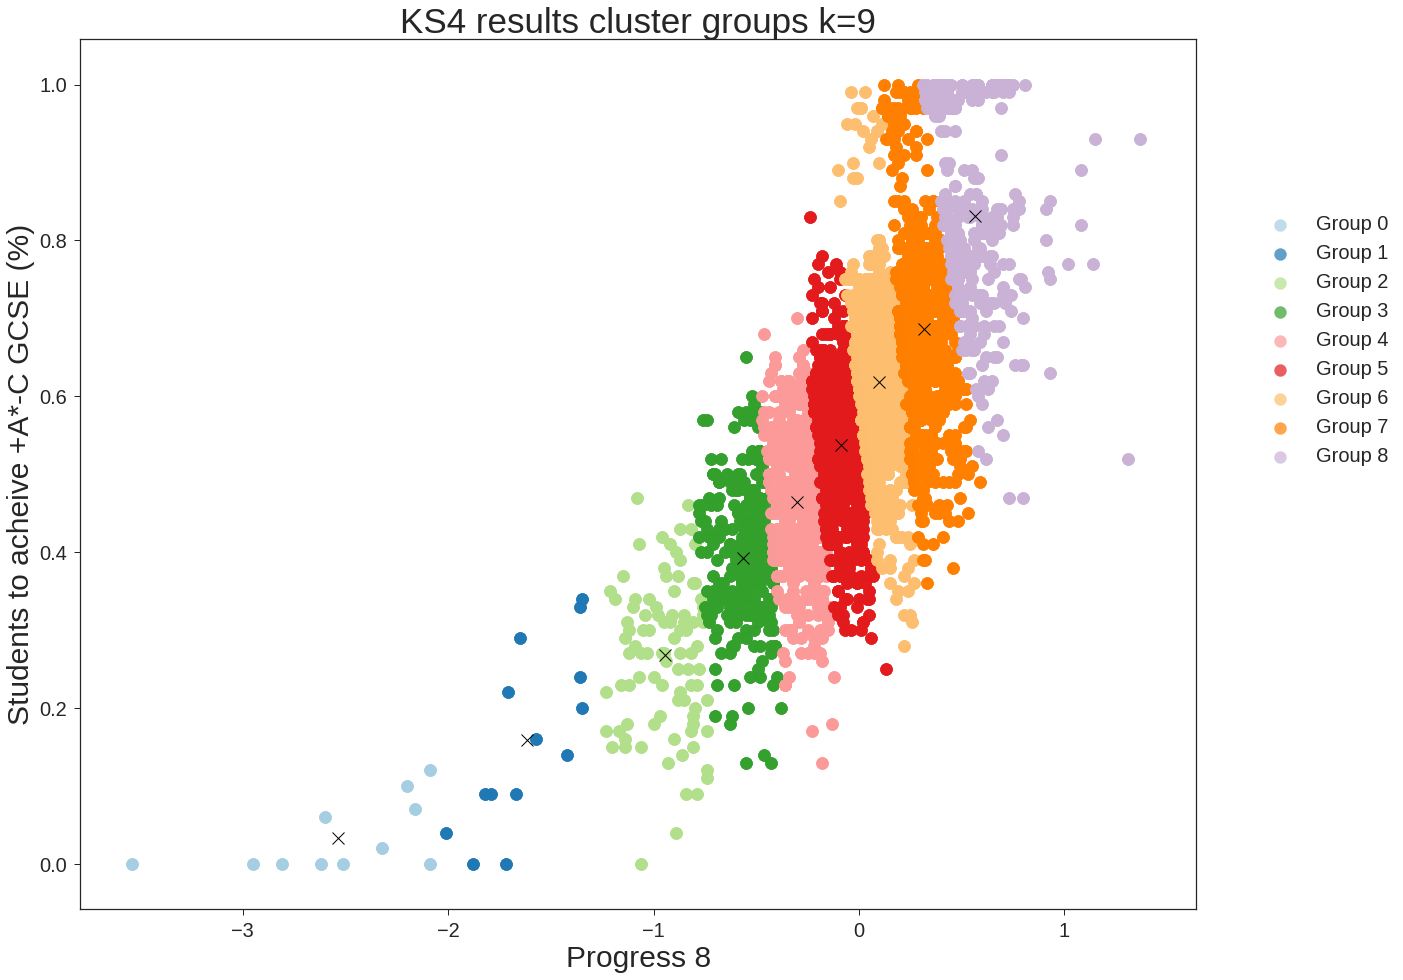

In [187]:
# set the title I want to use
title = 'KS4 results cluster groups k=9'

# so that it always runs the same I need to initialise centroids in this case
init_centroids_9 = pd.DataFrame({'PMEA': [-2, -1.5, -1, -0.75, -0.5, -0.25, 0, 0.25,  0.75],
                                'PTAC5EM_PTQ_EE': [0.2, 0.3, 0.4, 0.5, 0.55, 0.6, 0.7, 0.8, 0.9]},
                              columns=['PMEA', 'PTAC5EM_PTQ_EE'])

# initialise the kmeans cluster
kmeans9 = cluster.KMeans(n_clusters=9, init=init_centroids_9, n_init=1)

# fit it to the data
assigned_clusters_9 = kmeans9.fit(ks4_results_df[['P8MEA', 'PTAC5EM_PTQ_EE']])

# plot the results
plot_cluster_2(ks4_results_df['P8MEA'], ks4_results_df['PTAC5EM_PTQ_EE'], 
               assigned_clust=assigned_clusters_9, k=9,
            plt_title=title,
            plt_labels=['Progress 8', 'Students to acheive +A*-C GCSE (%)'],
            legend_loc=(1.05, 0.5),
            opacity=0.7,
            save=True)

The clusters still look quite wide ranging.  I'll run a silouette analysis on them to see if the higher k value has evened things out.

## Silhouette analysis of kMeans 9 clustering.

In [188]:
# create a column on the results data for each value
ks4_results_df['cluster'] = pd.Series(assigned_clusters_9.labels_)

Calculate the silhouette coefficients

In [189]:
# from notebook 21.3
# Add the silhouette coefficients as a new column in the
# ks4_results_df:
ks4_results_df['silhouette'] = silhouette_samples(ks4_results_df[['P8MEA', 'PTAC5EM_PTQ_EE']],
                                                             np.array(ks4_results_df['cluster']))

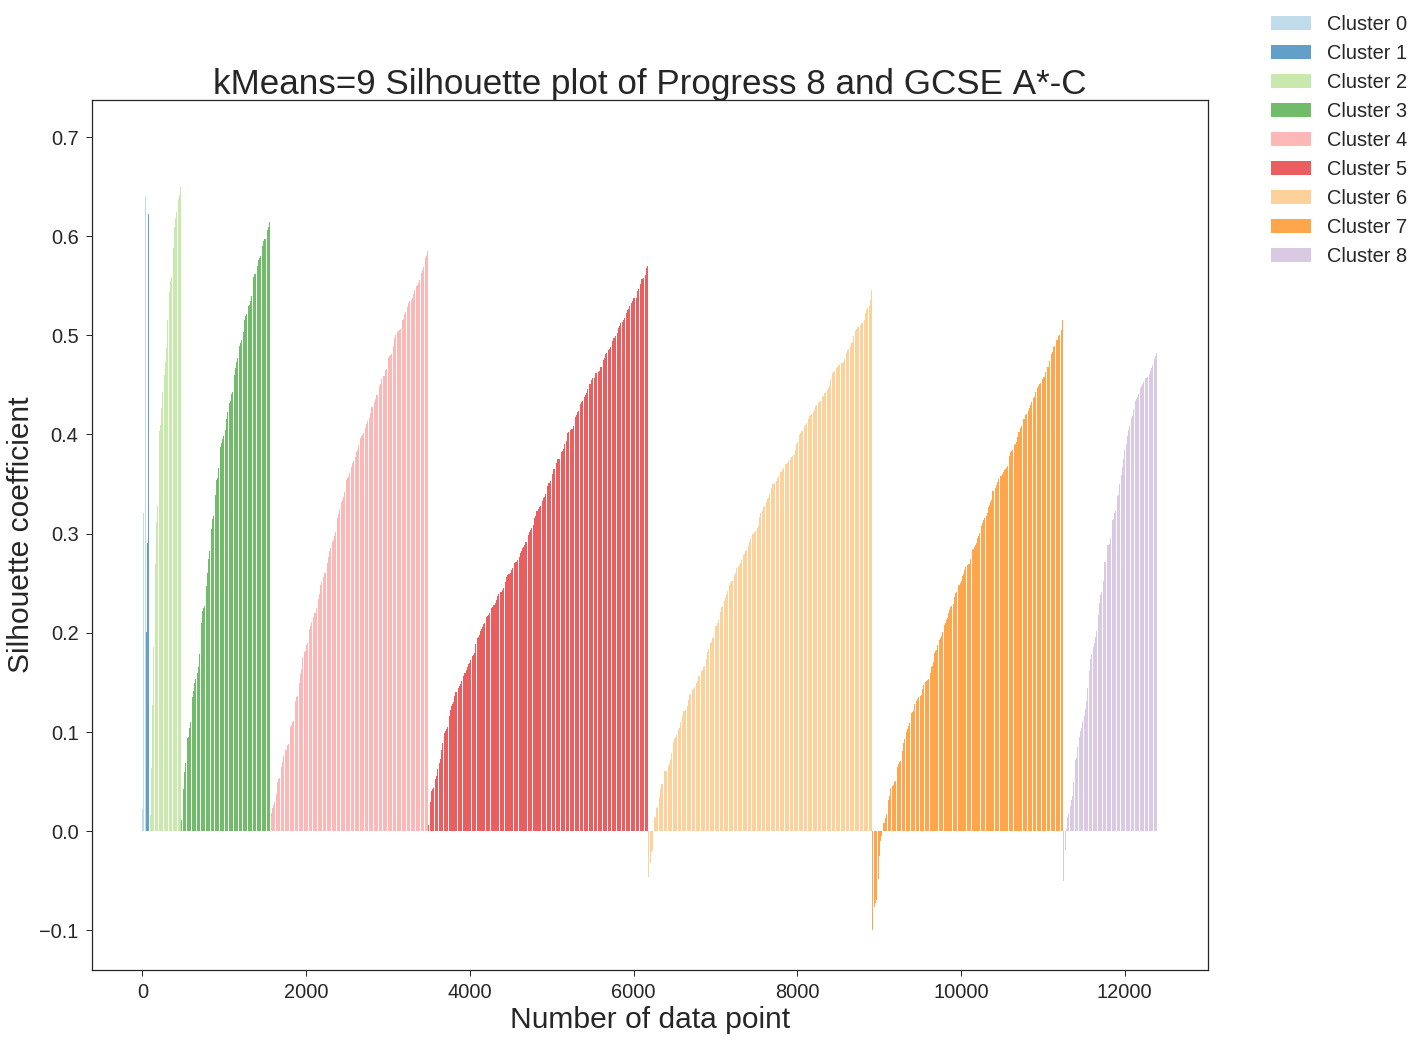

In [190]:
# sort the dataframe so we can see a curve
silhouette_plot_data_df = ks4_results_df.sort_values(['cluster', 'silhouette'])
silhouette_plot_data_df.index = list(range(len(silhouette_plot_data_df)))

colours = sns.palettes.color_palette(n_colors=len(set(ks4_results_df['cluster'])))

for clust in set(silhouette_plot_data_df['cluster']):
    plt.bar(silhouette_plot_data_df[silhouette_plot_data_df['cluster']==clust].index,
            silhouette_plot_data_df[silhouette_plot_data_df['cluster']==clust]['silhouette'],
            color=colours[clust], alpha=0.7, label='Cluster ' + str(clust))
    
plt.title('kMeans=9 Silhouette plot of Progress 8 and GCSE A*-C')
plt.legend(loc=(1.05,0.8))

plt.xlabel('Number of data point')
plt.ylabel('Silhouette coefficient')

plt.savefig('plot_images/silhouette_k9_P8_AC5.png')


Still no real improvement on the silhouette coefficients and there are still some overlapping groups.  This isn't the grouping I was hoping for to help me clarify the performance measures. 

But it has enabled me to gain a better insight to the spread of the data. I'll take a look at the Attainment 8 and GCSE 5+A*-C now in case it is better.

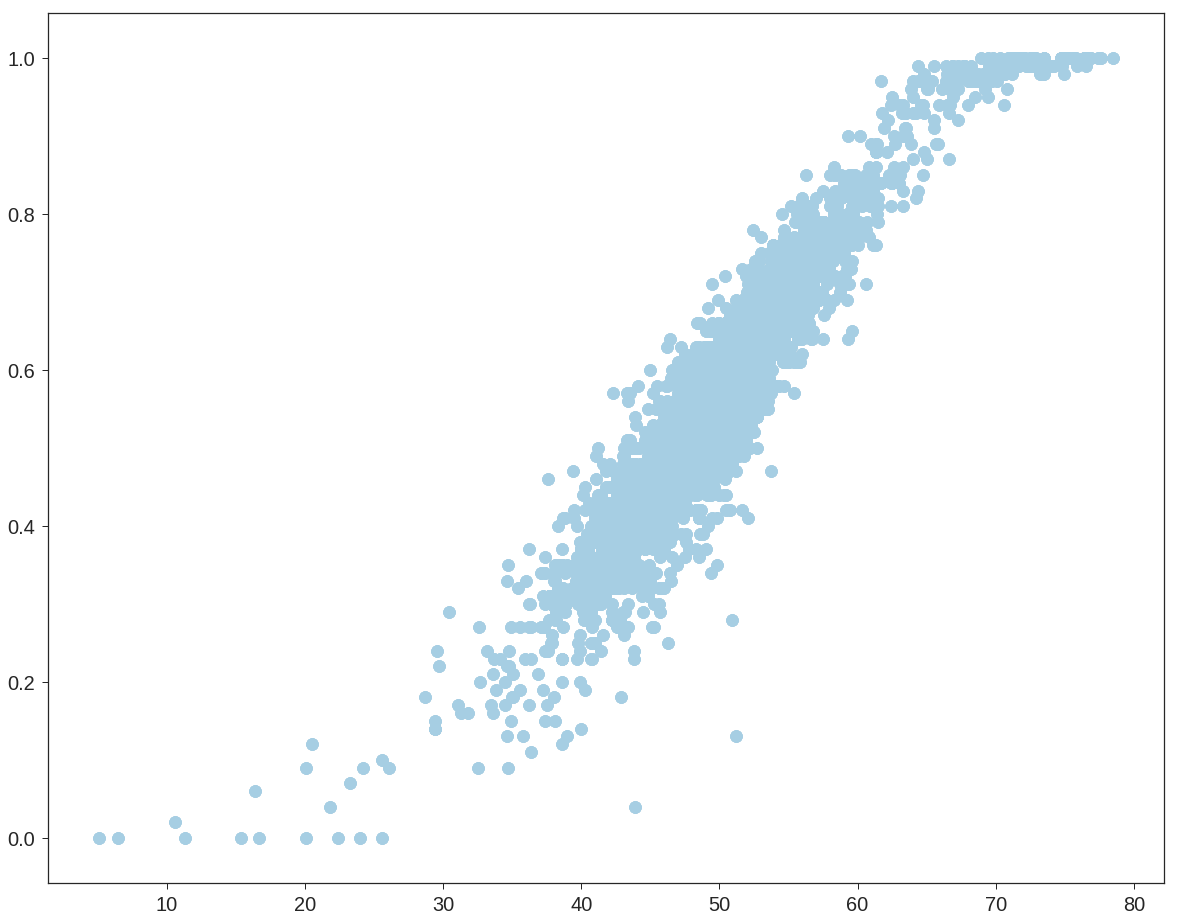

In [191]:
plt.scatter(x=ks4_results_df['ATT8SCR'], y=ks4_results_df['PTAC5EM_PTQ_EE'])

This scatter is a little less spread.  It may give a better range of values and is a good measure of the final results KS4 students achieve.

So our new measures will be:
 - Attainment 8
 - GCSE 5+ A*-C

## Cluster Groups of Attainment 8 and the GCSE 5+ A*-C measures

In [192]:
# Drop the added columns
if 'cluster' in ks4_results_df.columns:
    ks4_results_df.drop(['cluster', 'silhouette'], inplace=True, axis=1)

In [193]:
ks4_results_df.columns


Index(['ATT8SCR', 'NFTYPE', 'P8MEA', 'PTAC5EM_PTQ_EE', 'PTEBACC_PTQ_EE',
       'URN'],
      dtype='object')

Iterate with different k values (2 - 8) and plot each one.

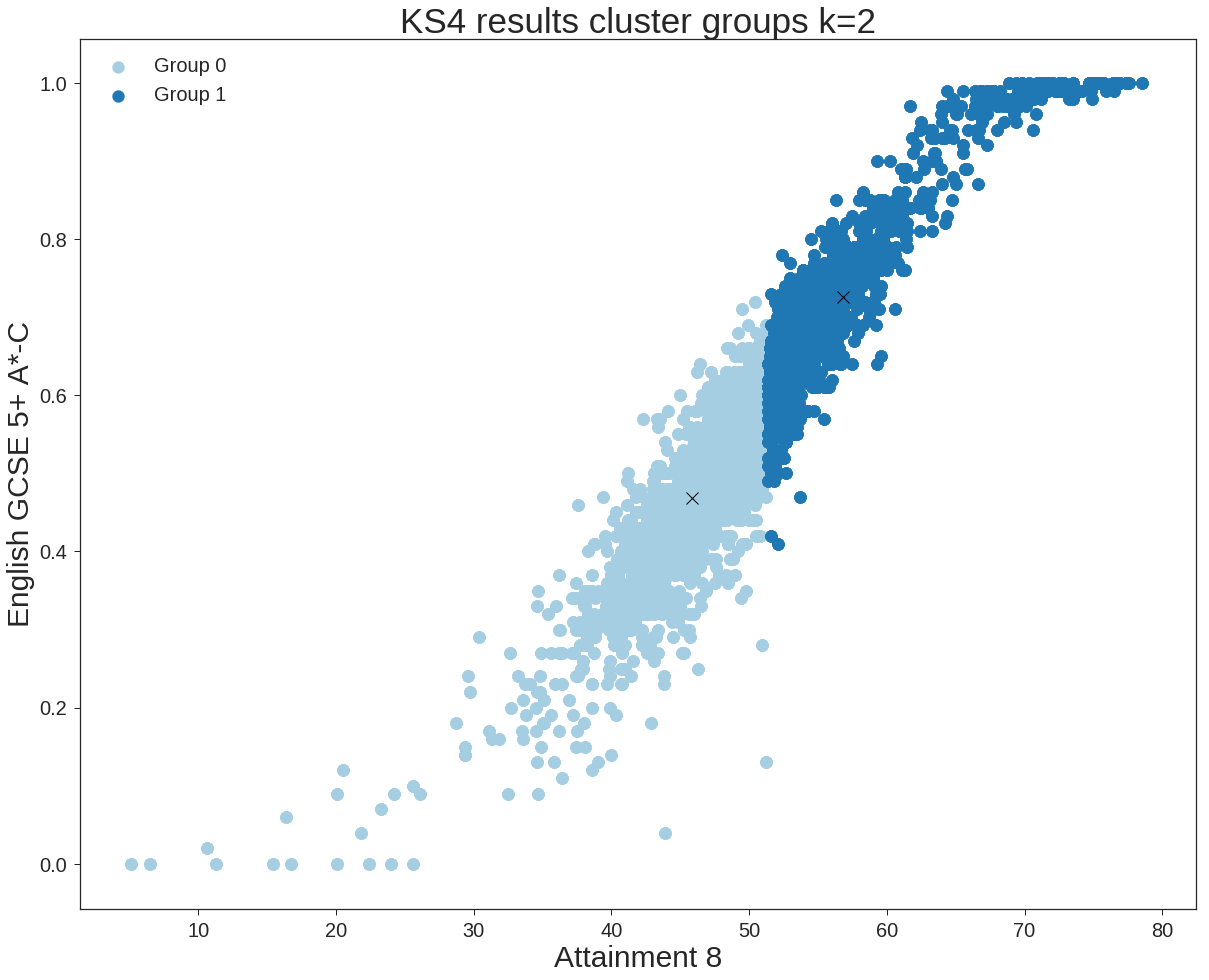

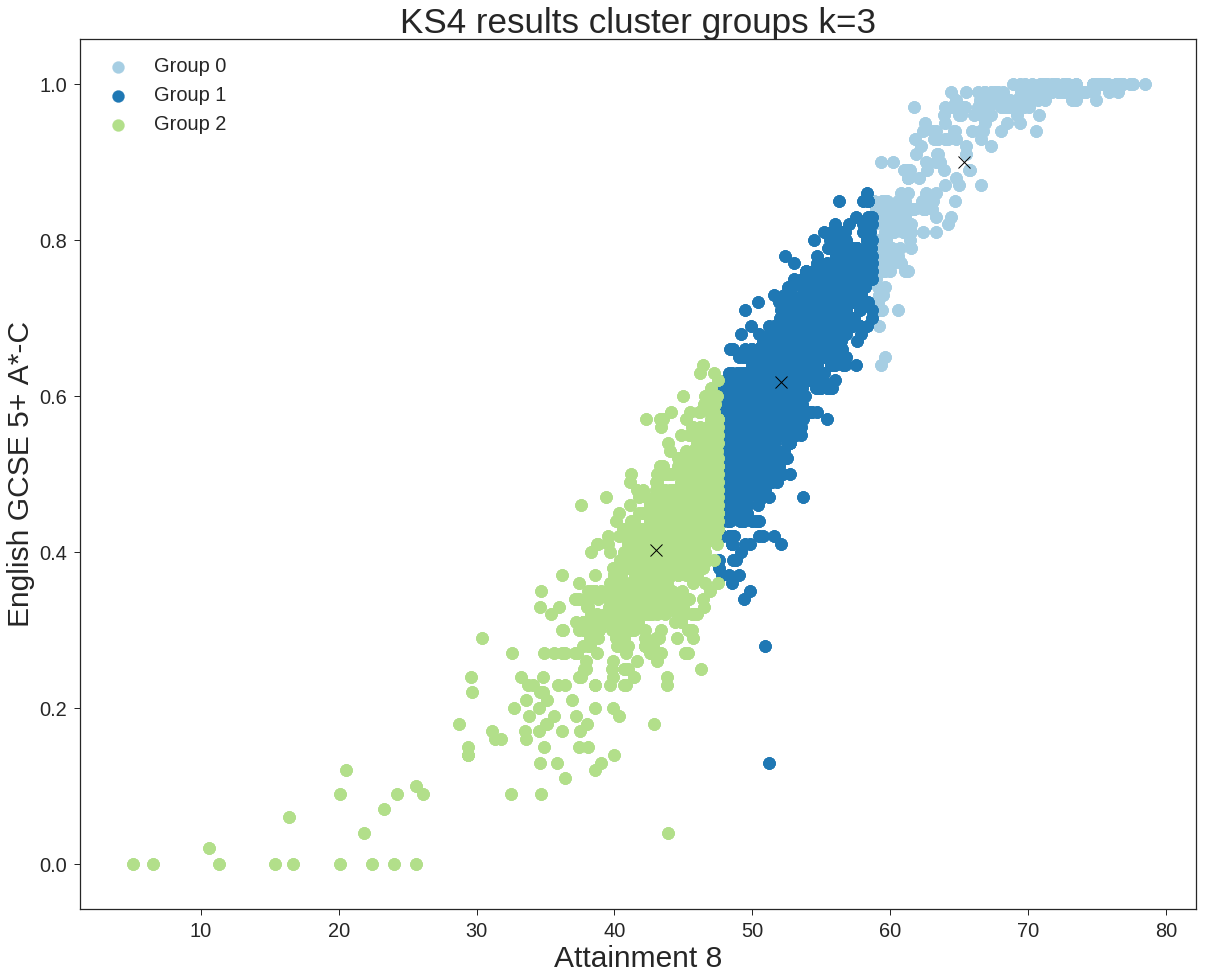

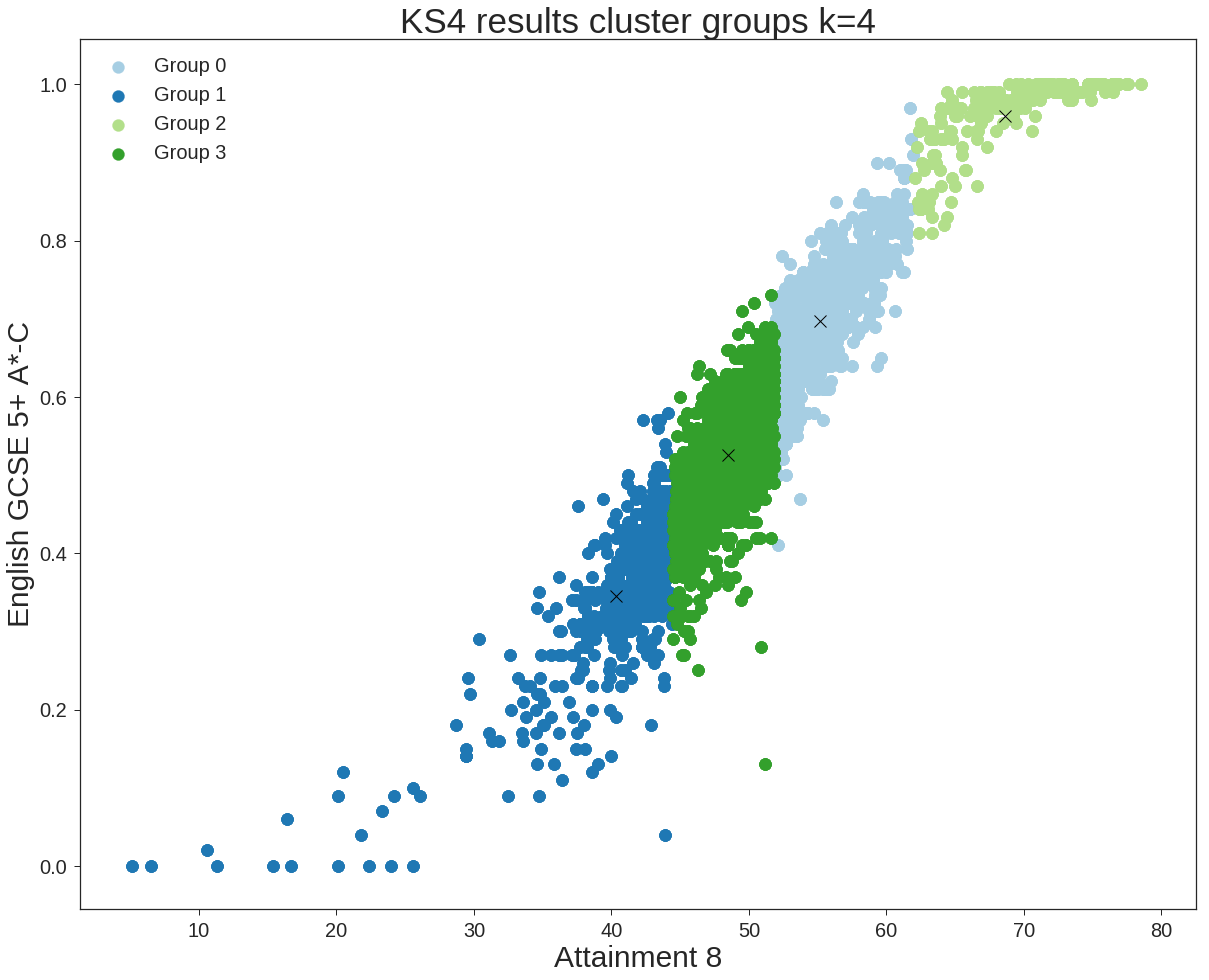

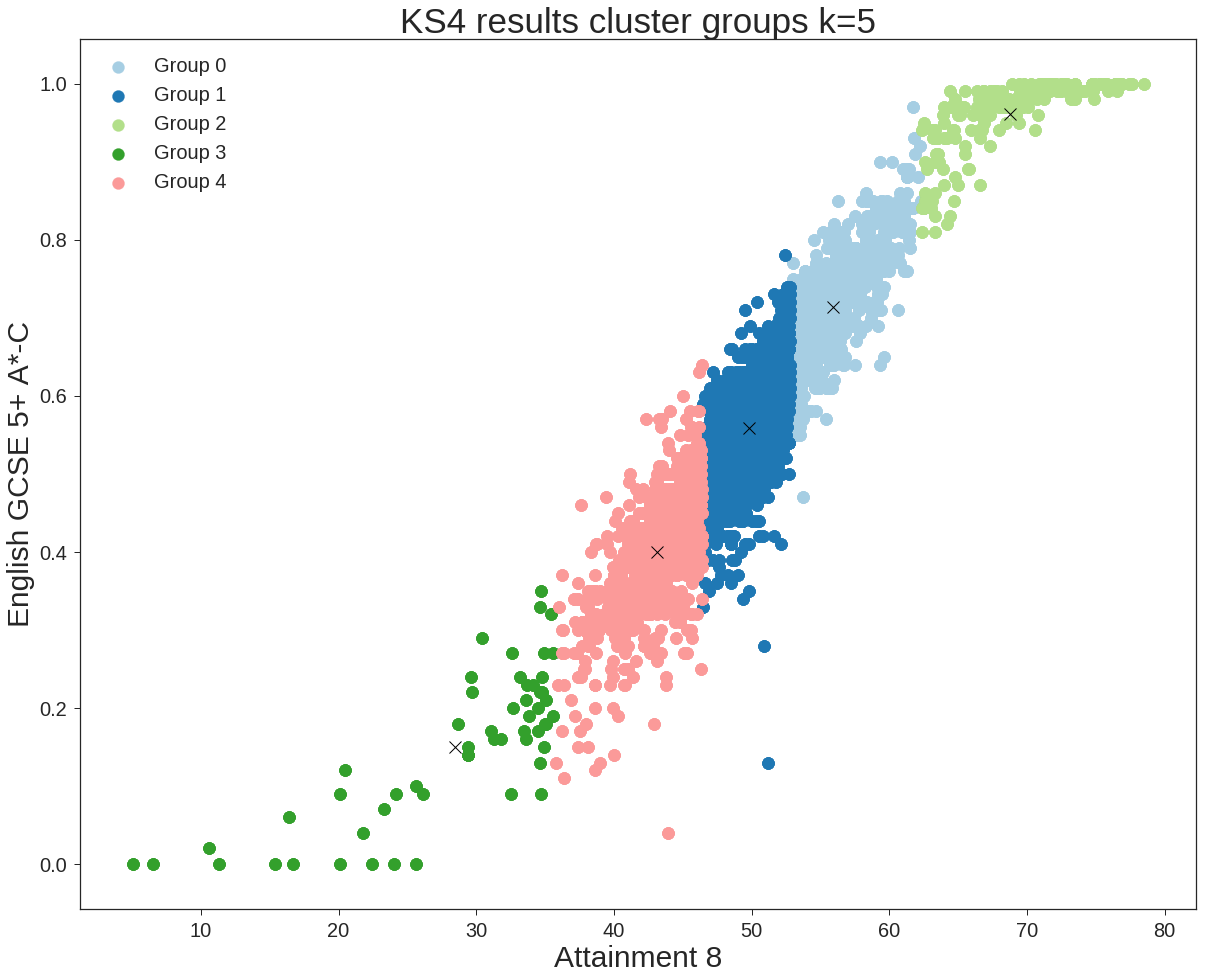

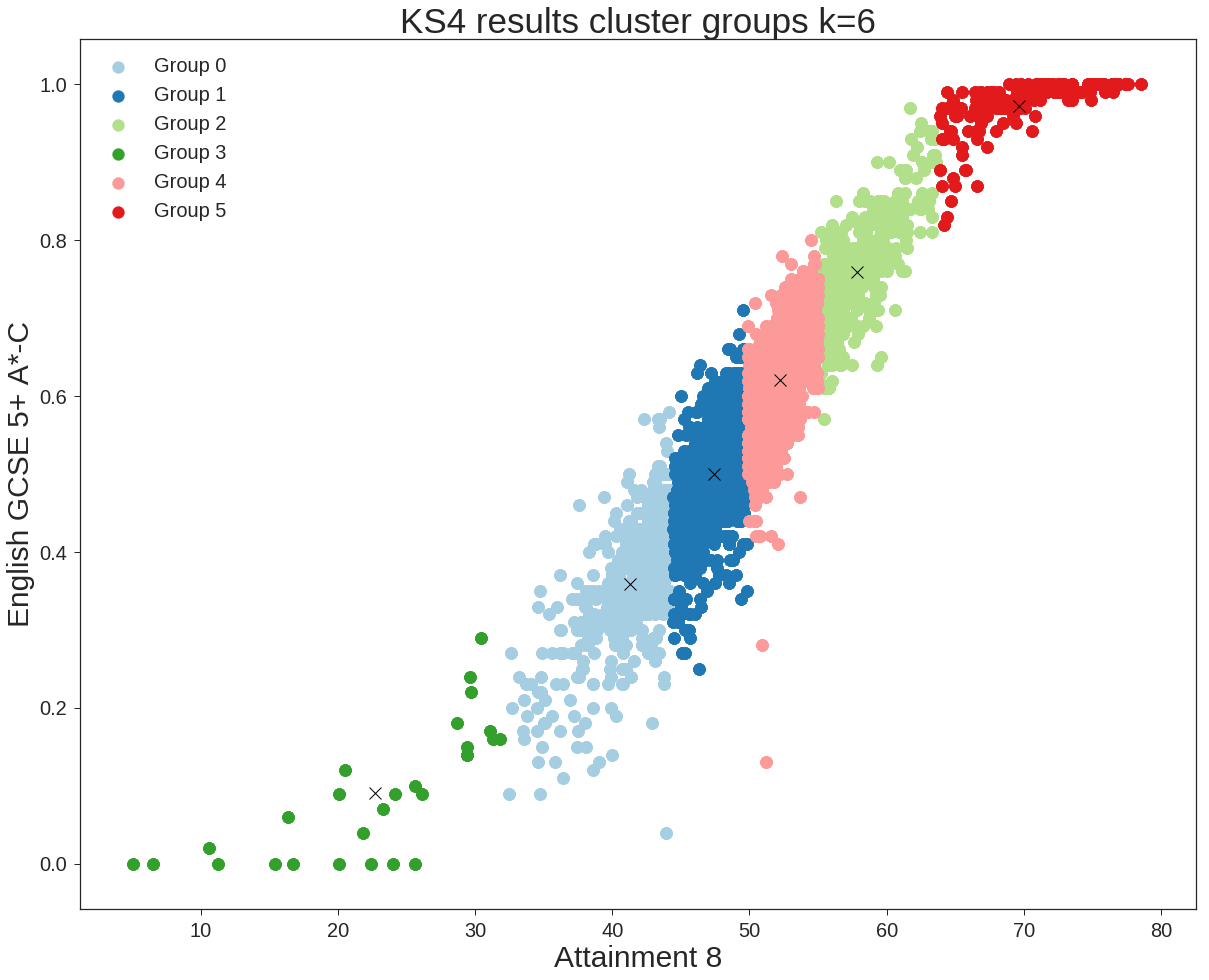

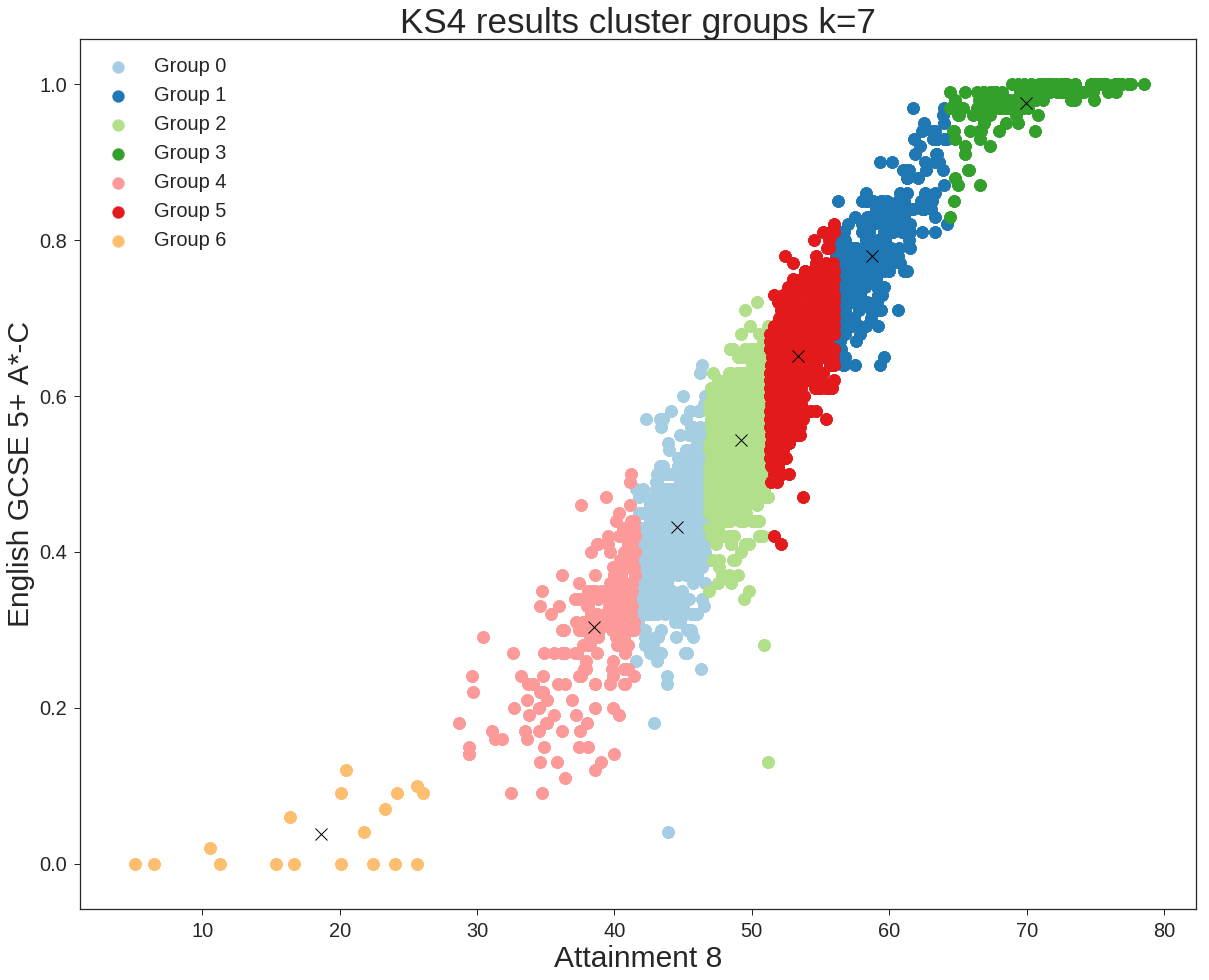

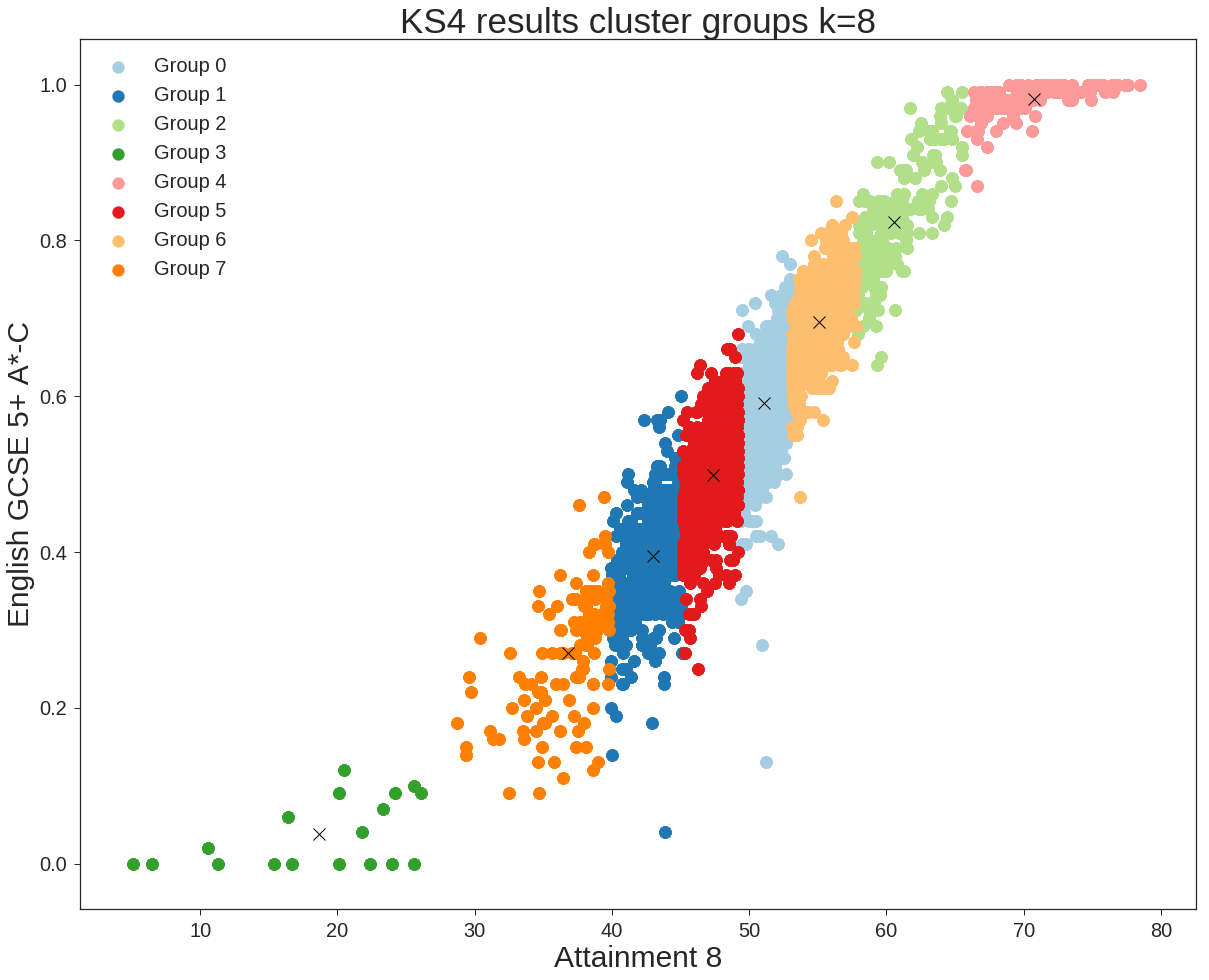

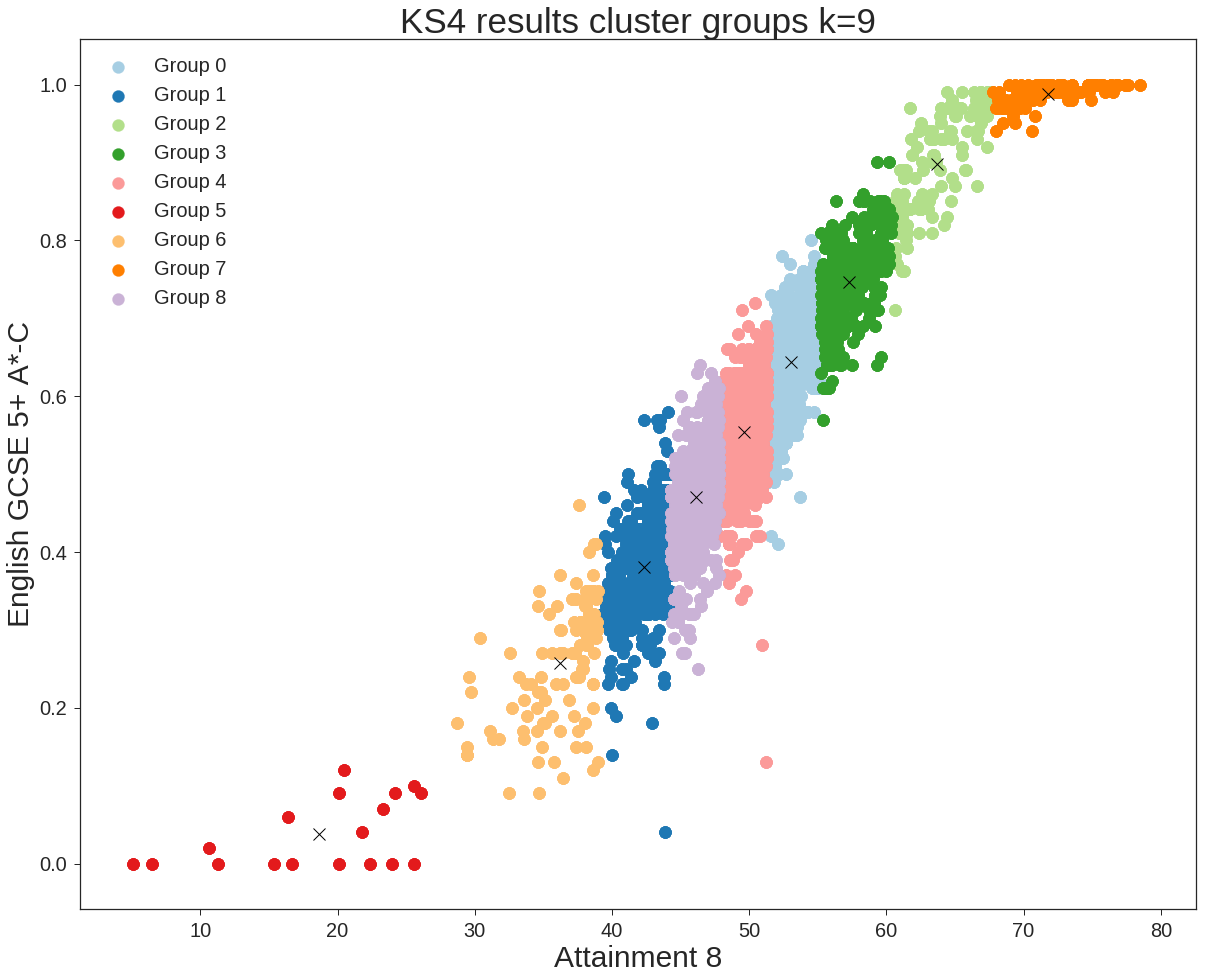

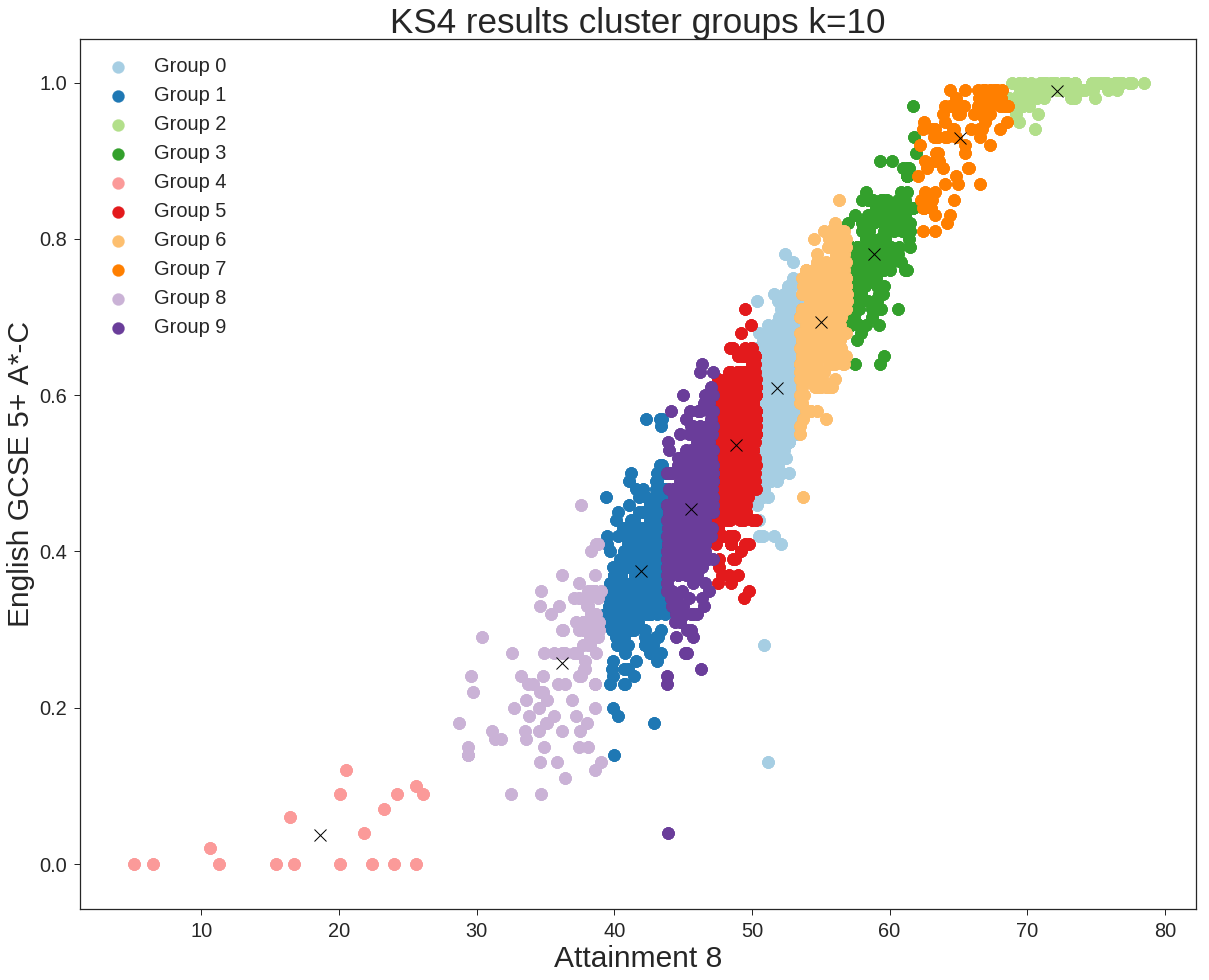

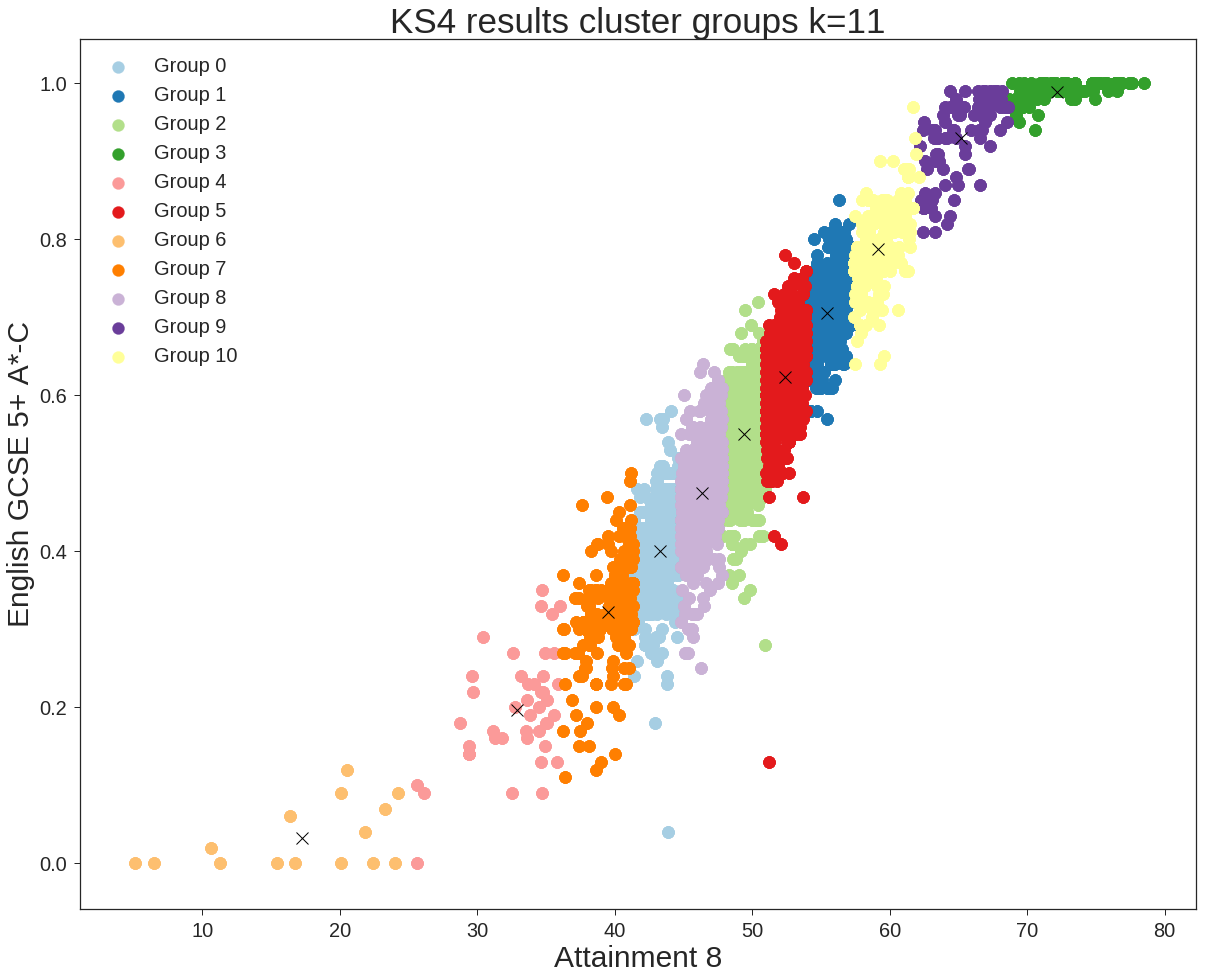

In [194]:
for k in range(2,12):
    title = 'KS4 results cluster groups k=' + str(k)
    cluster_labels = ['Group ' + str(i) for i in range(k)]
    kmeans_plot(ks4_results_df, 'ATT8SCR', 'PTAC5EM_PTQ_EE', k=k,
                plt_title=title, cluster_labels=cluster_labels,
                plt_labels=['Attainment 8', 'English GCSE 5+ A*-C'])

Again these are all quite spread out with values ranging quite a lot from one cluster to another, making it hard to use as ameasure for school types. I'll try a very high k value of 11 kmeans.  I'll quickly run the silouette tests again.

## KMeans clustering of Attainment 8 and GCSE 5+ A*-C results

In [195]:
colour_map = sns.palettes.color_palette(n_colors=5)

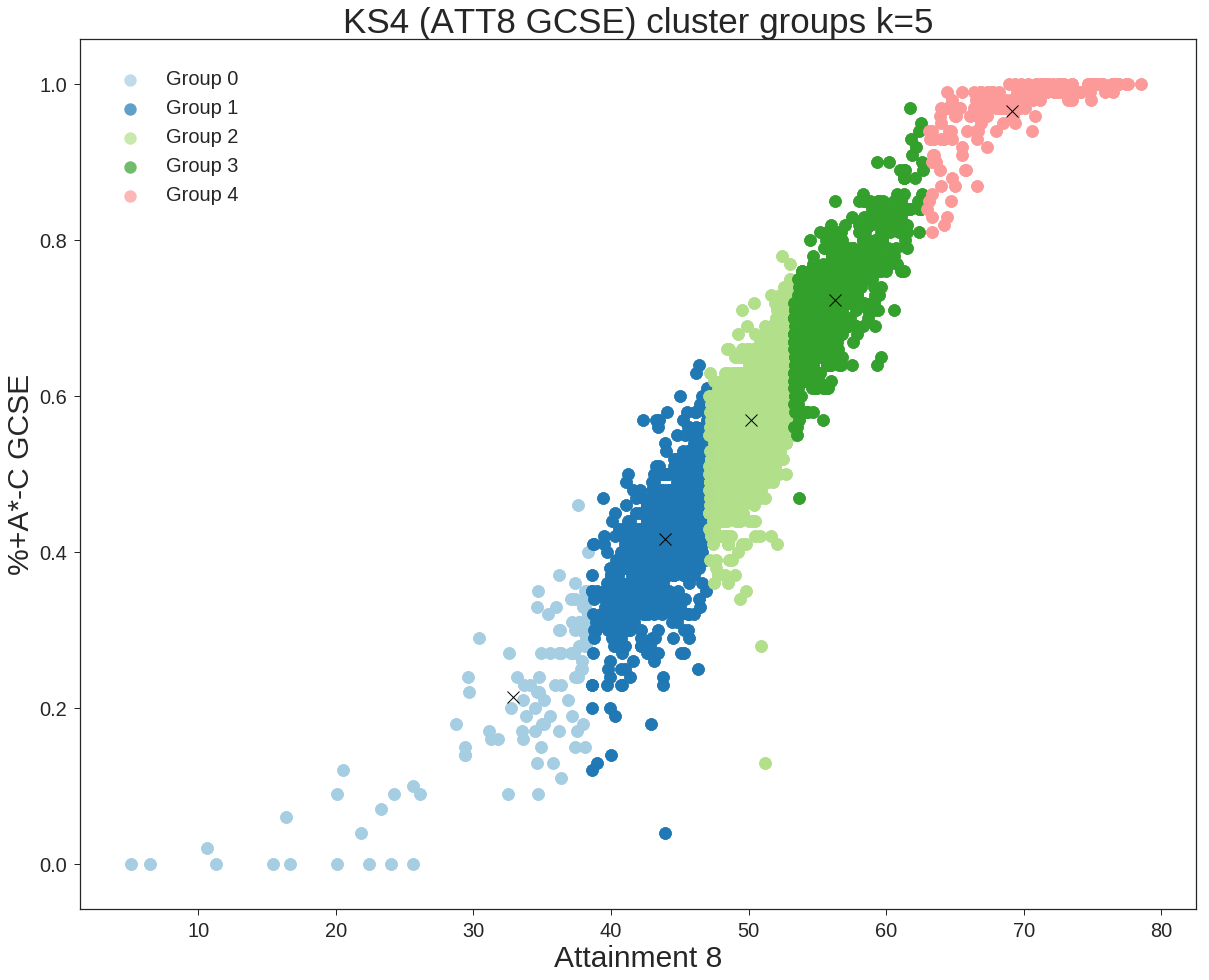

In [196]:
# set the title I want to use
title = 'KS4 (ATT8 GCSE) cluster groups k=5'

# so that it always runs the same I need to initialise centroids in this case
init_centroids = pd.DataFrame({'ATT8SCR': [0.2, 0.4, 0.5, 0.6, 0.8],
                                'PTAC5EM_PTQ_EE': [30, 45, 50, 55, 60]},
                              columns=['ATT8SCR', 'PTAC5EM_PTQ_EE'])

# initialise the kmeans cluster
kmeans5 = cluster.KMeans(n_clusters=5, init=init_centroids, n_init=1)

# fit it to the data
assigned_clusters = kmeans5.fit(ks4_results_df[['ATT8SCR', 'PTAC5EM_PTQ_EE']])

# plot the results
plot_cluster_2(ks4_results_df['ATT8SCR'], ks4_results_df['PTAC5EM_PTQ_EE'], 
               assigned_clust=assigned_clusters, k=5,
               plt_title=title,
               plt_labels=['Attainment 8', '%+A*-C GCSE'],
               legend_loc=(0.02, 0.8),
               colors=colour_map,
               opacity=0.7,
               save=True)

Again the clusters appear to be separated into groups around the result bands. The range of values looks slightly less than with the P8Measure we looked at earlier.  I'll run a silouette analysis on them to see whether they are suitable.

## Silhouette analysis of kMeans 5 clustering.

In [197]:
# create a column on the results data for each value
ks4_results_df['cluster'] = pd.Series(assigned_clusters.labels_)

In [198]:
# check it looks ok.
ks4_results_df.head()

ATT8SCR NFTYPE  P8MEA  PTAC5EM_PTQ_EE  PTEBACC_PTQ_EE     URN  cluster
0     50.1     CY  -0.26            0.53            0.30  100053        2
1     60.1     VA   0.31            0.77            0.60  100054        3
2     50.0     CY   0.09            0.52            0.33  100052        2
3     47.0     CY  -0.11            0.47            0.09  100049        1
4     57.6     VA   0.41            0.74            0.28  100059        3

Calculate the silhouette coefficients

In [199]:
# from notebook 21.3
# Add the silhouette coefficients as a new column in the
# ks4_results_df:
ks4_results_df['silhouette'] = silhouette_samples(ks4_results_df[['ATT8SCR', 'PTAC5EM_PTQ_EE']],
                                                             np.array(ks4_results_df['cluster']))

ks4_results_df.head()

ATT8SCR NFTYPE  P8MEA  PTAC5EM_PTQ_EE  PTEBACC_PTQ_EE     URN  cluster  \
0     50.1     CY  -0.26            0.53            0.30  100053        2   
1     60.1     VA   0.31            0.77            0.60  100054        3   
2     50.0     CY   0.09            0.52            0.33  100052        2   
3     47.0     CY  -0.11            0.47            0.09  100049        1   
4     57.6     VA   0.41            0.74            0.28  100059        3   

   silhouette  
0    0.762589  
1    0.557305  
2    0.757928  
3    0.023254  
4    0.685020

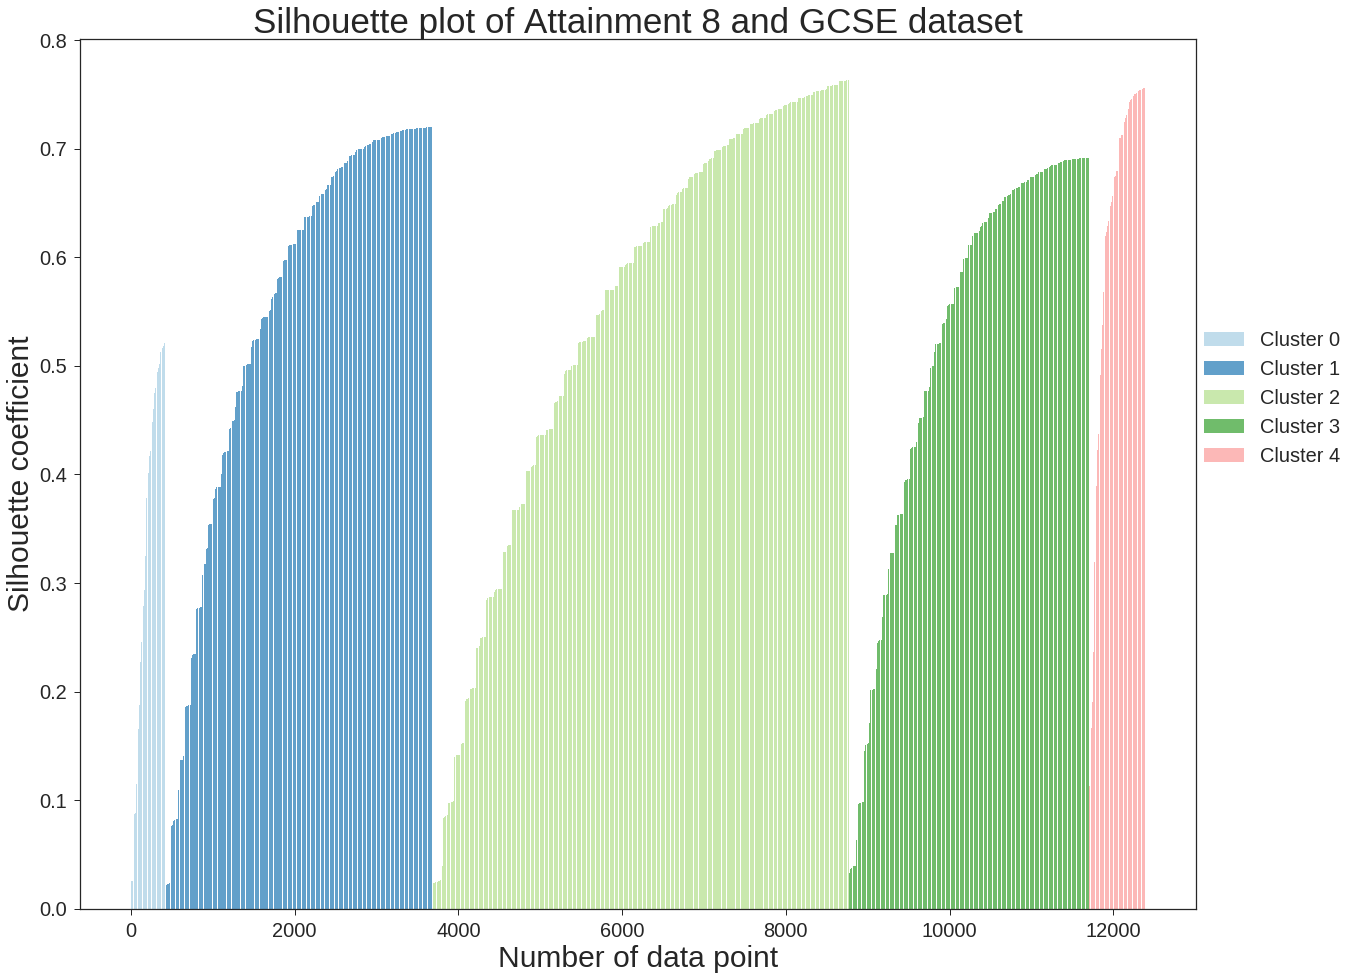

In [200]:
# sort the dataframe so we can see a curve
silhouette_plot_data_df = ks4_results_df.sort_values(['cluster', 'silhouette'])
silhouette_plot_data_df.index = list(range(len(silhouette_plot_data_df)))


for clust in set(silhouette_plot_data_df['cluster']):
    plt.bar(silhouette_plot_data_df[silhouette_plot_data_df['cluster']==clust].index,
            silhouette_plot_data_df[silhouette_plot_data_df['cluster']==clust]['silhouette'],
            color=colour_map[clust], alpha=0.7, label='Cluster ' + str(clust))
    
plt.title('Silhouette plot of Attainment 8 and GCSE dataset')
plt.legend(loc=(1, 0.5))

plt.xlabel('Number of data point')
plt.ylabel('Silhouette coefficient')

plt.savefig('plot_images/silhouette_k9_A8_AC5.png')


These clusters look to have less crossover which is good as I can't see any negative values.  However, the range of silhouette values is still extremely wide.  So it makes it hard to see this as being a useful grouping to divide the dataset into performance.

I will use it to double check the school types quicky though.


These cluster groupings indicate that there is probably some spread in the data.  I'm going to go back to the dataframe and plot out the performance measures and colour code it by school type to see how they lie.

<a name="school_scatter"></a>

## School Scatter Analysis

In [201]:
# get a list of the school types and assign each a colour
school_code = list(set(ks4_results_df['NFTYPE']))

# # Make a colour map for each school type
# colour_map = sns.palettes.color_palette('paired', n_colors=len(school_code))

colour_map = sns.palettes.color_palette(palette='Paired', n_colors=12)

# add the colour column to the dataframe 
ks4_results_df['colour'] = ks4_results_df['NFTYPE'].apply(lambda x:colour_map[school_code.index(x)])


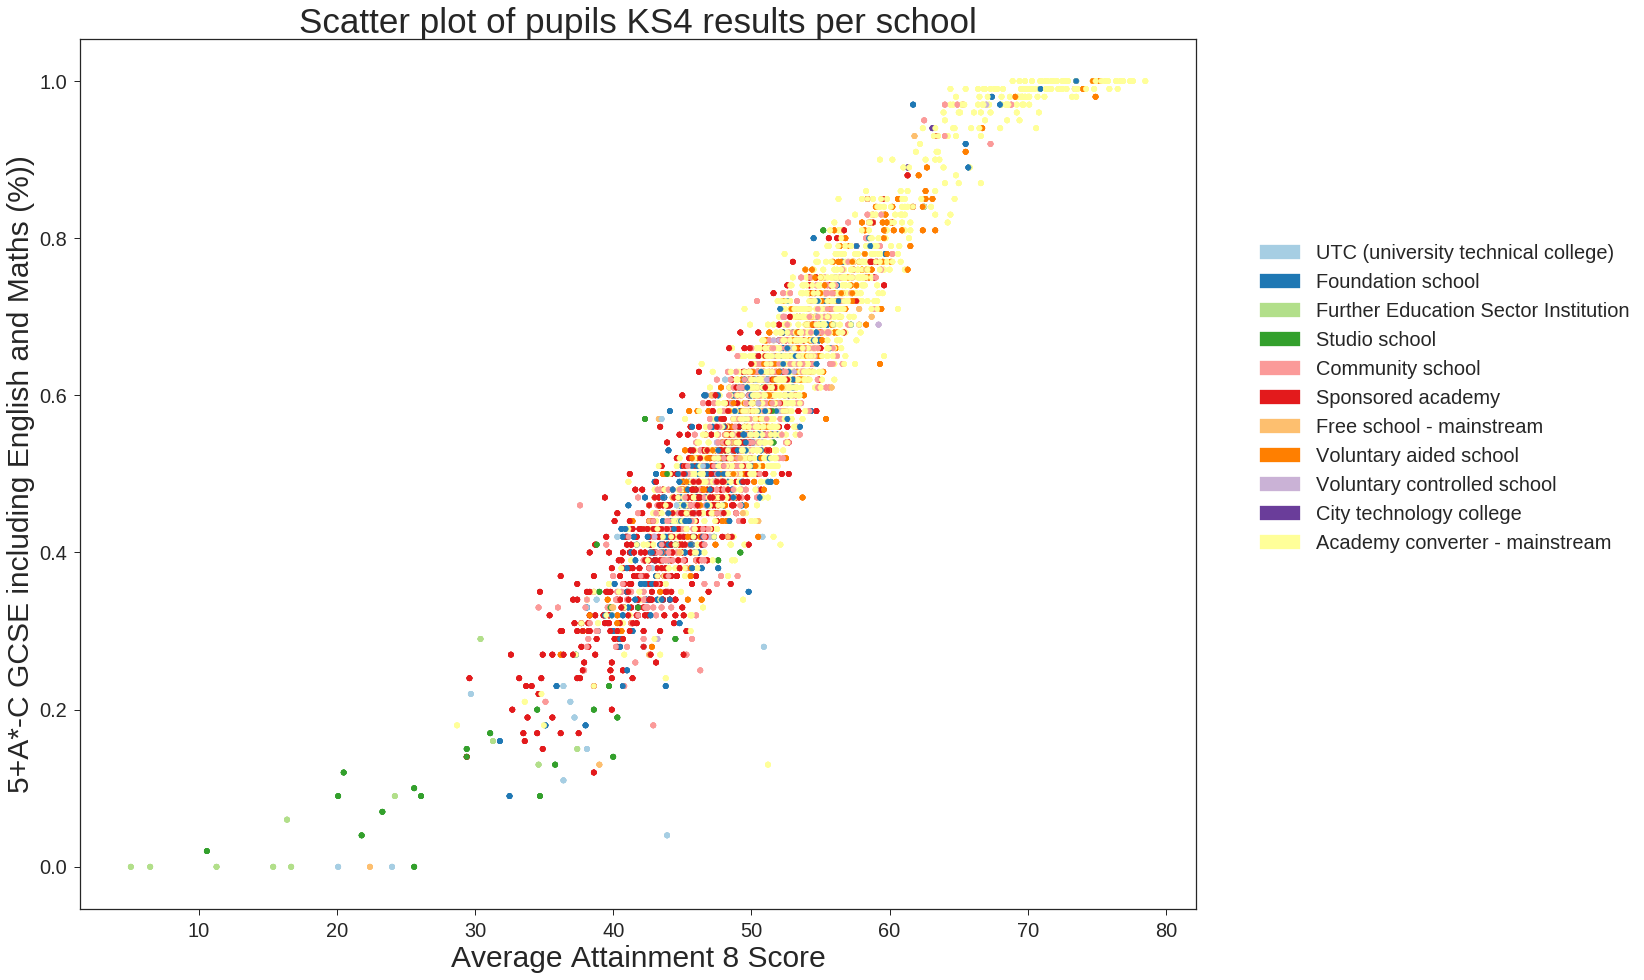

In [202]:
# plot them all to the same plot
ks4_results_df.plot.scatter(x='ATT8SCR', y='PTAC5EM_PTQ_EE',
                            s=30,
                            c=ks4_results_df['colour']
                           )

# add the title and axis labels
plt.title('Scatter plot of pupils KS4 results per school')
plt.xlabel('Average Attainment 8 Score')
plt.ylabel('5+A*-C GCSE including English and Maths (%))')

# add a legend to the scatter plot
import matplotlib.patches as mpatches
# make the legend handles
legend_handles = ([mpatches.Patch(color=colour_map[0], label=nftypes[school_code[0]])]+
                  [mpatches.Patch(color=colour_map[1], label=nftypes[school_code[1]])]+
                  [mpatches.Patch(color=colour_map[2], label=nftypes[school_code[2]])]+
                  [mpatches.Patch(color=colour_map[3], label=nftypes[school_code[3]])]+
                  [mpatches.Patch(color=colour_map[4], label=nftypes[school_code[4]])]+
                  [mpatches.Patch(color=colour_map[5], label=nftypes[school_code[5]])]+
                  [mpatches.Patch(color=colour_map[6], label=nftypes[school_code[6]])]+
                  [mpatches.Patch(color=colour_map[7], label=nftypes[school_code[7]])]+
                  [mpatches.Patch(color=colour_map[8], label=nftypes[school_code[8]])]+
                  [mpatches.Patch(color=colour_map[9], label=nftypes[school_code[9]])]+
                  [mpatches.Patch(color=colour_map[10], label=nftypes[school_code[10]])])
                
plt.legend(handles=legend_handles, loc=(1.05, 0.4))

plt.savefig('plot_images/scatter_schools_distribution_2.png')

I want to plot each school type to see it's distribution

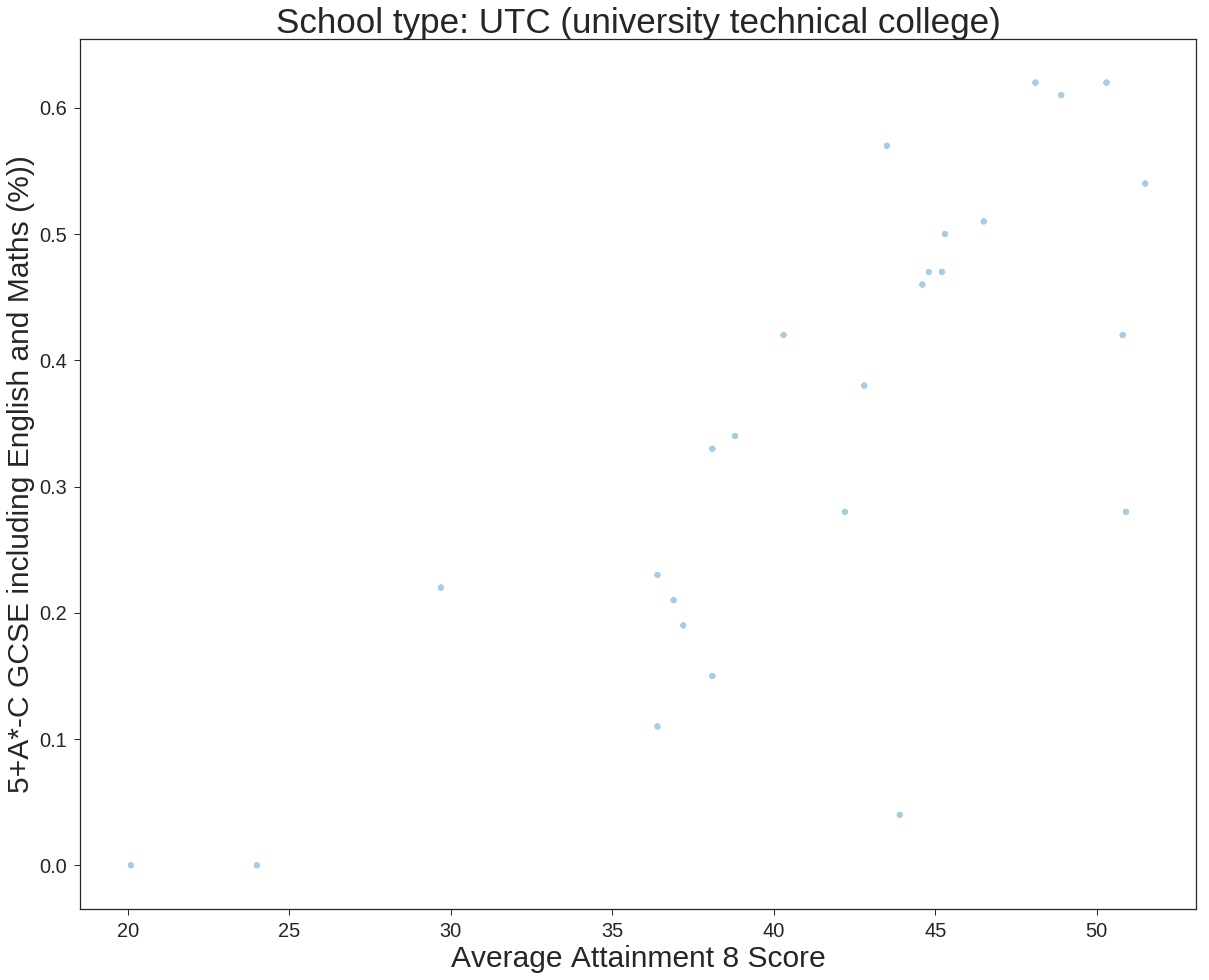

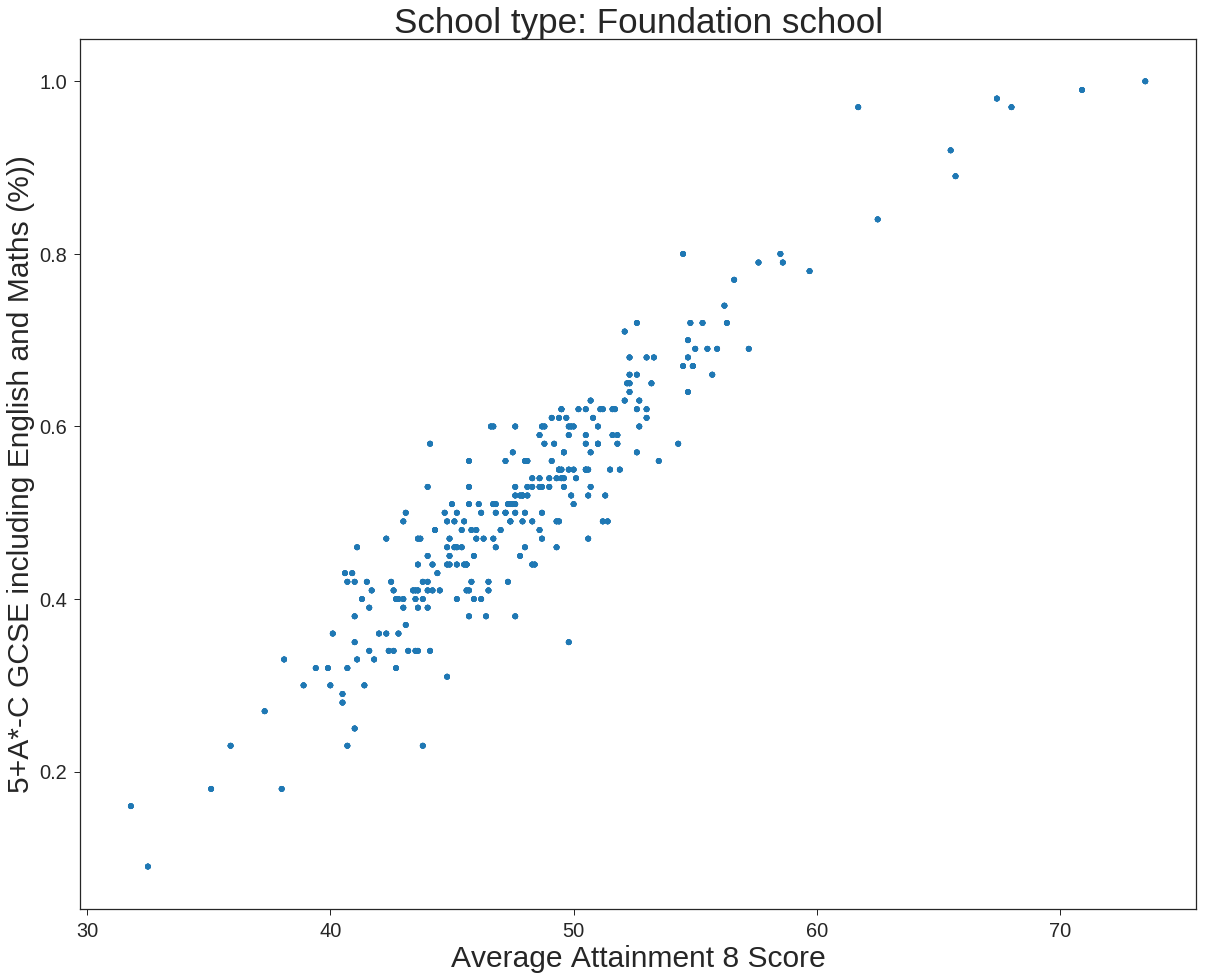

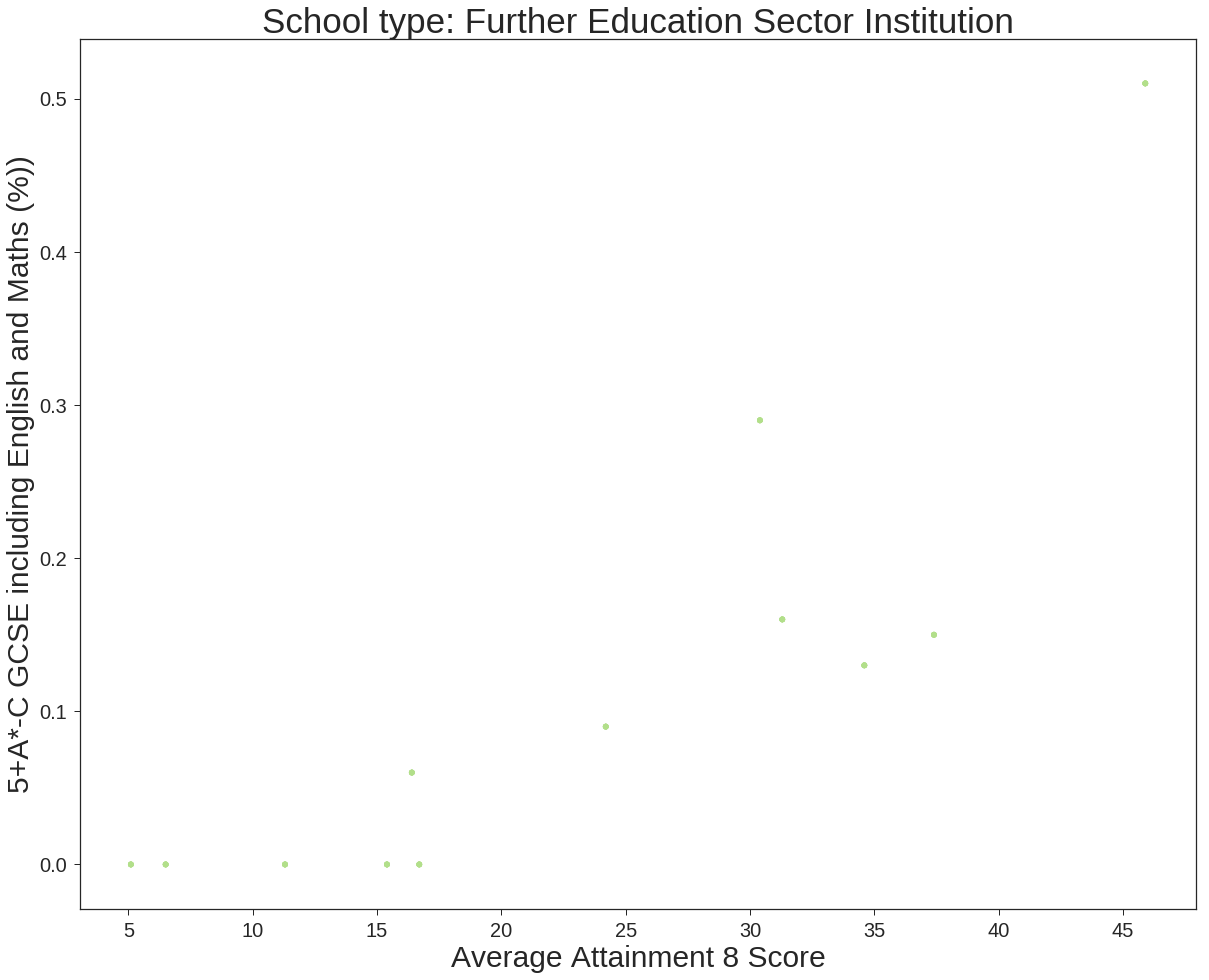

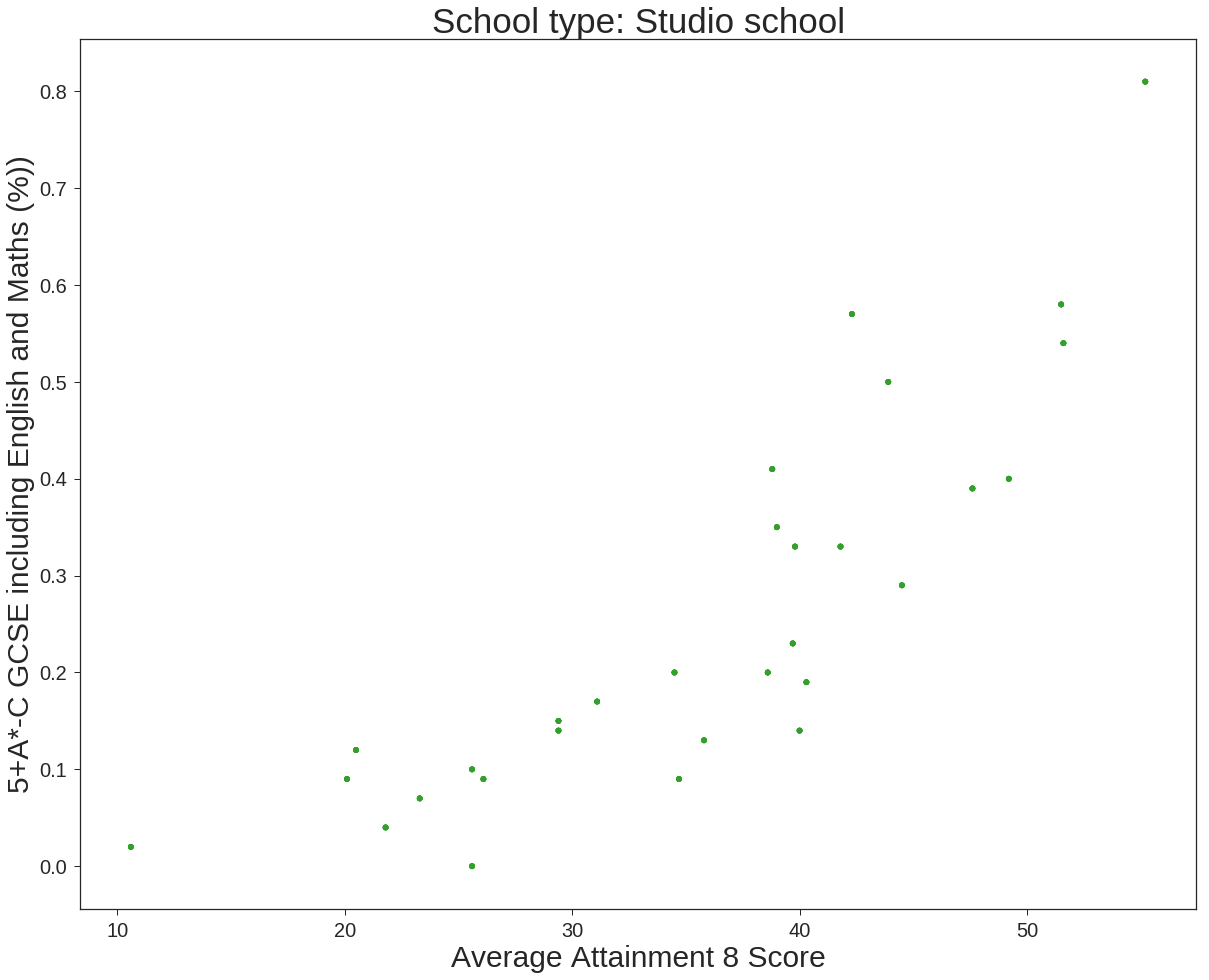

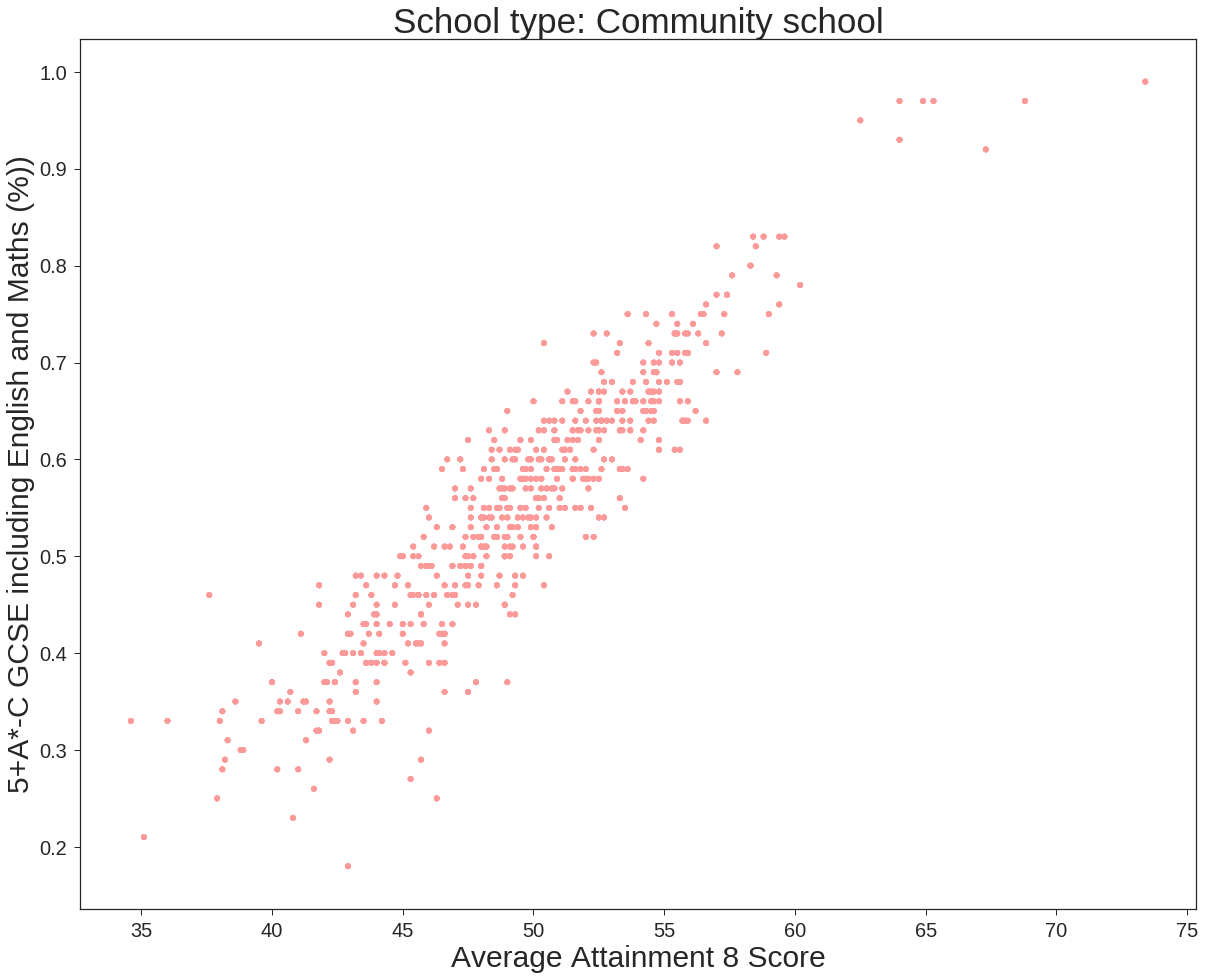

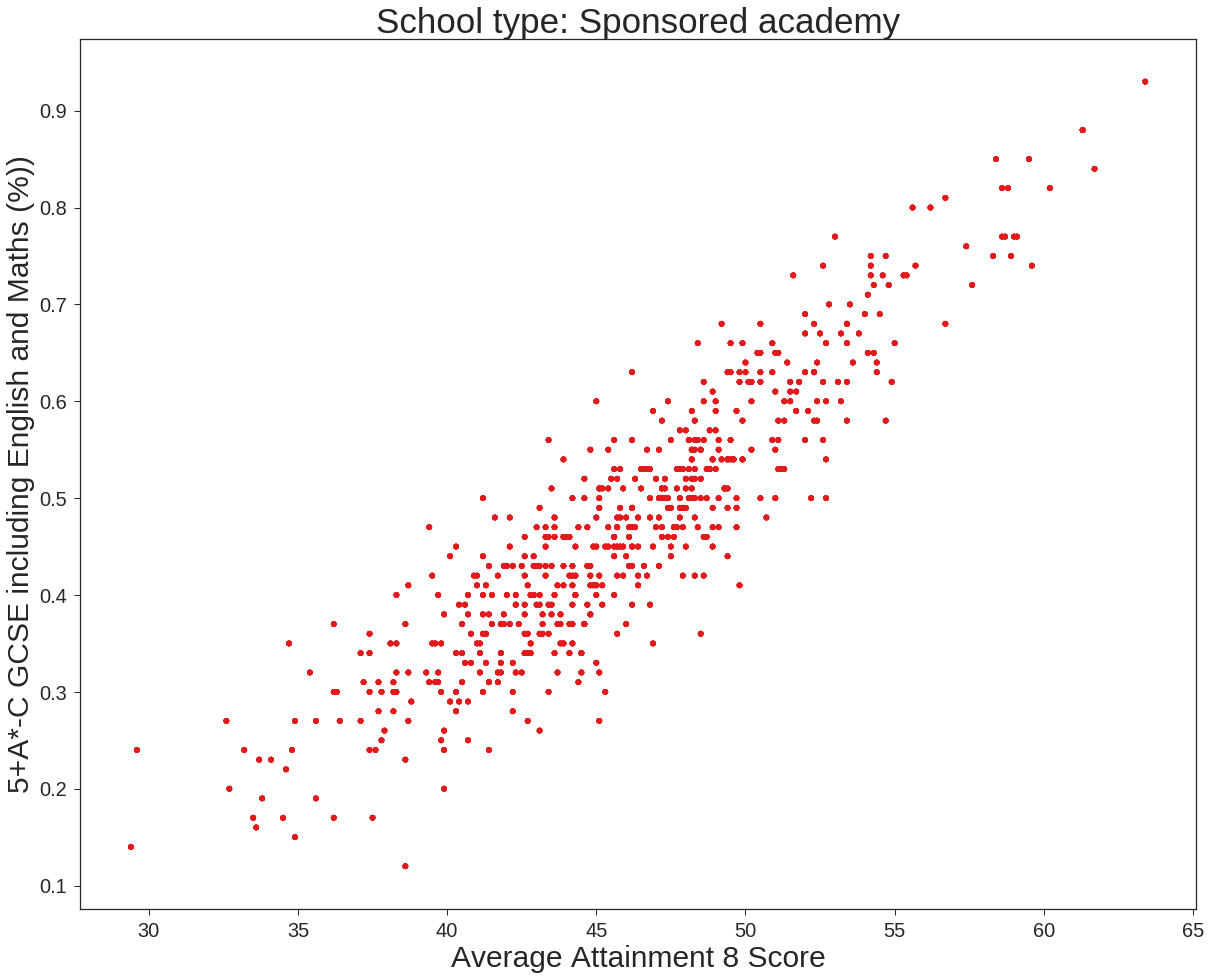

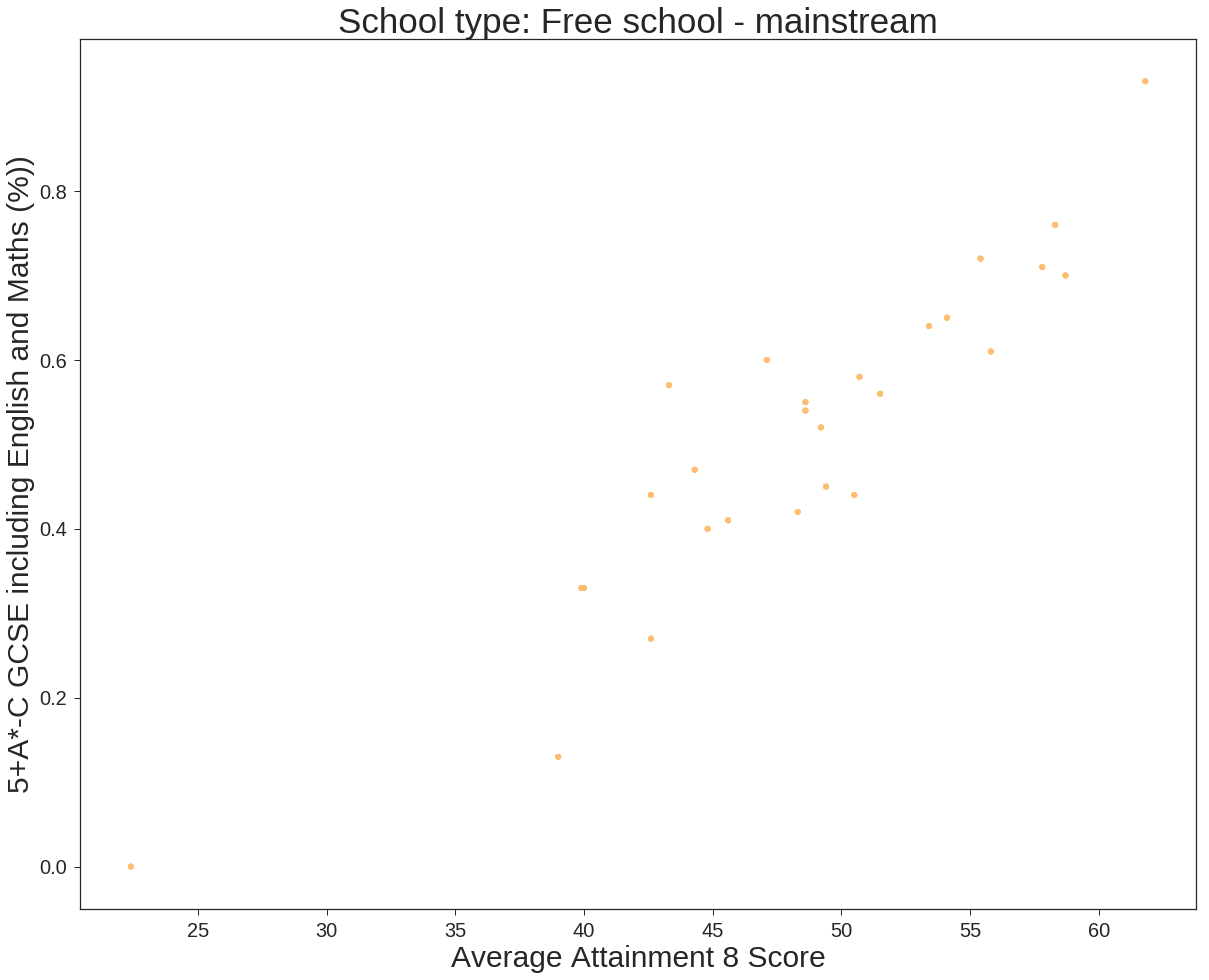

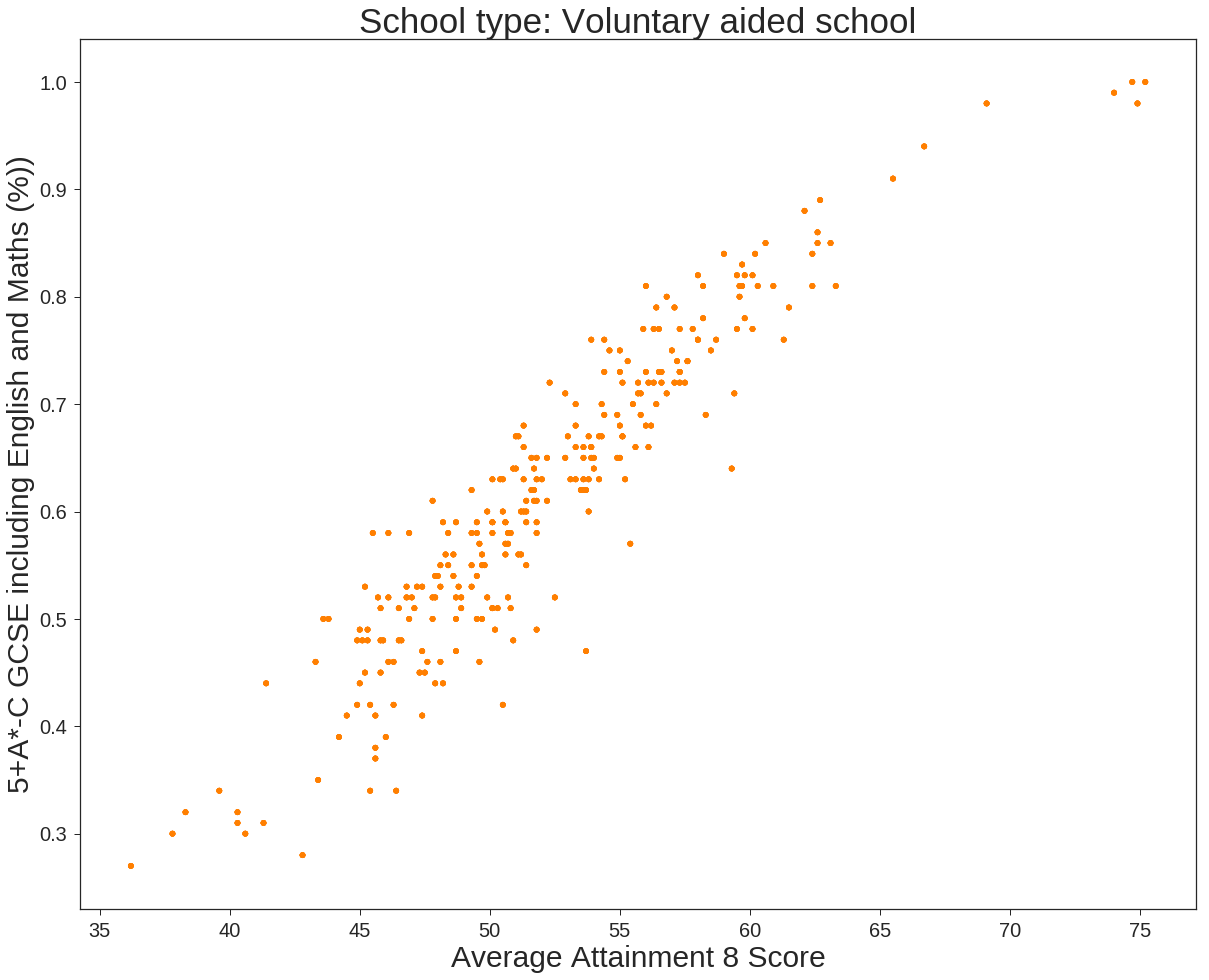

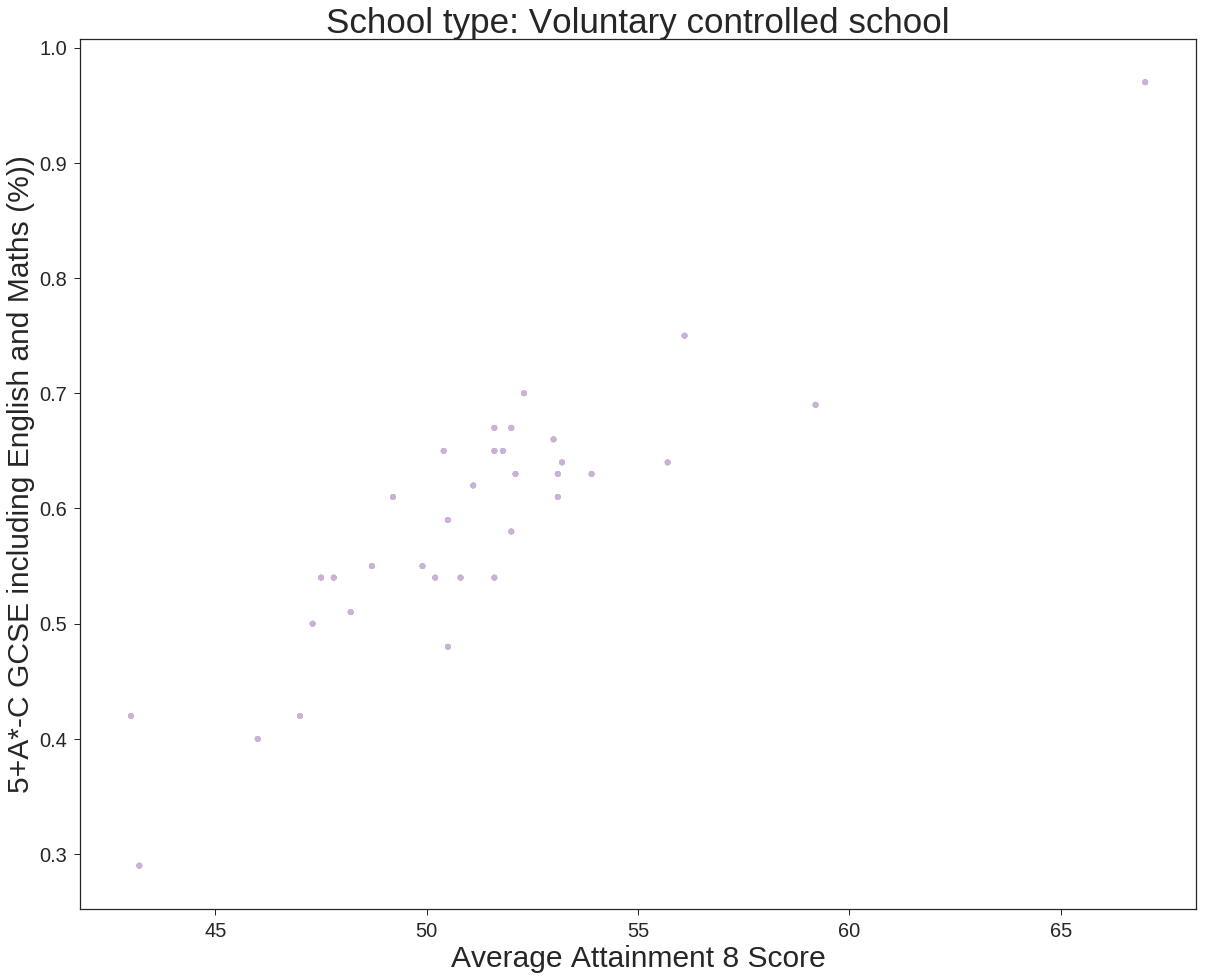

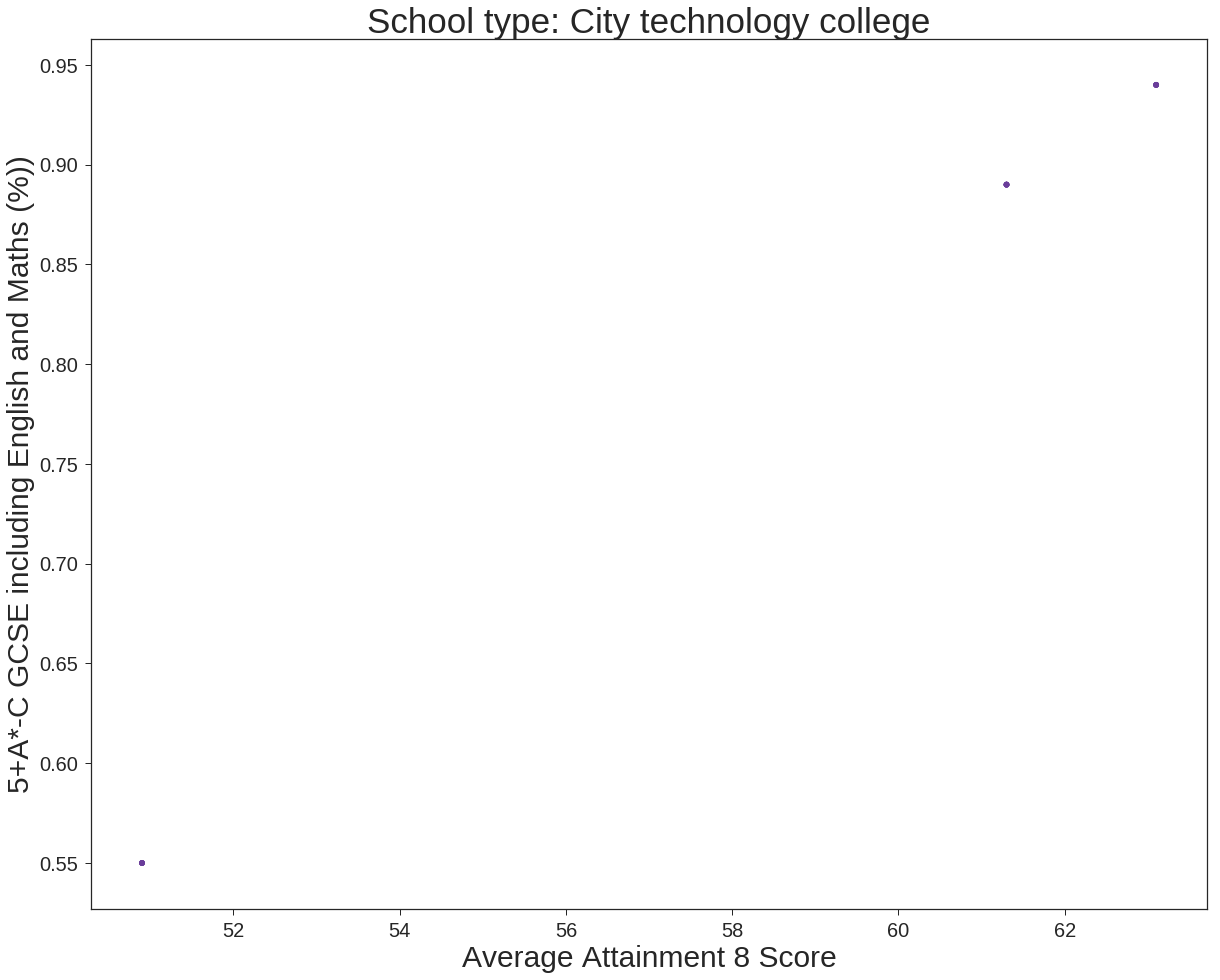

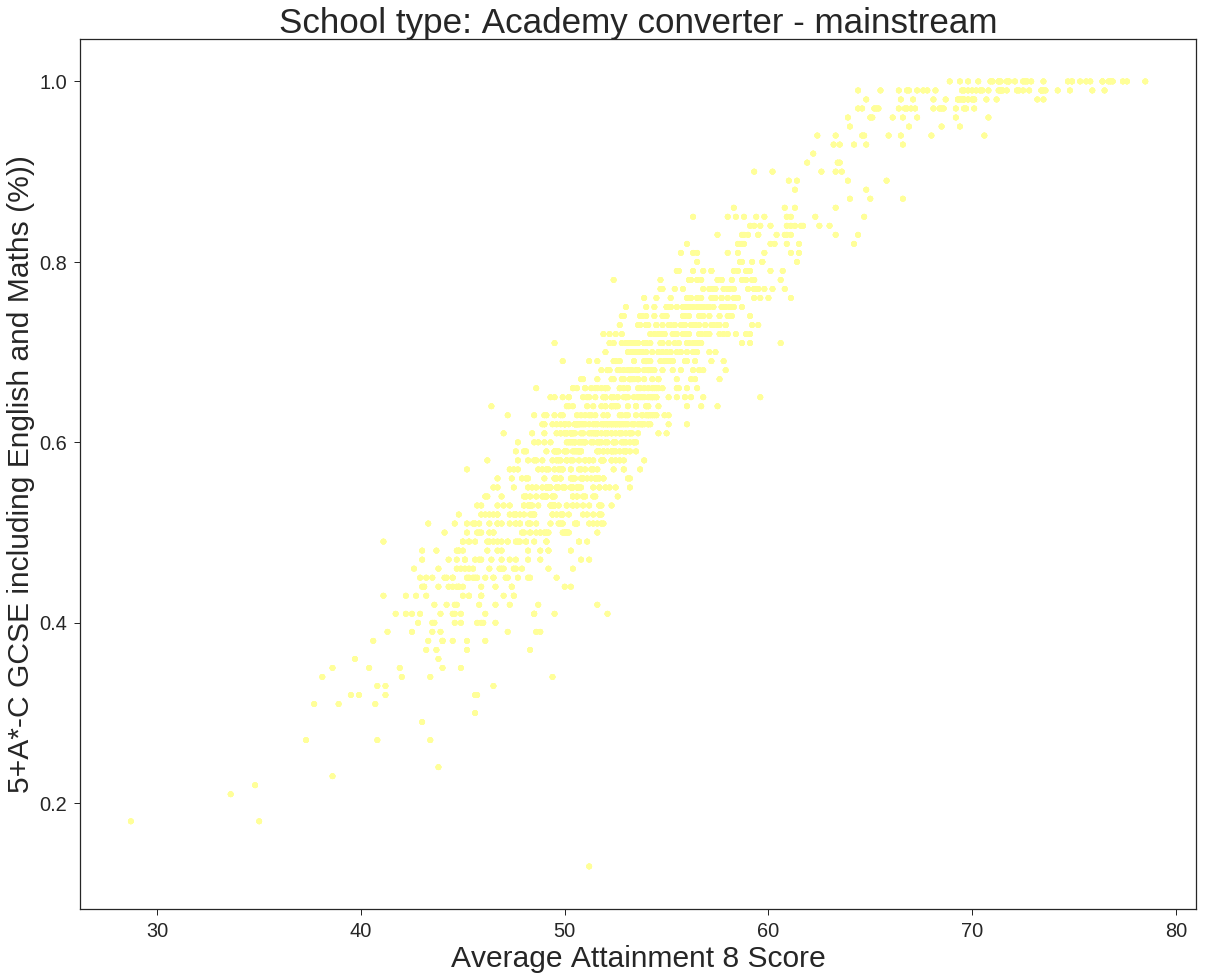

In [203]:
# snippet from https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot
for school in school_code:
    
    subset = ks4_results_df[ks4_results_df['NFTYPE']==school]
    # plot only that school type
    subset.plot.scatter(x='ATT8SCR', y='PTAC5EM_PTQ_EE',
                        c=subset['colour'],
                        s=30
                       )
    # add the title and axis labels
    plt.title('School type: ' + nftypes[school])
    plt.xlabel('Average Attainment 8 Score')
    plt.ylabel('5+A*-C GCSE including English and Maths (%))')
    
    
    plt.savefig('plot_images/scatter_' + school + '_dist.png')

<a name='q1_findings'></a>

# Q1: Findings

Observations.  The mean value of the grouped schools performance can be misleading.  The spread within each school types results, and the variance in number makes it hard to be confident in saying there is a link between school type and performance in the measures investigated.

When the data is grouped by school type with mean values for each measure there are two clear outliers, CTC as the top performer in all and FESI as the worst performer in all measures.  However, when we run cluster analysis and silhouette plots we see how spread the data is for each type.  Looking at each scatter on a by school basis revealed that CTC had 2 schools at the top and 1 at the bottom (of 3 schools), whereas FESI had a more even spread of data points.

In balance I would say that although the mean of the performance measures suggest there could be a link.  Further investigation suggests that the spread of the data does not reflect such a narrow grouping.


<a name="q2"></a>

#  Q2 - Keystage 2 and 4 Investigation.

# Do schools that perform well at KS2 deliver as good or better results at KS4.

How many mainstream schools are there?

In [204]:
ks2.find({'RECTYPE': 1}).count()

61804

So there are a very large number of documents in the dataset (after taking out the non-mainstream schools).  Which schools are in both ks2 and ks4?  I seem to remember there being a flag in the KS4 database if the school had published KS2 results.

<a name="joining"></a>

# Joining the two datasets

In [205]:
# print keys with key stage 2 in the description
for k in ks4_expanded_name.keys():
    if 'key stage 2' in ks4_expanded_name[k].lower():
        print(k, ks4_expanded_name[k])

TPRIORAV Number of pupils at the end of key stage 4 with middle prior attainment at the end of key stage 2
TABKS2 Indicates whether school is published in the primary school (key stage 2) performance tables (0=No; 1=Yes)
KS2APS Key stage 2 Average Points Score of the cohort at the end of key stage 4
PTPRIORAV Percentage of pupils at the end of key stage 4 with middle prior attainment at the end of key stage 2
TPRIORLO Number of pupils at the end of key stage 4 with low prior attainment at the end of key stage 2
PTPRIORLO Percentage of pupils at the end of key stage 4 with low prior attainment at the end of key stage 2
TPRIORHI Number of pupils at the end of key stage 4 with high prior attainment at the end of key stage 2
PTPRIORHI Percentage of pupils at the end of key stage 4 with high prior attainment at the end of key stage 2


Found it, so it is the TABKS2.  Let me make a dataframe of just those schools from KS4 then I can use the URN to look up the KS2 ones.

In [206]:
ks4_schools_df = pd.DataFrame(list(ks4.find({'TABKS2': 1},
                                            {'URN': 1,
                                             'NFTYPE': 1,
                                             'PTAC5EM_PTQ_EE': 1,
                                             'PTEBACC_PTQ_EE': 1,
                                             'P8MEA': 1,
                                             'ATT8SCR': 1,
                                             '_id': 0
                                            })))
len(ks4_schools_df)

624

In [207]:
ks4_schools_df.head()

ATT8SCR NFTYPE  P8MEA  PTAC5EM_PTQ_EE  PTEBACC_PTQ_EE     URN
0      NaN     VA    NaN             NaN             NaN  100171
1     52.7     AC   0.23            0.50            0.31  131752
2     65.0    ACC   0.47            0.87            0.69  137157
3     53.0     AC   0.06            0.77            0.34  134314
4     51.4    ACC  -0.12            0.62            0.19  137093

In [208]:
# drop the missing values
ks4_schools_df.dropna(inplace=True)

ks4_schools_df.head()

ATT8SCR NFTYPE  P8MEA  PTAC5EM_PTQ_EE  PTEBACC_PTQ_EE     URN
1     52.7     AC   0.23            0.50            0.31  131752
2     65.0    ACC   0.47            0.87            0.69  137157
3     53.0     AC   0.06            0.77            0.34  134314
4     51.4    ACC  -0.12            0.62            0.19  137093
7     54.1     AC   0.15            0.65            0.34  135073

Now is there a similar key in the ks2 dataset?

In [209]:
for k in ks2_expanded_name.keys():
    if 'key stage 4' in ks2_expanded_name[k].lower():
        print(k, ks2_expanded_name[k])

TAB15 School published in secondary school (key stage 4) performance tables


Awesome there is!  I can then use that to grab the schools from ks2

In [210]:
ks2_schools_df = pd.DataFrame(list(ks2.find({'TAB15': 1})))
len(ks2_schools_df.head())

5

5 isn't really that many, and looking at the style of the label code it probably means included in 2015 only.  Perhaps I can look up by the URN and match to those from the ks4 schools dataframe.

In [211]:
ks4_schools_df.dropna(inplace=True)

In [212]:
ks4_schools_df.head()

ATT8SCR NFTYPE  P8MEA  PTAC5EM_PTQ_EE  PTEBACC_PTQ_EE     URN
1     52.7     AC   0.23            0.50            0.31  131752
2     65.0    ACC   0.47            0.87            0.69  137157
3     53.0     AC   0.06            0.77            0.34  134314
4     51.4    ACC  -0.12            0.62            0.19  137093
7     54.1     AC   0.15            0.65            0.34  135073

In [213]:
ks2_schools_2_df = pd.DataFrame()


for index, row in ks4_schools_df.iterrows():
    doc = ks2.find_one({'URN': row['URN']},
                       {'URN': 1,
                        'PTGPS_HIGH_H': 1,
                        'PTMAT_HIGH': 1,
                        'PTREAD_HIGH': 1,
                        'PTRWM_HIGH': 1,
                        'PTGPS_EXP': 1,
                        'PTMAT_EXP':1,
                        'PTREAD_EXP':1,
                        'PTRWM_EXP':1,
                        '_id': 0 })
    ks2_schools_2_df.append(list(doc))
    
#     print(row['URN'], doc['URN'])
    
ks2_schools_2_df.head()
    

Empty DataFrame
Columns: []
Index: []

That didn't really work that well.  Let's try another way.

In [214]:
urn_list = list(ks4_schools_df['URN'])

In [215]:
# iterate through the keys in each doc of ks2.  
for doc in ks2.find():
    for key in list(doc.keys()):
        # find the URN key
        if key == 'URN':
            # checks against our list
            if int(doc[key]) in urn_list:
                # if matches it adds a new key to tag the schools that are in ks4 too
                ks2.update_one({'_id': doc['_id']},
                               {'$set': {'school_in_ks4': 1}})

ks2.find_one({'school_in_ks4':1})
                

{'ADDRESS1': 'Wood Lane',
 'ADDRESS2': nan,
 'ADDRESS3': nan,
 'AGERANGE': '3-18',
 'ALPHAIND': 1994.0,
 'BELIG': nan,
 'CONFEXAM': nan,
 'DIFFN_MATPROG': nan,
 'DIFFN_READPROG': nan,
 'DIFFN_RWM_EXP': nan,
 'DIFFN_RWM_HIGH': nan,
 'DIFFN_WRITPROG': nan,
 'ESTAB': 6905.0,
 'GELIG': nan,
 'GPS_AVERAGE': nan,
 'GPS_AVERAGE_FSM6CLA1A': nan,
 'GPS_AVERAGE_H': nan,
 'GPS_AVERAGE_L': nan,
 'GPS_AVERAGE_M': nan,
 'GPS_AVERAGE_NotFSM6CLA1A': nan,
 'ICLOSE': 0.0,
 'LA Name': 'Hammersmith and Fulham',
 'LEA': 205.0,
 'MATCOV': 0.0,
 'MATPROG': nan,
 'MATPROG_B': nan,
 'MATPROG_B_LOWER': nan,
 'MATPROG_B_UPPER': nan,
 'MATPROG_EAL': nan,
 'MATPROG_EAL_LOWER': nan,
 'MATPROG_EAL_UPPER': nan,
 'MATPROG_FSM6CLA1A': nan,
 'MATPROG_FSM6CLA1A_LOWER': nan,
 'MATPROG_FSM6CLA1A_UPPER': nan,
 'MATPROG_G': nan,
 'MATPROG_G_LOWER': nan,
 'MATPROG_G_UPPER': nan,
 'MATPROG_H': nan,
 'MATPROG_H_LOWER': nan,
 'MATPROG_H_UPPER': nan,
 'MATPROG_L': nan,
 'MATPROG_LOWER': nan,
 'MATPROG_L_LOWER': nan,
 'MATPROG_L_U

great that worked.

great now we can grab those data and put them it a dataframe.

In [216]:
ks2_schools_df = pd.DataFrame(list(ks2.find({'school_in_ks4': 1},
                                            {'URN': 1,
                                             'PTGPS_HIGH': 1,
                                             'PTMAT_HIGH': 1,
                                             'PTREAD_HIGH': 1,
                                             'PTRWM_HIGH': 1,
                                             'PTGPS_EXP': 1,
                                             'PTMAT_EXP': 1,
                                             'PTREAD_EXP': 1,
                                             'PTRWM_EXP': 1,
                                             
                                             '_id': 0 })))

In [217]:
len(ks2_schools_df)

460

In [218]:
ks2_schools_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 460 entries, 0 to 459
Data columns (total 9 columns):
PTGPS_EXP      460 non-null float64
PTGPS_HIGH     460 non-null float64
PTMAT_EXP      460 non-null float64
PTMAT_HIGH     460 non-null float64
PTREAD_EXP     460 non-null float64
PTREAD_HIGH    460 non-null float64
PTRWM_EXP      460 non-null float64
PTRWM_HIGH     460 non-null float64
URN            460 non-null float64
dtypes: float64(9)
memory usage: 32.4 KB


In [219]:
ks2_schools_df['URN'] = ks2_schools_df['URN'].apply(lambda x: int(x))
ks2_schools_df.head()

PTGPS_EXP  PTGPS_HIGH  PTMAT_EXP  PTMAT_HIGH  PTREAD_EXP  PTREAD_HIGH  \
0       0.00        0.00       0.00        0.00        0.00         0.00   
1       1.00        0.35       1.00        0.25        0.95         0.60   
2       0.73        0.27       0.83        0.23        0.67         0.20   
3       0.00        0.00       0.00        0.00        0.00         0.00   
4       0.90        0.29       0.93        0.19        0.69         0.17   

   PTRWM_EXP  PTRWM_HIGH     URN  
0       0.00        0.00  131752  
1       0.95        0.25  137157  
2       0.63        0.03  134314  
3       0.00        0.00  137093  
4       0.60        0.03  135073

In [220]:
# let's get an idea of the data
ks2_schools_df.describe()

PTGPS_EXP  PTGPS_HIGH   PTMAT_EXP  PTMAT_HIGH  PTREAD_EXP  \
count  460.000000  460.000000  460.000000  460.000000  460.000000   
mean     0.416261    0.116087    0.406261    0.085652    0.381304   
std      0.356244    0.137184    0.357657    0.101278    0.328218   
min      0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.530000    0.070000    0.470000    0.060000    0.460000   
75%      0.760000    0.200000    0.740000    0.150000    0.670000   
max      1.000000    0.480000    1.000000    0.400000    0.950000   

       PTREAD_HIGH   PTRWM_EXP  PTRWM_HIGH            URN  
count   460.000000  460.000000   460.00000     460.000000  
mean      0.089478    0.294957     0.02313  131183.252174  
std       0.114133    0.273269     0.03834   11954.658609  
min       0.000000    0.000000     0.00000  100747.000000  
25%       0.000000    0.000000     0.00000  133554.000000  
50%       0.050000    0.300000     0.00000  135896.000000  
75%       0.160000    0.550000     0.03000  138193.000000  
max       0.600000    0.950000     0.25000  142219.000000

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe6e18b44e0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7fe6e262ac88>], dtype=object)

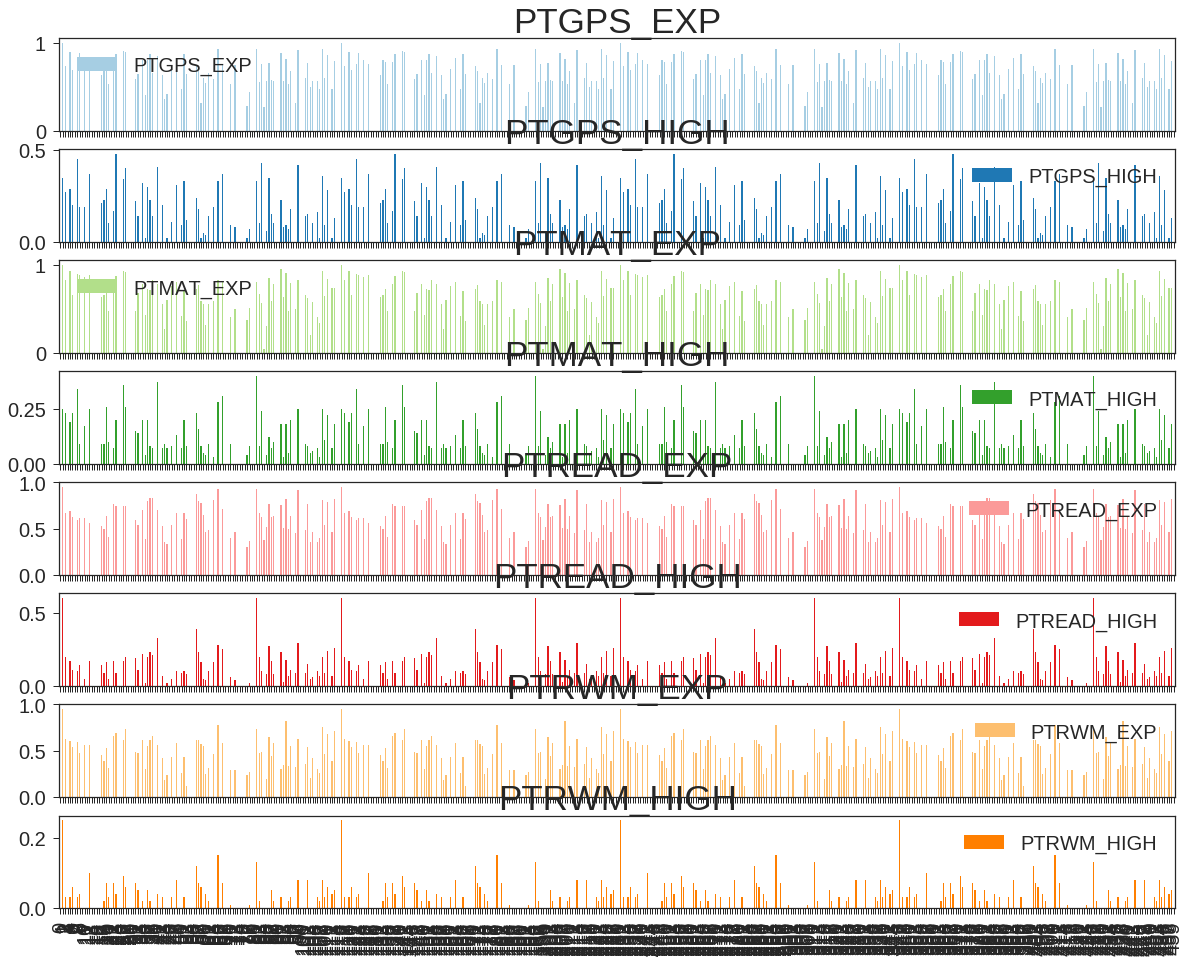

In [221]:
ks2_schools_df.drop('URN', axis=1).plot(kind='bar', subplots=True)

In [222]:
# merge the two dataframes
ks2_ks4_df = pd.merge(ks4_schools_df, ks2_schools_df, on='URN')

In [223]:
ks2_ks4_df.describe()

ATT8SCR        P8MEA  PTAC5EM_PTQ_EE  PTEBACC_PTQ_EE  \
count  1840.000000  1840.000000     1840.000000     1840.000000   
mean     48.991304     0.021130        0.541304        0.221565   
std       6.876049     0.442727        0.163945        0.162271   
min      29.600000    -1.360000        0.090000        0.010000   
25%      44.300000    -0.270000        0.430000        0.090000   
50%      49.200000     0.070000        0.530000        0.190000   
75%      52.900000     0.310000        0.650000        0.320000   
max      67.800000     1.310000        0.990000        0.760000   

                 URN    PTGPS_EXP   PTGPS_HIGH    PTMAT_EXP   PTMAT_HIGH  \
count    1840.000000  1840.000000  1840.000000  1840.000000  1840.000000   
mean   131183.252174     0.416261     0.116087     0.406261     0.085652   
std     11944.903684     0.355953     0.137072     0.357366     0.101196   
min    100747.000000     0.000000     0.000000     0.000000     0.000000   
25%    133554.000000     0.000000     0.000000     0.000000     0.000000   
50%    135896.000000     0.530000     0.070000     0.470000     0.060000   
75%    138193.000000     0.760000     0.200000     0.740000     0.150000   
max    142219.000000     1.000000     0.480000     1.000000     0.400000   

        PTREAD_EXP  PTREAD_HIGH    PTRWM_EXP   PTRWM_HIGH  
count  1840.000000  1840.000000  1840.000000  1840.000000  
mean      0.381304     0.089478     0.294957     0.023130  
std       0.327951     0.114040     0.273046     0.038308  
min       0.000000     0.000000     0.000000     0.000000  
25%       0.000000     0.000000     0.000000     0.000000  
50%       0.460000     0.050000     0.300000     0.000000  
75%       0.670000     0.160000     0.550000     0.030000  
max       0.950000     0.600000     0.950000     0.250000

In [224]:
ks2_ks4_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1840 entries, 0 to 1839
Data columns (total 14 columns):
ATT8SCR           1840 non-null float64
NFTYPE            1840 non-null object
P8MEA             1840 non-null float64
PTAC5EM_PTQ_EE    1840 non-null float64
PTEBACC_PTQ_EE    1840 non-null float64
URN               1840 non-null int64
PTGPS_EXP         1840 non-null float64
PTGPS_HIGH        1840 non-null float64
PTMAT_EXP         1840 non-null float64
PTMAT_HIGH        1840 non-null float64
PTREAD_EXP        1840 non-null float64
PTREAD_HIGH       1840 non-null float64
PTRWM_EXP         1840 non-null float64
PTRWM_HIGH        1840 non-null float64
dtypes: float64(12), int64(1), object(1)
memory usage: 215.6+ KB


In [225]:
grouped_by_mean = ks2_ks4_df.drop('URN', axis=1).groupby('NFTYPE').mean()

In [226]:
grouped_by_mean

ATT8SCR     P8MEA  PTAC5EM_PTQ_EE  PTEBACC_PTQ_EE  PTGPS_EXP  \
NFTYPE                                                                   
AC      46.441509 -0.069623        0.496226        0.181698   0.504340   
ACC     53.215385  0.217308        0.623462        0.281923   0.231154   
CY      48.940000  0.076000        0.533333        0.212667   0.199333   
F       53.242857 -0.154286        0.644286        0.321429   0.814286   
FD      45.385714 -0.004286        0.402857        0.175714   0.292857   
VA      52.350000  0.073333        0.626667        0.301667   0.631667   
VC      50.400000  0.000000        0.650000        0.040000   0.600000   

        PTGPS_HIGH  PTMAT_EXP  PTMAT_HIGH  PTREAD_EXP  PTREAD_HIGH  PTRWM_EXP  \
NFTYPE                                                                          
AC        0.137358   0.502642    0.095660    0.460755     0.096038   0.359623   
ACC       0.070385   0.224231    0.069231    0.210000     0.073846   0.175769   
CY        0.031333   0.171333    0.026000    0.198000     0.046667   0.128000   
F         0.271429   0.772857    0.148571    0.720000     0.180000   0.498571   
FD        0.101429   0.277143    0.080000    0.247143     0.041429   0.168571   
VA        0.185000   0.630000    0.156667    0.596667     0.163333   0.525000   
VC        0.050000   0.550000    0.050000    0.650000     0.050000   0.550000   

        PTRWM_HIGH  
NFTYPE              
AC        0.024528  
ACC       0.028077  
CY        0.006000  
F         0.041429  
FD        0.011429  
VA        0.028333  
VC        0.000000

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe6bec17c18>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7fe6bf0c3048>], dtype=object)

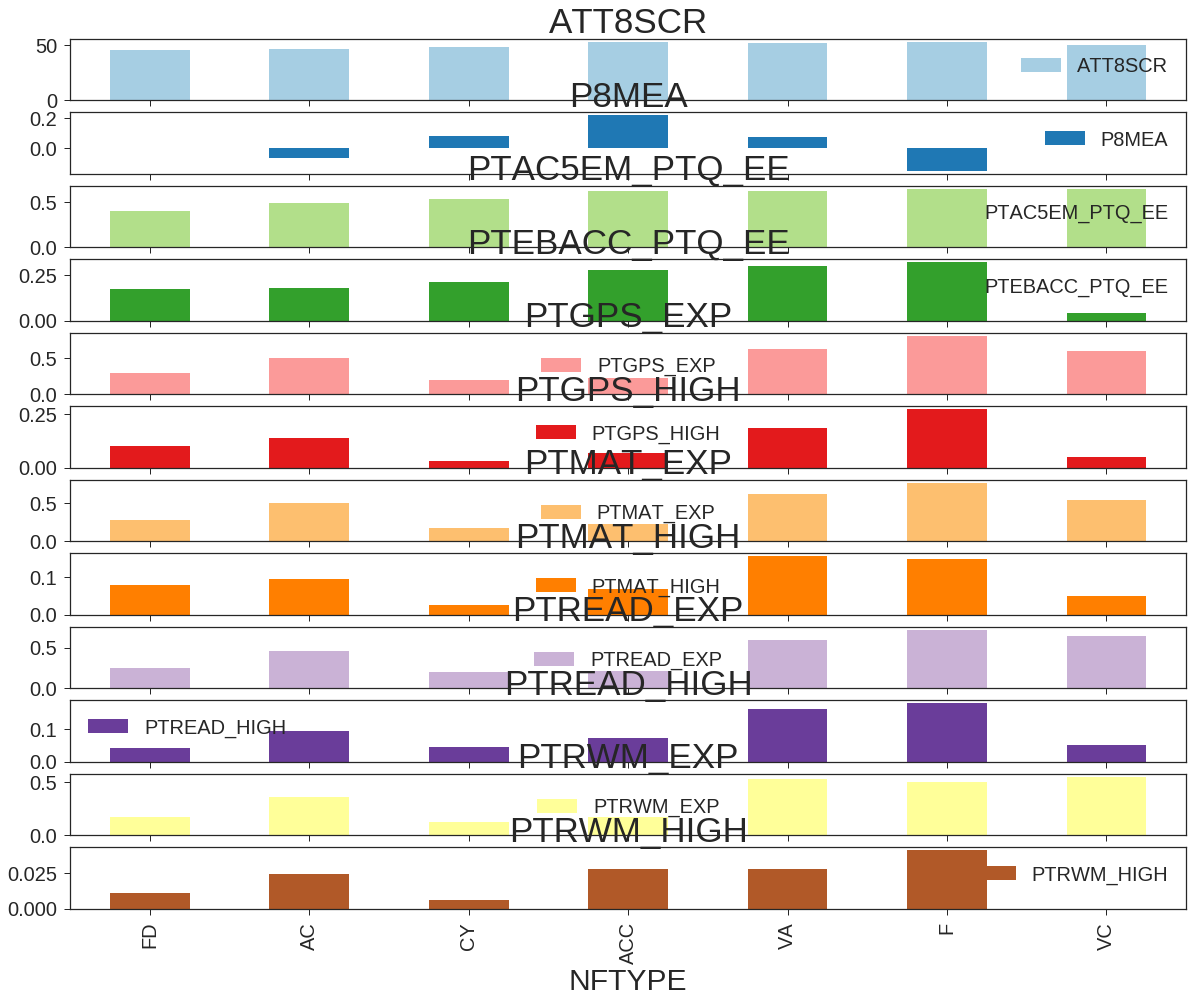

In [227]:
grouped_by_mean.sort_values('PTAC5EM_PTQ_EE').plot(kind='bar', subplots=True)

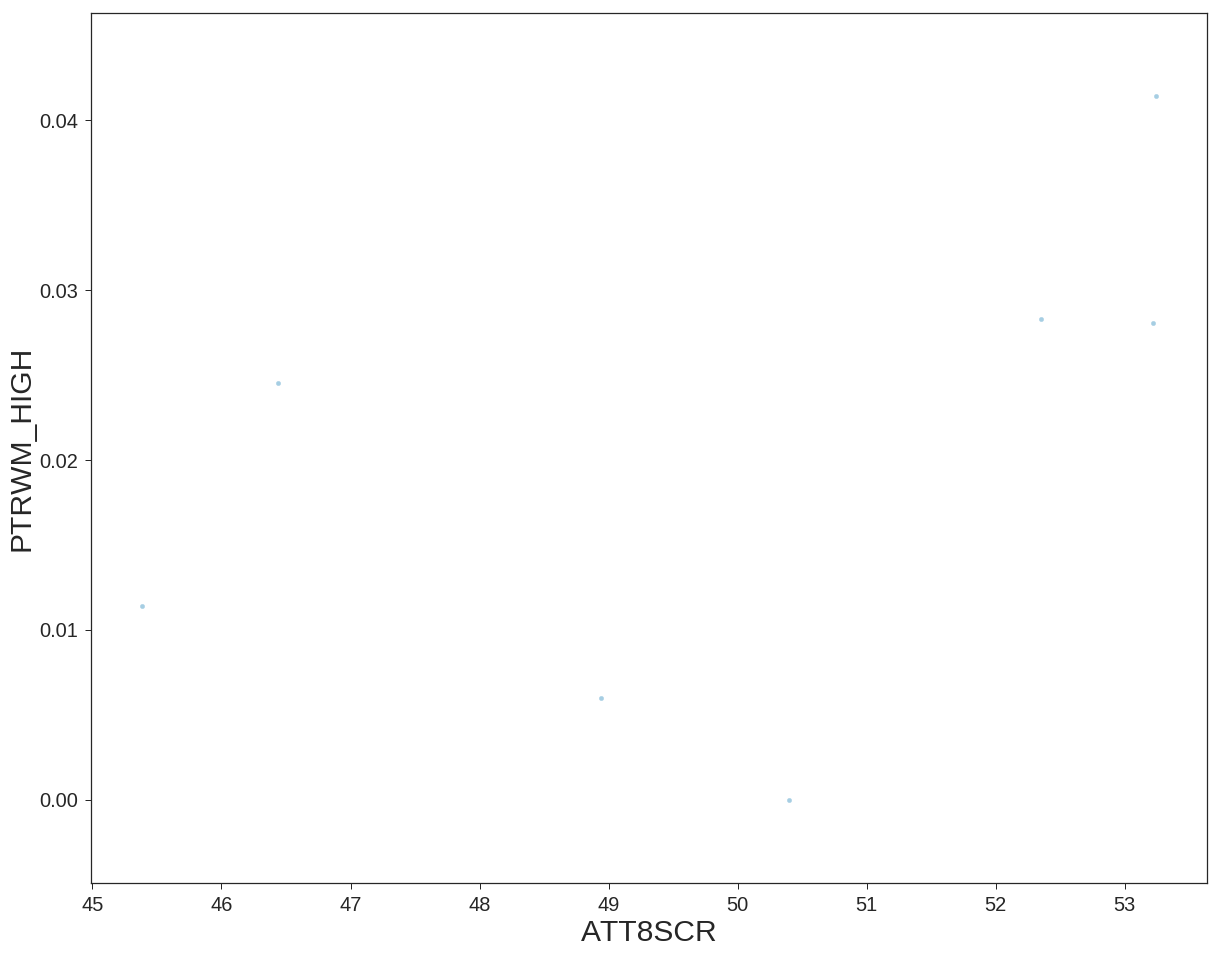

In [228]:
grouped_by_mean.plot.scatter(x='ATT8SCR', y='PTRWM_HIGH')

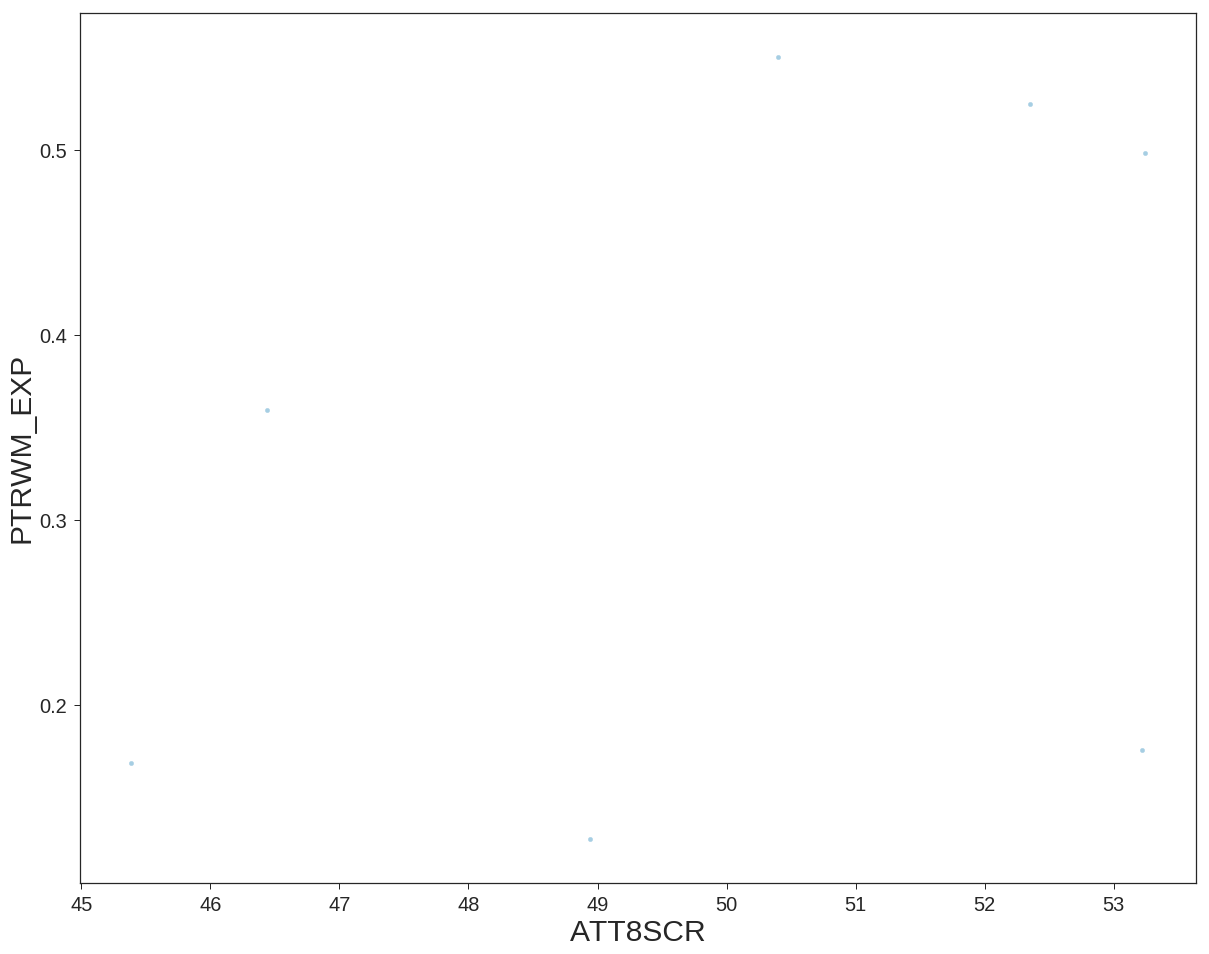

In [229]:
grouped_by_mean.plot.scatter(x='ATT8SCR', y='PTRWM_EXP')

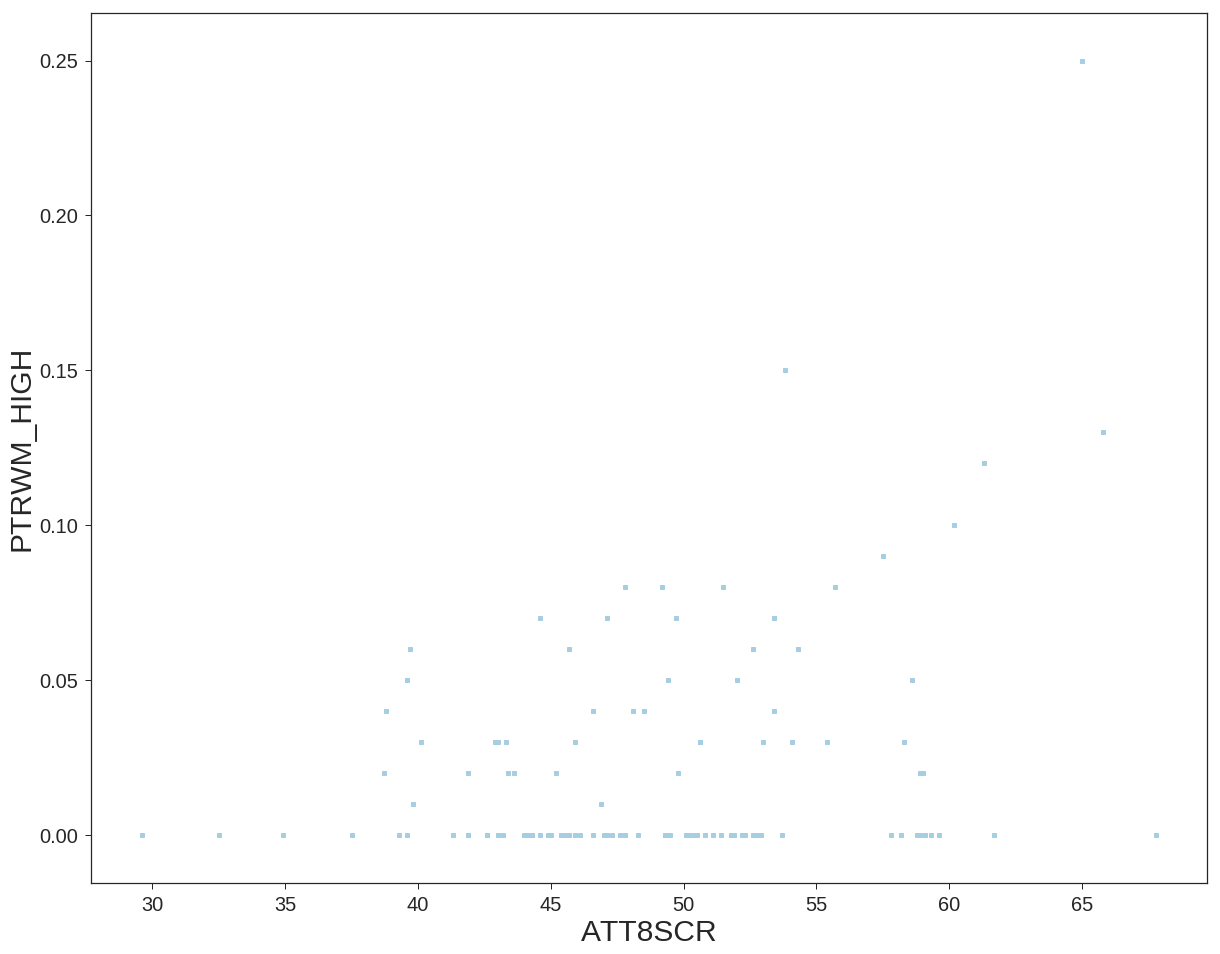

In [230]:
# look at the values of high grades of PTRWM and attainment 8
ks2_ks4_df[['ATT8SCR', 'PTRWM_HIGH', ]].plot.scatter(x='ATT8SCR',y='PTRWM_HIGH')

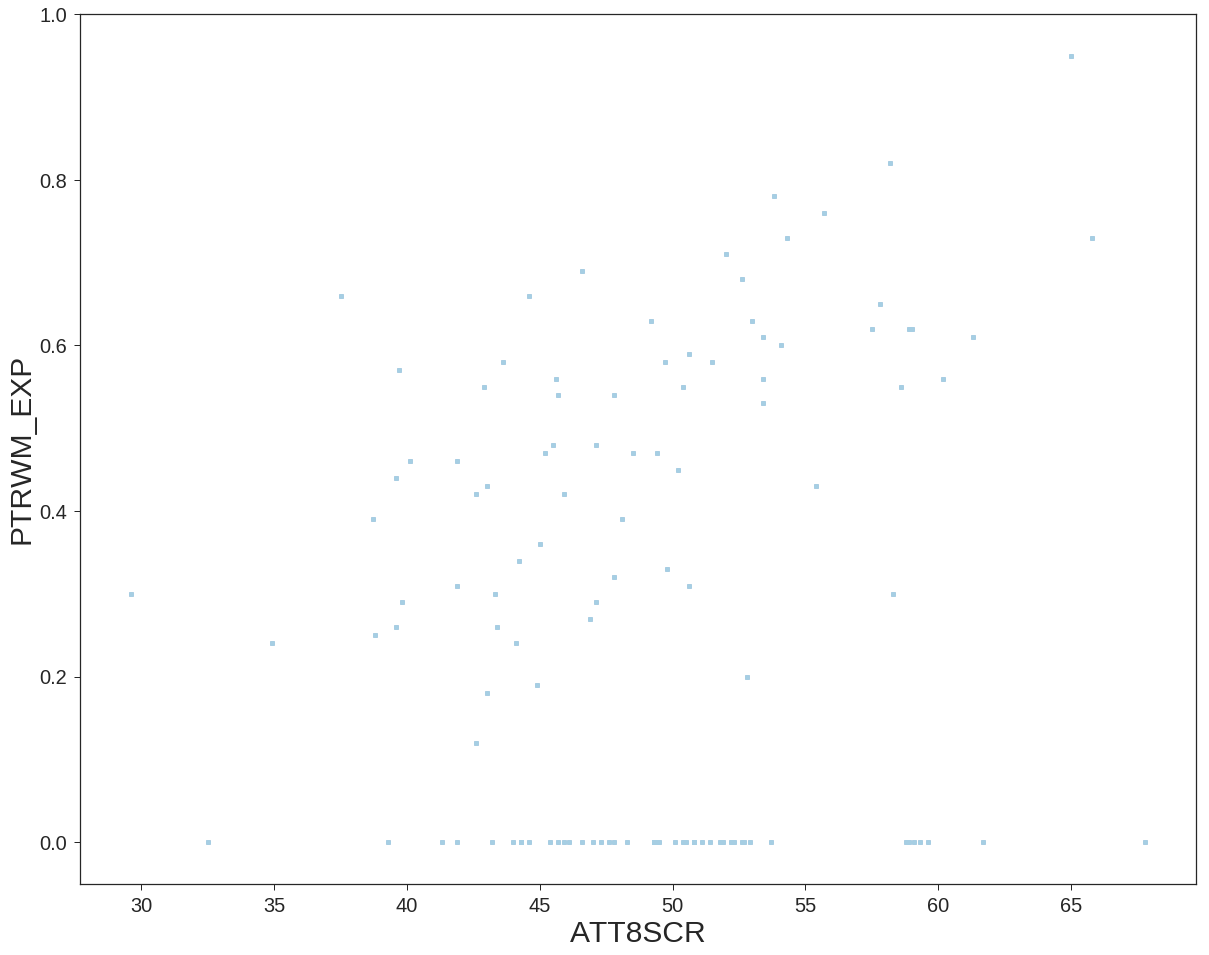

In [231]:
# look at the values of expected PTRWM and attainment 8
ks2_ks4_df[['ATT8SCR', 'PTRWM_EXP']].plot.scatter(x='ATT8SCR',y='PTRWM_EXP')

<a name='plotting'></a>

# Plotting KS2 - KS4

## Plot the expected level performance vs Attainment 8 score

In [232]:
# subset the data
scatter_df = ks2_ks4_df[['ATT8SCR', 'PTRWM_EXP', 'NFTYPE']]

In [233]:
# set up the color map and school codes
# get a list of the school types and assign each a colour
school_code = list(set(scatter_df['NFTYPE']))

colour_map = sns.palettes.color_palette(palette='Paired', n_colors=len(school_code))

school_code.sort()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


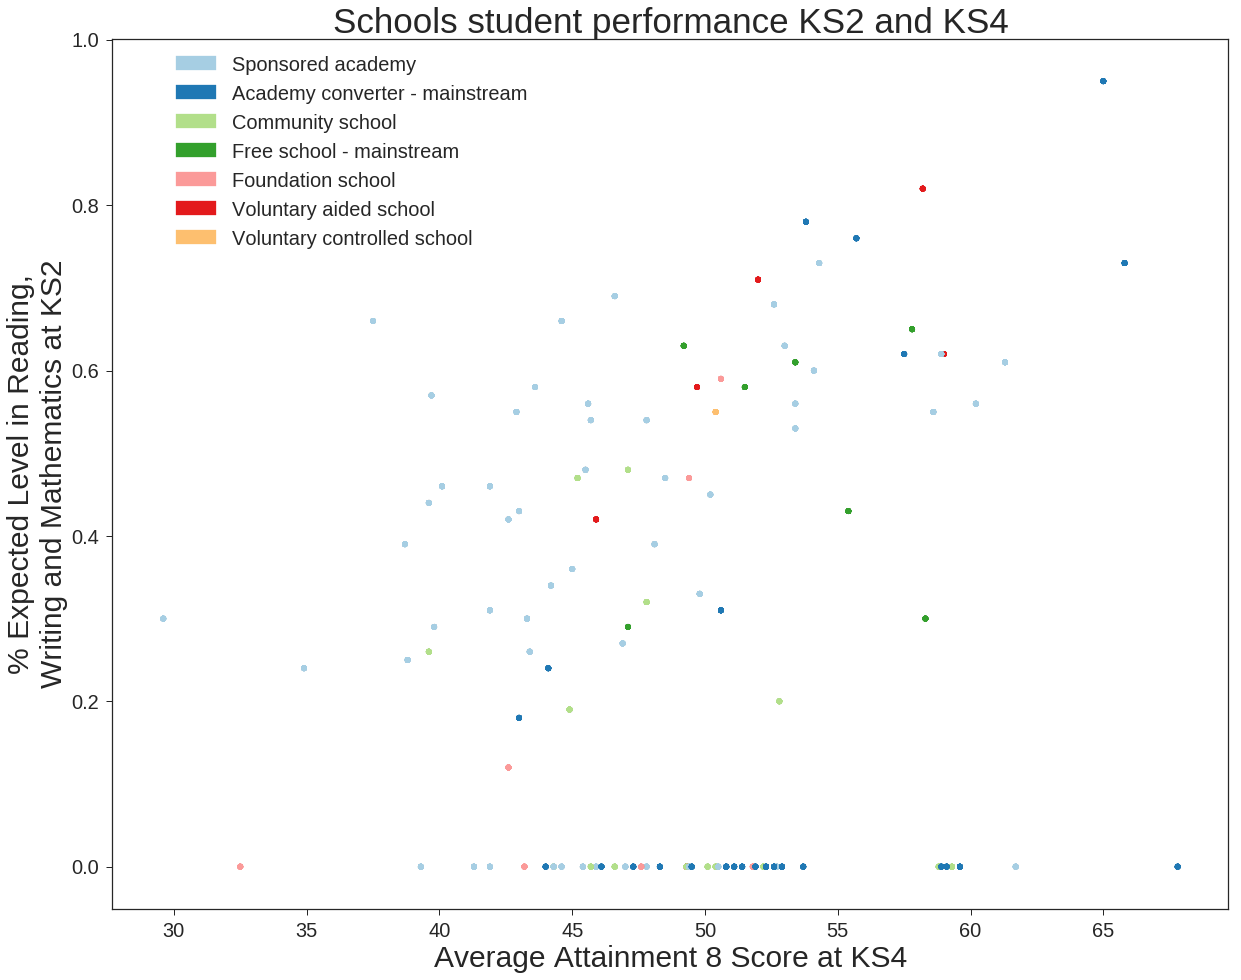

In [234]:
# add the colour column to the dataframe 
scatter_df['colour'] = scatter_df['NFTYPE'].apply(lambda x:colour_map[school_code.index(x)])


# plot them all to the same plot
scatter_df.plot.scatter(x='ATT8SCR', y='PTRWM_EXP',
                            s=30,
                            c=scatter_df['colour']
                           )


# add the title and labels
plt.title('Schools student performance KS2 and KS4')
plt.xlabel('Average Attainment 8 Score at KS4')
plt.ylabel('% Expected Level in Reading,\nWriting and Mathematics at KS2')

# make the legend handles
legend_handles = ([mpatches.Patch(color=colour_map[0], label=nftypes[school_code[0]])]+
                  [mpatches.Patch(color=colour_map[1], label=nftypes[school_code[1]])]+
                  [mpatches.Patch(color=colour_map[2], label=nftypes[school_code[2]])]+
                  [mpatches.Patch(color=colour_map[3], label=nftypes[school_code[3]])]+
                  [mpatches.Patch(color=colour_map[4], label=nftypes[school_code[4]])]+
                  [mpatches.Patch(color=colour_map[5], label=nftypes[school_code[5]])]+
                  [mpatches.Patch(color=colour_map[6], label=nftypes[school_code[6]])])
                
plt.legend(handles=legend_handles, loc=(0.05, 0.75))

plt.savefig('plot_images/KS2_KS4_EXP_ATT8.png')

In [235]:
scatter_df.describe()

ATT8SCR    PTRWM_EXP
count  1840.000000  1840.000000
mean     48.991304     0.294957
std       6.876049     0.273046
min      29.600000     0.000000
25%      44.300000     0.000000
50%      49.200000     0.300000
75%      52.900000     0.550000
max      67.800000     0.950000

## Plot the High level performance vs Attainment 8 score

In [236]:
# subset the data
scatter_df = ks2_ks4_df[['ATT8SCR', 'PTRWM_HIGH', 'NFTYPE']]

In [237]:
# set up the color map and school codes
# get a list of the school types and assign each a colour
school_code = list(set(scatter_df['NFTYPE']))

colour_map = sns.palettes.color_palette(palette='Paired', n_colors=len(school_code))

school_code.sort()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


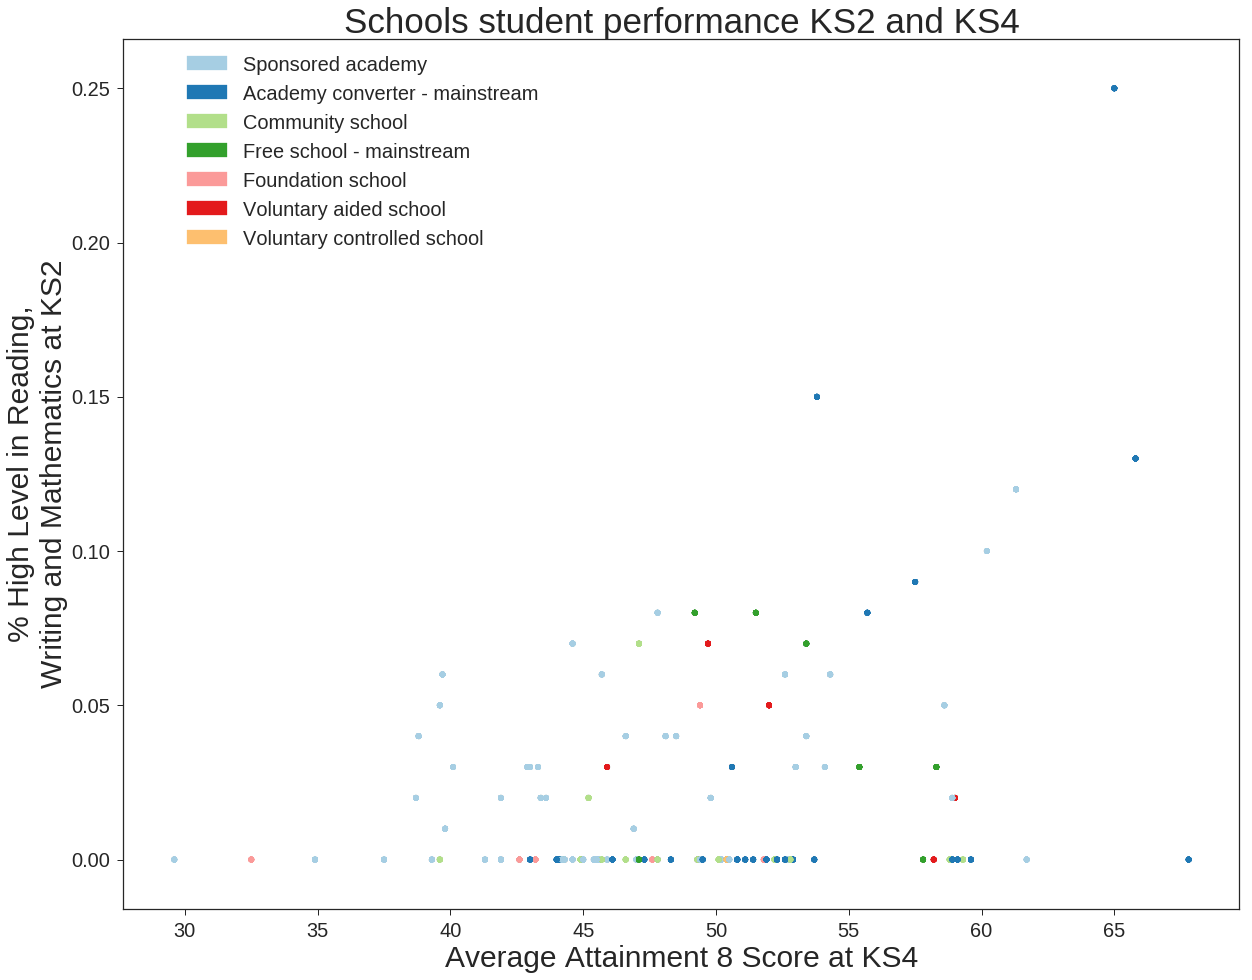

In [238]:
# add the colour column to the dataframe 
scatter_df['colour'] = scatter_df['NFTYPE'].apply(lambda x:colour_map[school_code.index(x)])


# plot them all to the same plot
scatter_df.plot.scatter(x='ATT8SCR', y='PTRWM_HIGH',
                            s=30,
                            c=scatter_df['colour']
                           )

# add the title and axis labels
plt.title('Schools student performance KS2 and KS4')
plt.xlabel('Average Attainment 8 Score at KS4')
plt.ylabel('% High Level in Reading,\nWriting and Mathematics at KS2')

# make the legend handles
legend_handles = ([mpatches.Patch(color=colour_map[0], label=nftypes[school_code[0]])]+
                  [mpatches.Patch(color=colour_map[1], label=nftypes[school_code[1]])]+
                  [mpatches.Patch(color=colour_map[2], label=nftypes[school_code[2]])]+
                  [mpatches.Patch(color=colour_map[3], label=nftypes[school_code[3]])]+
                  [mpatches.Patch(color=colour_map[4], label=nftypes[school_code[4]])]+
                  [mpatches.Patch(color=colour_map[5], label=nftypes[school_code[5]])]+
                  [mpatches.Patch(color=colour_map[6], label=nftypes[school_code[6]])])
                
plt.legend(handles=legend_handles, loc=(0.05, 0.75))

plt.savefig('plot_images/KS2_KS4_HIGH_ATT8.png')

In [239]:
scatter_df.describe()

ATT8SCR   PTRWM_HIGH
count  1840.000000  1840.000000
mean     48.991304     0.023130
std       6.876049     0.038308
min      29.600000     0.000000
25%      44.300000     0.000000
50%      49.200000     0.000000
75%      52.900000     0.030000
max      67.800000     0.250000

<a name='pearson'></a>

## Plot the High level performance vs GCSE 5 A*-C

In [240]:
# subset the data
scatter_df = ks2_ks4_df[['PTAC5EM_PTQ_EE', 'PTRWM_HIGH', 'NFTYPE']]

In [241]:
# set up the color map and school codes
# get a list of the school types and assign each a colour
school_code = list(set(scatter_df['NFTYPE']))

colour_map = sns.palettes.color_palette(palette='Paired', n_colors=len(school_code))

school_code.sort()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


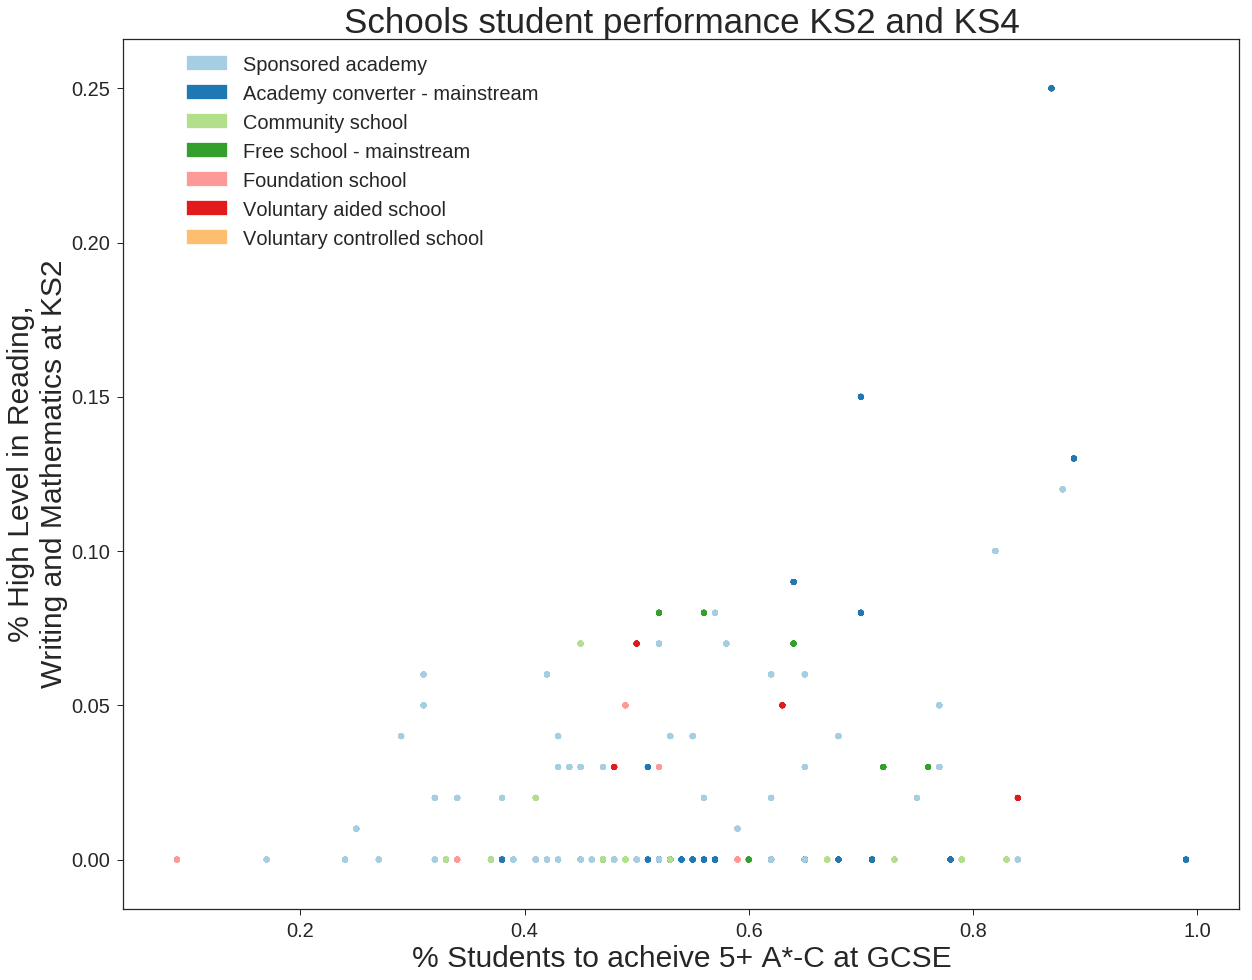

In [242]:
# add the colour column to the dataframe 
scatter_df['colour'] = scatter_df['NFTYPE'].apply(lambda x:colour_map[school_code.index(x)])


# plot them all to the same plot
scatter_df.plot.scatter(x='PTAC5EM_PTQ_EE', y='PTRWM_HIGH',
                            s=30,
                            c=scatter_df['colour']
                           )

# add the title and axis labels
plt.title('Schools student performance KS2 and KS4')
plt.xlabel('% Students to acheive 5+ A*-C at GCSE')
plt.ylabel('% High Level in Reading,\nWriting and Mathematics at KS2')

# make the legend handles
legend_handles = ([mpatches.Patch(color=colour_map[0], label=nftypes[school_code[0]])]+
                  [mpatches.Patch(color=colour_map[1], label=nftypes[school_code[1]])]+
                  [mpatches.Patch(color=colour_map[2], label=nftypes[school_code[2]])]+
                  [mpatches.Patch(color=colour_map[3], label=nftypes[school_code[3]])]+
                  [mpatches.Patch(color=colour_map[4], label=nftypes[school_code[4]])]+
                  [mpatches.Patch(color=colour_map[5], label=nftypes[school_code[5]])]+
                  [mpatches.Patch(color=colour_map[6], label=nftypes[school_code[6]])])
                
plt.legend(handles=legend_handles, loc=(0.05, 0.75))

plt.savefig('plot_images/KS2_KS4_HIGH_AC5.png')

In [243]:
scatter_df.describe()

PTAC5EM_PTQ_EE   PTRWM_HIGH
count     1840.000000  1840.000000
mean         0.541304     0.023130
std          0.163945     0.038308
min          0.090000     0.000000
25%          0.430000     0.000000
50%          0.530000     0.000000
75%          0.650000     0.030000
max          0.990000     0.250000

## Plot the High level performance vs GCSE 5 A*-C

In [244]:
# subset the data
scatter_df = ks2_ks4_df[['PTAC5EM_PTQ_EE', 'PTRWM_EXP', 'NFTYPE']]

In [245]:
# set up the color map and school codes
# get a list of the school types and assign each a colour
school_code = list(set(scatter_df['NFTYPE']))

colour_map = sns.palettes.color_palette(palette='Paired', n_colors=len(school_code))

school_code.sort()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


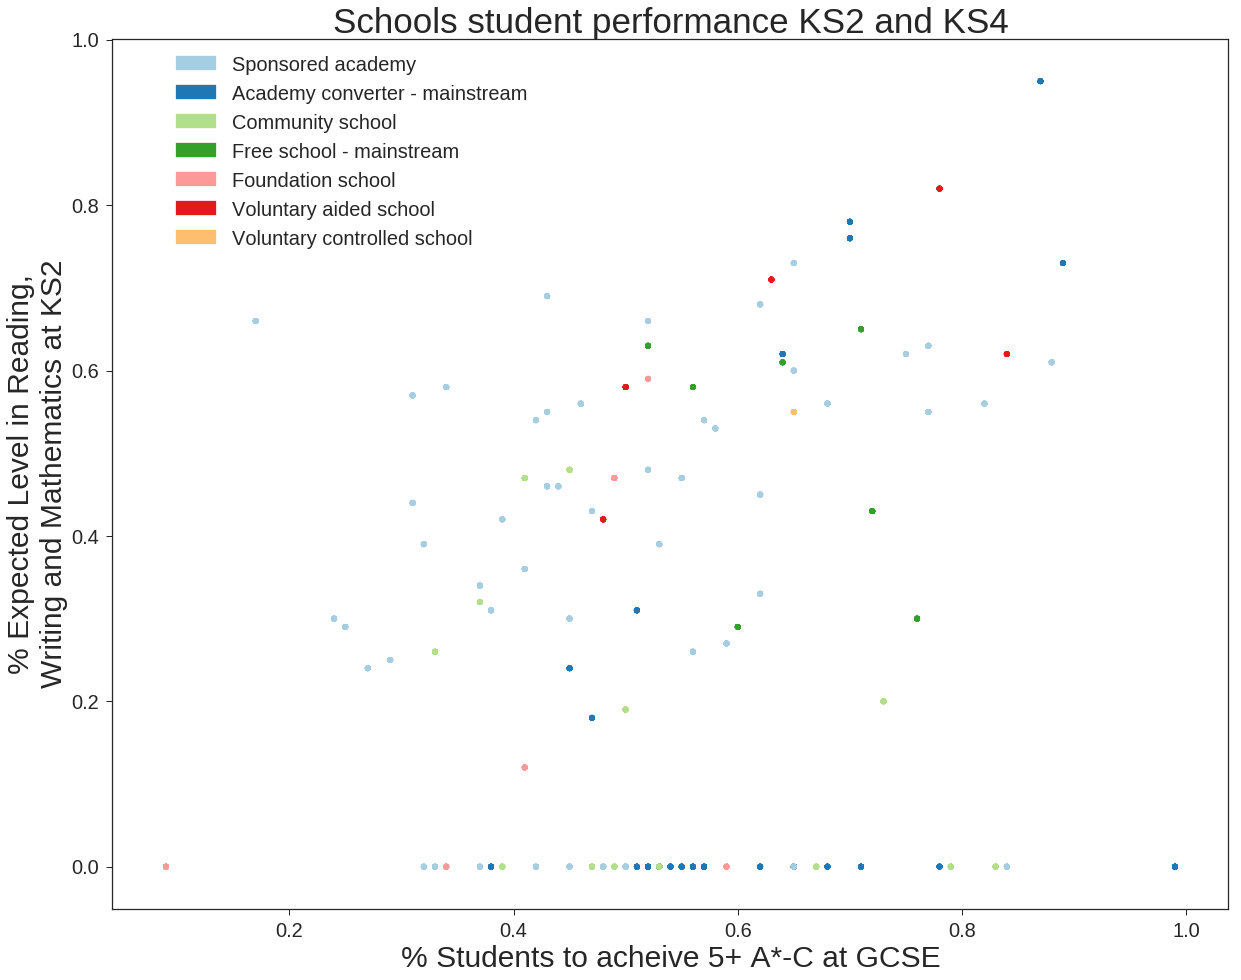

In [246]:
# add the colour column to the dataframe 
scatter_df['colour'] = scatter_df['NFTYPE'].apply(lambda x:colour_map[school_code.index(x)])


# plot them all to the same plot
scatter_df.plot.scatter(x='PTAC5EM_PTQ_EE', y='PTRWM_EXP',
                            s=30,
                            c=scatter_df['colour']
                           )

# add the title and axis labels
plt.title('Schools student performance KS2 and KS4')
plt.xlabel('% Students to acheive 5+ A*-C at GCSE')
plt.ylabel('% Expected Level in Reading,\nWriting and Mathematics at KS2')

# make the legend handles
legend_handles = ([mpatches.Patch(color=colour_map[0], label=nftypes[school_code[0]])]+
                  [mpatches.Patch(color=colour_map[1], label=nftypes[school_code[1]])]+
                  [mpatches.Patch(color=colour_map[2], label=nftypes[school_code[2]])]+
                  [mpatches.Patch(color=colour_map[3], label=nftypes[school_code[3]])]+
                  [mpatches.Patch(color=colour_map[4], label=nftypes[school_code[4]])]+
                  [mpatches.Patch(color=colour_map[5], label=nftypes[school_code[5]])]+
                  [mpatches.Patch(color=colour_map[6], label=nftypes[school_code[6]])])
                
plt.legend(handles=legend_handles, loc=(0.05, 0.75))

plt.savefig('plot_images/KS2_KS4_EXP_AC5.png')

In [247]:
scatter_df.describe()

PTAC5EM_PTQ_EE    PTRWM_EXP
count     1840.000000  1840.000000
mean         0.541304     0.294957
std          0.163945     0.273046
min          0.090000     0.000000
25%          0.430000     0.000000
50%          0.530000     0.300000
75%          0.650000     0.550000
max          0.990000     0.950000

<a name='pearson'></a>

# Pearson's *R*² test

In [248]:
# Attainment 8 and high KS2
a = scipy.stats.pearsonr(ks2_ks4_df['ATT8SCR'],
                     ks2_ks4_df['PTRWM_HIGH'])

In [249]:
# Attainment 8 and Expected KS2

In [250]:
b = scipy.stats.pearsonr(ks2_ks4_df['ATT8SCR'],
                     ks2_ks4_df['PTRWM_EXP'])

In [251]:
# 5+ A*-C and high KS2
c = scipy.stats.pearsonr(ks2_ks4_df['PTAC5EM_PTQ_EE'],
                     ks2_ks4_df['PTRWM_HIGH'])

In [252]:
# 5+ A*-C and Expected KS2

In [253]:
d = scipy.stats.pearsonr(ks2_ks4_df['PTAC5EM_PTQ_EE'],
                     ks2_ks4_df['PTRWM_EXP'])

In [254]:
results = pd.DataFrame({'R2 value': [a[0], b[0], c[0], d[0]], 'P value': [a[1], b[1], c[1], d[1]],
 'Comparison': ['A8 to High KS2', 'A8 to Exp KS2', 'AC5 to High KS2', 'AC5 to EXP KS2']})
results.set_index('Comparison')
results[['R2 value', 'P value']]

R2 value       P value
0  0.341699  1.519029e-51
1  0.155640  1.911678e-11
2  0.315616  7.740719e-44
3  0.173126  7.560387e-14

Observations,  these statistics suggest that there is a slight positive correlation between students that achieve high scores at KS2 in Reading, Writing and Mathematics with Achieving better results at KS4 in both of the Attainment 8 scores and 5+A*-C GCSE grades.

Both have a very small _p_ value and so we can say that the result is significant.  We can therefore reject the null hypothesis that high performing schools perform the same as any other at KS4 (for the measures tested at least).

We can also see that the achievement of only the expected level of KS2 standard in Reading, Writing and Mathematics were not as correlated (the R value is smaller (between 15.5 and 17.3) and the _p_ value is too high for this result to be deemed significant (it should be under 0.05) 

<a name='q1_findings'></a>

# Q2: Findings

This analysis suggests that schools whose students achieve high scores at KS2 in Reading writing and Maths are also schools that achieved better results at KS4.  However it is not a massive amount higher and the dataset used did not have a large number of schools that were in both KS2 and KS4 published.  Therefore, there can be a number of confounding factors, which will be ellucidated in the accompanying report.

# Cleanup/remove the database
<a name="cleanup"></a>

Uncomment the lines below to remove the MongoDB created in the investigation.

In [255]:
# uncomment to remove the database if needed
# client.drop_database('schools_db')
# client.database_names()